# Multi-State Model for gyrodactylid parasite infection

It is useful to describe any process in which an individual (fish) moves through a series of states in continuous time

https://cran.r-project.org/web/packages/msm/msm.pdf

https://cran.r-project.org/web/packages/msm/vignettes/msm-manual.pdf


https://cran.r-project.org/web/packages/msmtools/msmtools.pdf    #works with msm package as well

In [1]:
options(repr.plot.width=8, repr.plot.height=8,repr.plot.res = 300) #Setting plot size

In [3]:
library("msm")
library("msmtools") #integrated with msm package for further analysis
library("survival")
library("survivalAnalysis") #Multivariate Surival
library("rms")
#library("sjPlot")#Interaction plots
library(sjmisc)
library(ggplot2)
library(MuMIn) # use to calculate the marginal and conditional R-Sq
library(lme4) #for glmm
library("lmerTest")
#library(effects)#check for effect size
#theme_set(theme_sjplot())

library("lmtest") # for likelihood ratio test
#For Multivariate survival analysis
library(tidyverse)
library(tidytidbits)
library("survivalAnalysis") #Multivariate Surival
library("condSURV") #Conditional Survival Analysis
library(KernSmooth)
library(survminer)#Plot survival curves
library(plyr)#Transforming data
library(dplyr)
library(officer)
library(Rcpp)
library(rvg)

library(psycho)
library(dplyr)
library("tidyverse")
library("lmerTest")
library(ggplot2)
#library(modelbased)
#library(see)
library(grid)

In [4]:
#Setting working directory
setwd("C:/Users/user/Desktop/DataAnalysis_results_R/Multi-state Markov Modelling")

In [5]:
#Importing data for survival analysis
#Fish death status:  0=alive (right centered), 1=dead (Uncensored)
#Parasite extinction:  0=Not extinct (right centered), 1=Extinct (Uncensored)
#Multistates: State1=fish alive but remained infected, State2=fish alive without infection, State3=fish dead

Survival_data<-read.csv(file="MultiSate_Model_Data.csv")

Survival_data$Sex_fish<-factor(Survival_data$Sex_fish,levels=c(1,2),labels=c("Female fish","Male fish"))
Survival_data$Fish_population<-factor(Survival_data$Fish_population,levels=c(1,2,3),labels=c("Upper Aripo","Lower Aripo","Ornamental"))
Survival_data$Parasite_type<-factor(Survival_data$Parasite_type,levels=c(1,2,3),labels=c("Gt3","Gt","Gb"))
Survival_data$States_cat<-factor(Survival_data$Multistates,levels=c(1,2,3),labels=c("State 1","State 2","State 3"))

Survival_data$Size_Category[Survival_data$Fish_size<=17.5]="Cat_small"
Survival_data$Size_Category[Survival_data$Fish_size>17.5]="Large"


Survival_data$Categorized_size[Survival_data$Fish_size<=14.5]="Small"
Survival_data$Categorized_size[Survival_data$Fish_size>14.5&Survival_data$Fish_size<=18]="Medium"
Survival_data$Categorized_size[Survival_data$Fish_size>18]="Large"
#attach(Survival_data)

In [6]:
#View fish size and number of fish
Survival_data2<-read.csv(file="Survival_data_PhD_Updated.csv")
table(Survival_data2$Fish_size)

#Categorized_size=
table(Survival_data2$Fish_size<=14.5)[2]

table(Survival_data2$Fish_size>14.5&Survival_data2$Fish_size<18)[2]

table(Survival_data2$Fish_size>=18)[2]


  12 12.5   13 13.5   14 14.5   15 15.5   16 16.5   17 17.5   18 18.5   19 19.5 
   3    2    2    2    6    7   11    5   28    3   20    8   12    2   14    1 
  20   21   22 22.5   23 23.5   24   25 25.5   26   27 
   8    3    5    1    3    1    5    2    1    1    1 

TRUE 
  22

TRUE 
  75

TRUE 
  60

In [7]:
#Changing reference category for fish size category 1
Survival_data$Size_Category=factor(Survival_data$Size_Category ,labels=c("Cat_small","Large"), ordered = FALSE )
Survival_data$Size_Category <- relevel(Survival_data$Size_Category, ref = "Cat_small")


#Changing reference category for fish size category 2
Survival_data$Categorized_size=factor(Survival_data$Categorized_size ,labels=c("Large","Medium","Small"), ordered = FALSE )
Survival_data$Categorized_size <- relevel(Survival_data$Categorized_size, ref = "Small")



In [8]:
#Importing data
Gt3_plot=read.csv(file="GT3_Plot.csv")
Gt_plot=read.csv(file="LA-Turn_Plot.csv")
Gbull_plot=read.csv(file="LA-Bull_plot.csv")
#Combining the three data set
Combined_data<-rbind(Gt3_plot,Gt_plot,Gbull_plot)

In [9]:
Transformed_data<-ddply(Combined_data, c("Day", "Parasite","ID"), summarise,
                    N    = length(Combined_data))


In [10]:
Splitdata<-split(Transformed_data,Transformed_data$ID)
#Saving data Separate for each fish in csv file
lapply(names(Splitdata), function(x){
    write_csv(Splitdata[[x]], path = paste(x, ".csv", sep = ""))
    })

,Day,Parasite,ID,N
,<int>,<int>,<int>,<int>
1,1,0,1,10
158,1,1,1,10
334,3,0,1,10
491,3,1,1,10
729,5,0,1,10
886,5,1,1,10
1138,5,7,1,10
1189,7,0,1,10
1346,7,1,1,10


In [11]:
#Calling all splitted data corresponding to each fish
Data_Observed=NULL
for (i in 1:157){
Data_Observed[[i]]<-Splitdata[[i]][,-4] 
    }
#Data_Observed[[1]]

**Adding parasite load to the multi-state data**

In [12]:
#Adding Parasite load to the data
Parasite_load_fish=list()
Fish_identity=NULL

for (i in 1:157){
    Parasite_load_fish[[i]]<-tapply(Data_Observed[[i]]$Parasite,Data_Observed[[i]]$Day,max)
    Fish_identity[[i]]<-names(Splitdata)[i]
}

Fish_ID=list()
Max_load=list()
Time_day=list()

for (i in 1:157){
    Fish_ID[[i]]=t(as.vector(as.numeric(rep(Fish_identity[[i]],9))))
    Max_load[[i]]=t(as.vector(Parasite_load_fish[[i]]))
    Time_day[[i]]=t(as.vector(seq(1,17,by=2)))
    }

ID_data=t(as.data.frame(do.call(cbind,Fish_ID)))
Load_data=t(as.data.frame(do.call(cbind,Max_load)))
Time_data=t(as.data.frame(do.call(cbind,Time_day)))
ID_Load_time_data=as.data.frame(cbind(ID_data,Time_data,Load_data))
names(ID_Load_time_data)=c("ID","Time","Parasite_load")
rownames(ID_Load_time_data)=NULL #Eliminating row names

Parasite_load=ID_Load_time_data[,3]

 #Required data
Multistate_data=cbind(Survival_data[order(Survival_data$ID),],Parasite_load)
head(Multistate_data,n=9)
#attach(Multistate_data)
#Saving Multistate_data
#write.csv(Multistate_data,"Multistate_data_updated.csv")

,ID,Time_to_death,Death_status,Time_Para_Extinction,Multistates,Time,Censoring,Sex_fish,Fish_size,Fish_population,Parasite_type,States_cat,Size_Category,Categorized_size,Parasite_load
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>
478,1,15,1,15,1,1,1,Male fish,20,Ornamental,Gt,State 1,Large,Large,1
479,1,15,1,15,1,3,1,Male fish,20,Ornamental,Gt,State 1,Large,Large,1
480,1,15,1,15,1,5,1,Male fish,20,Ornamental,Gt,State 1,Large,Large,7
481,1,15,1,15,1,7,1,Male fish,20,Ornamental,Gt,State 1,Large,Large,5
482,1,15,1,15,1,9,1,Male fish,20,Ornamental,Gt,State 1,Large,Large,23
483,1,15,1,15,1,11,1,Male fish,20,Ornamental,Gt,State 1,Large,Large,10
484,1,15,1,15,1,13,1,Male fish,20,Ornamental,Gt,State 1,Large,Large,8
485,1,15,1,15,3,15,1,Male fish,20,Ornamental,Gt,State 3,Large,Large,0
486,1,15,1,15,3,17,1,Male fish,20,Ornamental,Gt,State 3,Large,Large,0


In [13]:
#Adding parasite extinction status to the data
Multistate_data$Parasite_extinction<- rep(NA,dim(Multistate_data)[1])

unique_ids<- sort(Multistate_data$ID)
for(i in seq_along(unique_ids)){
    data_id<- Multistate_data[Multistate_data$ID==unique_ids[i], ]
    for(t_index in 1:9){
      if(data_id[t_index, ]$Parasite_load==0){ #when there is parasite extinction
         Multistate_data[Multistate_data$ID==unique_ids[i], ][t_index, ]$Parasite_extinction<- "Extinct"  
      }else if(data_id[t_index, ]$Parasite_load>0){#not extinction
         Multistate_data[Multistate_data$ID==unique_ids[i], ][t_index, ]$Parasite_extinction<- "Not_extinct"  
      }  
        
    }
  
}

In [14]:
#Data on Parasite extinction has been added
head(Multistate_data,n=9)

,ID,Time_to_death,Death_status,Time_Para_Extinction,Multistates,Time,Censoring,Sex_fish,Fish_size,Fish_population,Parasite_type,States_cat,Size_Category,Categorized_size,Parasite_load,Parasite_extinction
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<chr>
478,1,15,1,15,1,1,1,Male fish,20,Ornamental,Gt,State 1,Large,Large,1,Not_extinct
479,1,15,1,15,1,3,1,Male fish,20,Ornamental,Gt,State 1,Large,Large,1,Not_extinct
480,1,15,1,15,1,5,1,Male fish,20,Ornamental,Gt,State 1,Large,Large,7,Not_extinct
481,1,15,1,15,1,7,1,Male fish,20,Ornamental,Gt,State 1,Large,Large,5,Not_extinct
482,1,15,1,15,1,9,1,Male fish,20,Ornamental,Gt,State 1,Large,Large,23,Not_extinct
483,1,15,1,15,1,11,1,Male fish,20,Ornamental,Gt,State 1,Large,Large,10,Not_extinct
484,1,15,1,15,1,13,1,Male fish,20,Ornamental,Gt,State 1,Large,Large,8,Not_extinct
485,1,15,1,15,3,15,1,Male fish,20,Ornamental,Gt,State 3,Large,Large,0,Extinct
486,1,15,1,15,3,17,1,Male fish,20,Ornamental,Gt,State 3,Large,Large,0,Extinct


In [15]:
#very close to the mean sojourn-time from the time-inhomogeneous Markov model
#mean(Multistate_data[,c(1,6,7)][Multistate_data$Multistates==1,][[3]]) 

In [16]:
#Percentage of infecteds, recovered and dead fish at day 17
Day_17<-split(Multistate_data,Multistate_data$Time)$"17"
table(Day_17$Multistates)/157


         1          2          3 
0.07006369 0.19745223 0.73248408 

# Summary of Fish alive with or without parasites across the host-parasite groups over time

In [17]:
 Multistate_data_alive<- Multistate_data[Multistate_data$Multistates!=3, ]#fish alive
 Multistate_data_death<- Multistate_data[Multistate_data$Multistates==3, ]#fish alive

In [21]:
Day_parasite_fish<- NULL;Day_host_death<- NULL
for (i in seq(1,17,by=2)) {
    #fish alive across parasite strain and host population
    Day_parasite_fish[[i]]<- table(Multistate_data_alive[Multistate_data_alive$Time==i, ]$Fish_population,
    Multistate_data_alive[Multistate_data_alive$Time==i, ]$Parasite_type,
      Multistate_data_alive[Multistate_data_alive$Time==i, ]$Parasite_extinction)
    #fish dead across parasite strain and host population
    Day_host_death[[i]]<- table(Multistate_data_death[Multistate_data_death$Time==i, ]$Fish_population,
    Multistate_data_death[Multistate_data_death$Time==i, ]$Parasite_type)
}


In [27]:
day<-1
paste("Summary of Fish alive on day:","",day)

Day_parasite_fish[[day]]
print(paste("Sample size (during no parasite extinction) at time=",day,"","is","",sum( Day_parasite_fish[[day]])))


paste("Fish that died on day:",day)
Day_host_death[[day]]

[1] "Summary of Fish alive on day:  1"

, ,  = Not_extinct

             
              Gt3 Gt Gb
  Upper Aripo  17 19 19
  Lower Aripo  22 17 19
  Ornamental   14 13 17


[1] "Sample size (during no parasite extinction) at time= 1  is  157"


[1] "Fish that died on day: 1"

             
              Gt3 Gt Gb
  Upper Aripo   0  0  0
  Lower Aripo   0  0  0
  Ornamental    0  0  0

In [50]:
day<-3
paste("Summary of Fish alive on day:","",day)

Day_parasite_fish[[day]]
print(paste("sample size at time=",day,"","is","",sum( Day_parasite_fish[[day]])))
print(paste("Sample size (during parasite extinction) at time=",day,"","is","",sum( Day_parasite_fish[[day]][,,1])))
print(paste("Sample size (during no parasite extinction) at time=",day,"","is","",sum( Day_parasite_fish[[day]][,,2])))


paste("Fish that died on day:",day)
Day_host_death[[day]]

paste("Total fish dead on day:",day)
sum(Day_host_death[[day]])

[1] "Summary of Fish alive on day:  3"

, ,  = Extinct

             
              Gt3 Gt Gb
  Upper Aripo   0  0  1
  Lower Aripo   2  0  0
  Ornamental    1  0  1

, ,  = Not_extinct

             
              Gt3 Gt Gb
  Upper Aripo  13 16 16
  Lower Aripo  20 16 19
  Ornamental   13 11 16


[1] "sample size at time= 3  is  145"
[1] "Sample size (during parasite extinction) at time= 3  is  5"
[1] "Sample size (during no parasite extinction) at time= 3  is  140"


[1] "Fish that died on day: 3"

             
              Gt3 Gt Gb
  Upper Aripo   4  3  2
  Lower Aripo   0  1  0
  Ornamental    0  2  0

[1] "Total fish dead on day: 3"

[1] 12

In [51]:
day<-5
paste("Summary of Fish alive on day:","",day)

Day_parasite_fish[[day]]
print(paste("sample size at time=",day,"","is","",sum( Day_parasite_fish[[day]])))
print(paste("Sample size (during parasite extinction) at time=",day,"","is","",sum( Day_parasite_fish[[day]][,,1])))
print(paste("Sample size (during no parasite extinction) at time=",day,"","is","",sum( Day_parasite_fish[[day]][,,2])))


paste("Fish that died on day:",day)
Day_host_death[[day]]

paste("Total fish dead on day:",day)
sum(Day_host_death[[day]])

[1] "Summary of Fish alive on day:  5"

, ,  = Extinct

             
              Gt3 Gt Gb
  Upper Aripo   3  1  1
  Lower Aripo   2  0  1
  Ornamental    1  0  1

, ,  = Not_extinct

             
              Gt3 Gt Gb
  Upper Aripo   8 13 15
  Lower Aripo  19 16 18
  Ornamental   13 11 15


[1] "sample size at time= 5  is  138"
[1] "Sample size (during parasite extinction) at time= 5  is  10"
[1] "Sample size (during no parasite extinction) at time= 5  is  128"


[1] "Fish that died on day: 5"

             
              Gt3 Gt Gb
  Upper Aripo   6  5  3
  Lower Aripo   1  1  0
  Ornamental    0  2  1

[1] "Total fish dead on day: 5"

[1] 19

In [52]:
day<-7
paste("Summary of Fish alive on day:","",day)

Day_parasite_fish[[day]]
print(paste("sample size at time=",day,"","is","",sum( Day_parasite_fish[[day]])))
print(paste("Sample size (during parasite extinction) at time=",day,"","is","",sum( Day_parasite_fish[[day]][,,1])))
print(paste("Sample size (during no parasite extinction) at time=",day,"","is","",sum( Day_parasite_fish[[day]][,,2])))


paste("Fish that died on day:",day)
Day_host_death[[day]]

paste("Total fish dead on day:",day)
sum(Day_host_death[[day]])

[1] "Summary of Fish alive on day:  7"

, ,  = Extinct

             
              Gt3 Gt Gb
  Upper Aripo   3  1  2
  Lower Aripo   1  0  1
  Ornamental    1  0  1

, ,  = Not_extinct

             
              Gt3 Gt Gb
  Upper Aripo   4 11 10
  Lower Aripo  18 14 14
  Ornamental   13 11 14


[1] "sample size at time= 7  is  119"
[1] "Sample size (during parasite extinction) at time= 7  is  10"
[1] "Sample size (during no parasite extinction) at time= 7  is  109"


[1] "Fish that died on day: 7"

             
              Gt3 Gt Gb
  Upper Aripo  10  7  7
  Lower Aripo   3  3  4
  Ornamental    0  2  2

[1] "Total fish dead on day: 7"

[1] 38

In [53]:
day<-9
paste("Summary of Fish alive on day:","",day)

Day_parasite_fish[[day]]
print(paste("sample size at time=",day,"","is","",sum( Day_parasite_fish[[day]])))
print(paste("Sample size (during parasite extinction) at time=",day,"","is","",sum( Day_parasite_fish[[day]][,,1])))
print(paste("Sample size (during no parasite extinction) at time=",day,"","is","",sum( Day_parasite_fish[[day]][,,2])))


paste("Fish that died on day:",day)
Day_host_death[[day]]

paste("Total fish dead on day:",day)
sum(Day_host_death[[day]])

[1] "Summary of Fish alive on day:  9"

, ,  = Extinct

             
              Gt3 Gt Gb
  Upper Aripo   3  1  2
  Lower Aripo   1  0  1
  Ornamental    2  0  2

, ,  = Not_extinct

             
              Gt3 Gt Gb
  Upper Aripo   3 10  6
  Lower Aripo  17 13 12
  Ornamental   12 11 13


[1] "sample size at time= 9  is  109"
[1] "Sample size (during parasite extinction) at time= 9  is  12"
[1] "Sample size (during no parasite extinction) at time= 9  is  97"


[1] "Fish that died on day: 9"

             
              Gt3 Gt Gb
  Upper Aripo  11  8 11
  Lower Aripo   4  4  6
  Ornamental    0  2  2

[1] "Total fish dead on day: 9"

[1] 48

In [59]:
day<-11
paste("Summary of Fish alive on day:","",day)

Day_parasite_fish[[day]]
print(paste("sample size at time=",day,"","is","",sum( Day_parasite_fish[[day]])))
print(paste("Sample size (during parasite extinction) at time=",day,"","is","",sum( Day_parasite_fish[[day]][,,1])))
print(paste("Sample size (during no parasite extinction) at time=",day,"","is","",sum( Day_parasite_fish[[day]][,,2])))


paste("Fish that died on day:",day)
Day_host_death[[day]]

paste("Total fish dead on day:",day)
sum(Day_host_death[[day]])

[1] "Summary of Fish alive on day:  11"

, ,  = Extinct

             
              Gt3 Gt Gb
  Upper Aripo   3  1  2
  Lower Aripo   1  0  1
  Ornamental    2  1  4

, ,  = Not_extinct

             
              Gt3 Gt Gb
  Upper Aripo   3  6  3
  Lower Aripo  15 13 10
  Ornamental   12 10 11


[1] "sample size at time= 11  is  98"
[1] "Sample size (during parasite extinction) at time= 11  is  15"
[1] "Sample size (during no parasite extinction) at time= 11  is  83"


[1] "Fish that died on day: 11"

             
              Gt3 Gt Gb
  Upper Aripo  11 12 14
  Lower Aripo   6  4  8
  Ornamental    0  2  2

[1] "Total fish dead on day: 11"

[1] 59

In [55]:
day<-13
paste("Summary of Fish alive on day:","",day)

Day_parasite_fish[[day]]
print(paste("sample size at time=",day,"","is","",sum( Day_parasite_fish[[day]])))
print(paste("Sample size (during parasite extinction) at time=",day,"","is","",sum( Day_parasite_fish[[day]][,,1])))
print(paste("Sample size (during no parasite extinction) at time=",day,"","is","",sum( Day_parasite_fish[[day]][,,2])))

paste("Fish that died on day:",day)
Day_host_death[[day]]

paste("Total fish dead on day:",day)
sum(Day_host_death[[day]])

[1] "Summary of Fish alive on day:  13"

, ,  = Extinct

             
              Gt3 Gt Gb
  Upper Aripo   3  1  2
  Lower Aripo   2  0  1
  Ornamental    2  1  4

, ,  = Not_extinct

             
              Gt3 Gt Gb
  Upper Aripo   2  5  3
  Lower Aripo  12 11  6
  Ornamental   11 10 10


[1] "sample size at time= 13  is  86"
[1] "Sample size (during parasite extinction) at time= 13  is  16"
[1] "Sample size (during no parasite extinction) at time= 13  is  70"


[1] "Fish that died on day: 13"

             
              Gt3 Gt Gb
  Upper Aripo  12 13 14
  Lower Aripo   8  6 12
  Ornamental    1  2  3

[1] "Total fish dead on day: 13"

[1] 71

In [56]:
day<-15
paste("Summary of Fish alive on day:","",day)

Day_parasite_fish[[day]]
print(paste("sample size at time=",day,"","is","",sum( Day_parasite_fish[[day]])))
print(paste("Sample size (during parasite extinction) at time=",day,"","is","",sum( Day_parasite_fish[[day]][,,1])))
print(paste("Sample size (during no parasite extinction) at time=",day,"","is","",sum( Day_parasite_fish[[day]][,,2])))


paste("Fish that died on day:",day)
Day_host_death[[day]]

paste("Total fish dead on day:",day)
sum(Day_host_death[[day]])

[1] "Summary of Fish alive on day:  15"

, ,  = Extinct

             
              Gt3 Gt Gb
  Upper Aripo   3  1  2
  Lower Aripo   2  0  2
  Ornamental    3  2  5

, ,  = Not_extinct

             
              Gt3 Gt Gb
  Upper Aripo   0  5  2
  Lower Aripo  10 10  4
  Ornamental    9  7  7


[1] "sample size at time= 15  is  74"
[1] "Sample size (during parasite extinction) at time= 15  is  20"
[1] "Sample size (during no parasite extinction) at time= 15  is  54"


[1] "Fish that died on day: 15"

             
              Gt3 Gt Gb
  Upper Aripo  14 13 15
  Lower Aripo  10  7 13
  Ornamental    2  4  5

[1] "Total fish dead on day: 15"

[1] 83

In [57]:
day<-17
paste("Summary of Fish alive on day:","",day)

Day_parasite_fish[[day]]
print(paste("sample size at time=",day,"","is","",sum( Day_parasite_fish[[day]])))
print(paste("Sample size (during parasite extinction) at time=",day,"","is","",sum( Day_parasite_fish[[day]][,,1])))
print(paste("Sample size (during no parasite extinction) at time=",day,"","is","",sum( Day_parasite_fish[[day]][,,2])))



paste("Fish that died on day:",day)
Day_host_death[[day]]

paste("Total fish dead on day:",day)
sum(Day_host_death[[day]])

[1] "Summary of Fish alive on day:  17"

, ,  = Extinct

             
              Gt3 Gt Gb
  Upper Aripo   3  1  2
  Lower Aripo   4  3  3
  Ornamental    5  3  7

, ,  = Not_extinct

             
              Gt3 Gt Gb
  Upper Aripo   0  2  0
  Lower Aripo   0  3  2
  Ornamental    0  3  1


[1] "sample size at time= 17  is  42"
[1] "Sample size (during parasite extinction) at time= 17  is  31"
[1] "Sample size (during no parasite extinction) at time= 17  is  11"


[1] "Fish that died on day: 17"

             
              Gt3 Gt Gb
  Upper Aripo  14 16 17
  Lower Aripo  18 11 14
  Ornamental    9  7  9

[1] "Total fish dead on day: 17"

[1] 115

**Define the Multi-states of the model**

Given fish death status (0,1) and parasite extinction status (0,1), the Multi-states are:

1. (0,0)  **Fish alive and no parasite extinction (1)**
2. (0,1)  **Fish alive and parasite extinct (2)**
3. (1,0)  **Fish dead and no parasite extinction (3)**


**Summary of the Multi-states data** 

A useful way to summarise multi-state data is as a frequency table of pairs of consecutive states. This counts over all individuals, for each state r and s, the number of times an individual had an observation of state r followed by an observation of state s.


**Hence, 115 out of the 157 fish died while having parasites alive over the infection period; whiles 31 fish stayed alive with parasites extinct and 11 remained alive with no parasite extinction.**

In [14]:
#State 1: Fish alive and no parasite extinction
#State 2: Fish alive and parasite extinct 
#State 3: Fish dead and no parasite extinction
#statetable.msm(Multistates,ID, data=Survival_data)
statetable.msm(Multistates,ID, data=Multistate_data)

    to
from   1   2   3
   1 695  31 115
   2   0  85   0
   3   0   0 330

**Estimating transition rates $Q$ using numerical approximation via Maximum Likelihood estimation**

The likelihood is maximised by numerical methods, which need a set of initial values to start the
search for the maximum. For reassurance that the true maximum likelihood estimates have been
found, models should be run repeatedly starting from different initial values. 

If we observe $n_{rs}$ transitions from state $r$ to state $s$, and a total of $n_r$ transitions
from state r, then $\frac{q_{rs}}{q_{rr}}$ can be estimated by $\frac{n_{rs}}{n_r}$.


Given a total of $T_r$ years (days in our case) spent in state r, the mean sojourn time $\frac{1}{q_{rr}}$ can be estimated as $\frac{T_r}{n_r}$. Thus, $\frac{n_{rs}}{T_r}$ is a crude estimate of $q_{rs}$. 

In [15]:
Infected_class <-split(Multistate_data,Multistates)$"1"
Total_number_day_spents_State1<-sum(as.vector(tapply(Infected_class$Time,Infected_class$ID,max)))
print(paste("Total days spent in infected class=",Total_number_day_spents_State1))

[1] "Total days spent in infected class= 1547"


In [16]:
#Initial guess of transition rates
Q<-rbind(c(0,1,1),c(0,0,0),c(0,0,0))
rownames(Q) <- colnames(Q) <- c("state1", "state2", "state3")
Q

,state1,state2,state3
state1,0,1,1
state2,0,0,0
state3,0,0,0


**Estimating the transition intensity matrix based on an initial condition numerically**

Calculates crude initial values for transition intensities by assuming that the data represent the exact transition times of the Markov process.

In [17]:
#Q.crude <- crudeinits.msm(Multistates ~ Time,ID,data=Survival_data, qmatrix=Q)
Q.crude <- crudeinits.msm(Multistates ~ Time,ID,data=Multistate_data, qmatrix=Q)
Q.crude

,state1,state2,state3
state1,-0.08680143,0.01843044,0.06837099
state2,0.00000000,0.00000000,0.00000000
state3,0.00000000,0.00000000,0.00000000


# Fitting the multi-state model

The msm function fits a continuous-time Markov or hidden Markov multi-state model by maximum likelihood. Observations of the process can be made at arbitrary times, or the exact times of transition between states can be known. Covariates can be fitted to the Markov chain transition intensities or to the hidden Markov observation process.


Internally, it uses the R function optim to minimise the minus log-likelihood.

**NB: A time-varying covariate (Parasite load) has now been considered into the Multi-state model which can effectively handle such covariate.**

**Fitting model with parasite load as time-varying covariate**

It was found that the model with parasite load as additional covariate without fish size and interactions was the best based on its AIC value.

NB: Covariates considered were fish sex, size, fish stocks, parasite strains and parasite load 

In [18]:
#setting Gt as reference category
Multistate_data$Parasite_type=relevel(Multistate_data$Parasite_type,ref="Gt")

# Function to compute p-values for estimates of the multi-state model

In [19]:
MSM_pvalues<-function(msm_model,covariate_num){
Covariates_levels<-msm_model$qcmodel$covlabels
log_estimates<-log(unlist(as.matrix(hazard.msm(msm_model)[toString(Covariates_levels[covariate_num])])))

#from state 1 to 2
std_err_1_2<- (log_estimates[5]-log_estimates[3])/(2*1.96)
z_1_2<-abs(log_estimates[1]/std_err_1_2)
pvalue_1_2<- exp((−0.717*z_1_2)-(0.416*z_1_2^2))

#from state 1 to 3
std_err_1_3<- (log_estimates[6]-log_estimates[4])/(2*1.96)
z_1_3<-abs(log_estimates[2]/std_err_1_3)
pvalue_1_3<- exp((−0.717*z_1_3)-(0.416*z_1_3^2))
    
HR_estimates=as.data.frame(hazard.msm(msm_model)[toString(Covariates_levels[covariate_num])])
HR_estimates$P_value=c(pvalue_1_2,pvalue_1_3)
colnames(HR_estimates)=c("HR","L","U","P-value")     
HR_estimates$Variable=c(toString(Covariates_levels[covariate_num])) 
        
    return(HR_estimates)
        
}



In [32]:
#Given State 1-2 & State 1-3 covariates: 
#For each 15 unique combinations, there are 15*15=225 ways of pairing them up including itself
#For empty models: either 0 covariate for State 1-2 & 15 covariates for State 1-3, 
#  either 15 covariates for State 1-3 & 0 covariate for State 1-3 and  0 covariates for State 1-3 & 0 covariate for State 1-3
#which gives (15*15)+15+15+1=256 or 4^4 total combination of covariates including the empty cases.

#breakdown: 4 singles, 6 pairs, 4  tripples, 1  quadruple

# Automated forward Stepwise Variable & model selection for multi-state models (based on the Bayesian Information Critera-BIC).

**A total of 256 models are fitted and compared based on the two transitions from state 1 to either state 2 or state 3.**

In [47]:
# make a list of independent variables
predictors<- c("Sex_fish","Fish_size","Parasite_type","Fish_population")

n=seq_along(predictors)

## Create list of models
list.of.models <- lapply(seq_along((predictors)), function(n) {
    predictors_combinations <- apply(X = combn(predictors, n), MARGIN = 2, paste,collapse = "and")
})

vector.of.models =unlist(list.of.models)
vector.of.models=str_split(vector.of.models,"and")
vector.of.models

[[1]]
[1] "Sex_fish"

[[2]]
[1] "Fish_size"

[[3]]
[1] "Parasite_type"

[[4]]
[1] "Fish_population"

[[5]]
[1] "Sex_fish"  "Fish_size"

[[6]]
[1] "Sex_fish"      "Parasite_type"

[[7]]
[1] "Sex_fish"        "Fish_population"

[[8]]
[1] "Fish_size"     "Parasite_type"

[[9]]
[1] "Fish_size"       "Fish_population"

[[10]]
[1] "Parasite_type"   "Fish_population"

[[11]]
[1] "Sex_fish"      "Fish_size"     "Parasite_type"

[[12]]
[1] "Sex_fish"        "Fish_size"       "Fish_population"

[[13]]
[1] "Sex_fish"        "Parasite_type"   "Fish_population"

[[14]]
[1] "Fish_size"       "Parasite_type"   "Fish_population"

[[15]]
[1] "Sex_fish"        "Fish_size"       "Parasite_type"   "Fish_population"

In [48]:
#Variables
single_preds=list(vector.of.models[[1]],vector.of.models[[2]],vector.of.models[[3]],vector.of.models[[4]])
double_preds=list(vector.of.models[[5]],vector.of.models[[6]],vector.of.models[[7]],vector.of.models[[8]]
              ,vector.of.models[[9]],vector.of.models[[10]])
tripple_preds=list(vector.of.models[[11]],vector.of.models[[12]],vector.of.models[[13]],vector.of.models[[14]])
quadruple_preds=list(vector.of.models[[15]] ) 

In [49]:
Total_models_breakdown=c(
4*4, # 1 on 1
4*6,  # 1 on 2
4* 4, #1 on 3
4*1,  #1 on 4


6*4,  #2 on 1
6*6,  #2 on 2
6*4,  #2 on 3
6*1,  #2 on 4

 4*4, #3 on 1
4*6,   #3 on 2
 4*4,        #3 on 3           
 4*1,        #3 on 4

1*4,        #4 on 1
1*6,        #4 on 2
 1*4,       #4 on 3
 1*1       # 4 on 4
 )                  
Total_models_breakdown
print(paste("Total models to fit with at least a predictor in both transitions=",sum(Total_models_breakdown)) ) 

print(paste("Overall total models to fit including empty models in both transitions=",sum(Total_models_breakdown)+31) )               

[1] 16 24 16  4 24 36 24  6 16 24 16  4  4  6  4  1

[1] "Total models to fit with at least a predictor in both transitions= 225"
[1] "Overall total models to fit including empty models in both transitions= 256"


# Function for model selection

In [95]:
# Function for model selection (computing both AIC and BIC values)
AIC_BIC_estimator<- function(fitted_model){
    n<- dim(fitted_model$data$mf)[1]#sample size
    k<- fitted_model$paramdata$nopt#number of parameters
    minus2LogLik<- fitted_model$minus2loglik
    AIC_value<- 2*k +minus2LogLik
    BIC_value<- k*log(n)+minus2LogLik
    return(list(AIC_value=AIC_value,BIC_value=BIC_value))
}


# Case1 - 16 models: Fitted msm of single preds (for state 1-2) vs single preds (for state 1-3)

In [96]:
#Case1 - 16 models: Fitted msm of single preds (for state 1-2) vs single preds (for state 1-3)
model_variables1=c()
for (i in 1:length(single_preds)){
       model_variables1[[i]]=as.data.frame(matrix(NA,nrow=length(single_preds),ncol=4))
      names(model_variables1[[i]])=c("Preds_1-2","Preds_1-3","AIC","BIC")
         predictor1=single_preds[[i]]
        for(j in 1:length(single_preds)){
            
         predictor2=single_preds[[j]] 
            
msm_model1=msm( Multistates ~ Time, subject=ID, data =Multistate_data, qmatrix = Q.crude, 
covariates= list("1-2"=~get(predictor1),"1-3"=~get(predictor2)),exacttimes=F,method="BFGS",
                            pci=c(3,5,7,9,11,13,15),gen.inits=TRUE,deathexact=3,obstype=2,
                           control = list(fnscale = 4000, maxit = 10000))        
         model_variables1[[i]][j,1:2]=c(single_preds[[i]],single_preds[[j]])
         model_variables1[[i]][j,3]=AIC_BIC_estimator(msm_model1)$AIC_value#Computing the AIC
         model_variables1[[i]][j,4]=AIC_BIC_estimator(msm_model1)$BIC_value#Computing the BIC
           }
                  }

model_single_vs_single=do.call("rbind",model_variables1)

model_single_vs_single
write.csv(model_single_vs_single,"model_single_vs_single.csv")

Preds_1-2,Preds_1-3,AIC,BIC
<chr>,<chr>,<dbl>,<dbl>
Sex_fish,Sex_fish,1101.744,1196.307
Sex_fish,Fish_size,1101.696,1196.259
Sex_fish,Parasite_type,1103.653,1203.469
Sex_fish,Fish_population,1077.593,1177.409
Fish_size,Sex_fish,1097.655,1192.217
Fish_size,Fish_size,1097.613,1192.176
Fish_size,Parasite_type,1099.565,1199.381
Fish_size,Fish_population,1073.505,1173.321
Parasite_type,Sex_fish,1101.921,1201.737


# Case2 - 24 models: Fitted msm of single preds (for state 1-2) vs double preds (for state 1-3)

In [97]:
#Case2 - 24 models: Fitted msm of single preds (for state 1-2) vs double preds (for state 1-3)
model_variables2=c()
for (i in 1:length(single_preds)){
       model_variables2[[i]]=as.data.frame(matrix(NA,nrow=length(double_preds),ncol=4))
      names(model_variables2[[i]])=c("Preds_1-2","Preds_1-3","AIC","BIC")
         predictor1=single_preds[[i]]
        for(j in 1:length(double_preds)){
            
         predictor2=double_preds[[j]] 
            
msm_model2=msm(Multistates ~ Time, subject=ID, data =Multistate_data, qmatrix = Q.crude, 
covariates= list("1-2"=~get(predictor1),
                 "1-3"=~get(predictor2[1])+get(predictor2[2])),exacttimes=F,method="BFGS",
                            pci=c(3,5,7,9,11,13,15),gen.inits=TRUE,deathexact=3,obstype=2,
                           control = list(fnscale = 4000, maxit = 10000))         
    model_variables2[[i]][j,1:2]=c(paste(single_preds[[i]]),paste(double_preds[[j]][1],double_preds[[j]][2],sep ='+'))
    model_variables2[[i]][j,3]=AIC_BIC_estimator(msm_model2)$AIC_value#Computing the AIC
    model_variables2[[i]][j,4]=AIC_BIC_estimator(msm_model2)$BIC_value#Computing the BIC
           }
                  }

model_single_vs_double=do.call("rbind",model_variables2)
model_single_vs_double
write.csv(model_single_vs_double,"model_single_vs_double.csv")

Preds_1-2,Preds_1-3,AIC,BIC
<chr>,<chr>,<dbl>,<dbl>
Sex_fish,Sex_fish+Fish_size,1102.547,1202.363
Sex_fish,Sex_fish+Parasite_type,1103.605,1208.674
Sex_fish,Sex_fish+Fish_population,1076.108,1181.178
Sex_fish,Fish_size+Parasite_type,1103.756,1208.825
Sex_fish,Fish_size+Fish_population,1079.430,1184.499
Sex_fish,Parasite_type+Fish_population,1076.789,1187.112
Fish_size,Sex_fish+Fish_size,1098.459,1198.274
Fish_size,Sex_fish+Parasite_type,1099.523,1204.592
Fish_size,Sex_fish+Fish_population,1072.022,1177.092


# Case3 - 16 models: Fitted msm of single preds (for state 1-2) vs tripple preds (for state 1-3)

In [98]:
#Case3 - 16 models: Fitted msm of single preds (for state 1-2) vs tripple preds (for state 1-3)
model_variables3=c()
for (i in 1:length(single_preds)){
       model_variables3[[i]]=as.data.frame(matrix(NA,nrow=length(tripple_preds),ncol=4))
      names(model_variables3[[i]])=c("Preds_1-2","Preds_1-3","AIC","BIC")
         predictor1=single_preds[[i]]
        for(j in 1:length(tripple_preds)){
            
         predictor2=tripple_preds[[j]] 
            
msm_model3=msm(Multistates ~ Time, subject=ID, data =Multistate_data, qmatrix = Q.crude, 
covariates= list("1-2"=~get(predictor1),
                 "1-3"=~get(predictor2[1])+get(predictor2[2])+get(predictor2[3])),exacttimes=F,method="BFGS",
                            pci=c(3,5,7,9,11,13,15),gen.inits=TRUE,deathexact=3,obstype=2,
                           control = list(fnscale = 4000, maxit = 10000))         
    model_variables3[[i]][j,1:2]=c(paste(single_preds[[i]]),paste(tripple_preds[[j]][1],tripple_preds[[j]][2]
                                            ,tripple_preds[[j]][3],sep ='+'))
    model_variables3[[i]][j,3]=AIC_BIC_estimator(msm_model3)$AIC_value#Computing the AIC
    model_variables3[[i]][j,4]=AIC_BIC_estimator(msm_model3)$BIC_value#Computing the BIC
           }
                  }

model_single_vs_tripple=do.call("rbind",model_variables3)
model_single_vs_tripple
write.csv(model_single_vs_tripple,"model_single_vs_tripple.csv")

Preds_1-2,Preds_1-3,AIC,BIC
<chr>,<chr>,<dbl>,<dbl>
Sex_fish,Sex_fish+Fish_size+Parasite_type,1104.340,1214.663
Sex_fish,Sex_fish+Fish_size+Fish_population,1078.074,1188.397
Sex_fish,Sex_fish+Parasite_type+Fish_population,1074.233,1189.810
Sex_fish,Fish_size+Parasite_type+Fish_population,1078.579,1194.155
Fish_size,Sex_fish+Fish_size+Parasite_type,1100.250,1210.573
Fish_size,Sex_fish+Fish_size+Fish_population,1073.985,1184.308
Fish_size,Sex_fish+Parasite_type+Fish_population,1070.144,1185.720
Fish_size,Fish_size+Parasite_type+Fish_population,1074.490,1190.066
Parasite_type,Sex_fish+Fish_size+Parasite_type,1104.514,1220.090


# Case4 - 16 models: Fitted msm of single preds (for state 1-2) vs quadruple preds (for state 1-3)

In [99]:
#Case4 - 16 models: Fitted msm of single preds (for state 1-2) vs quadruple preds (for state 1-3)
model_variables4=c()
for (i in 1:length(single_preds)){
       model_variables4[[i]]=as.data.frame(matrix(NA,nrow=length(quadruple_preds),ncol=4))
      names(model_variables4[[i]])=c("Preds_1-2","Preds_1-3","AIC","BIC")
         predictor1=single_preds[[i]]
        for(j in 1:length(quadruple_preds)){
            
         predictor2=quadruple_preds[[j]] 
            
msm_model4=msm(Multistates ~ Time, subject=ID, data =Multistate_data, qmatrix = Q.crude, 
covariates= list("1-2"=~get(predictor1),
                 "1-3"=~get(predictor2[1])+get(predictor2[2])+get(predictor2[3])+get(predictor2[4])),exacttimes=F,method="BFGS",
                            pci=c(3,5,7,9,11,13,15),gen.inits=TRUE,deathexact=3,obstype=2,
                           control = list(fnscale = 4000, maxit = 10000))         
    model_variables4[[i]][j,1:2]=c(paste(single_preds[[i]]),paste(quadruple_preds[[j]][1],quadruple_preds[[j]][2]
                            ,quadruple_preds[[j]][3],quadruple_preds[[j]][4],sep ='+'))
    model_variables4[[i]][j,3]=AIC_BIC_estimator(msm_model4)$AIC_value#Computing the AIC
    model_variables4[[i]][j,4]=AIC_BIC_estimator(msm_model4)$BIC_value#Computing the BIC
           }
                  }

model_single_vs_quadruple=do.call("rbind",model_variables4)
model_single_vs_quadruple
write.csv(model_single_vs_quadruple,"model_single_vs_quadruple.csv")

Preds_1-2,Preds_1-3,AIC,BIC
<chr>,<chr>,<dbl>,<dbl>
Sex_fish,Sex_fish+Fish_size+Parasite_type+Fish_population,1076.210,1197.040
Fish_size,Sex_fish+Fish_size+Parasite_type+Fish_population,1072.122,1192.952
Parasite_type,Sex_fish+Fish_size+Parasite_type+Fish_population,1076.387,1202.470
Fish_population,Sex_fish+Fish_size+Parasite_type+Fish_population,1077.170,1203.253


# Case5 - 24 models: Fitted msm of double preds (for state 1-2) vs single preds (for state 1-3)

In [100]:
#Case5 - 24 models: Fitted msm of double preds (for state 1-2) vs single preds (for state 1-3)
model_variables5=c()
for (i in 1:length(double_preds)){
       model_variables5[[i]]=as.data.frame(matrix(NA,nrow=length(single_preds),ncol=4))
      names(model_variables5[[i]])=c("Preds_1-2","Preds_1-3","AIC","BIC")
         predictor1=double_preds[[i]]
        for(j in 1:length(single_preds)){
            
         predictor2=single_preds[[j]] 
            
msm_model5=msm(Multistates ~ Time, subject=ID, data =Multistate_data, qmatrix = Q.crude, 
covariates= list("1-2"=~get(predictor1[1])+get(predictor1[2]),
                 "1-3"=~get(predictor2)),exacttimes=F,method="BFGS",
                            pci=c(3,5,7,9,11,13,15),gen.inits=TRUE,deathexact=3,obstype=2,
                           control = list(fnscale = 4000, maxit = 10000))         
    model_variables5[[i]][j,1:2]=c(paste(double_preds[[i]][1],double_preds[[i]][2],sep ='+'),paste(single_preds[[j]]))
    model_variables5[[i]][j,3]=AIC_BIC_estimator(msm_model5)$AIC_value#Computing the AIC
    model_variables5[[i]][j,4]=AIC_BIC_estimator(msm_model5)$BIC_value#Computing the BIC
           }
                  }

model_double_vs_single=do.call("rbind",model_variables5)
model_double_vs_single
write.csv(model_double_vs_single,"model_double_vs_single.csv")

Preds_1-2,Preds_1-3,AIC,BIC
<chr>,<chr>,<dbl>,<dbl>
Sex_fish+Fish_size,Sex_fish,1099.406,1199.222
Sex_fish+Fish_size,Fish_size,1099.361,1199.177
Sex_fish+Fish_size,Parasite_type,1101.317,1206.386
Sex_fish+Fish_size,Fish_population,1075.258,1180.328
Sex_fish+Parasite_type,Sex_fish,1102.853,1207.922
Sex_fish+Parasite_type,Fish_size,1102.807,1207.876
Sex_fish+Parasite_type,Parasite_type,1104.768,1215.091
Sex_fish+Parasite_type,Fish_population,1078.704,1189.026
Sex_fish+Fish_population,Sex_fish,1104.233,1209.302


# Case6 - 36 models: Fitted msm of double preds (for state 1-2) vs double preds (for state 1-3)

In [101]:
#Case6 - 36 models: Fitted msm of double preds (for state 1-2) vs double preds (for state 1-3)
model_variables6=c()
for (i in 1:length(double_preds)){
       model_variables6[[i]]=as.data.frame(matrix(NA,nrow=length(double_preds),ncol=4))
      names(model_variables6[[i]])=c("Preds_1-2","Preds_1-3","AIC","BIC")
         predictor1=double_preds[[i]]
        for(j in 1:length(double_preds)){
            
         predictor2=double_preds[[j]] 
            
msm_model6=msm(Multistates ~ Time, subject=ID, data =Multistate_data, qmatrix = Q.crude, 
covariates= list("1-2"=~get(predictor1[1])+get(predictor1[2]),
                 "1-3"=~get(predictor2[1])+get(predictor2[2])),exacttimes=F,method="BFGS",
                            pci=c(3,5,7,9,11,13,15),gen.inits=TRUE,deathexact=3,obstype=2,
                           control = list(fnscale = 4000, maxit = 10000))         
    model_variables6[[i]][j,1:2]=c(paste(double_preds[[i]][1],double_preds[[i]][2],sep ='+'),
                                   paste(double_preds[[j]][1],double_preds[[j]][2],sep="+"))
    model_variables6[[i]][j,3]=AIC_BIC_estimator(msm_model6)$AIC_value#Computing the AIC
    model_variables6[[i]][j,4]=AIC_BIC_estimator(msm_model6)$BIC_value#Computing the BIC
           }
                  }

model_double_vs_double=do.call("rbind",model_variables6)
model_double_vs_double
write.csv(model_double_vs_double,"model_double_vs_double.csv")

Preds_1-2,Preds_1-3,AIC,BIC
<chr>,<chr>,<dbl>,<dbl>
Sex_fish+Fish_size,Sex_fish+Fish_size,1100.213,1205.282
Sex_fish+Fish_size,Sex_fish+Parasite_type,1101.266,1211.589
Sex_fish+Fish_size,Sex_fish+Fish_population,1073.773,1184.095
Sex_fish+Fish_size,Fish_size+Parasite_type,1101.417,1211.740
Sex_fish+Fish_size,Fish_size+Fish_population,1077.094,1187.416
Sex_fish+Fish_size,Parasite_type+Fish_population,1074.452,1190.028
Sex_fish+Parasite_type,Sex_fish+Fish_size,1103.657,1213.980
Sex_fish+Parasite_type,Sex_fish+Parasite_type,1104.714,1220.291
Sex_fish+Parasite_type,Sex_fish+Fish_population,1077.216,1192.792


# Case7 - 24 models: Fitted msm of double preds (for state 1-2) vs tripple preds (for state 1-3)

In [102]:
#Case7 - 24 models: Fitted msm of double preds (for state 1-2) vs tripple preds (for state 1-3)
model_variables7=c()
for (i in 1:length(double_preds)){
       model_variables7[[i]]=as.data.frame(matrix(NA,nrow=length(tripple_preds),ncol=4))
      names(model_variables7[[i]])=c("Preds_1-2","Preds_1-3","AIC","BIC")
         predictor1=double_preds[[i]]
        for(j in 1:length(tripple_preds)){
            
         predictor2=tripple_preds[[j]] 
            
msm_model7=msm(Multistates ~ Time, subject=ID, data =Multistate_data, qmatrix = Q.crude, 
covariates= list("1-2"=~get(predictor1[1])+get(predictor1[2]),
                 "1-3"=~get(predictor2[1])+get(predictor2[2])+get(predictor2[3])),exacttimes=F,method="BFGS",
                            pci=c(3,5,7,9,11,13,15),gen.inits=TRUE,deathexact=3,obstype=2,
                           control = list(fnscale = 4000, maxit = 10000))         
    model_variables7[[i]][j,1:2]=c(paste(double_preds[[i]][1],double_preds[[i]][2],sep ='+'),
                                   paste(tripple_preds[[j]][1],tripple_preds[[j]][2],tripple_preds[[j]][3],sep="+"))
    model_variables7[[i]][j,3]=AIC_BIC_estimator(msm_model7)$AIC_value#Computing the AIC
    model_variables7[[i]][j,4]=AIC_BIC_estimator(msm_model7)$BIC_value#Computing the BIC
           }
                  }

model_double_vs_tripple=do.call("rbind",model_variables7)
model_double_vs_tripple
write.csv(model_double_vs_tripple,"model_double_vs_tripple.csv")

Preds_1-2,Preds_1-3,AIC,BIC
<chr>,<chr>,<dbl>,<dbl>
Sex_fish+Fish_size,Sex_fish+Fish_size+Parasite_type,1102.004,1217.580
Sex_fish+Fish_size,Sex_fish+Fish_size+Fish_population,1075.738,1191.315
Sex_fish+Fish_size,Sex_fish+Parasite_type+Fish_population,1071.895,1192.724
Sex_fish+Fish_size,Fish_size+Parasite_type+Fish_population,1076.243,1197.072
Sex_fish+Parasite_type,Sex_fish+Fish_size+Parasite_type,1105.449,1226.279
Sex_fish+Parasite_type,Sex_fish+Fish_size+Fish_population,1079.189,1200.019
Sex_fish+Parasite_type,Sex_fish+Parasite_type+Fish_population,1075.341,1201.425
Sex_fish+Parasite_type,Fish_size+Parasite_type+Fish_population,1079.692,1205.775
Sex_fish+Fish_population,Sex_fish+Fish_size+Parasite_type,1106.830,1227.660


# Case8 - 6 models: Fitted msm of double preds (for state 1-2) vs quadruple preds (for state 1-3)

In [103]:
#Case8 - 6 models: Fitted msm of double preds (for state 1-2) vs quadruple preds (for state 1-3)
model_variables8=c()
for (i in 1:length(double_preds)){
       model_variables8[[i]]=as.data.frame(matrix(NA,nrow=length(quadruple_preds),ncol=4))
      names(model_variables8[[i]])=c("Preds_1-2","Preds_1-3","AIC","BIC")
         predictor1=double_preds[[i]]
        for(j in 1:length(quadruple_preds)){
            
         predictor2=quadruple_preds[[j]] 
            
msm_model8=msm(Multistates ~ Time, subject=ID, data =Multistate_data, qmatrix = Q.crude, 
covariates= list("1-2"=~get(predictor1[1])+get(predictor1[2]),
                 "1-3"=~get(predictor2[1])+get(predictor2[2])+get(predictor2[3])+get(predictor2[4])),exacttimes=F,method="BFGS",
                            pci=c(3,5,7,9,11,13,15),gen.inits=TRUE,deathexact=3,obstype=2,
                           control = list(fnscale = 4000, maxit = 10000))         
    model_variables8[[i]][j,1:2]=c(paste(double_preds[[i]][1],double_preds[[i]][2],sep ='+'),
    paste(quadruple_preds[[j]][1],quadruple_preds[[j]][2],quadruple_preds[[j]][3],quadruple_preds[[j]][4],sep="+"))
    model_variables8[[i]][j,3]=AIC_BIC_estimator(msm_model8)$AIC_value#Computing the AIC
    model_variables8[[i]][j,4]=AIC_BIC_estimator(msm_model8)$BIC_value#Computing the BIC
           }
                  }

model_double_vs_quadruple=do.call("rbind",model_variables8)
model_double_vs_quadruple
write.csv(model_double_vs_quadruple,"model_double_vs_quadruple.csv")

Preds_1-2,Preds_1-3,AIC,BIC
<chr>,<chr>,<dbl>,<dbl>
Sex_fish+Fish_size,Sex_fish+Fish_size+Parasite_type+Fish_population,1073.873,1199.956
Sex_fish+Parasite_type,Sex_fish+Fish_size+Parasite_type+Fish_population,1077.322,1208.659
Sex_fish+Fish_population,Sex_fish+Fish_size+Parasite_type+Fish_population,1078.700,1210.037
Fish_size+Parasite_type,Sex_fish+Fish_size+Parasite_type+Fish_population,1073.264,1204.601
Fish_size+Fish_population,Sex_fish+Fish_size+Parasite_type+Fish_population,1074.258,1205.595
Parasite_type+Fish_population,Sex_fish+Fish_size+Parasite_type+Fish_population,1078.815,1215.405


# Case9 - 16 models: Fitted msm of tripple preds (for state 1-2) vs single preds (for state 1-3)

In [104]:
#Case9 - 16 models: Fitted msm of tripple preds (for state 1-2) vs single preds (for state 1-3)
model_variables9=c()
for (i in 1:length(tripple_preds)){
       model_variables9[[i]]=as.data.frame(matrix(NA,nrow=length(single_preds),ncol=4))
      names(model_variables9[[i]])=c("Preds_1-2","Preds_1-3","AIC","BIC")
         predictor1=tripple_preds[[i]]
        for(j in 1:length(single_preds)){
            
         predictor2=single_preds[[j]] 
            
msm_model9=msm(Multistates ~ Time, subject=ID, data =Multistate_data, qmatrix = Q.crude, 
covariates= list("1-2"=~get(predictor1[1])+get(predictor1[2])+get(predictor1[3]),
                 "1-3"=~get(predictor2)),exacttimes=F,method="BFGS",
                            pci=c(3,5,7,9,11,13,15),gen.inits=TRUE,deathexact=3,obstype=2,
                           control = list(fnscale = 4000, maxit = 10000))         
    model_variables9[[i]][j,1:2]=c(paste(tripple_preds[[i]][1],tripple_preds[[i]][2],tripple_preds[[i]][3],sep ='+'),
    paste(single_preds[[j]]))
    model_variables9[[i]][j,3]=AIC_BIC_estimator(msm_model9)$AIC_value#Computing the AIC
    model_variables9[[i]][j,4]=AIC_BIC_estimator(msm_model9)$BIC_value#Computing the BIC
           }
                  }

model_tripple_vs_single=do.call("rbind",model_variables9)
model_tripple_vs_single
write.csv(model_tripple_vs_single,"model_tripple_vs_single.csv")

Preds_1-2,Preds_1-3,AIC,BIC
<chr>,<chr>,<dbl>,<dbl>
Sex_fish+Fish_size+Parasite_type,Sex_fish,1100.277,1210.599
Sex_fish+Fish_size+Parasite_type,Fish_size,1100.227,1210.550
Sex_fish+Fish_size+Parasite_type,Parasite_type,1102.184,1217.760
Sex_fish+Fish_size+Parasite_type,Fish_population,1076.122,1191.699
Sex_fish+Fish_size+Fish_population,Sex_fish,1101.624,1211.947
Sex_fish+Fish_size+Fish_population,Fish_size,1101.580,1211.903
Sex_fish+Fish_size+Fish_population,Parasite_type,1103.533,1219.109
Sex_fish+Fish_size+Fish_population,Fish_population,1077.475,1193.052
Sex_fish+Parasite_type+Fish_population,Sex_fish,1105.685,1221.261


# Case10 - 24 models: Fitted msm of tripple preds (for state 1-2) vs double preds (for state 1-3)

In [105]:
#Case10 - 24 models: Fitted msm of tripple preds (for state 1-2) vs double preds (for state 1-3)
model_variables10=c()
for (i in 1:length(tripple_preds)){
       model_variables10[[i]]=as.data.frame(matrix(NA,nrow=length(double_preds),ncol=4))
      names(model_variables10[[i]])=c("Preds_1-2","Preds_1-3","AIC","BIC")
         predictor1=tripple_preds[[i]]
        for(j in 1:length(double_preds)){
            
         predictor2=double_preds[[j]] 
            
msm_model10=msm(Multistates ~ Time, subject=ID, data =Multistate_data, qmatrix = Q.crude, 
covariates= list("1-2"=~get(predictor1[1])+get(predictor1[2])+get(predictor1[3]),
                 "1-3"=~get(predictor2[1])+get(predictor2[2])),exacttimes=F,method="BFGS",
                            pci=c(3,5,7,9,11,13,15),gen.inits=TRUE,deathexact=3,obstype=2,
                           control = list(fnscale = 4000, maxit = 10000))          
    model_variables10[[i]][j,1:2]=c(paste(tripple_preds[[i]][1],tripple_preds[[i]][2],tripple_preds[[i]][3],sep ='+'),
    paste(double_preds[[j]][1],double_preds[[j]][2],sep="+"))
    model_variables10[[i]][j,3]=AIC_BIC_estimator(msm_model10)$AIC_value#Computing the AIC
    model_variables10[[i]][j,4]=AIC_BIC_estimator(msm_model10)$BIC_value#Computing the BIC
           }
                  }

model_tripple_vs_double=do.call("rbind",model_variables10)
model_tripple_vs_double
write.csv(model_tripple_vs_double,"model_tripple_vs_double.csv")

Preds_1-2,Preds_1-3,AIC,BIC
<chr>,<chr>,<dbl>,<dbl>
Sex_fish+Fish_size+Parasite_type,Sex_fish+Fish_size,1101.078,1216.654
Sex_fish+Fish_size+Parasite_type,Sex_fish+Parasite_type,1102.132,1222.962
Sex_fish+Fish_size+Parasite_type,Sex_fish+Fish_population,1074.634,1195.464
Sex_fish+Fish_size+Parasite_type,Fish_size+Parasite_type,1102.284,1223.114
Sex_fish+Fish_size+Parasite_type,Fish_size+Fish_population,1077.960,1198.790
Sex_fish+Fish_size+Parasite_type,Parasite_type+Fish_population,1075.320,1201.403
Sex_fish+Fish_size+Fish_population,Sex_fish+Fish_size,1102.429,1218.005
Sex_fish+Fish_size+Fish_population,Sex_fish+Parasite_type,1103.481,1224.311
Sex_fish+Fish_size+Fish_population,Sex_fish+Fish_population,1075.986,1196.816


# Case11 - 16 models: Fitted msm of tripple preds (for state 1-2) vs tripple preds (for state 1-3)

In [106]:
#Case11 - 16 models: Fitted msm of tripple preds (for state 1-2) vs tripple preds (for state 1-3)
model_variables11=c()
for (i in 1:length(tripple_preds)){
       model_variables11[[i]]=as.data.frame(matrix(NA,nrow=length(tripple_preds),ncol=4))
      names(model_variables11[[i]])=c("Preds_1-2","Preds_1-3","AIC","BIC")
         predictor1=tripple_preds[[i]]
        for(j in 1:length(tripple_preds)){
            
         predictor2=tripple_preds[[j]] 
            
msm_model11=msm(Multistates ~ Time, subject=ID, data =Multistate_data, qmatrix = Q.crude, 
covariates= list("1-2"=~get(predictor1[1])+get(predictor1[2])+get(predictor1[3]),
"1-3"=~get(predictor2[1])+get(predictor2[2])+get(predictor2[3])),exacttimes=F,method="BFGS",
                            pci=c(3,5,7,9,11,13,15),gen.inits=TRUE,deathexact=3,obstype=2,
                           control = list(fnscale = 4000, maxit = 10000))          
    model_variables11[[i]][j,1:2]=c(paste(tripple_preds[[i]][1],tripple_preds[[i]][2],tripple_preds[[i]][3],sep ='+'),
    paste(tripple_preds[[j]][1],tripple_preds[[j]][2],tripple_preds[[j]][3],sep="+"))
    model_variables11[[i]][j,3]=AIC_BIC_estimator(msm_model11)$AIC_value#Computing the AIC
    model_variables11[[i]][j,4]=AIC_BIC_estimator(msm_model11)$BIC_value#Computing the BIC
           }
                  }

model_tripple_vs_tripple=do.call("rbind",model_variables11)
model_tripple_vs_tripple
write.csv(model_tripple_vs_tripple,"model_tripple_vs_tripple.csv")

Preds_1-2,Preds_1-3,AIC,BIC
<chr>,<chr>,<dbl>,<dbl>
Sex_fish+Fish_size+Parasite_type,Sex_fish+Fish_size+Parasite_type,1102.870,1228.953
Sex_fish+Fish_size+Parasite_type,Sex_fish+Fish_size+Fish_population,1076.604,1202.688
Sex_fish+Fish_size+Parasite_type,Sex_fish+Parasite_type+Fish_population,1072.762,1204.099
Sex_fish+Fish_size+Parasite_type,Fish_size+Parasite_type+Fish_population,1077.107,1208.444
Sex_fish+Fish_size+Fish_population,Sex_fish+Fish_size+Parasite_type,1104.220,1230.303
Sex_fish+Fish_size+Fish_population,Sex_fish+Fish_size+Fish_population,1077.957,1204.041
Sex_fish+Fish_size+Fish_population,Sex_fish+Parasite_type+Fish_population,1074.112,1205.449
Sex_fish+Fish_size+Fish_population,Fish_size+Parasite_type+Fish_population,1078.457,1209.794
Sex_fish+Parasite_type+Fish_population,Sex_fish+Fish_size+Parasite_type,1108.289,1239.625


# Case12 - 4 models: Fitted msm of tripple preds (for state 1-2) vs quadruple preds (for state 1-3)

In [107]:
#Case12 - 4 models: Fitted msm of tripple preds (for state 1-2) vs quadruple preds (for state 1-3)
model_variables12=c()
for (i in 1:length(tripple_preds)){
       model_variables12[[i]]=as.data.frame(matrix(NA,nrow=length(quadruple_preds),ncol=4))
      names(model_variables12[[i]])=c("Preds_1-2","Preds_1-3","AIC","BIC")
         predictor1=tripple_preds[[i]]
        for(j in 1:length(quadruple_preds)){
            
         predictor2=quadruple_preds[[j]] 
            
msm_model12=msm(Multistates ~ Time, subject=ID, data =Multistate_data, qmatrix = Q.crude, 
covariates= list("1-2"=~get(predictor1[1])+get(predictor1[2])+get(predictor1[3]),
                 "1-3"=~get(predictor2[1])+get(predictor2[2])+get(predictor2[3])+get(predictor2[4])),exacttimes=F,method="BFGS",
                            pci=c(3,5,7,9,11,13,15),gen.inits=TRUE,deathexact=3,obstype=2,
                           control = list(fnscale = 4000, maxit = 10000))           
    model_variables12[[i]][j,1:2]=c(paste(tripple_preds[[i]][1],tripple_preds[[i]][2],tripple_preds[[i]][3],sep ='+'),
paste(quadruple_preds[[j]][1],quadruple_preds[[j]][2],quadruple_preds[[j]][3],quadruple_preds[[j]][4],sep="+"))
    model_variables12[[i]][j,3]=AIC_BIC_estimator(msm_model12)$AIC_value#Computing the AIC
    model_variables12[[i]][j,4]=AIC_BIC_estimator(msm_model12)$BIC_value#Computing the BIC
           }
                  }

model_tripple_vs_quadruple=do.call("rbind",model_variables12)
model_tripple_vs_quadruple
write.csv(model_tripple_vs_quadruple,"model_tripple_vs_quadruple.csv")

Preds_1-2,Preds_1-3,AIC,BIC
<chr>,<chr>,<dbl>,<dbl>
Sex_fish+Fish_size+Parasite_type,Sex_fish+Fish_size+Parasite_type+Fish_population,1074.741,1211.331
Sex_fish+Fish_size+Fish_population,Sex_fish+Fish_size+Parasite_type+Fish_population,1076.091,1212.681
Sex_fish+Parasite_type+Fish_population,Sex_fish+Fish_size+Parasite_type+Fish_population,1080.151,1221.995
Fish_size+Parasite_type+Fish_population,Sex_fish+Fish_size+Parasite_type+Fish_population,1075.811,1217.655


# Case13 - 4 models: Fitted msm of quadruple preds (for state 1-2) vs single preds (for state 1-3)

In [108]:
#Case13 - 4 models: Fitted msm of quadruple preds (for state 1-2) vs single preds (for state 1-3)
model_variables13=c()
for (i in 1:length(quadruple_preds)){
       model_variables13[[i]]=as.data.frame(matrix(NA,nrow=length(single_preds),ncol=4))
      names(model_variables13[[i]])=c("Preds_1-2","Preds_1-3","AIC","BIC")
         predictor1=quadruple_preds[[i]]
        for(j in 1:length(single_preds)){
            
         predictor2=single_preds[[j]] 
            
msm_model13=msm(Multistates ~ Time, subject=ID, data =Multistate_data, qmatrix = Q.crude, 
covariates= list("1-2"=~get(predictor1[1])+get(predictor1[2])+get(predictor1[3])+get(predictor1[4]),
                 "1-3"=~get(predictor2)),exacttimes=F,method="BFGS",
                            pci=c(3,5,7,9,11,13,15),gen.inits=TRUE,deathexact=3,obstype=2,
                           control = list(fnscale = 4000, maxit = 10000))          
    model_variables13[[i]][j,1:2]=c(paste(quadruple_preds[[i]][1],quadruple_preds[[i]][2],quadruple_preds[[i]][3]
                                ,quadruple_preds[[i]][4],sep ='+'),paste(single_preds[[j]]))
    model_variables13[[i]][j,3]=AIC_BIC_estimator(msm_model13)$AIC_value#Computing the AIC
    model_variables13[[i]][j,4]=AIC_BIC_estimator(msm_model13)$BIC_value#Computing the BIC
           }
                  }

model_quadruple_vs_single=do.call("rbind",model_variables13)
model_quadruple_vs_single
write.csv(model_quadruple_vs_single,"model_quadruple_vs_single.csv")

Preds_1-2,Preds_1-3,AIC,BIC
<chr>,<chr>,<dbl>,<dbl>
Sex_fish+Fish_size+Parasite_type+Fish_population,Sex_fish,1102.950,1223.780
Sex_fish+Fish_size+Parasite_type+Fish_population,Fish_size,1102.900,1223.730
Sex_fish+Fish_size+Parasite_type+Fish_population,Parasite_type,1104.856,1230.939
Sex_fish+Fish_size+Parasite_type+Fish_population,Fish_population,1078.797,1204.881


# Case14 - 6 models: Fitted msm of quadruple preds (for state 1-2) vs double preds (for state 1-3)

In [109]:
#Case14 - 6 models: Fitted msm of quadruple preds (for state 1-2) vs double preds (for state 1-3)
model_variables14=c()
for (i in 1:length(quadruple_preds)){
       model_variables14[[i]]=as.data.frame(matrix(NA,nrow=length(double_preds),ncol=4))
      names(model_variables14[[i]])=c("Preds_1-2","Preds_1-3","AIC","BIC")
         predictor1=quadruple_preds[[i]]
        for(j in 1:length(double_preds)){
            
         predictor2=double_preds[[j]] 
            
msm_model14=msm(Multistates ~ Time, subject=ID, data =Multistate_data, qmatrix = Q.crude, 
covariates= list("1-2"=~get(predictor1[1])+get(predictor1[2])+get(predictor1[3])+get(predictor1[4]),
                 "1-3"=~get(predictor2[1])+get(predictor2[2])),exacttimes=F,method="BFGS",
                            pci=c(3,5,7,9,11,13,15),gen.inits=TRUE,deathexact=3,obstype=2,
                           control = list(fnscale = 4000, maxit = 10000))         
    model_variables14[[i]][j,1:2]=c(paste(quadruple_preds[[i]][1],quadruple_preds[[i]][2],quadruple_preds[[i]][3]
                                ,quadruple_preds[[i]][4],sep ='+'),
        paste(double_preds[[j]][1],double_preds[[j]][2],sep="+"))
    model_variables14[[i]][j,3]=AIC_BIC_estimator(msm_model14)$AIC_value#Computing the AIC
    model_variables14[[i]][j,4]=AIC_BIC_estimator(msm_model14)$BIC_value#Computing the BIC
           }
                  }

model_quadruple_vs_double=do.call("rbind",model_variables14)
model_quadruple_vs_double
write.csv(model_quadruple_vs_double,"model_quadruple_vs_double.csv")

Preds_1-2,Preds_1-3,AIC,BIC
<chr>,<chr>,<dbl>,<dbl>
Sex_fish+Fish_size+Parasite_type+Fish_population,Sex_fish+Fish_size,1103.750,1229.833
Sex_fish+Fish_size+Parasite_type+Fish_population,Sex_fish+Parasite_type,1104.804,1236.141
Sex_fish+Fish_size+Parasite_type+Fish_population,Sex_fish+Fish_population,1077.308,1208.645
Sex_fish+Fish_size+Parasite_type+Fish_population,Fish_size+Parasite_type,1104.958,1236.294
Sex_fish+Fish_size+Parasite_type+Fish_population,Fish_size+Fish_population,1080.634,1211.971
Sex_fish+Fish_size+Parasite_type+Fish_population,Parasite_type+Fish_population,1077.991,1214.581


# Case15 - 4 models: Fitted msm of quadruple preds (for state 1-2) vs tripple preds (for state 1-3)

In [110]:
#Case15 - 4 models: Fitted msm of quadruple preds (for state 1-2) vs tripple preds (for state 1-3)
model_variables15=c()
for (i in 1:length(quadruple_preds)){
       model_variables15[[i]]=as.data.frame(matrix(NA,nrow=length(tripple_preds),ncol=4))
      names(model_variables15[[i]])=c("Preds_1-2","Preds_1-3","AIC","BIC")
         predictor1=quadruple_preds[[i]]
        for(j in 1:length(tripple_preds)){
            
         predictor2=tripple_preds[[j]] 
            
msm_model15=msm(Multistates ~ Time, subject=ID, data =Multistate_data, qmatrix = Q.crude, 
covariates= list("1-2"=~get(predictor1[1])+get(predictor1[2])+get(predictor1[3])+get(predictor1[4]),
                 "1-3"=~get(predictor2[1])+get(predictor2[2])+get(predictor2[3])),exacttimes=F,method="BFGS",
                            pci=c(3,5,7,9,11,13,15),gen.inits=TRUE,deathexact=3,obstype=2,
                           control = list(fnscale = 4000, maxit = 10000))        
    model_variables15[[i]][j,1:2]=c(paste(quadruple_preds[[i]][1],quadruple_preds[[i]][2],quadruple_preds[[i]][3]
                                ,quadruple_preds[[i]][4],sep ='+'),
        paste(tripple_preds[[j]][1],tripple_preds[[j]][2],tripple_preds[[j]][3],sep="+"))
    model_variables15[[i]][j,3]=AIC_BIC_estimator(msm_model15)$AIC_value#Computing the AIC
    model_variables15[[i]][j,4]=AIC_BIC_estimator(msm_model15)$BIC_value#Computing the BIC
           }
                  }

model_quadruple_vs_tripple=do.call("rbind",model_variables15)
model_quadruple_vs_tripple
write.csv(model_quadruple_vs_tripple,"model_quadruple_vs_tripple.csv")

Preds_1-2,Preds_1-3,AIC,BIC
<chr>,<chr>,<dbl>,<dbl>
Sex_fish+Fish_size+Parasite_type+Fish_population,Sex_fish+Fish_size+Parasite_type,1105.541,1242.131
Sex_fish+Fish_size+Parasite_type+Fish_population,Sex_fish+Fish_size+Fish_population,1079.277,1215.867
Sex_fish+Fish_size+Parasite_type+Fish_population,Sex_fish+Parasite_type+Fish_population,1075.435,1217.279
Sex_fish+Fish_size+Parasite_type+Fish_population,Fish_size+Parasite_type+Fish_population,1079.780,1221.623


# Case16 - 1 model: Fitted msm of quadruple preds (for state 1-2) vs quadruple preds (for state 1-3)

In [111]:
#Case16 - 1 model: Fitted msm of quadruple preds (for state 1-2) vs quadruple preds (for state 1-3)
model_variables16=c()
for (i in 1:length(quadruple_preds)){
       model_variables16[[i]]=as.data.frame(matrix(NA,nrow=length(quadruple_preds),ncol=4))
      names(model_variables16[[i]])=c("Preds_1-2","Preds_1-3","AIC","BIC")
         predictor1=quadruple_preds[[i]]
        for(j in 1:length(quadruple_preds)){
            
         predictor2=quadruple_preds[[j]] 
            
msm_model16=msm(Multistates ~ Time, subject=ID, data =Multistate_data, qmatrix = Q.crude, 
covariates= list("1-2"=~get(predictor1[1])+get(predictor1[2])+get(predictor1[3])
                 +get(predictor1[4]),
"1-3"=~get(predictor2[1])+get(predictor2[2])+get(predictor2[3])
                 +get(predictor2[4])
                ),exacttimes=F,method="BFGS",
                            pci=c(3,5,7,9,11,13,15),gen.inits=TRUE,deathexact=3,obstype=2,
                           control = list(fnscale = 4000, maxit = 10000))        
    model_variables16[[i]][j,1:2]=c(paste(quadruple_preds[[i]][1],quadruple_preds[[i]][2],quadruple_preds[[i]][3]
                                ,quadruple_preds[[i]][4],sep ='+'),
        paste(quadruple_preds[[j]][1],quadruple_preds[[j]][2],quadruple_preds[[j]][3],quadruple_preds[[j]][4],sep="+"))
    model_variables16[[i]][j,3]=AIC_BIC_estimator(msm_model16)$AIC_value#Computing the AIC
    model_variables16[[i]][j,4]=AIC_BIC_estimator(msm_model16)$BIC_value#Computing the BIC
           }
                  }

model_quadruple_vs_quadruple=do.call("rbind",model_variables16)
model_quadruple_vs_quadruple
write.csv(model_quadruple_vs_quadruple,"model_quadruple_vs_quadruple.csv")

Preds_1-2,Preds_1-3,AIC,BIC
<chr>,<chr>,<dbl>,<dbl>
Sex_fish+Fish_size+Parasite_type+Fish_population,Sex_fish+Fish_size+Parasite_type+Fish_population,1077.411,1224.509


# Combining all 225 with at least a predictor in both transitions of fitted multi-state model results

This is to identify the best model using the minimum AIC

In [125]:
MSM_combined_multiple=rbind(model_single_vs_single,model_single_vs_double,model_single_vs_tripple,model_single_vs_quadruple,
 model_double_vs_single,model_double_vs_double,model_double_vs_tripple,model_double_vs_quadruple,
 model_tripple_vs_single,model_tripple_vs_double,model_tripple_vs_tripple,model_tripple_vs_quadruple,
model_quadruple_vs_single,model_quadruple_vs_double,model_quadruple_vs_tripple,model_quadruple_vs_quadruple)

names(MSM_combined_multiple)=c("Predictors for  State 1-2 transition","Predictors for  State 1-3 transition","AIC","BIC")
MSM_combined_multiple

write.csv(MSM_combined_multiple,"MSM_combined_multiple.csv")

Predictors for State 1-2 transition,Predictors for State 1-3 transition,AIC,BIC
<chr>,<chr>,<dbl>,<dbl>
Sex_fish,Sex_fish,1101.744,1196.307
Sex_fish,Fish_size,1101.696,1196.259
Sex_fish,Parasite_type,1103.653,1203.469
Sex_fish,Fish_population,1077.593,1177.409
Fish_size,Sex_fish,1097.655,1192.217
Fish_size,Fish_size,1097.613,1192.176
Fish_size,Parasite_type,1099.565,1199.381
Fish_size,Fish_population,1073.505,1173.321
Parasite_type,Sex_fish,1101.921,1201.737


In [130]:
#Importing previous results of the 225 models
MSM_combined_1=read.csv(file="MSM_combined_multiple.csv")
MSM_combined_multiple1=MSM_combined_1[,-1]
names(MSM_combined_multiple1)=c("Predictors for  State 1-2 transition","Predictors for  State 1-3 transition","AIC","BIC")

# Fitting the remaining/additional 31 models with an empty model in both transitions (1-2 & 1-3)

# Case17 - 4 models: Fitted msm of single preds (for state 1-2) vs empty preds (for state 1-3)

In [114]:
#Case17 - 4 models: Fitted msm of single preds (for state 1-2) vs empty preds (for state 1-3)
empty_pred=c(1)
model_variables17=c()
for (i in 1:length(single_preds)){
       model_variables17[[i]]=as.data.frame(matrix(NA,nrow=length(empty_pred),ncol=4))
      names(model_variables17[[i]])=c("Preds_1-2","Preds_1-3","AIC","BIC")
         predictor1=single_preds[[i]]

    
            
msm_model17=msm( Multistates ~ Time, subject=ID, data =Multistate_data, qmatrix = Q.crude, 
covariates= list("1-2"=~get(predictor1),"1-3"=~1),exacttimes=F,method="BFGS",
                            pci=c(3,5,7,9,11,13,15),gen.inits=TRUE,deathexact=3,obstype=2,
                           control = list(fnscale = 4000, maxit = 10000))        
         model_variables17[[i]][1,1:2]=c(single_preds[[i]],c("empty"))
         model_variables17[[i]][j,3]=AIC_BIC_estimator(msm_model17)$AIC_value#Computing the AIC
         model_variables17[[i]][j,4]=AIC_BIC_estimator(msm_model17)$BIC_value#Computing the BIC
           
                  }

model_single_vs_empty=do.call("rbind",model_variables17)
model_single_vs_empty
write.csv(model_single_vs_empty,"model_single_vs_empty.csv")

Preds_1-2,Preds_1-3,AIC,BIC
<chr>,<chr>,<dbl>,<dbl>
Sex_fish,empty,1101.527,1190.836
Fish_size,empty,1097.440,1186.749
Parasite_type,empty,1101.699,1196.261
Fish_population,empty,1102.487,1197.050


# Case18 - 6 models: Fitted msm of double preds (for state 1-2) vs empty preds (for state 1-3)

In [115]:
#Case18 - 6 models: Fitted msm of double preds (for state 1-2) vs empty preds (for state 1-3)
empty_pred=c(1)
model_variables18=c()
for (i in 1:length(double_preds)){
       model_variables18[[i]]=as.data.frame(matrix(NA,nrow=length(empty_pred),ncol=4))
      names(model_variables18[[i]])=c("Preds_1-2","Preds_1-3","AIC","BIC")
         predictor1=double_preds[[i]]

    
            
msm_model18=msm( Multistates ~ Time, subject=ID, data =Multistate_data, qmatrix = Q.crude, 
covariates= list("1-2"=~get(predictor1[1])+get(predictor1[2]),"1-3"=~1),exacttimes=F,method="BFGS",
                            pci=c(3,5,7,9,11,13,15),gen.inits=TRUE,deathexact=3,obstype=2,
                           control = list(fnscale = 4000, maxit = 10000))        
         model_variables18[[i]][1,1:2]=c(paste(double_preds[[i]][1],double_preds[[i]][2],sep="+"),c("empty"))
         model_variables18[[i]][j,3]=AIC_BIC_estimator(msm_model18)$AIC_value#Computing the AIC
         model_variables18[[i]][j,4]=AIC_BIC_estimator(msm_model18)$BIC_value#Computing the BIC
           
                  }

model_double_vs_empty=do.call("rbind",model_variables18)
model_double_vs_empty
write.csv(model_double_vs_empty,"model_double_vs_empty.csv")

Preds_1-2,Preds_1-3,AIC,BIC
<chr>,<chr>,<dbl>,<dbl>
Sex_fish+Fish_size,empty,1099.187,1193.750
Sex_fish+Parasite_type,empty,1102.637,1202.453
Sex_fish+Fish_population,empty,1104.014,1203.829
Fish_size+Parasite_type,empty,1098.578,1198.393
Fish_size+Fish_population,empty,1099.572,1199.388
Parasite_type+Fish_population,empty,1104.127,1209.197


# Case19 - 4 models: Fitted msm of tripple preds (for state 1-2) vs empty preds (for state 1-3)

In [116]:
#Case19 - 4 models: Fitted msm of tripple preds (for state 1-2) vs empty preds (for state 1-3)
empty_pred=c(1)
model_variables19=c()
for (i in 1:length(tripple_preds)){
       model_variables19[[i]]=as.data.frame(matrix(NA,nrow=length(empty_pred),ncol=4))
      names(model_variables19[[i]])=c("Preds_1-2","Preds_1-3","AIC","BIC")
         predictor1=tripple_preds[[i]]

    
            
msm_model19=msm( Multistates ~ Time, subject=ID, data =Multistate_data, qmatrix = Q.crude, 
covariates= list("1-2"=~get(predictor1[1])+get(predictor1[2])+get(predictor1[3]),"1-3"=~1),exacttimes=F,method="BFGS",
                            pci=c(3,5,7,9,11,13,15),gen.inits=TRUE,deathexact=3,obstype=2,
                           control = list(fnscale = 4000, maxit = 10000))        
         model_variables19[[i]][1,1:2]=c(paste(tripple_preds[[i]][1],tripple_preds[[i]][2],
                                               tripple_preds[[i]][3],sep="+"),c("empty"))
        model_variables19[[i]][j,3]=AIC_BIC_estimator(msm_model19)$AIC_value#Computing the AIC
        model_variables19[[i]][j,4]=AIC_BIC_estimator(msm_model19)$BIC_value#Computing the BIC
           
                  }

model_tripple_vs_empty=do.call("rbind",model_variables19)
model_tripple_vs_empty
write.csv(model_tripple_vs_empty,"model_tripple_vs_empty.csv")

Preds_1-2,Preds_1-3,AIC,BIC
<chr>,<chr>,<dbl>,<dbl>
Sex_fish+Fish_size+Parasite_type,empty,1100.053,1205.123
Sex_fish+Fish_size+Fish_population,empty,1101.404,1206.473
Sex_fish+Parasite_type+Fish_population,empty,1105.470,1215.793
Fish_size+Parasite_type+Fish_population,empty,1101.128,1211.451


# Case20 - 1 model: Fitted msm of quadruple preds (for state 1-2) vs empty preds (for state 1-3)

In [117]:
#Case20 - 1 model: Fitted msm of quadruple preds (for state 1-2) vs empty preds (for state 1-3)
empty_pred=c(1)
model_variables20=c()
for (i in 1:length(quadruple_preds)){
       model_variables20[[i]]=as.data.frame(matrix(NA,nrow=length(empty_pred),ncol=4))
      names(model_variables20[[i]])=c("Preds_1-2","Preds_1-3","AIC","BIC")
         predictor1=quadruple_preds[[i]]
         
msm_model20=msm( Multistates ~ Time, subject=ID, data =Multistate_data, qmatrix = Q.crude, 
covariates= list("1-2"=~get(predictor1[1])+get(predictor1[2])+get(predictor1[3])+get(predictor1[4])
                 ,"1-3"=~1),exacttimes=F,method="BFGS",
                            pci=c(3,5,7,9,11,13,15),gen.inits=TRUE,deathexact=3,obstype=2,
                           control = list(fnscale = 4000, maxit = 10000))        
         model_variables20[[i]][1,1:2]=c(paste(quadruple_preds[[i]][1],quadruple_preds[[i]][2],
            quadruple_preds[[i]][3], quadruple_preds[[i]][4],sep="+"),c("empty"))
        model_variables20[[i]][j,3]=AIC_BIC_estimator(msm_model20)$AIC_value#Computing the AIC
        model_variables20[[i]][j,4]=AIC_BIC_estimator(msm_model20)$BIC_value#Computing the BIC
           
                  }

model_quadruple_vs_empty=do.call("rbind",model_variables20)
model_quadruple_vs_empty
write.csv(model_quadruple_vs_empty,"model_quadruple_vs_empty.csv")

Preds_1-2,Preds_1-3,AIC,BIC
<chr>,<chr>,<dbl>,<dbl>
Sex_fish+Fish_size+Parasite_type+Fish_population,empty,1102.726,1218.302


# Case21 - 4 models: Fitted msm of empty preds (for state 1-2) vs single preds (for state 1-3)

In [118]:
#Case21 - 4 models: Fitted msm of empty preds (for state 1-2) vs single preds (for state 1-3)
empty_pred=c(1)
model_variables21=c()
for (i in 1:length(single_preds)){
       model_variables21[[i]]=as.data.frame(matrix(NA,nrow=length(empty_pred),ncol=4))
      names(model_variables21[[i]])=c("Preds_1-2","Preds_1-3","AIC","BIC")
         predictor2=single_preds[[i]]

    
            
msm_model21=msm( Multistates ~ Time, subject=ID, data =Multistate_data, qmatrix = Q.crude, 
covariates= list("1-2"=~1,"1-3"=~get(predictor2)),exacttimes=F,method="BFGS",
                            pci=c(3,5,7,9,11,13,15),gen.inits=TRUE,deathexact=3,obstype=2,
                           control = list(fnscale = 4000, maxit = 10000))        
         model_variables21[[i]][1,1:2]=c(c("empty"),single_preds[[i]])
         model_variables21[[i]][j,3]=AIC_BIC_estimator(msm_model21)$AIC_value#Computing the AIC
         model_variables21[[i]][j,4]=AIC_BIC_estimator(msm_model21)$BIC_value#Computing the BIC
           
                  }

model_empty_vs_single=do.call("rbind",model_variables21)
model_empty_vs_single
write.csv(model_empty_vs_single,"model_empty_vs_single.csv")

Preds_1-2,Preds_1-3,AIC,BIC
<chr>,<chr>,<dbl>,<dbl>
empty,Sex_fish,1100.576,1189.885
empty,Fish_size,1100.530,1189.838
empty,Parasite_type,1102.488,1197.051
empty,Fish_population,1076.426,1170.989


# Case22 - 6 models: Fitted msm of empty preds (for state 1-2) vs double preds (for state 1-3)

In [119]:
#Case22 - 6 models: Fitted msm of empty preds (for state 1-2) vs double preds (for state 1-3)
empty_pred=c(1)
model_variables22=c()
for (i in 1:length(double_preds)){
       model_variables22[[i]]=as.data.frame(matrix(NA,nrow=length(empty_pred),ncol=4))
      names(model_variables22[[i]])=c("Preds_1-2","Preds_1-3","AIC","BIC")
         predictor2=double_preds[[i]]
         
msm_model22=msm( Multistates ~ Time, subject=ID, data =Multistate_data, qmatrix = Q.crude, 
covariates= list("1-2"=~1,"1-3"=~get(predictor2[1])+get(predictor2[2])),exacttimes=F,method="BFGS",
                            pci=c(3,5,7,9,11,13,15),gen.inits=TRUE,deathexact=3,obstype=2,
                           control = list(fnscale = 4000, maxit = 10000))        
         model_variables22[[i]][1,1:2]=c(c("empty"),paste(double_preds[[i]][1],double_preds[[i]][2],sep="+"))
         model_variables22[[i]][j,3]=AIC_BIC_estimator(msm_model22)$AIC_value#Computing the AIC
         model_variables22[[i]][j,4]=AIC_BIC_estimator(msm_model22)$BIC_value#Computing the BIC
           
                  }

model_empty_vs_double=do.call("rbind",model_variables22)
model_empty_vs_double
write.csv(model_empty_vs_double,"model_empty_vs_double.csv")

Preds_1-2,Preds_1-3,AIC,BIC
<chr>,<chr>,<dbl>,<dbl>
empty,Sex_fish+Fish_size,1101.387,1195.950
empty,Sex_fish+Parasite_type,1102.435,1202.251
empty,Sex_fish+Fish_population,1074.938,1174.754
empty,Fish_size+Parasite_type,1102.587,1202.403
empty,Fish_size+Fish_population,1078.270,1178.086
empty,Parasite_type+Fish_population,1075.621,1180.691


# Case23 - 4 models: Fitted msm of empty preds (for state 1-2) vs tripple preds (for state 1-3)

In [120]:
#Case23 - 4 models: Fitted msm of empty preds (for state 1-2) vs tripple preds (for state 1-3)
empty_pred=c(1)
model_variables23=c()
for (i in 1:length(tripple_preds)){
       model_variables23[[i]]=as.data.frame(matrix(NA,nrow=length(empty_pred),ncol=4))
      names(model_variables23[[i]])=c("Preds_1-2","Preds_1-3","AIC","BIC")
         predictor2=tripple_preds[[i]]
         
msm_model23=msm( Multistates ~ Time, subject=ID, data =Multistate_data, qmatrix = Q.crude, 
covariates= list("1-2"=~1,"1-3"=~get(predictor2[1])+get(predictor2[2])+get(predictor2[3])),exacttimes=F,method="BFGS",
                            pci=c(3,5,7,9,11,13,15),gen.inits=TRUE,deathexact=3,obstype=2,
                           control = list(fnscale = 4000, maxit = 10000))        
         model_variables23[[i]][1,1:2]=c(c("empty"),paste(tripple_preds[[i]][1],tripple_preds[[i]][2],
        tripple_preds[[i]][3],sep="+"))
        model_variables23[[i]][j,3]=AIC_BIC_estimator(msm_model23)$AIC_value#Computing the AIC
        model_variables23[[i]][j,4]=AIC_BIC_estimator(msm_model23)$BIC_value#Computing the BIC
           
                  }

model_empty_vs_tripple=do.call("rbind",model_variables23)
model_empty_vs_tripple
write.csv(model_empty_vs_tripple,"model_empty_vs_tripple.csv")

Preds_1-2,Preds_1-3,AIC,BIC
<chr>,<chr>,<dbl>,<dbl>
empty,Sex_fish+Fish_size+Parasite_type,1103.172,1208.241
empty,Sex_fish+Fish_size+Fish_population,1076.906,1181.976
empty,Sex_fish+Parasite_type+Fish_population,1073.063,1183.386
empty,Fish_size+Parasite_type+Fish_population,1077.408,1187.731


# Case24 - 1 model: Fitted msm of empty preds (for state 1-2) vs quadruple preds (for state 1-3)

In [121]:
#Case24 - 1 model: Fitted msm of empty preds (for state 1-2) vs quadruple preds (for state 1-3)
empty_pred=c(1)
model_variables24=c()
for (i in 1:length(quadruple_preds)){
       model_variables24[[i]]=as.data.frame(matrix(NA,nrow=length(empty_pred),ncol=4))
      names(model_variables24[[i]])=c("Preds_1-2","Preds_1-3","AIC","BIC")
         predictor2=quadruple_preds[[i]]
         
msm_model24=msm( Multistates ~ Time, subject=ID, data =Multistate_data, qmatrix = Q.crude, 
covariates= list("1-2"=~1,"1-3"=~get(predictor2[1])+get(predictor2[2])+get(predictor2[3])
                +get(predictor2[4])),exacttimes=F,method="BFGS",
                            pci=c(3,5,7,9,11,13,15),gen.inits=TRUE,deathexact=3,obstype=2,
                           control = list(fnscale = 4000, maxit = 10000))        
         model_variables24[[i]][1,1:2]=c(c("empty"),paste(quadruple_preds[[i]][1],quadruple_preds[[i]][2],
        quadruple_preds[[i]][3],quadruple_preds[[i]][4],sep="+"))
        model_variables24[[i]][j,3]=AIC_BIC_estimator(msm_model24)$AIC_value#Computing the AIC
        model_variables24[[i]][j,4]=AIC_BIC_estimator(msm_model24)$BIC_value#Computing the BIC
           
                  }

model_empty_vs_quadruple=do.call("rbind",model_variables24)
model_empty_vs_quadruple
write.csv(model_empty_vs_quadruple,"model_empty_vs_quadruple.csv")

Preds_1-2,Preds_1-3,AIC,BIC
<chr>,<chr>,<dbl>,<dbl>
empty,Sex_fish+Fish_size+Parasite_type+Fish_population,1075.041,1190.617


# Case25 - 1 model: Fitted msm of empty preds (for state 1-2) vs empty preds (for state 1-3)

In [124]:
#Case25 - 1 model: Fitted msm of empty preds (for state 1-2) vs empty preds (for state 1-3)
empty_pred=c(1)


model_variables25=as.data.frame(matrix(NA,nrow=length(empty_pred),ncol=4))
names(model_variables25)=c("Preds_1-2","Preds_1-3","AIC","BIC")

msm_model25=msm( Multistates ~ Time, subject=ID, data =Multistate_data, qmatrix = Q.crude,exacttimes=F,method="BFGS",
                            pci=c(3,5,7,9,11,13,15),gen.inits=TRUE,deathexact=3,obstype=2,
                           control = list(fnscale = 4000, maxit = 10000))        
  
model_variables25[1,1:2]=c(c("empty"),c("empty"))
       model_variables25[1,3]=AIC(msm_model25)
model_variables25[1,3]=AIC_BIC_estimator(msm_model25)$AIC_value#Computing the AIC
model_variables25[1,4]=AIC_BIC_estimator(msm_model25)$BIC_value#Computing the BIC                    

model_empty_vs_empty=model_variables25
model_empty_vs_empty
write.csv(model_empty_vs_empty,"model_empty_vs_empty.csv")

Preds_1-2,Preds_1-3,AIC,BIC
<chr>,<chr>,<dbl>,<dbl>
empty,empty,1100.359,1184.415


# Combining the results of the last 31 models

In [128]:
#Combining the results of the last 31 models
MSM_combined_multiple2=rbind(model_single_vs_empty,model_double_vs_empty,model_tripple_vs_empty,model_quadruple_vs_empty,
  model_empty_vs_single, model_empty_vs_double,model_empty_vs_tripple,model_empty_vs_quadruple,model_empty_vs_empty)

names(MSM_combined_multiple2)=c("Predictors for  State 1-2 transition","Predictors for  State 1-3 transition","AIC","BIC")
MSM_combined_multiple2

Predictors for State 1-2 transition,Predictors for State 1-3 transition,AIC,BIC
<chr>,<chr>,<dbl>,<dbl>
Sex_fish,empty,1101.527,1190.836
Fish_size,empty,1097.440,1186.749
Parasite_type,empty,1101.699,1196.261
Fish_population,empty,1102.487,1197.050
Sex_fish+Fish_size,empty,1099.187,1193.750
Sex_fish+Parasite_type,empty,1102.637,1202.453
Sex_fish+Fish_population,empty,1104.014,1203.829
Fish_size+Parasite_type,empty,1098.578,1198.393
Fish_size+Fish_population,empty,1099.572,1199.388


In [131]:
names(MSM_combined_multiple2)
names(MSM_combined_multiple1)

[1] "Predictors for  State 1-2 transition"
[2] "Predictors for  State 1-3 transition"
[3] "AIC"                                 
[4] "BIC"

[1] "Predictors for  State 1-2 transition"
[2] "Predictors for  State 1-3 transition"
[3] "AIC"                                 
[4] "BIC"

In [132]:
#Combine all 256 data/fitted model AIC and BIC statistics
MSM_combined_multiple=rbind(MSM_combined_multiple1,MSM_combined_multiple2)
MSM_combined_multiple

write.csv(MSM_combined_multiple,"MSM_combined_multiple.csv")

Predictors for State 1-2 transition,Predictors for State 1-3 transition,AIC,BIC
<fct>,<fct>,<dbl>,<dbl>
Sex_fish,Sex_fish,1101.744,1196.307
Sex_fish,Fish_size,1101.696,1196.259
Sex_fish,Parasite_type,1103.653,1203.469
Sex_fish,Fish_population,1077.593,1177.409
Fish_size,Sex_fish,1097.655,1192.217
Fish_size,Fish_size,1097.613,1192.176
Fish_size,Parasite_type,1099.565,1199.381
Fish_size,Fish_population,1073.505,1173.321
Parasite_type,Sex_fish,1101.921,1201.737


# Choosing the best model among all the fitted models (based on the AIC and BIC)

In [144]:
# Choosing the best model among all the fitted models (based on the AIC and BIC)
MSM_combined_multiple[which.min(MSM_combined_multiple$AIC),]
MSM_combined_multiple[which.min(MSM_combined_multiple$BIC),]

,Predictors for State 1-2 transition,Predictors for State 1-3 transition,AIC,BIC
,<fct>,<fct>,<dbl>,<dbl>
47,Fish_size,Sex_fish+Parasite_type+Fish_population,1070.144,1185.72


,Predictors for State 1-2 transition,Predictors for State 1-3 transition,AIC,BIC
,<fct>,<fct>,<dbl>,<dbl>
244,empty,Fish_population,1076.426,1170.989


# Performing likelihood ratio test

H0: The multivariable model 47 and the simple model 244 fit the data equally well. 

HA: The multivariable model 47 fits the data significantly better than the simple model 244. 

In [ ]:
#Comparing between the two best model using a Likelihood ratio test

#Simpler model
Multistate_model_244=msm(Multistates ~ Time, subject=ID, data =Multistate_data, qmatrix = Q.crude, 
covariates= list("1-2"=~1,
                 "1-3"=~Fish_population),exacttimes=F,method="BFGS",
                            pci=c(3,5,7,9,11,13,15),gen.inits=TRUE,
                          deathexact=3,obstype=2,control = list(fnscale = 4000, maxit = 10000))

#Relatively multivariable model
Multistate_model_47=msm(Multistates ~ Time, subject=ID, data =Multistate_data, qmatrix = Q.crude, 
covariates= list("1-2"=~Fish_size,
                 "1-3"=~Sex_fish+Parasite_type+Fish_population),exacttimes=F,method="BFGS",
                            pci=c(3,5,7,9,11,13,15),gen.inits=TRUE,
                          deathexact=3,obstype=2,control = list(fnscale = 4000, maxit = 10000))


# Conclusion: The LRT revealed that the multivariable model 47 fits the data better

In [143]:
#Function to perform LRT for a multistate Markov model
LRT_func<- function(model1,model2){
    minus2LogLik1 <- model1$minus2loglik
    minus2LogLik2 <- model2$minus2loglik
    loglik1<-  minus2LogLik1/(-2)#loglikelihood of model1
    loglik2<-  minus2LogLik2/(-2)#loglikelihood of model2
    Lambda_tstats<- -2*(loglik1-loglik2)
    degree_freedom<-  model2$paramdata$nopt-model1$paramdata$nopt#diference between model parameters
    p.val <- pchisq(Lambda_tstats, df =degree_freedom, lower.tail = FALSE)
    if(p.val<0.05) print(paste("The complex model fits the data better than the simple model "))
    else if(p.val>=0.05) print(paste("The complex model does not fit the data better than the simple model "))
    return(list(teststats=Lambda_tstats,p_value=p.val))
}



LRT_func(model1=Multistate_model_244,model2=Multistate_model_47)

[1] "The complex model fits the data better than the simple model "


$teststats
[1] 14.28275

$p_value
[1] 0.006445233

# Fitting the best model

In [20]:
Multistate_model_best=msm(Multistates ~ Time, subject=ID, data =Multistate_data, qmatrix = Q.crude, 
covariates= list("1-2"=~Fish_size,
                 "1-3"=~Sex_fish+Parasite_type+Fish_population),exacttimes=F,method="BFGS",
                            pci=c(3,5,7,9,11,13,15),gen.inits=TRUE,
                          deathexact=3,obstype=2,control = list(fnscale = 4000, maxit = 10000))

In [17]:
for(i in 1:length(Multistate_model_best$qcmodel$covlabels[-c(7,8,9,10,11,12,13)])){
    print(MSM_pvalues(msm_model=Multistate_model_best,covariate_num=i))
    }

                       HR         L         U    P-value  Variable
state1 - state2 0.8664428 0.7571976 0.9914495 0.03676861 Fish_size
state1 - state3 1.0000000 1.0000000 1.0000000        NaN Fish_size
                      HR        L        U    P-value          Variable
state1 - state2 1.000000 1.000000 1.000000        NaN Sex_fishMale fish
state1 - state3 1.518243 1.038569 2.219461 0.03087178 Sex_fishMale fish
                      HR        L        U    P-value         Variable
state1 - state2 1.000000 1.000000 1.000000        NaN Parasite_typeGt3
state1 - state3 1.653572 1.031079 2.651884 0.03657826 Parasite_typeGt3
                      HR        L        U    P-value           Variable
state1 - state2 1.000000 1.000000 1.000000        NaN Parasite_typeGbull
state1 - state3 1.638533 1.024103 2.621603 0.03913591 Parasite_typeGbull
                       HR         L         U      P-value
state1 - state2 1.0000000 1.0000000 1.0000000          NaN
state1 - state3 0.3937044 0.25474

**Extracting transition probabilities at any give time t=1,3,5,7,9,11,13,15,17 from the best model** 


In [19]:
TP=NULL
time=seq(1,17,2)
for (i in time){
TP[[i]]=pmatrix.msm(Multistate_model_best, t=i)
    print(TP[[i]])
    }

#Extracting transition probabilities for each state over time 
Prob_state1= c(TP[[1]][1,1],TP[[3]][1,1],TP[[5]][1,1],TP[[7]][1,1],TP[[9]][1,1],
                  TP[[11]][1,1],TP[[13]][1,1],TP[[15]][1,1],TP[[17]][1,1])
Prob_state2= c(TP[[1]][1,2],TP[[3]][1,2],TP[[5]][1,2],TP[[7]][1,2],TP[[9]][1,2],
                  TP[[11]][1,2],TP[[13]][1,2],TP[[15]][1,2],TP[[17]][1,2]) 
Prob_state3= c(TP[[1]][1,3],TP[[3]][1,3],TP[[5]][1,3],TP[[7]][1,3],TP[[9]][1,3],
                  TP[[11]][1,3],TP[[13]][1,3],TP[[15]][1,3],TP[[17]][1,3])


          state1      state2     state3
state1 0.9608073 0.008805237 0.03038743
state2 0.0000000 1.000000000 0.00000000
state3 0.0000000 0.000000000 1.00000000
        state1     state2     state3
state1 0.88697 0.02539393 0.08763607
state2 0.00000 1.00000000 0.00000000
state3 0.00000 0.00000000 1.00000000
          state1     state2    state3
state1 0.8228454 0.05352831 0.1236263
state2 0.0000000 1.00000000 0.0000000
state3 0.0000000 0.00000000 1.0000000
          state1     state2    state3
state1 0.7096931 0.06469171 0.2256152
state2 0.0000000 1.00000000 0.0000000
state3 0.0000000 0.00000000 1.0000000
         state1     state2    state3
state1 0.635557 0.07672345 0.2877196
state2 0.000000 1.00000000 0.0000000
state3 0.000000 0.00000000 1.0000000
          state1     state2   state3
state1 0.5451177 0.09457027 0.360312
state2 0.0000000 1.00000000 0.000000
state3 0.0000000 0.00000000 1.000000
          state1    state2    state3
state1 0.4497987 0.1068125 0.4433888
state2 0.0000000 1

# Estimating the transition rates for each parasite strain across time and fish type

To compare between virulence over the infection period

In [18]:
Gt3_fishType_Deathrate_malefish=array(dim=c(3,8,3)) #estimates and its 95% confidence intervals
Gt3_fishType_Deathrate_femalefish=array(dim=c(3,8,3)) #estimates and its 95% confidence intervals

Gt_fishType_Deathrate_malefish=array(dim=c(3,8,3)) #estimates and its 95% confidence intervals
Gt_fishType_Deathrate_femalefish=array(dim=c(3,8,3)) #estimates and its 95% confidence intervals

Gb_fishType_Deathrate_malefish=array(dim=c(3,8,3)) #estimates and its 95% confidence intervals
Gb_fishType_Deathrate_femalefish=array(dim=c(3,8,3)) #estimates and its 95% confidence intervals

# Predicting the death rate for each parasite strain the the three fish stocks and fish sex

In [19]:
#Gt3-UA-Male fish predicted death rate
Gt3_fishType_Deathrate_malefish[1,1, ]=as.vector(qmatrix.msm(Multistate_model_best, 
                covariates = list (Parasite_type = "Gt3",Fish_population='Upper Aripo',Sex_fish="Male fish"))[1,3])[c(1,3,4)]


Gt3_fishType_Deathrate_malefish[1,2, ]=as.vector(qmatrix.msm(Multistate_model_best, 
            covariates = list (Parasite_type = "Gt3", `timeperiod[3,5)`=1,Fish_population='Upper Aripo',
                              Sex_fish="Male fish"))[1,3])[c(1,3,4)]

Gt3_fishType_Deathrate_malefish[1,3, ]=as.vector(qmatrix.msm(Multistate_model_best, 
    covariates = list (Parasite_type = "Gt3", `timeperiod[5,7)`=1,Fish_population='Upper Aripo',
                      Sex_fish="Male fish"))[1,3])[c(1,3,4)]

Gt3_fishType_Deathrate_malefish[1,4, ]=as.vector(qmatrix.msm(Multistate_model_best, 
    covariates = list (Parasite_type = "Gt3", `timeperiod[7,9)`=1,Fish_population='Upper Aripo',
                      Sex_fish="Male fish"))[1,3])[c(1,3,4)]


Gt3_fishType_Deathrate_malefish[1,5, ]=as.vector(qmatrix.msm(Multistate_model_best, 
    covariates = list (Parasite_type = "Gt3", `timeperiod[9,11)`=1,Fish_population='Upper Aripo',
                      Sex_fish="Male fish"))[1,3])[c(1,3,4)]

Gt3_fishType_Deathrate_malefish[1,6, ]=as.vector(qmatrix.msm(Multistate_model_best, 
 covariates = list (Parasite_type = "Gt3", `timeperiod[11,13)`=1,Fish_population='Upper Aripo',
                   Sex_fish="Male fish"))[1,3])[c(1,3,4)]

Gt3_fishType_Deathrate_malefish[1,7, ]=as.vector(qmatrix.msm(Multistate_model_best, 
 covariates = list (Parasite_type = "Gt3", `timeperiod[13,15)`=1,Fish_population='Upper Aripo',
                   Sex_fish="Male fish"))[1,3])[c(1,3,4)]

Gt3_fishType_Deathrate_malefish[1,8, ]=as.vector(qmatrix.msm(Multistate_model_best, 
 covariates = list (Parasite_type = "Gt3", `timeperiod[15,Inf)`=1,Fish_population='Upper Aripo',
                   Sex_fish="Male fish"))[1,3])[c(1,3,4)]


Gt3_fishType_Deathrate_malefish[1, ,]

0.09757989,0.04976386,0.1913404
0.06629070,0.02872806,0.1529674
0.20986780,0.11375269,0.3871952
0.14546994,0.06786149,0.3118338
0.19392156,0.09163468,0.4103858
0.26365780,0.12662362,0.5489926
0.33069176,0.15771473,0.6933850
1.19646540,0.64949784,2.2040558


In [20]:
#Gt3-UA-Female fish predicted death rate
Gt3_fishType_Deathrate_femalefish[1,1, ]=as.vector(qmatrix.msm(Multistate_model_best, 
                covariates = list (Parasite_type = "Gt3",Fish_population='Upper Aripo',Sex_fish="Female fish"))[1,3])[c(1,3,4)]




Gt3_fishType_Deathrate_femalefish[1,2, ]=as.vector(qmatrix.msm(Multistate_model_best, 
            covariates = list (Parasite_type = "Gt3", `timeperiod[3,5)`=1,Fish_population='Upper Aripo',
                              Sex_fish="Female fish"))[1,3])[c(1,3,4)]

Gt3_fishType_Deathrate_femalefish[1,3, ]=as.vector(qmatrix.msm(Multistate_model_best, 
    covariates = list (Parasite_type = "Gt3", `timeperiod[5,7)`=1,Fish_population='Upper Aripo',
                      Sex_fish="Female fish"))[1,3])[c(1,3,4)]

Gt3_fishType_Deathrate_femalefish[1,4, ]=as.vector(qmatrix.msm(Multistate_model_best, 
    covariates = list (Parasite_type = "Gt3", `timeperiod[7,9)`=1,Fish_population='Upper Aripo',
                      Sex_fish="Female fish"))[1,3])[c(1,3,4)]


Gt3_fishType_Deathrate_femalefish[1,5, ]=as.vector(qmatrix.msm(Multistate_model_best, 
    covariates = list (Parasite_type = "Gt3", `timeperiod[9,11)`=1,Fish_population='Upper Aripo',
                      Sex_fish="Female fish"))[1,3])[c(1,3,4)]

Gt3_fishType_Deathrate_femalefish[1,6, ]=as.vector(qmatrix.msm(Multistate_model_best, 
 covariates = list (Parasite_type = "Gt3", `timeperiod[11,13)`=1,Fish_population='Upper Aripo',
                   Sex_fish="Female fish"))[1,3])[c(1,3,4)]

Gt3_fishType_Deathrate_femalefish[1,7, ]=as.vector(qmatrix.msm(Multistate_model_best, 
 covariates = list (Parasite_type = "Gt3", `timeperiod[13,15)`=1,Fish_population='Upper Aripo',
                   Sex_fish="Female fish"))[1,3])[c(1,3,4)]

Gt3_fishType_Deathrate_femalefish[1,8, ]=as.vector(qmatrix.msm(Multistate_model_best, 
 covariates = list (Parasite_type = "Gt3", `timeperiod[15,Inf)`=1,Fish_population='Upper Aripo',
                   Sex_fish="Female fish"))[1,3])[c(1,3,4)]


Gt3_fishType_Deathrate_femalefish[1, ,]

0.06427157,0.03267832,0.1264090
0.04366276,0.01901451,0.1002622
0.13823066,0.07591887,0.2516860
0.09581463,0.04545619,0.2019625
0.12772758,0.06172806,0.2642937
0.17365976,0.08527751,0.3536420
0.21781207,0.10738370,0.4417998
0.78805898,0.44788456,1.3866005


In [22]:
#Gt3-LA-Male fish predicted death rate
Gt3_fishType_Deathrate_malefish[2,1, ]=as.vector(qmatrix.msm(Multistate_model_best, 
                covariates = list (Parasite_type = "Gt3",Fish_population='Lower Aripo',
                                   Sex_fish="Male fish"))[1,3])[c(1,3,4)]

Gt3_fishType_Deathrate_malefish[2,2, ]=as.vector(qmatrix.msm(Multistate_model_best, 
            covariates = list (Parasite_type = "Gt3", `timeperiod[3,5)`=1,Fish_population='Lower Aripo',
                               Sex_fish="Male fish"))[1,3])[c(1,3,4)]

Gt3_fishType_Deathrate_malefish[2,3, ]=as.vector(qmatrix.msm(Multistate_model_best, 
    covariates = list (Parasite_type = "Gt3", `timeperiod[5,7)`=1,Fish_population='Lower Aripo',
                       Sex_fish="Male fish"))[1,3])[c(1,3,4)]

Gt3_fishType_Deathrate_malefish[2,4, ]=as.vector(qmatrix.msm(Multistate_model_best, 
    covariates = list (Parasite_type = "Gt3", `timeperiod[7,9)`=1,Fish_population='Lower Aripo',
                       Sex_fish="Male fish"))[1,3])[c(1,3,4)]


Gt3_fishType_Deathrate_malefish[2,5, ]=as.vector(qmatrix.msm(Multistate_model_best, 
    covariates = list (Parasite_type = "Gt3", `timeperiod[9,11)`=1,Fish_population='Lower Aripo',
                       Sex_fish="Male fish"))[1,3])[c(1,3,4)]

Gt3_fishType_Deathrate_malefish[2,6, ]=as.vector(qmatrix.msm(Multistate_model_best, 
 covariates = list (Parasite_type = "Gt3", `timeperiod[11,13)`=1,Fish_population='Lower Aripo',
                    Sex_fish="Male fish"))[1,3])[c(1,3,4)]

Gt3_fishType_Deathrate_malefish[2,7, ]=as.vector(qmatrix.msm(Multistate_model_best, 
 covariates = list (Parasite_type = "Gt3", `timeperiod[13,15)`=1,Fish_population='Lower Aripo',
                    Sex_fish="Male fish"))[1,3])[c(1,3,4)]

Gt3_fishType_Deathrate_malefish[2,8, ]=as.vector(qmatrix.msm(Multistate_model_best, 
 covariates = list (Parasite_type = "Gt3", `timeperiod[15,Inf)`=1,Fish_population='Lower Aripo',
                    Sex_fish="Male fish"))[1,3])[c(1,3,4)]


Gt3_fishType_Deathrate_malefish[2, ,]

0.03841763,0.01933473,0.07633488
0.02609894,0.01130252,0.06026574
0.08262587,0.04545856,0.15018150
0.05727215,0.02741962,0.11962598
0.07634777,0.03750061,0.15543697
0.10380323,0.05254062,0.20508152
0.13019479,0.06500109,0.26077539
0.47105366,0.27612865,0.80358033


In [23]:
#Gt3-LA-Female fish predicted death rate
Gt3_fishType_Deathrate_femalefish[2,1, ]=as.vector(qmatrix.msm(Multistate_model_best, 
                covariates = list (Parasite_type = "Gt3",Fish_population='Lower Aripo',
                                   Sex_fish="Female fish"))[1,3])[c(1,3,4)]

Gt3_fishType_Deathrate_femalefish[2,2, ]=as.vector(qmatrix.msm(Multistate_model_best, 
            covariates = list (Parasite_type = "Gt3", `timeperiod[3,5)`=1,Fish_population='Lower Aripo',
                               Sex_fish="Female fish"))[1,3])[c(1,3,4)]

Gt3_fishType_Deathrate_femalefish[2,3, ]=as.vector(qmatrix.msm(Multistate_model_best, 
    covariates = list (Parasite_type = "Gt3", `timeperiod[5,7)`=1,Fish_population='Lower Aripo',
                       Sex_fish="Female fish"))[1,3])[c(1,3,4)]

Gt3_fishType_Deathrate_femalefish[2,4, ]=as.vector(qmatrix.msm(Multistate_model_best, 
    covariates = list (Parasite_type = "Gt3", `timeperiod[7,9)`=1,Fish_population='Lower Aripo',
                       Sex_fish="Female fish"))[1,3])[c(1,3,4)]


Gt3_fishType_Deathrate_femalefish[2,5, ]=as.vector(qmatrix.msm(Multistate_model_best, 
    covariates = list (Parasite_type = "Gt3", `timeperiod[9,11)`=1,Fish_population='Lower Aripo',
                       Sex_fish="Female fish"))[1,3])[c(1,3,4)]

Gt3_fishType_Deathrate_femalefish[2,6, ]=as.vector(qmatrix.msm(Multistate_model_best, 
 covariates = list (Parasite_type = "Gt3", `timeperiod[11,13)`=1,Fish_population='Lower Aripo',
                    Sex_fish="Female fish"))[1,3])[c(1,3,4)]

Gt3_fishType_Deathrate_femalefish[2,7, ]=as.vector(qmatrix.msm(Multistate_model_best, 
 covariates = list (Parasite_type = "Gt3", `timeperiod[13,15)`=1,Fish_population='Lower Aripo',
                    Sex_fish="Female fish"))[1,3])[c(1,3,4)]

Gt3_fishType_Deathrate_femalefish[2,8, ]=as.vector(qmatrix.msm(Multistate_model_best, 
 covariates = list (Parasite_type = "Gt3", `timeperiod[15,Inf)`=1,Fish_population='Lower Aripo',
                    Sex_fish="Female fish"))[1,3])[c(1,3,4)]


Gt3_fishType_Deathrate_femalefish[2, ,]

0.02530400,0.012691925,0.05044879
0.01719022,0.007478284,0.03951491
0.05442202,0.030334435,0.09763675
0.03772264,0.018370491,0.07746105
0.05028691,0.025282989,0.10001875
0.06837061,0.035432023,0.13192981
0.08575357,0.044339989,0.16584745
0.31026227,0.191689944,0.50217906


In [24]:
#Gt3-OS-Male fish predicted death rate
Gt3_fishType_Deathrate_malefish[3,1, ]=as.vector(qmatrix.msm(Multistate_model_best, 
                covariates = list (Parasite_type = "Gt3",Fish_population='Ornamental',
                                  Sex_fish="Male fish"))[1,3])[c(1,3,4)]

Gt3_fishType_Deathrate_malefish[3,2, ]=as.vector(qmatrix.msm(Multistate_model_best, 
            covariates = list (Parasite_type = "Gt3", `timeperiod[3,5)`=1,Fish_population='Ornamental',
                              Sex_fish="Male fish"))[1,3])[c(1,3,4)]

Gt3_fishType_Deathrate_malefish[3,3, ]=as.vector(qmatrix.msm(Multistate_model_best, 
    covariates = list (Parasite_type = "Gt3", `timeperiod[5,7)`=1,Fish_population='Ornamental',
                      Sex_fish="Male fish"))[1,3])[c(1,3,4)]

Gt3_fishType_Deathrate_malefish[3,4, ]=as.vector(qmatrix.msm(Multistate_model_best, 
    covariates = list (Parasite_type = "Gt3", `timeperiod[7,9)`=1,Fish_population='Ornamental',
                      Sex_fish="Male fish"))[1,3])[c(1,3,4)]


Gt3_fishType_Deathrate_malefish[3,5, ]=as.vector(qmatrix.msm(Multistate_model_best, 
    covariates = list (Parasite_type = "Gt3", `timeperiod[9,11)`=1,Fish_population='Ornamental',
                      Sex_fish="Male fish"))[1,3])[c(1,3,4)]

Gt3_fishType_Deathrate_malefish[3,6, ]=as.vector(qmatrix.msm(Multistate_model_best, 
 covariates = list (Parasite_type = "Gt3", `timeperiod[11,13)`=1,Fish_population='Ornamental',
                   Sex_fish="Male fish"))[1,3])[c(1,3,4)]

Gt3_fishType_Deathrate_malefish[3,7, ]=as.vector(qmatrix.msm(Multistate_model_best, 
 covariates = list (Parasite_type = "Gt3", `timeperiod[13,15)`=1,Fish_population='Ornamental',
                   Sex_fish="Male fish"))[1,3])[c(1,3,4)]

Gt3_fishType_Deathrate_malefish[3,8, ]=as.vector(qmatrix.msm(Multistate_model_best, 
 covariates = list (Parasite_type = "Gt3", `timeperiod[15,Inf)`=1,Fish_population='Ornamental',
                   Sex_fish="Male fish"))[1,3])[c(1,3,4)]


Gt3_fishType_Deathrate_malefish[3, ,]

0.02296176,0.011058001,0.04767974
0.01559903,0.006506937,0.03739543
0.04938451,0.025803001,0.09451729
0.03423089,0.015821285,0.07406186
0.04563216,0.021692904,0.09598965
0.06204197,0.030448718,0.12641602
0.07781589,0.038229756,0.15839268
0.28154323,0.161149487,0.49188237


In [25]:
#Gt3-OS-Female fish predicted death rate
Gt3_fishType_Deathrate_femalefish[3,1, ]=as.vector(qmatrix.msm(Multistate_model_best, 
                covariates = list (Parasite_type = "Gt3",Fish_population='Ornamental',
                                  Sex_fish="Female fish"))[1,3])[c(1,3,4)]

Gt3_fishType_Deathrate_femalefish[3,2, ]=as.vector(qmatrix.msm(Multistate_model_best, 
            covariates = list (Parasite_type = "Gt3", `timeperiod[3,5)`=1,Fish_population='Ornamental',
                              Sex_fish="Female fish"))[1,3])[c(1,3,4)]

Gt3_fishType_Deathrate_femalefish[3,3, ]=as.vector(qmatrix.msm(Multistate_model_best, 
    covariates = list (Parasite_type = "Gt3", `timeperiod[5,7)`=1,Fish_population='Ornamental',
                      Sex_fish="Female fish"))[1,3])[c(1,3,4)]

Gt3_fishType_Deathrate_femalefish[3,4, ]=as.vector(qmatrix.msm(Multistate_model_best, 
    covariates = list (Parasite_type = "Gt3", `timeperiod[7,9)`=1,Fish_population='Ornamental',
                      Sex_fish="Female fish"))[1,3])[c(1,3,4)]


Gt3_fishType_Deathrate_femalefish[3,5, ]=as.vector(qmatrix.msm(Multistate_model_best, 
    covariates = list (Parasite_type = "Gt3", `timeperiod[9,11)`=1,Fish_population='Ornamental',
                      Sex_fish="Female fish"))[1,3])[c(1,3,4)]

Gt3_fishType_Deathrate_femalefish[3,6, ]=as.vector(qmatrix.msm(Multistate_model_best, 
 covariates = list (Parasite_type = "Gt3", `timeperiod[11,13)`=1,Fish_population='Ornamental',
                   Sex_fish="Female fish"))[1,3])[c(1,3,4)]

Gt3_fishType_Deathrate_femalefish[3,7, ]=as.vector(qmatrix.msm(Multistate_model_best, 
 covariates = list (Parasite_type = "Gt3", `timeperiod[13,15)`=1,Fish_population='Ornamental',
                   Sex_fish="Female fish"))[1,3])[c(1,3,4)]

Gt3_fishType_Deathrate_femalefish[3,8, ]=as.vector(qmatrix.msm(Multistate_model_best, 
 covariates = list (Parasite_type = "Gt3", `timeperiod[15,Inf)`=1,Fish_population='Ornamental',
                   Sex_fish="Female fish"))[1,3])[c(1,3,4)]


Gt3_fishType_Deathrate_femalefish[3, ,]

0.01512390,0.006961864,0.03285505
0.01027439,0.004153560,0.02541510
0.03252740,0.016395277,0.06453271
0.02254638,0.010167703,0.04999547
0.03005589,0.013999782,0.06452648
0.04086431,0.019618773,0.08511703
0.05125390,0.024902004,0.10549199
0.18544011,0.105204663,0.32686796


In [26]:
#Gt-UA-Male fish predicted death rate
Gt_fishType_Deathrate_malefish[1,1, ]=as.vector(qmatrix.msm(Multistate_model_best, 
                covariates = list (Parasite_type = "Gt",Fish_population='Upper Aripo',
                                  Sex_fish="Male fish"))[1,3])[c(1,3,4)]

Gt_fishType_Deathrate_malefish[1,2, ]=as.vector(qmatrix.msm(Multistate_model_best, 
            covariates = list (Parasite_type = "Gt", `timeperiod[3,5)`=1,Fish_population='Upper Aripo',
                              Sex_fish="Male fish"))[1,3])[c(1,3,4)]

Gt_fishType_Deathrate_malefish[1,3, ]=as.vector(qmatrix.msm(Multistate_model_best, 
    covariates = list (Parasite_type = "Gt", `timeperiod[5,7)`=1,Fish_population='Upper Aripo',
                      Sex_fish="Male fish"))[1,3])[c(1,3,4)]

Gt_fishType_Deathrate_malefish[1,4, ]=as.vector(qmatrix.msm(Multistate_model_best, 
    covariates = list (Parasite_type = "Gt", `timeperiod[7,9)`=1,Fish_population='Upper Aripo',
                      Sex_fish="Male fish"))[1,3])[c(1,3,4)]


Gt_fishType_Deathrate_malefish[1,5, ]=as.vector(qmatrix.msm(Multistate_model_best, 
    covariates = list (Parasite_type = "Gt", `timeperiod[9,11)`=1,Fish_population='Upper Aripo',
                      Sex_fish="Male fish"))[1,3])[c(1,3,4)]

Gt_fishType_Deathrate_malefish[1,6, ]=as.vector(qmatrix.msm(Multistate_model_best, 
 covariates = list (Parasite_type = "Gt", `timeperiod[11,13)`=1,Fish_population='Upper Aripo',
                   Sex_fish="Male fish"))[1,3])[c(1,3,4)]

Gt_fishType_Deathrate_malefish[1,7, ]=as.vector(qmatrix.msm(Multistate_model_best, 
 covariates = list (Parasite_type = "Gt", `timeperiod[13,15)`=1,Fish_population='Upper Aripo',
                   Sex_fish="Male fish"))[1,3])[c(1,3,4)]

Gt_fishType_Deathrate_malefish[1,8, ]=as.vector(qmatrix.msm(Multistate_model_best, 
 covariates = list (Parasite_type = "Gt", `timeperiod[15,Inf)`=1,Fish_population='Upper Aripo',
                   Sex_fish="Male fish"))[1,3])[c(1,3,4)]


Gt_fishType_Deathrate_malefish[1, ,]

0.05901156,0.03023024,0.11519475
0.04008939,0.01750903,0.09179028
0.12691782,0.07035198,0.22896489
0.08797313,0.04235716,0.18271459
0.11727431,0.05775878,0.23811557
0.15944739,0.07935553,0.32037429
0.19998626,0.09929072,0.40280205
0.72356398,0.42231586,1.23969967


In [27]:
#Gt-UA-Female fish predicted death rate
Gt_fishType_Deathrate_femalefish[1,1, ]=as.vector(qmatrix.msm(Multistate_model_best, 
                covariates = list (Parasite_type = "Gt",Fish_population='Upper Aripo',
                                  Sex_fish="Female fish"))[1,3])[c(1,3,4)]

Gt_fishType_Deathrate_femalefish[1,2, ]=as.vector(qmatrix.msm(Multistate_model_best, 
            covariates = list (Parasite_type = "Gt", `timeperiod[3,5)`=1,Fish_population='Upper Aripo',
                              Sex_fish="Female fish"))[1,3])[c(1,3,4)]

Gt_fishType_Deathrate_femalefish[1,3, ]=as.vector(qmatrix.msm(Multistate_model_best, 
    covariates = list (Parasite_type = "Gt", `timeperiod[5,7)`=1,Fish_population='Upper Aripo',
                      Sex_fish="Female fish"))[1,3])[c(1,3,4)]

Gt_fishType_Deathrate_femalefish[1,4, ]=as.vector(qmatrix.msm(Multistate_model_best, 
    covariates = list (Parasite_type = "Gt", `timeperiod[7,9)`=1,Fish_population='Upper Aripo',
                      Sex_fish="Female fish"))[1,3])[c(1,3,4)]


Gt_fishType_Deathrate_femalefish[1,5, ]=as.vector(qmatrix.msm(Multistate_model_best, 
    covariates = list (Parasite_type = "Gt", `timeperiod[9,11)`=1,Fish_population='Upper Aripo',
                      Sex_fish="Female fish"))[1,3])[c(1,3,4)]

Gt_fishType_Deathrate_femalefish[1,6, ]=as.vector(qmatrix.msm(Multistate_model_best, 
 covariates = list (Parasite_type = "Gt", `timeperiod[11,13)`=1,Fish_population='Upper Aripo',
                   Sex_fish="Female fish"))[1,3])[c(1,3,4)]

Gt_fishType_Deathrate_femalefish[1,7, ]=as.vector(qmatrix.msm(Multistate_model_best, 
 covariates = list (Parasite_type = "Gt", `timeperiod[13,15)`=1,Fish_population='Upper Aripo',
                   Sex_fish="Female fish"))[1,3])[c(1,3,4)]

Gt_fishType_Deathrate_femalefish[1,8, ]=as.vector(qmatrix.msm(Multistate_model_best, 
 covariates = list (Parasite_type = "Gt", `timeperiod[15,Inf)`=1,Fish_population='Upper Aripo',
                   Sex_fish="Female fish"))[1,3])[c(1,3,4)]


Gt_fishType_Deathrate_femalefish[1, ,]

0.03886831,0.01947370,0.07757876
0.02640511,0.01140860,0.06111443
0.08359517,0.04594342,0.15210343
0.05794402,0.02788440,0.12040817
0.07724342,0.03823390,0.15605381
0.10502096,0.05249363,0.21010937
0.13172213,0.06644011,0.26114826
0.47657968,0.28562691,0.79519184


In [28]:
#Gt-LA-Male fish predicted death rate
Gt_fishType_Deathrate_malefish[2,1, ]=as.vector(qmatrix.msm(Multistate_model_best, 
                covariates = list (Parasite_type = "Gt",Fish_population='Lower Aripo',
                                  Sex_fish="Male fish"))[1,3])[c(1,3,4)]

Gt_fishType_Deathrate_malefish[2,2, ]=as.vector(qmatrix.msm(Multistate_model_best, 
            covariates = list (Parasite_type = "Gt", `timeperiod[3,5)`=1,Fish_population='Lower Aripo',
                              Sex_fish="Male fish"))[1,3])[c(1,3,4)]

Gt_fishType_Deathrate_malefish[2,3, ]=as.vector(qmatrix.msm(Multistate_model_best, 
    covariates = list (Parasite_type = "Gt", `timeperiod[5,7)`=1,Fish_population='Lower Aripo',
                      Sex_fish="Male fish"))[1,3])[c(1,3,4)]

Gt_fishType_Deathrate_malefish[2,4, ]=as.vector(qmatrix.msm(Multistate_model_best, 
    covariates = list (Parasite_type = "Gt", `timeperiod[7,9)`=1,Fish_population='Lower Aripo',
                      Sex_fish="Male fish"))[1,3])[c(1,3,4)]


Gt_fishType_Deathrate_malefish[2,5, ]=as.vector(qmatrix.msm(Multistate_model_best, 
    covariates = list (Parasite_type = "Gt", `timeperiod[9,11)`=1,Fish_population='Lower Aripo',
                      Sex_fish="Male fish"))[1,3])[c(1,3,4)]

Gt_fishType_Deathrate_malefish[2,6, ]=as.vector(qmatrix.msm(Multistate_model_best, 
 covariates = list (Parasite_type = "Gt", `timeperiod[11,13)`=1,Fish_population='Lower Aripo',
                   Sex_fish="Male fish"))[1,3])[c(1,3,4)]

Gt_fishType_Deathrate_malefish[2,7, ]=as.vector(qmatrix.msm(Multistate_model_best, 
 covariates = list (Parasite_type = "Gt", `timeperiod[13,15)`=1,Fish_population='Lower Aripo',
                   Sex_fish="Male fish"))[1,3])[c(1,3,4)]

Gt_fishType_Deathrate_malefish[2,8, ]=as.vector(qmatrix.msm(Multistate_model_best, 
 covariates = list (Parasite_type = "Gt", `timeperiod[15,Inf)`=1,Fish_population='Lower Aripo',
                   Sex_fish="Male fish"))[1,3])[c(1,3,4)]


Gt_fishType_Deathrate_malefish[2, ,]

0.02323311,0.011007819,0.04903582
0.01578337,0.006526069,0.03817224
0.04996810,0.026083050,0.09572542
0.03463541,0.016089207,0.07456000
0.04617141,0.022178530,0.09611994
0.06277514,0.030839899,0.12777985
0.07873547,0.038357930,0.16161648
0.28487030,0.165562465,0.49015392


In [29]:
#Gt-LA-Female fish predicted death rate
Gt_fishType_Deathrate_femalefish[2,1, ]=as.vector(qmatrix.msm(Multistate_model_best, 
                covariates = list (Parasite_type = "Gt",Fish_population='Lower Aripo',
                                  Sex_fish="Female fish"))[1,3])[c(1,3,4)]

Gt_fishType_Deathrate_femalefish[2,2, ]=as.vector(qmatrix.msm(Multistate_model_best, 
            covariates = list (Parasite_type = "Gt", `timeperiod[3,5)`=1,Fish_population='Lower Aripo',
                              Sex_fish="Female fish"))[1,3])[c(1,3,4)]

Gt_fishType_Deathrate_femalefish[2,3, ]=as.vector(qmatrix.msm(Multistate_model_best, 
    covariates = list (Parasite_type = "Gt", `timeperiod[5,7)`=1,Fish_population='Lower Aripo',
                      Sex_fish="Female fish"))[1,3])[c(1,3,4)]

Gt_fishType_Deathrate_femalefish[2,4, ]=as.vector(qmatrix.msm(Multistate_model_best, 
    covariates = list (Parasite_type = "Gt", `timeperiod[7,9)`=1,Fish_population='Lower Aripo',
                      Sex_fish="Female fish"))[1,3])[c(1,3,4)]


Gt_fishType_Deathrate_femalefish[2,5, ]=as.vector(qmatrix.msm(Multistate_model_best, 
    covariates = list (Parasite_type = "Gt", `timeperiod[9,11)`=1,Fish_population='Lower Aripo',
                      Sex_fish="Female fish"))[1,3])[c(1,3,4)]

Gt_fishType_Deathrate_femalefish[2,6, ]=as.vector(qmatrix.msm(Multistate_model_best, 
 covariates = list (Parasite_type = "Gt", `timeperiod[11,13)`=1,Fish_population='Lower Aripo',
                   Sex_fish="Female fish"))[1,3])[c(1,3,4)]

Gt_fishType_Deathrate_femalefish[2,7, ]=as.vector(qmatrix.msm(Multistate_model_best, 
 covariates = list (Parasite_type = "Gt", `timeperiod[13,15)`=1,Fish_population='Lower Aripo',
                   Sex_fish="Female fish"))[1,3])[c(1,3,4)]

Gt_fishType_Deathrate_femalefish[2,8, ]=as.vector(qmatrix.msm(Multistate_model_best, 
 covariates = list (Parasite_type = "Gt", `timeperiod[15,Inf)`=1,Fish_population='Lower Aripo',
                   Sex_fish="Female fish"))[1,3])[c(1,3,4)]


Gt_fishType_Deathrate_femalefish[2, ,]

0.01530262,0.007104382,0.03296139
0.01039581,0.004253720,0.02540666
0.03291178,0.017039386,0.06356951
0.02281281,0.010588062,0.04915201
0.03041107,0.014672936,0.06302987
0.04134721,0.020390641,0.08384199
0.05185958,0.025645687,0.10486816
0.18763150,0.111888817,0.31464790


In [30]:
#Gt-OS-Male fish predicted death rate
Gt_fishType_Deathrate_malefish[3,1, ]=as.vector(qmatrix.msm(Multistate_model_best, 
                covariates = list (Parasite_type = "Gt",Fish_population='Ornamental',
                                   Sex_fish="Male fish"))[1,3])[c(1,3,4)]

Gt_fishType_Deathrate_malefish[3,2, ]=as.vector(qmatrix.msm(Multistate_model_best, 
            covariates = list (Parasite_type = "Gt", `timeperiod[3,5)`=1,Fish_population='Ornamental',
                              Sex_fish="Male fish"))[1,3])[c(1,3,4)]

Gt_fishType_Deathrate_malefish[3,3, ]=as.vector(qmatrix.msm(Multistate_model_best, 
    covariates = list (Parasite_type = "Gt", `timeperiod[5,7)`=1,Fish_population='Ornamental',
                      Sex_fish="Male fish"))[1,3])[c(1,3,4)]

Gt_fishType_Deathrate_malefish[3,4, ]=as.vector(qmatrix.msm(Multistate_model_best, 
    covariates = list (Parasite_type = "Gt", `timeperiod[7,9)`=1,Fish_population='Ornamental',
                      Sex_fish="Male fish"))[1,3])[c(1,3,4)]


Gt_fishType_Deathrate_malefish[3,5, ]=as.vector(qmatrix.msm(Multistate_model_best, 
    covariates = list (Parasite_type = "Gt", `timeperiod[9,11)`=1,Fish_population='Ornamental',
                      Sex_fish="Male fish"))[1,3])[c(1,3,4)]

Gt_fishType_Deathrate_malefish[3,6, ]=as.vector(qmatrix.msm(Multistate_model_best, 
 covariates = list (Parasite_type = "Gt", `timeperiod[11,13)`=1,Fish_population='Ornamental',
                   Sex_fish="Male fish"))[1,3])[c(1,3,4)]

Gt_fishType_Deathrate_malefish[3,7, ]=as.vector(qmatrix.msm(Multistate_model_best, 
 covariates = list (Parasite_type = "Gt", `timeperiod[13,15)`=1,Fish_population='Ornamental',
                   Sex_fish="Male fish"))[1,3])[c(1,3,4)]

Gt_fishType_Deathrate_malefish[3,8, ]=as.vector(qmatrix.msm(Multistate_model_best, 
 covariates = list (Parasite_type = "Gt", `timeperiod[15,Inf)`=1,Fish_population='Ornamental',
                   Sex_fish="Male fish"))[1,3])[c(1,3,4)]


Gt_fishType_Deathrate_malefish[3, ,]

0.013886157,0.006283357,0.03068827
0.009433533,0.003747042,0.02374981
0.029865346,0.014773759,0.06037318
0.020701175,0.009247336,0.04634185
0.027596108,0.012771624,0.05962791
0.037519960,0.017793790,0.07911453
0.047059262,0.022443599,0.09867286
0.170263629,0.095946845,0.30214337


In [31]:
#Gt-OS-Female fish predicted death rate
Gt_fishType_Deathrate_femalefish[3,1, ]=as.vector(qmatrix.msm(Multistate_model_best, 
                covariates = list (Parasite_type = "Gt",Fish_population='Ornamental',
                                   Sex_fish="Female fish"))[1,3])[c(1,3,4)]

Gt_fishType_Deathrate_femalefish[3,2, ]=as.vector(qmatrix.msm(Multistate_model_best, 
            covariates = list (Parasite_type = "Gt", `timeperiod[3,5)`=1,Fish_population='Ornamental',
                              Sex_fish="Female fish"))[1,3])[c(1,3,4)]

Gt_fishType_Deathrate_femalefish[3,3, ]=as.vector(qmatrix.msm(Multistate_model_best, 
    covariates = list (Parasite_type = "Gt", `timeperiod[5,7)`=1,Fish_population='Ornamental',
                      Sex_fish="Female fish"))[1,3])[c(1,3,4)]

Gt_fishType_Deathrate_femalefish[3,4, ]=as.vector(qmatrix.msm(Multistate_model_best, 
    covariates = list (Parasite_type = "Gt", `timeperiod[7,9)`=1,Fish_population='Ornamental',
                      Sex_fish="Female fish"))[1,3])[c(1,3,4)]


Gt_fishType_Deathrate_femalefish[3,5, ]=as.vector(qmatrix.msm(Multistate_model_best, 
    covariates = list (Parasite_type = "Gt", `timeperiod[9,11)`=1,Fish_population='Ornamental',
                      Sex_fish="Female fish"))[1,3])[c(1,3,4)]

Gt_fishType_Deathrate_femalefish[3,6, ]=as.vector(qmatrix.msm(Multistate_model_best, 
 covariates = list (Parasite_type = "Gt", `timeperiod[11,13)`=1,Fish_population='Ornamental',
                   Sex_fish="Female fish"))[1,3])[c(1,3,4)]

Gt_fishType_Deathrate_femalefish[3,7, ]=as.vector(qmatrix.msm(Multistate_model_best, 
 covariates = list (Parasite_type = "Gt", `timeperiod[13,15)`=1,Fish_population='Ornamental',
                   Sex_fish="Female fish"))[1,3])[c(1,3,4)]

Gt_fishType_Deathrate_femalefish[3,8, ]=as.vector(qmatrix.msm(Multistate_model_best, 
 covariates = list (Parasite_type = "Gt", `timeperiod[15,Inf)`=1,Fish_population='Ornamental',
                   Sex_fish="Female fish"))[1,3])[c(1,3,4)]


Gt_fishType_Deathrate_femalefish[3, ,]

0.009146199,0.003908080,0.02140513
0.006213452,0.002363290,0.01633612
0.019670986,0.009248787,0.04183767
0.013634951,0.005856735,0.03174326
0.018176339,0.008114076,0.04071681
0.024712742,0.011284364,0.05412087
0.030995860,0.014376161,0.06682892
0.112145142,0.061287216,0.20520646


In [32]:
#Gb-UA-Male fish predicted death rate
Gb_fishType_Deathrate_malefish[1,1, ]=as.vector(qmatrix.msm(Multistate_model_best, 
                covariates = list (Parasite_type = "Gbull",Fish_population='Upper Aripo',
                                  Sex_fish="Male fish"))[1,3])[c(1,3,4)]

Gb_fishType_Deathrate_malefish[1,2, ]=as.vector(qmatrix.msm(Multistate_model_best, 
            covariates = list (Parasite_type = "Gbull", `timeperiod[3,5)`=1,Fish_population='Upper Aripo',
                              Sex_fish="Male fish"))[1,3])[c(1,3,4)]

Gb_fishType_Deathrate_malefish[1,3, ]=as.vector(qmatrix.msm(Multistate_model_best, 
    covariates = list (Parasite_type = "Gbull", `timeperiod[5,7)`=1,Fish_population='Upper Aripo',
                      Sex_fish="Male fish"))[1,3])[c(1,3,4)]

Gb_fishType_Deathrate_malefish[1,4, ]=as.vector(qmatrix.msm(Multistate_model_best, 
    covariates = list (Parasite_type = "Gbull", `timeperiod[7,9)`=1,Fish_population='Upper Aripo',
                      Sex_fish="Male fish"))[1,3])[c(1,3,4)]


Gb_fishType_Deathrate_malefish[1,5, ]=as.vector(qmatrix.msm(Multistate_model_best, 
    covariates = list (Parasite_type = "Gbull", `timeperiod[9,11)`=1,Fish_population='Upper Aripo',
                      Sex_fish="Male fish"))[1,3])[c(1,3,4)]

Gb_fishType_Deathrate_malefish[1,6, ]=as.vector(qmatrix.msm(Multistate_model_best, 
 covariates = list (Parasite_type = "Gbull", `timeperiod[11,13)`=1,Fish_population='Upper Aripo',
                   Sex_fish="Male fish"))[1,3])[c(1,3,4)]

Gb_fishType_Deathrate_malefish[1,7, ]=as.vector(qmatrix.msm(Multistate_model_best, 
 covariates = list (Parasite_type = "Gbull", `timeperiod[13,15)`=1,Fish_population='Upper Aripo',
                   Sex_fish="Male fish"))[1,3])[c(1,3,4)]

Gb_fishType_Deathrate_malefish[1,8, ]=as.vector(qmatrix.msm(Multistate_model_best, 
 covariates = list (Parasite_type = "Gbull", `timeperiod[15,Inf)`=1,Fish_population='Upper Aripo',
                   Sex_fish="Male fish"))[1,3])[c(1,3,4)]


Gb_fishType_Deathrate_malefish[1, ,]

0.09669239,0.04971192,0.1880720
0.06568778,0.02874804,0.1500932
0.20795903,0.11594820,0.3729852
0.14414687,0.06895038,0.3013518
0.19215783,0.09264499,0.3985605
0.26125981,0.12670157,0.5387201
0.32768408,0.15750736,0.6817260
1.18558344,0.64786378,2.1696044


In [33]:
#Gb-UA-Female fish predicted death rate
Gb_fishType_Deathrate_femalefish[1,1, ]=as.vector(qmatrix.msm(Multistate_model_best, 
                covariates = list (Parasite_type = "Gbull",Fish_population='Upper Aripo',
                                  Sex_fish="Female fish"))[1,3])[c(1,3,4)]

Gb_fishType_Deathrate_femalefish[1,2, ]=as.vector(qmatrix.msm(Multistate_model_best, 
            covariates = list (Parasite_type = "Gbull", `timeperiod[3,5)`=1,Fish_population='Upper Aripo',
                              Sex_fish="Female fish"))[1,3])[c(1,3,4)]

Gb_fishType_Deathrate_femalefish[1,3, ]=as.vector(qmatrix.msm(Multistate_model_best, 
    covariates = list (Parasite_type = "Gbull", `timeperiod[5,7)`=1,Fish_population='Upper Aripo',
                      Sex_fish="Female fish"))[1,3])[c(1,3,4)]

Gb_fishType_Deathrate_femalefish[1,4, ]=as.vector(qmatrix.msm(Multistate_model_best, 
    covariates = list (Parasite_type = "Gbull", `timeperiod[7,9)`=1,Fish_population='Upper Aripo',
                      Sex_fish="Female fish"))[1,3])[c(1,3,4)]


Gb_fishType_Deathrate_femalefish[1,5, ]=as.vector(qmatrix.msm(Multistate_model_best, 
    covariates = list (Parasite_type = "Gbull", `timeperiod[9,11)`=1,Fish_population='Upper Aripo',
                      Sex_fish="Female fish"))[1,3])[c(1,3,4)]

Gb_fishType_Deathrate_femalefish[1,6, ]=as.vector(qmatrix.msm(Multistate_model_best, 
 covariates = list (Parasite_type = "Gbull", `timeperiod[11,13)`=1,Fish_population='Upper Aripo',
                   Sex_fish="Female fish"))[1,3])[c(1,3,4)]

Gb_fishType_Deathrate_femalefish[1,7, ]=as.vector(qmatrix.msm(Multistate_model_best, 
 covariates = list (Parasite_type = "Gbull", `timeperiod[13,15)`=1,Fish_population='Upper Aripo',
                   Sex_fish="Female fish"))[1,3])[c(1,3,4)]

Gb_fishType_Deathrate_femalefish[1,8, ]=as.vector(qmatrix.msm(Multistate_model_best, 
 covariates = list (Parasite_type = "Gbull", `timeperiod[15,Inf)`=1,Fish_population='Upper Aripo',
                   Sex_fish="Female fish"))[1,3])[c(1,3,4)]


Gb_fishType_Deathrate_femalefish[1, ,]

0.06368701,0.03330569,0.12178206
0.04326565,0.01934094,0.09678517
0.13697344,0.07929092,0.23661880
0.09494319,0.04708093,0.19146198
0.12656588,0.06364537,0.25169031
0.17208031,0.08700507,0.34034377
0.21583105,0.10936090,0.42595702
0.78089151,0.45796943,1.33151149


In [34]:
#Gb-LA-Male fish predicted death rate
Gb_fishType_Deathrate_malefish[2,1, ]=as.vector(qmatrix.msm(Multistate_model_best, 
                covariates = list (Parasite_type = "Gbull",Fish_population='Lower Aripo',
                                  Sex_fish="Male fish"))[1,3])[c(1,3,4)]

Gb_fishType_Deathrate_malefish[2,2, ]=as.vector(qmatrix.msm(Multistate_model_best, 
            covariates = list (Parasite_type = "Gbull", `timeperiod[3,5)`=1,Fish_population='Lower Aripo',
                              Sex_fish="Male fish"))[1,3])[c(1,3,4)]

Gb_fishType_Deathrate_malefish[2,3, ]=as.vector(qmatrix.msm(Multistate_model_best, 
    covariates = list (Parasite_type = "Gbull", `timeperiod[5,7)`=1,Fish_population='Lower Aripo',
                      Sex_fish="Male fish"))[1,3])[c(1,3,4)]

Gb_fishType_Deathrate_malefish[2,4, ]=as.vector(qmatrix.msm(Multistate_model_best, 
    covariates = list (Parasite_type = "Gbull", `timeperiod[7,9)`=1,Fish_population='Lower Aripo',
                      Sex_fish="Male fish"))[1,3])[c(1,3,4)]


Gb_fishType_Deathrate_malefish[2,5, ]=as.vector(qmatrix.msm(Multistate_model_best, 
    covariates = list (Parasite_type = "Gbull", `timeperiod[9,11)`=1,Fish_population='Lower Aripo',
                      Sex_fish="Male fish"))[1,3])[c(1,3,4)]

Gb_fishType_Deathrate_malefish[2,6, ]=as.vector(qmatrix.msm(Multistate_model_best, 
 covariates = list (Parasite_type = "Gbull", `timeperiod[11,13)`=1,Fish_population='Lower Aripo',
                   Sex_fish="Male fish"))[1,3])[c(1,3,4)]

Gb_fishType_Deathrate_malefish[2,7, ]=as.vector(qmatrix.msm(Multistate_model_best, 
 covariates = list (Parasite_type = "Gbull", `timeperiod[13,15)`=1,Fish_population='Lower Aripo',
                   Sex_fish="Male fish"))[1,3])[c(1,3,4)]

Gb_fishType_Deathrate_malefish[2,8, ]=as.vector(qmatrix.msm(Multistate_model_best, 
 covariates = list (Parasite_type = "Gbull", `timeperiod[15,Inf)`=1,Fish_population='Lower Aripo',
                   Sex_fish="Male fish"))[1,3])[c(1,3,4)]


Gb_fishType_Deathrate_malefish[2, ,]

0.03806822,0.01835588,0.07894957
0.02586157,0.01084368,0.06167838
0.08187438,0.04368245,0.15345781
0.05675125,0.02656172,0.12125364
0.07565338,0.03610587,0.15851809
0.10285913,0.04998047,0.21168270
0.12901066,0.06176785,0.26945651
0.46676939,0.25861403,0.84246650


In [35]:
#Gb-LA-Female fish predicted death rate
Gb_fishType_Deathrate_femalefish[2,1, ]=as.vector(qmatrix.msm(Multistate_model_best, 
                covariates = list (Parasite_type = "Gbull",Fish_population='Lower Aripo',
                                  Sex_fish="Female fish"))[1,3])[c(1,3,4)]

Gb_fishType_Deathrate_femalefish[2,2, ]=as.vector(qmatrix.msm(Multistate_model_best, 
            covariates = list (Parasite_type = "Gbull", `timeperiod[3,5)`=1,Fish_population='Lower Aripo',
                              Sex_fish="Female fish"))[1,3])[c(1,3,4)]

Gb_fishType_Deathrate_femalefish[2,3, ]=as.vector(qmatrix.msm(Multistate_model_best, 
    covariates = list (Parasite_type = "Gbull", `timeperiod[5,7)`=1,Fish_population='Lower Aripo',
                      Sex_fish="Female fish"))[1,3])[c(1,3,4)]

Gb_fishType_Deathrate_femalefish[2,4, ]=as.vector(qmatrix.msm(Multistate_model_best, 
    covariates = list (Parasite_type = "Gbull", `timeperiod[7,9)`=1,Fish_population='Lower Aripo',
                      Sex_fish="Female fish"))[1,3])[c(1,3,4)]


Gb_fishType_Deathrate_femalefish[2,5, ]=as.vector(qmatrix.msm(Multistate_model_best, 
    covariates = list (Parasite_type = "Gbull", `timeperiod[9,11)`=1,Fish_population='Lower Aripo',
                      Sex_fish="Female fish"))[1,3])[c(1,3,4)]

Gb_fishType_Deathrate_femalefish[2,6, ]=as.vector(qmatrix.msm(Multistate_model_best, 
 covariates = list (Parasite_type = "Gbull", `timeperiod[11,13)`=1,Fish_population='Lower Aripo',
                   Sex_fish="Female fish"))[1,3])[c(1,3,4)]

Gb_fishType_Deathrate_femalefish[2,7, ]=as.vector(qmatrix.msm(Multistate_model_best, 
 covariates = list (Parasite_type = "Gbull", `timeperiod[13,15)`=1,Fish_population='Lower Aripo',
                   Sex_fish="Female fish"))[1,3])[c(1,3,4)]

Gb_fishType_Deathrate_femalefish[2,8, ]=as.vector(qmatrix.msm(Multistate_model_best, 
 covariates = list (Parasite_type = "Gbull", `timeperiod[15,Inf)`=1,Fish_population='Lower Aripo',
                   Sex_fish="Female fish"))[1,3])[c(1,3,4)]


Gb_fishType_Deathrate_femalefish[2, ,]

0.02507386,0.012274181,0.05122120
0.01703387,0.007285069,0.03982843
0.05392704,0.029774412,0.09767199
0.03737955,0.018110114,0.07715195
0.04982954,0.024778623,0.10020667
0.06774877,0.034310799,0.13377409
0.08497363,0.042855748,0.16848423
0.30744040,0.183054472,0.51634686


In [36]:
#Gb-OS-Male fish predicted death rate
Gb_fishType_Deathrate_malefish[3,1, ]=as.vector(qmatrix.msm(Multistate_model_best, 
                covariates = list (Parasite_type = "Gbull",Fish_population='Ornamental',
                                  Sex_fish="Male fish"))[1,3])[c(1,3,4)]

Gb_fishType_Deathrate_malefish[3,2, ]=as.vector(qmatrix.msm(Multistate_model_best, 
            covariates = list (Parasite_type = "Gbull", `timeperiod[3,5)`=1,Fish_population='Ornamental',
                              Sex_fish="Male fish"))[1,3])[c(1,3,4)]

Gb_fishType_Deathrate_malefish[3,3, ]=as.vector(qmatrix.msm(Multistate_model_best, 
    covariates = list (Parasite_type = "Gbull", `timeperiod[5,7)`=1,Fish_population='Ornamental',
                      Sex_fish="Male fish"))[1,3])[c(1,3,4)]

Gb_fishType_Deathrate_malefish[3,4, ]=as.vector(qmatrix.msm(Multistate_model_best, 
    covariates = list (Parasite_type = "Gbull", `timeperiod[7,9)`=1,Fish_population='Ornamental',
                      Sex_fish="Male fish"))[1,3])[c(1,3,4)]


Gb_fishType_Deathrate_malefish[3,5, ]=as.vector(qmatrix.msm(Multistate_model_best, 
    covariates = list (Parasite_type = "Gbull", `timeperiod[9,11)`=1,Fish_population='Ornamental',
                      Sex_fish="Male fish"))[1,3])[c(1,3,4)]

Gb_fishType_Deathrate_malefish[3,6, ]=as.vector(qmatrix.msm(Multistate_model_best, 
 covariates = list (Parasite_type = "Gbull", `timeperiod[11,13)`=1,Fish_population='Ornamental',
                   Sex_fish="Male fish"))[1,3])[c(1,3,4)]

Gb_fishType_Deathrate_malefish[3,7, ]=as.vector(qmatrix.msm(Multistate_model_best, 
 covariates = list (Parasite_type = "Gbull", `timeperiod[13,15)`=1,Fish_population='Ornamental',
                   Sex_fish="Male fish"))[1,3])[c(1,3,4)]

Gb_fishType_Deathrate_malefish[3,8, ]=as.vector(qmatrix.msm(Multistate_model_best, 
 covariates = list (Parasite_type = "Gbull", `timeperiod[15,Inf)`=1,Fish_population='Ornamental',
                   Sex_fish="Male fish"))[1,3])[c(1,3,4)]


Gb_fishType_Deathrate_malefish[3, ,]

0.02275293,0.010767464,0.04807962
0.01545716,0.006373644,0.03748619
0.04893535,0.025511641,0.09386573
0.03391956,0.015686391,0.07334615
0.04521713,0.021395538,0.09556147
0.06147769,0.029704035,0.12723882
0.07710815,0.037225041,0.15972224
0.27898257,0.155723704,0.49980364


In [37]:
#Gb-OS-Female fish predicted death rate
Gb_fishType_Deathrate_femalefish[3,1, ]=as.vector(qmatrix.msm(Multistate_model_best, 
                covariates = list (Parasite_type = "Gbull",Fish_population='Ornamental',
                                  Sex_fish="Female fish"))[1,3])[c(1,3,4)]

Gb_fishType_Deathrate_femalefish[3,2, ]=as.vector(qmatrix.msm(Multistate_model_best, 
            covariates = list (Parasite_type = "Gbull", `timeperiod[3,5)`=1,Fish_population='Ornamental',
                              Sex_fish="Female fish"))[1,3])[c(1,3,4)]

Gb_fishType_Deathrate_femalefish[3,3, ]=as.vector(qmatrix.msm(Multistate_model_best, 
    covariates = list (Parasite_type = "Gbull", `timeperiod[5,7)`=1,Fish_population='Ornamental',
                      Sex_fish="Female fish"))[1,3])[c(1,3,4)]

Gb_fishType_Deathrate_femalefish[3,4, ]=as.vector(qmatrix.msm(Multistate_model_best, 
    covariates = list (Parasite_type = "Gbull", `timeperiod[7,9)`=1,Fish_population='Ornamental',
                      Sex_fish="Female fish"))[1,3])[c(1,3,4)]


Gb_fishType_Deathrate_femalefish[3,5, ]=as.vector(qmatrix.msm(Multistate_model_best, 
    covariates = list (Parasite_type = "Gbull", `timeperiod[9,11)`=1,Fish_population='Ornamental',
                      Sex_fish="Female fish"))[1,3])[c(1,3,4)]

Gb_fishType_Deathrate_femalefish[3,6, ]=as.vector(qmatrix.msm(Multistate_model_best, 
 covariates = list (Parasite_type = "Gbull", `timeperiod[11,13)`=1,Fish_population='Ornamental',
                   Sex_fish="Female fish"))[1,3])[c(1,3,4)]

Gb_fishType_Deathrate_femalefish[3,7, ]=as.vector(qmatrix.msm(Multistate_model_best, 
 covariates = list (Parasite_type = "Gbull", `timeperiod[13,15)`=1,Fish_population='Ornamental',
                   Sex_fish="Female fish"))[1,3])[c(1,3,4)]

Gb_fishType_Deathrate_femalefish[3,8, ]=as.vector(qmatrix.msm(Multistate_model_best, 
 covariates = list (Parasite_type = "Gbull", `timeperiod[15,Inf)`=1,Fish_population='Ornamental',
                   Sex_fish="Female fish"))[1,3])[c(1,3,4)]


Gb_fishType_Deathrate_femalefish[3, ,]

0.01498635,0.006901202,0.03254370
0.01018095,0.004129717,0.02509897
0.03223156,0.016531759,0.06284107
0.02234132,0.010251645,0.04868823
0.02978253,0.014052132,0.06312203
0.04049264,0.019493156,0.08411435
0.05078774,0.024697496,0.10443951
0.18375351,0.104046642,0.32452132


# Predicting the recovery rate at different different fish sizes (11mm, 14mm, 17mm, 20mm, 23mm & 26mm) 

In [38]:
Recoveryrate_fishsize=array(dim=c(6,8,3)) #estimates and its 95% confidence intervals

In [39]:
fish_sizes=c(11,14,17,20,23,26)
for(i in 1:length(fish_sizes)){

Recoveryrate_fishsize[i,1, ]=as.vector(qmatrix.msm(Multistate_model_best, 
                covariates = list (Fish_size=fish_sizes[i]))[1,2])[c(1,3,4)]

Recoveryrate_fishsize[i,2, ]=as.vector(qmatrix.msm(Multistate_model_best, 
            covariates = list (Fish_size=fish_sizes[i], `timeperiod[3,5)`=1))[1,2])[c(1,3,4)]

Recoveryrate_fishsize[i,3, ]=as.vector(qmatrix.msm(Multistate_model_best, 
    covariates = list (Fish_size=fish_sizes[i], `timeperiod[5,7)`=1))[1,2])[c(1,3,4)]

Recoveryrate_fishsize[i,4, ]=as.vector(qmatrix.msm(Multistate_model_best, 
    covariates = list (Fish_size=fish_sizes[i], `timeperiod[7,9)`=1))[1,2])[c(1,3,4)]

Recoveryrate_fishsize[i,5, ]=as.vector(qmatrix.msm(Multistate_model_best, 
    covariates = list (Fish_size=fish_sizes[i], `timeperiod[9,11)`=1))[1,2])[c(1,3,4)]

Recoveryrate_fishsize[i,6, ]=as.vector(qmatrix.msm(Multistate_model_best, 
 covariates = list (Fish_size=fish_sizes[i], `timeperiod[11,13)`=1))[1,2])[c(1,3,4)]

Recoveryrate_fishsize[i,7, ]=as.vector(qmatrix.msm(Multistate_model_best, 
 covariates = list (Fish_size=fish_sizes[i], `timeperiod[13,15)`=1))[1,2])[c(1,3,4)]

Recoveryrate_fishsize[i,8, ]=as.vector(qmatrix.msm(Multistate_model_best, 
 covariates = list (Fish_size=fish_sizes[i], `timeperiod[15,Inf)`=1))[1,2])[c(1,3,4)]

          }

# Plot of predicted rate of death of each parasite strain across the fish type

# Saving Predicted Death rate Data as csv (old, not needed)

In [ ]:
time=as.character(c("1-3","3-5","5-7","7-9","9-11","11-13","13-15","15-17"))

#Gt3-fish groups
Gt3_Death_Rates=as.data.frame(rbind(Gt3_fishType_Deathrate[1, ,],Gt3_fishType_Deathrate[2, ,],Gt3_fishType_Deathrate[3, ,]))
names(Gt3_Death_Rates)=c("Estimate","Lower_CI","Upper_CI")
Gt3_fish= c(rep("Gt3-UA",8),rep("Gt3-LA",8),rep("Gt3-OS",8))

Gt3_Death_Rates$Time_interval=rep(time,3)
Gt3_Death_Rates$Gt3_fish=Gt3_fish


#Gt-fish groups
Gt_Death_Rates=as.data.frame(rbind(Gt_fishType_Deathrate[1, ,],Gt_fishType_Deathrate[2, ,],Gt_fishType_Deathrate[3, ,]))
names(Gt_Death_Rates)=c("Estimate","Lower_CI","Upper_CI")
Gt_fish= c(rep("Gt-UA",8),rep("Gt-LA",8),rep("Gt-OS",8))

Gt_Death_Rates$Time_interval=rep(time,3)
Gt_Death_Rates$Gt_fish=Gt_fish


#Gb-fish groups
Gb_Death_Rates=as.data.frame(rbind(Gb_fishType_Deathrate[1, ,],Gb_fishType_Deathrate[2, ,],Gb_fishType_Deathrate[3, ,]))
names(Gb_Death_Rates)=c("Estimate","Lower_CI","Upper_CI")
Gb_fish= c(rep("Gb-UA",8),rep("Gb-LA",8),rep("Gb-OS",8))

Gb_Death_Rates$Time_interval=rep(time,3)
Gb_Death_Rates$Gb_fish=Gb_fish


In [66]:
write.csv(Gt3_Death_Rates,"Gt3_Death_Rates.csv")
write.csv(Gt_Death_Rates,"Gt_Death_Rates.csv")
write.csv(Gb_Death_Rates,"Gb_Death_Rates.csv")

In [70]:
Gt3_Death_Rates

Estimate,Lower_CI,Upper_CI,Time_interval,Gt3_fish
<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.058354344,0.013980247,0.24357434,1-3,Gt3-UA
0.040106302,0.008925466,0.18021640,3-5,Gt3-UA
0.126075596,0.031303734,0.50776869,5-7,Gt3-UA
0.087366087,0.020054188,0.38061043,7-9,Gt3-UA
0.116272431,0.026987986,0.50093691,9-11,Gt3-UA
0.158736768,0.036882908,0.68317177,11-13,Gt3-UA
0.198980453,0.045630260,0.86769658,13-15,Gt3-UA
0.718738761,0.180459522,2.86261098,15-17,Gt3-UA
0.022779414,0.005008687,0.10360035,1-3,Gt3-LA


# Combine plots for male and female fish 

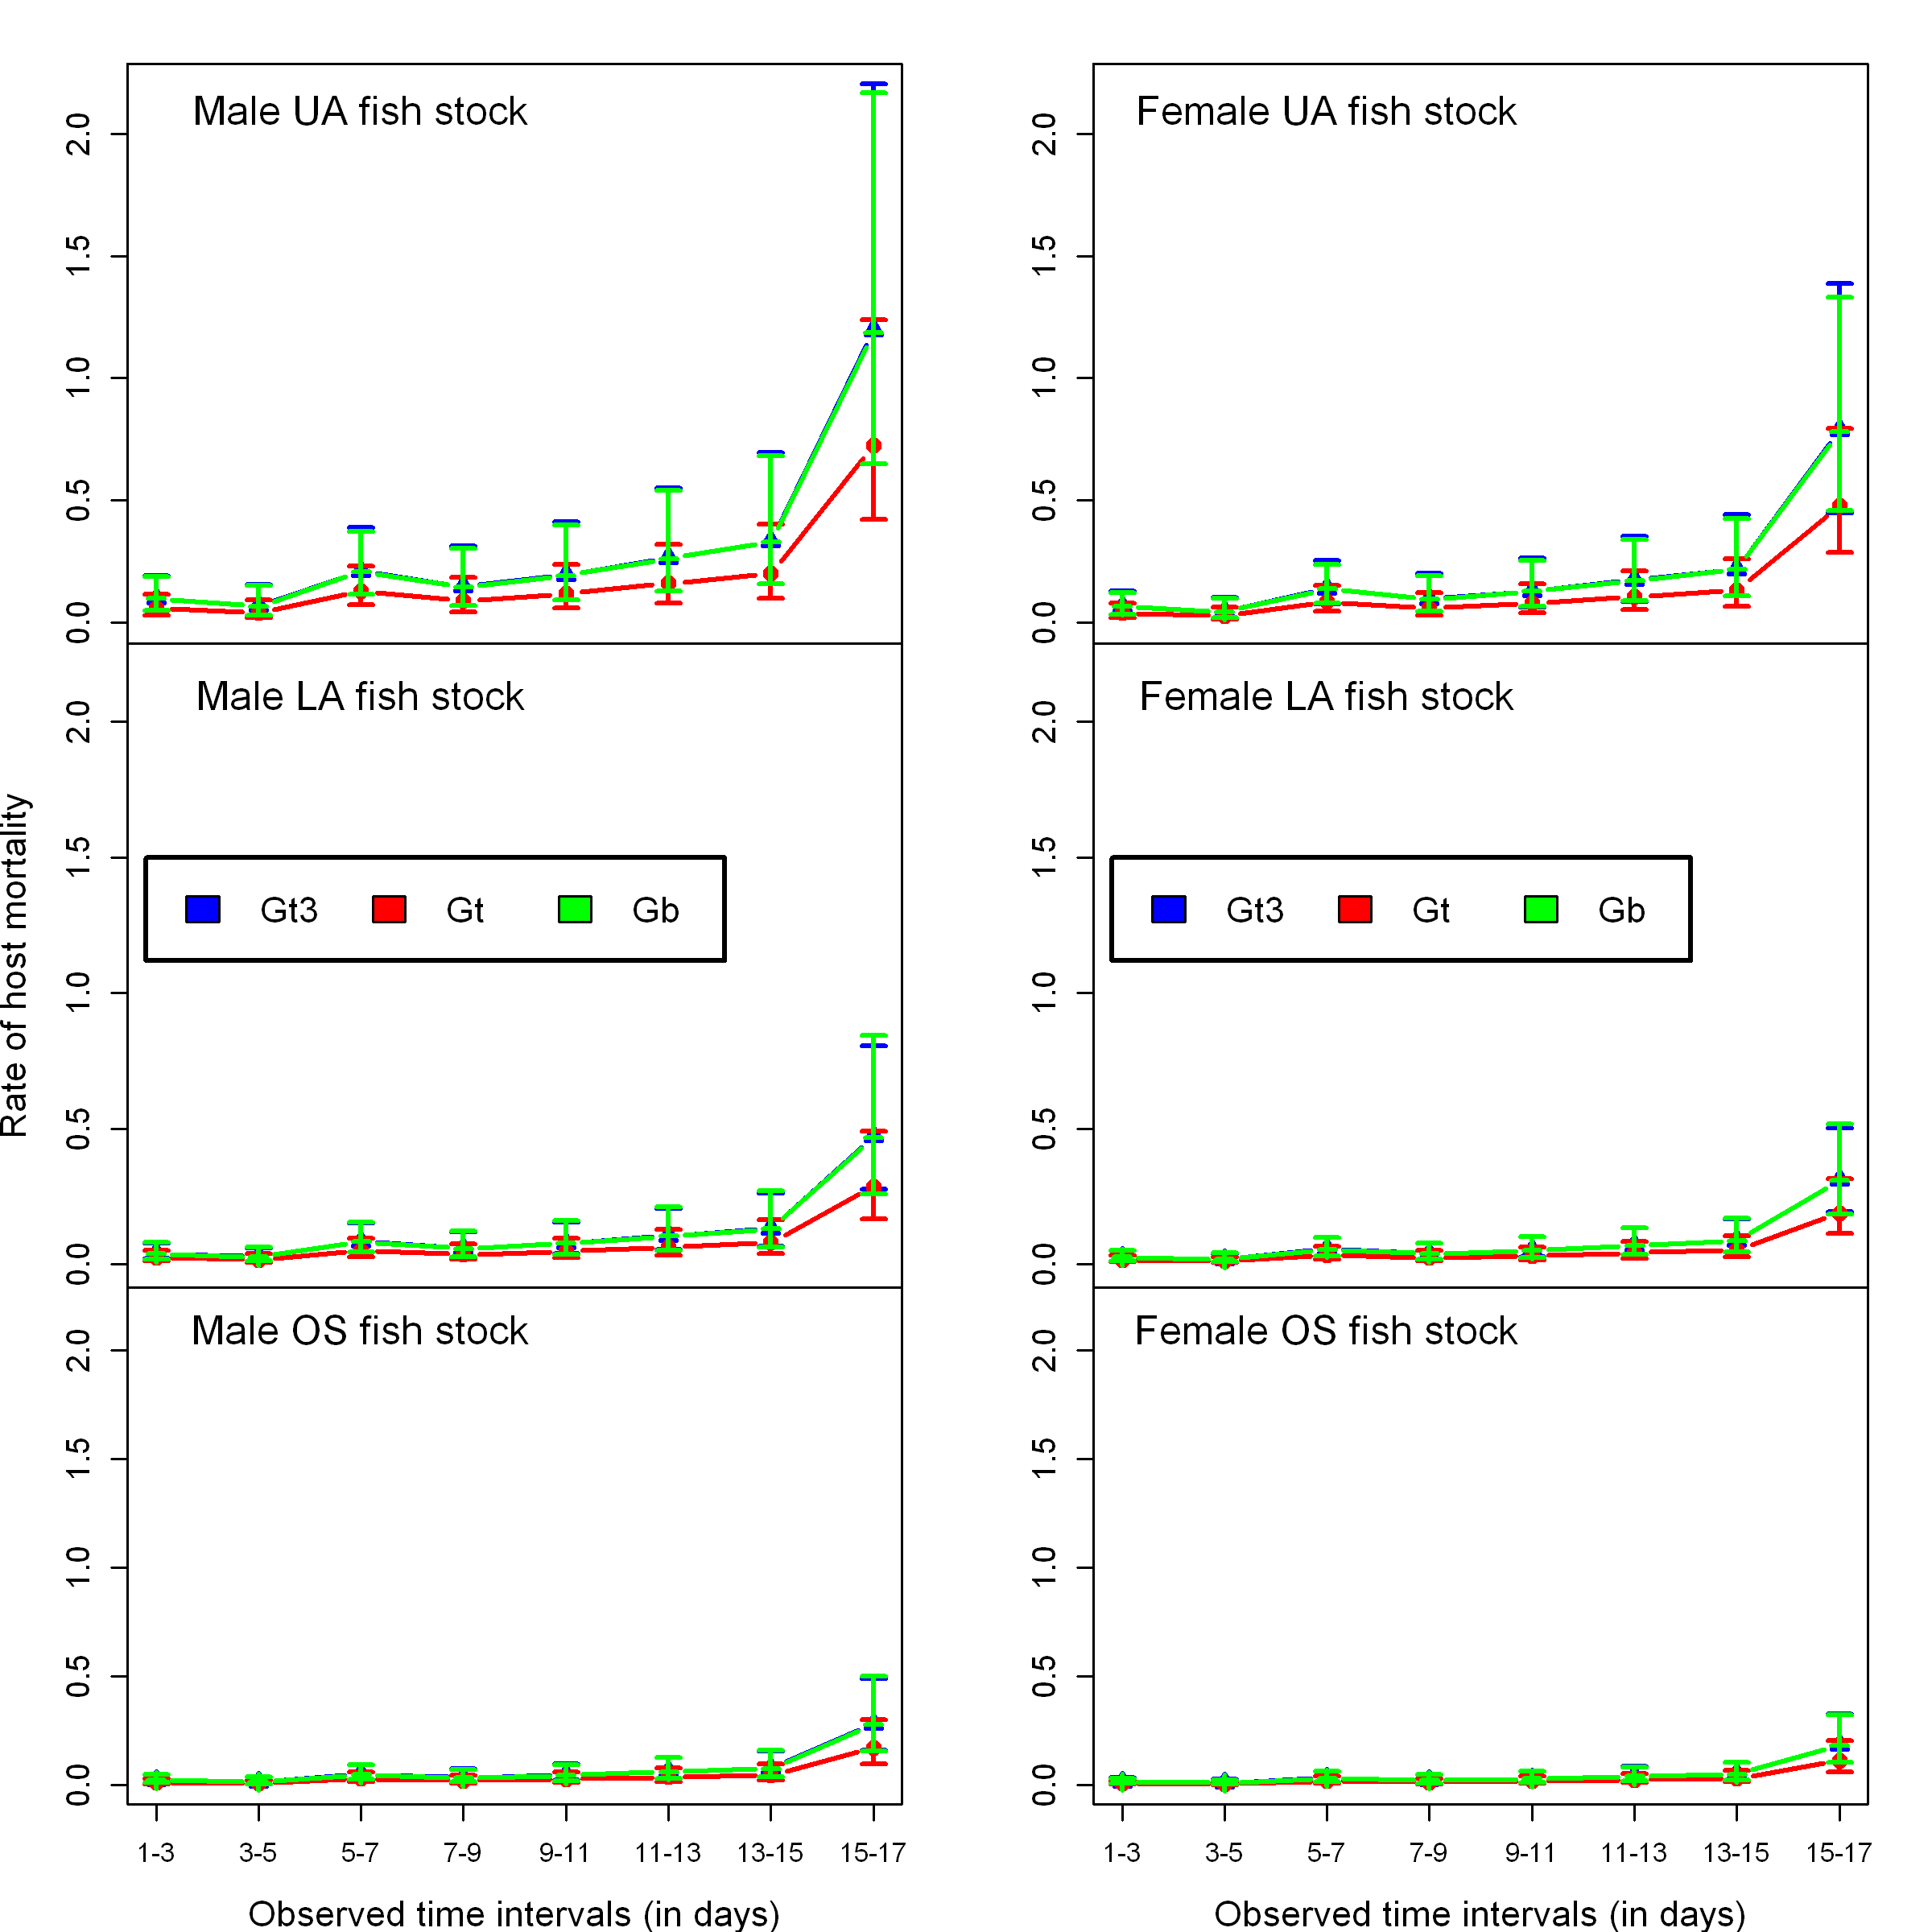

In [48]:
o<-par(mar=c(0,4,2,2))#Run this before the code below

nf<-layout(matrix(1:6, nrow=3,ncol=2))

    
par(o)#
o<-par(mar=c(0,4,2,2)) 

#first half of plot
plot(Gt3_fishType_Deathrate_malefish[1, ,][,1],type="b",col="blue",lwd=2,xaxt = "n",ylab="",xlab="",pch=24,cex.axis=1.2,
     ylim=c(0,2.2))
arrows(x0=1:8, y0=Gt3_fishType_Deathrate_malefish[1, ,][,2], x1=1:8, y1=Gt3_fishType_Deathrate_malefish[1, ,][,3], code=3, 
      angle=90, length=0.05,col ="blue",lwd=2)

lines(Gt_fishType_Deathrate_malefish[1, ,][,1],type="b",col="red",lwd=2,pch=19)
arrows(x0=1:8, y0=Gt_fishType_Deathrate_malefish[1, ,][,2], x1=1:8, y1=Gt_fishType_Deathrate_malefish[1, ,][,3], code=3, 
      angle=90, length=0.05,col ="red",lwd=2)

lines(Gb_fishType_Deathrate_malefish[1, ,][,1],type="b",col="green",lwd=2,pch=3)
arrows(x0=1:8, y0=Gb_fishType_Deathrate_malefish[1, ,][,2], x1=1:8, y1=Gb_fishType_Deathrate_malefish[1, ,][,3], code=3, 
      angle=90, length=0.05,col ="green",lwd=2)

text(3,2.1,"Male UA fish stock",cex=1.5,lwd=3)


o<-par(mar=c(0,4,0,2))
plot(Gt3_fishType_Deathrate_malefish[2, ,][,1],type="b",col="blue",lwd=2,xaxt = "n",ylab="",xlab="",
     ylim=c(0,2.2),pch=24,cex.lab=1.4, cex.axis=1.2)
arrows(x0=1:8, y0=Gt3_fishType_Deathrate_malefish[2, ,][,2], x1=1:8, y1=Gt3_fishType_Deathrate_malefish[2, ,][,3], code=3, 
      angle=90, length=0.05,col ="blue",lwd=2)

lines(Gt_fishType_Deathrate_malefish[2, ,][,1],type="b",col="red",lwd=2,pch=19)
arrows(x0=1:8, y0=Gt_fishType_Deathrate_malefish[2, ,][,2], x1=1:8, y1=Gt_fishType_Deathrate_malefish[2, ,][,3], code=3, 
      angle=90, length=0.05,col ="red",lwd=2)

lines(Gb_fishType_Deathrate_malefish[2, ,][,1],type="b",col="green",lwd=2,pch=3)
arrows(x0=1:8, y0=Gb_fishType_Deathrate_malefish[2, ,][,2], x1=1:8, y1=Gb_fishType_Deathrate_malefish[2, ,][,3], code=3, 
      angle=90, length=0.05,col ="green",lwd=2)

legend(x = .9,y=1.5,inset = 0,
        legend = c("Gt3","Gt","Gb"), 
        col=c("blue","red","green"), cex=1.35, horiz = TRUE,pt.cex = 1,
       box.lwd = 2,fill=c("blue","red","green"))




text(3,2.1,"Male LA fish stock",cex=1.5,lwd=3)


mtext(text = "Rate of host mortality",
      side = 2,#side 2 = left
      line = 3,cex=.9)

par(mar=c(4,4,0,2))

plot(Gt3_fishType_Deathrate_malefish[3, ,][,1],type="b",col="blue",lwd=2,xaxt = "n",ylab="",xlab="",
     pch=24,cex.lab=1.4, cex.axis=1.2,ylim=c(0,2.2))
arrows(x0=1:8, y0=Gt3_fishType_Deathrate_malefish[3, ,][,2], x1=1:8, y1=Gt3_fishType_Deathrate_malefish[3, ,][,3], code=3, 
      angle=90, length=0.05,col ="blue",lwd=2)


lines(Gt_fishType_Deathrate_malefish[3, ,][,1],type="b",col="red",lwd=2,pch=19)
arrows(x0=1:8, y0=Gt_fishType_Deathrate_malefish[3, ,][,2], x1=1:8, y1=Gt_fishType_Deathrate_malefish[3, ,][,3], code=3, 
      angle=90, length=0.05,col ="red",lwd=2)

lines(Gb_fishType_Deathrate_malefish[3, ,][,1],type="b",col="green",lwd=2,pch=3)
arrows(x0=1:8, y0=Gb_fishType_Deathrate_malefish[3, ,][,2], x1=1:8, y1=Gb_fishType_Deathrate_malefish[3, ,][,3], code=3, 
      angle=90, length=0.05,col ="green",lwd=2)

axis(1, at=1:8, labels=c("1-3","3-5","5-7","7-9","9-11","11-13","13-15","15-17"))
text(3,2.1,"Male OS fish stock",cex=1.5,lwd=3)

mtext(text = "Observed time intervals (in days)",
      side = 1,#side 1 = bottom
      line = 3,cex=.9)



#second half of plot
o<-par(mar=c(0,4,2,2))

plot(Gt3_fishType_Deathrate_femalefish[1, ,][,1],type="b",col="blue",lwd=2,xaxt = "n",ylab="",xlab="",pch=24,cex.axis=1.2,
     ylim=c(0,2.2))
arrows(x0=1:8, y0=Gt3_fishType_Deathrate_femalefish[1, ,][,2], x1=1:8, y1=Gt3_fishType_Deathrate_femalefish[1, ,][,3], code=3, 
      angle=90, length=0.05,col ="blue",lwd=2)

lines(Gt_fishType_Deathrate_femalefish[1, ,][,1],type="b",col="red",lwd=2,pch=19)
arrows(x0=1:8, y0=Gt_fishType_Deathrate_femalefish[1, ,][,2], x1=1:8, y1=Gt_fishType_Deathrate_femalefish[1, ,][,3], code=3, 
      angle=90, length=0.05,col ="red",lwd=2)

lines(Gb_fishType_Deathrate_femalefish[1, ,][,1],type="b",col="green",lwd=2,pch=3)
arrows(x0=1:8, y0=Gb_fishType_Deathrate_femalefish[1, ,][,2], x1=1:8, y1=Gb_fishType_Deathrate_femalefish[1, ,][,3], code=3, 
      angle=90, length=0.05,col ="green",lwd=2)

text(3,2.1,"Female UA fish stock",cex=1.5,lwd=3)


o<-par(mar=c(0,4,0,2))
plot(Gt3_fishType_Deathrate_femalefish[2, ,][,1],type="b",col="blue",lwd=2,xaxt = "n",ylab="",xlab="",
     ylim=c(0,2.2),pch=24,cex.lab=1.4, cex.axis=1.2)
arrows(x0=1:8, y0=Gt3_fishType_Deathrate_femalefish[2, ,][,2], x1=1:8, y1=Gt3_fishType_Deathrate_femalefish[2, ,][,3], code=3, 
      angle=90, length=0.05,col ="blue",lwd=2)

lines(Gt_fishType_Deathrate_femalefish[2, ,][,1],type="b",col="red",lwd=2,pch=19)
arrows(x0=1:8, y0=Gt_fishType_Deathrate_femalefish[2, ,][,2], x1=1:8, y1=Gt_fishType_Deathrate_femalefish[2, ,][,3], code=3, 
      angle=90, length=0.05,col ="red",lwd=2)

lines(Gb_fishType_Deathrate_femalefish[2, ,][,1],type="b",col="green",lwd=2,pch=3)
arrows(x0=1:8, y0=Gb_fishType_Deathrate_femalefish[2, ,][,2], x1=1:8, y1=Gb_fishType_Deathrate_femalefish[2, ,][,3], code=3, 
      angle=90, length=0.05,col ="green",lwd=2)

legend(x = .9,y=1.5,,inset = 0,
        legend = c("Gt3","Gt","Gb"), 
        col=c("blue","red","green"), cex=1.35, horiz = TRUE,pt.cex = 1,
       box.lwd = 2,fill=c("blue","red","green"))

text(3,2.1,"Female LA fish stock",cex=1.5,lwd=3)

#mtext(text = "Predicted host mortality rate",
 #     side = 2,#side 2 = left
 #     line = 3,cex=.9)

par(mar=c(4,4,0,2))

plot(Gt3_fishType_Deathrate_femalefish[3, ,][,1],type="b",col="blue",lwd=2,xaxt = "n",ylab="",xlab="",
     pch=24,cex.lab=1.4, cex.axis=1.2,ylim=c(0,2.2))
arrows(x0=1:8, y0=Gt3_fishType_Deathrate_femalefish[3, ,][,2], x1=1:8, y1=Gt3_fishType_Deathrate_femalefish[3, ,][,3], code=3, 
      angle=90, length=0.05,col ="blue",lwd=2)


lines(Gt_fishType_Deathrate_femalefish[3, ,][,1],type="b",col="red",lwd=2,pch=19)
arrows(x0=1:8, y0=Gt_fishType_Deathrate_femalefish[3, ,][,2], x1=1:8, y1=Gt_fishType_Deathrate_femalefish[3, ,][,3], code=3, 
      angle=90, length=0.05,col ="red",lwd=2)

lines(Gb_fishType_Deathrate_femalefish[3, ,][,1],type="b",col="green",lwd=2,pch=3)
arrows(x0=1:8, y0=Gb_fishType_Deathrate_femalefish[3, ,][,2], x1=1:8, y1=Gb_fishType_Deathrate_femalefish[3, ,][,3], code=3, 
      angle=90, length=0.05,col ="green",lwd=2)

axis(1, at=1:8, labels=c("1-3","3-5","5-7","7-9","9-11","11-13","13-15","15-17"))
text(3,2.1,"Female OS fish stock",cex=1.5,lwd=3)

mtext(text = "Observed time intervals (in days)",
      side = 1,#side 1 = bottom
      line = 3,cex=.9)

par(o)

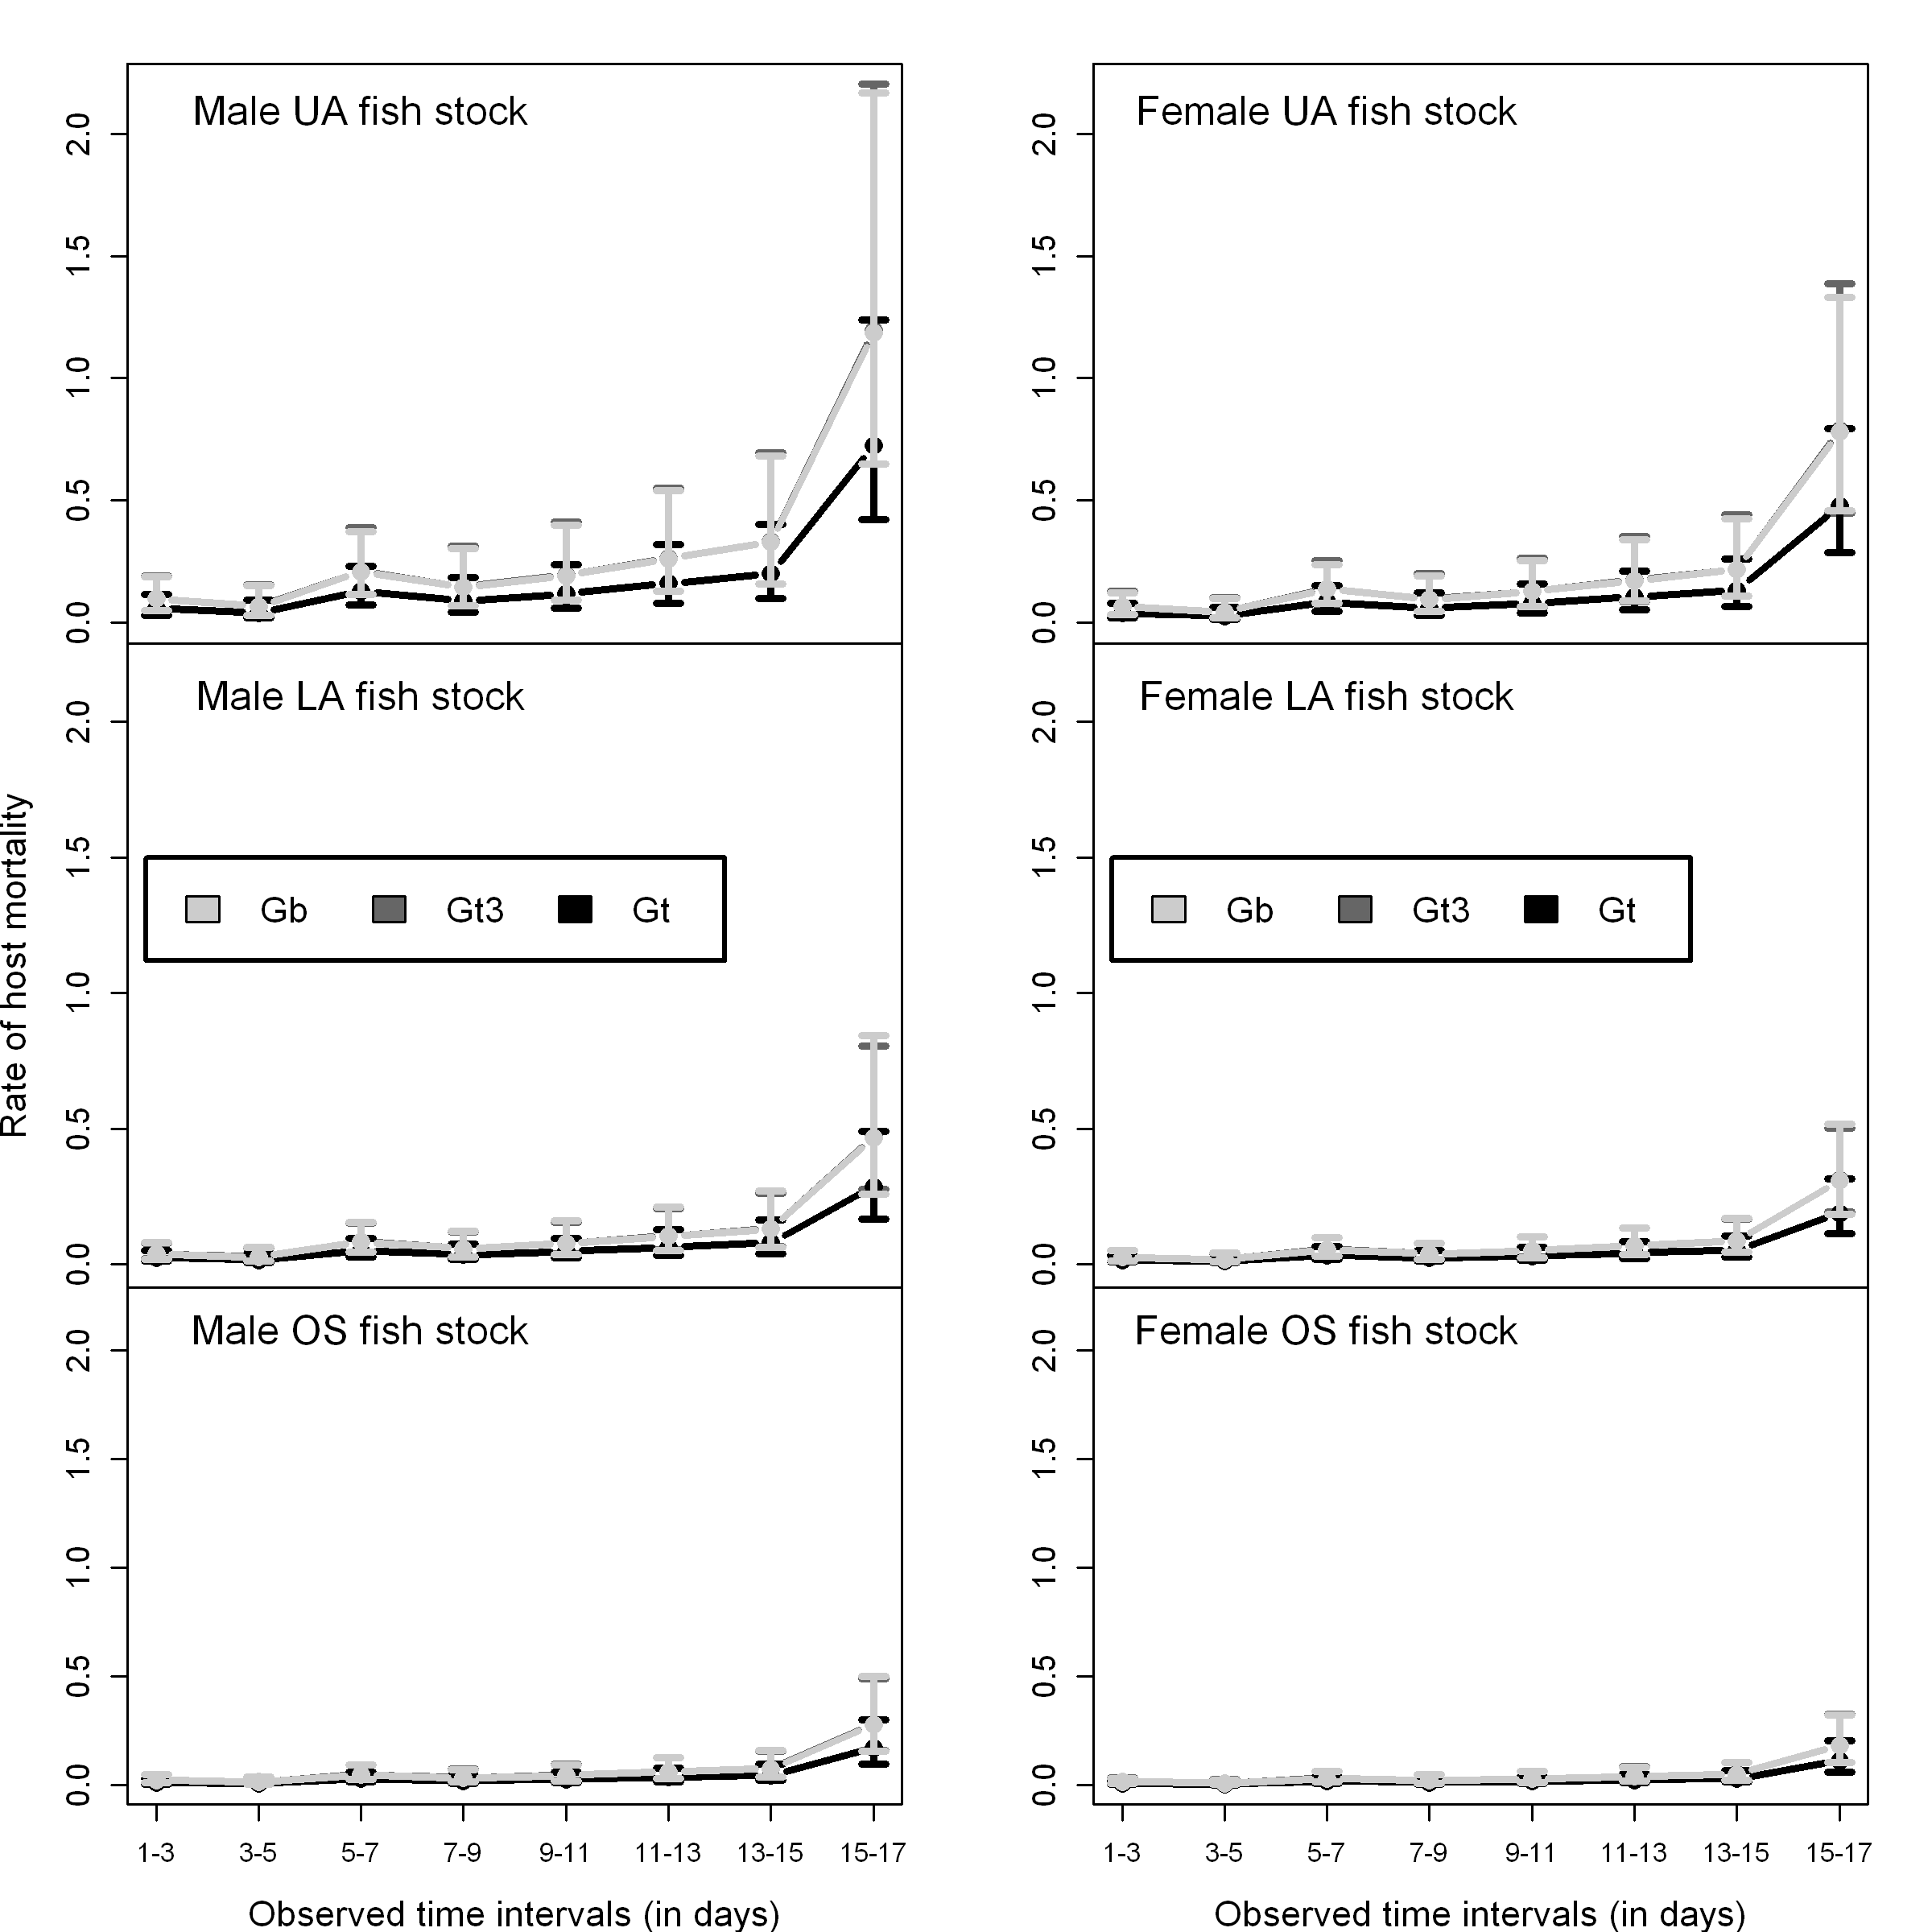

In [99]:
o<-par(mar=c(0,4,2,2))#Run this before the code below

nf<-layout(matrix(1:6, nrow=3,ncol=2))

 
par(o)#
o<-par(mar=c(0,4,2,2)) 

#first half of plot
plot(Gt3_fishType_Deathrate_malefish[1, ,][,1],type="b",col="grey40",lwd=3,xaxt = "n",ylab="",xlab="",cex.axis=1.2,
     ylim=c(0,2.2))
arrows(x0=1:8, y0=Gt3_fishType_Deathrate_malefish[1, ,][,2], x1=1:8, y1=Gt3_fishType_Deathrate_malefish[1, ,][,3], code=3, 
      angle=90, length=0.05,col ="grey40",lwd=3)

lines(Gt_fishType_Deathrate_malefish[1, ,][,1],type="b",col="grey0",lwd=3)
arrows(x0=1:8, y0=Gt_fishType_Deathrate_malefish[1, ,][,2], x1=1:8, y1=Gt_fishType_Deathrate_malefish[1, ,][,3], code=3, 
      angle=90, length=0.05,col ="grey0",lwd=3)

lines(Gb_fishType_Deathrate_malefish[1, ,][,1],type="b",col="grey80",lwd=3)
arrows(x0=1:8, y0=Gb_fishType_Deathrate_malefish[1, ,][,2], x1=1:8, y1=Gb_fishType_Deathrate_malefish[1, ,][,3], code=3, 
      angle=90, length=0.05,col ="grey80",lwd=3)

text(3,2.1,"Male UA fish stock",cex=1.5,lwd=3)


o<-par(mar=c(0,4,0,2))
plot(Gt3_fishType_Deathrate_malefish[2, ,][,1],type="b",col="grey40",lwd=3,xaxt = "n",ylab="",xlab="",
     ylim=c(0,2.2),cex.lab=1.4, cex.axis=1.2)
arrows(x0=1:8, y0=Gt3_fishType_Deathrate_malefish[2, ,][,2], x1=1:8, y1=Gt3_fishType_Deathrate_malefish[2, ,][,3], code=3, 
      angle=90, length=0.05,col ="grey40",lwd=3)

lines(Gt_fishType_Deathrate_malefish[2, ,][,1],type="b",col="grey0",lwd=3)
arrows(x0=1:8, y0=Gt_fishType_Deathrate_malefish[2, ,][,2], x1=1:8, y1=Gt_fishType_Deathrate_malefish[2, ,][,3], code=3, 
      angle=90, length=0.05,col ="grey0",lwd=3)

lines(Gb_fishType_Deathrate_malefish[2, ,][,1],type="b",col="grey80",lwd=3)
arrows(x0=1:8, y0=Gb_fishType_Deathrate_malefish[2, ,][,2], x1=1:8, y1=Gb_fishType_Deathrate_malefish[2, ,][,3], code=3, 
      angle=90, length=0.05,col ="grey80",lwd=3)

legend(x = .9,y=1.5,,inset = 0,
        legend = c("Gb","Gt3","Gt"), 
        col=c("grey80","grey40","grey0"), cex=1.35, horiz = TRUE,pt.cex = 1,
      box.lwd = 2,
       fill=c("grey80","grey40","grey0"))

text(3,2.1,"Male LA fish stock",cex=1.5,lwd=3)


mtext(text = "Rate of host mortality",
      side = 2,#side 2 = left
      line = 3,cex=.9)

par(mar=c(4,4,0,2))

plot(Gt3_fishType_Deathrate_malefish[3, ,][,1],type="b",col="grey40",lwd=3,xaxt = "n",ylab="",xlab=""
     ,cex.lab=1.4, cex.axis=1.2,ylim=c(0,2.2))
arrows(x0=1:8, y0=Gt3_fishType_Deathrate_malefish[3, ,][,2], x1=1:8, y1=Gt3_fishType_Deathrate_malefish[3, ,][,3], code=3, 
      angle=90, length=0.05,col ="grey40",lwd=3)


lines(Gt_fishType_Deathrate_malefish[3, ,][,1],type="b",col="grey0",lwd=3)
arrows(x0=1:8, y0=Gt_fishType_Deathrate_malefish[3, ,][,2], x1=1:8, y1=Gt_fishType_Deathrate_malefish[3, ,][,3], code=3, 
      angle=90, length=0.05,col ="grey0",lwd=3)

lines(Gb_fishType_Deathrate_malefish[3, ,][,1],type="b",col="grey80",lwd=3)
arrows(x0=1:8, y0=Gb_fishType_Deathrate_malefish[3, ,][,2], x1=1:8, y1=Gb_fishType_Deathrate_malefish[3, ,][,3], code=3, 
      angle=90, length=0.05,col ="grey80",lwd=3)

axis(1, at=1:8, labels=c("1-3","3-5","5-7","7-9","9-11","11-13","13-15","15-17"))
text(3,2.1,"Male OS fish stock",cex=1.5,lwd=3)

mtext(text = "Observed time intervals (in days)",
      side = 1,#side 1 = bottom
      line = 3,cex=.9)



#second half of plot
o<-par(mar=c(0,4,2,2))

plot(Gt3_fishType_Deathrate_femalefish[1, ,][,1],type="b",col="grey40",lwd=3,xaxt = "n",ylab="",xlab="",cex.axis=1.2,
     ylim=c(0,2.2))
arrows(x0=1:8, y0=Gt3_fishType_Deathrate_femalefish[1, ,][,2], x1=1:8, y1=Gt3_fishType_Deathrate_femalefish[1, ,][,3], code=3, 
      angle=90, length=0.05,col ="grey40",lwd=3)

lines(Gt_fishType_Deathrate_femalefish[1, ,][,1],type="b",col="grey0",lwd=3)
arrows(x0=1:8, y0=Gt_fishType_Deathrate_femalefish[1, ,][,2], x1=1:8, y1=Gt_fishType_Deathrate_femalefish[1, ,][,3], code=3, 
      angle=90, length=0.05,col ="grey0",lwd=3)

lines(Gb_fishType_Deathrate_femalefish[1, ,][,1],type="b",col="grey80",lwd=3)
arrows(x0=1:8, y0=Gb_fishType_Deathrate_femalefish[1, ,][,2], x1=1:8, y1=Gb_fishType_Deathrate_femalefish[1, ,][,3], code=3, 
      angle=90, length=0.05,col ="grey80",lwd=3)

text(3,2.1,"Female UA fish stock",cex=1.5,lwd=3)


o<-par(mar=c(0,4,0,2))
plot(Gt3_fishType_Deathrate_femalefish[2, ,][,1],type="b",col="grey40",lwd=3,xaxt = "n",ylab="",xlab="",
     ylim=c(0,2.2),cex.lab=1.4, cex.axis=1.2)
arrows(x0=1:8, y0=Gt3_fishType_Deathrate_femalefish[2, ,][,2], x1=1:8, y1=Gt3_fishType_Deathrate_femalefish[2, ,][,3], code=3, 
      angle=90, length=0.05,col ="grey40",lwd=3)

lines(Gt_fishType_Deathrate_femalefish[2, ,][,1],type="b",col="grey0",lwd=3)
arrows(x0=1:8, y0=Gt_fishType_Deathrate_femalefish[2, ,][,2], x1=1:8, y1=Gt_fishType_Deathrate_femalefish[2, ,][,3], code=3, 
      angle=90, length=0.05,col ="grey0",lwd=3)

lines(Gb_fishType_Deathrate_femalefish[2, ,][,1],type="b",col="grey80",lwd=3)
arrows(x0=1:8, y0=Gb_fishType_Deathrate_femalefish[2, ,][,2], x1=1:8, y1=Gb_fishType_Deathrate_femalefish[2, ,][,3], code=3, 
      angle=90, length=0.05,col ="grey80",lwd=3)

legend(x = .9,y=1.5,,inset = 0,
        legend = c("Gb","Gt3","Gt"), 
        col=c("grey80","grey40","grey0"), cex=1.35, horiz = TRUE,pt.cex = 1,
     box.lwd = 2,fill=c("grey80","grey40","grey0"))



text(3,2.1,"Female LA fish stock",cex=1.5,lwd=3)

#mtext(text = "Predicted host mortality rate",
 #     side = 2,#side 2 = left
 #     line = 3,cex=.9)

par(mar=c(4,4,0,2))

plot(Gt3_fishType_Deathrate_femalefish[3, ,][,1],type="b",col="grey40",lwd=3,xaxt = "n",ylab="",xlab=""
     ,cex.lab=1.4, cex.axis=1.2,ylim=c(0,2.2))
arrows(x0=1:8, y0=Gt3_fishType_Deathrate_femalefish[3, ,][,2], x1=1:8, y1=Gt3_fishType_Deathrate_femalefish[3, ,][,3], code=3, 
      angle=90, length=0.05,col ="grey40",lwd=3)


lines(Gt_fishType_Deathrate_femalefish[3, ,][,1],type="b",col="grey0",lwd=3)
arrows(x0=1:8, y0=Gt_fishType_Deathrate_femalefish[3, ,][,2], x1=1:8, y1=Gt_fishType_Deathrate_femalefish[3, ,][,3], code=3, 
      angle=90, length=0.05,col ="grey0",lwd=3)

lines(Gb_fishType_Deathrate_femalefish[3, ,][,1],type="b",col="grey80",lwd=3)
arrows(x0=1:8, y0=Gb_fishType_Deathrate_femalefish[3, ,][,2], x1=1:8, y1=Gb_fishType_Deathrate_femalefish[3, ,][,3], code=3, 
      angle=90, length=0.05,col ="grey80",lwd=3)

axis(1, at=1:8, labels=c("1-3","3-5","5-7","7-9","9-11","11-13","13-15","15-17"))
text(3,2.1,"Female OS fish stock",cex=1.5,lwd=3)

mtext(text = "Observed time intervals (in days)",
      side = 1,#side 1 = bottom
      line = 3,cex=.9)

par(o)

# Plot of predicted rate of recovery of each parasite strain across the fish type

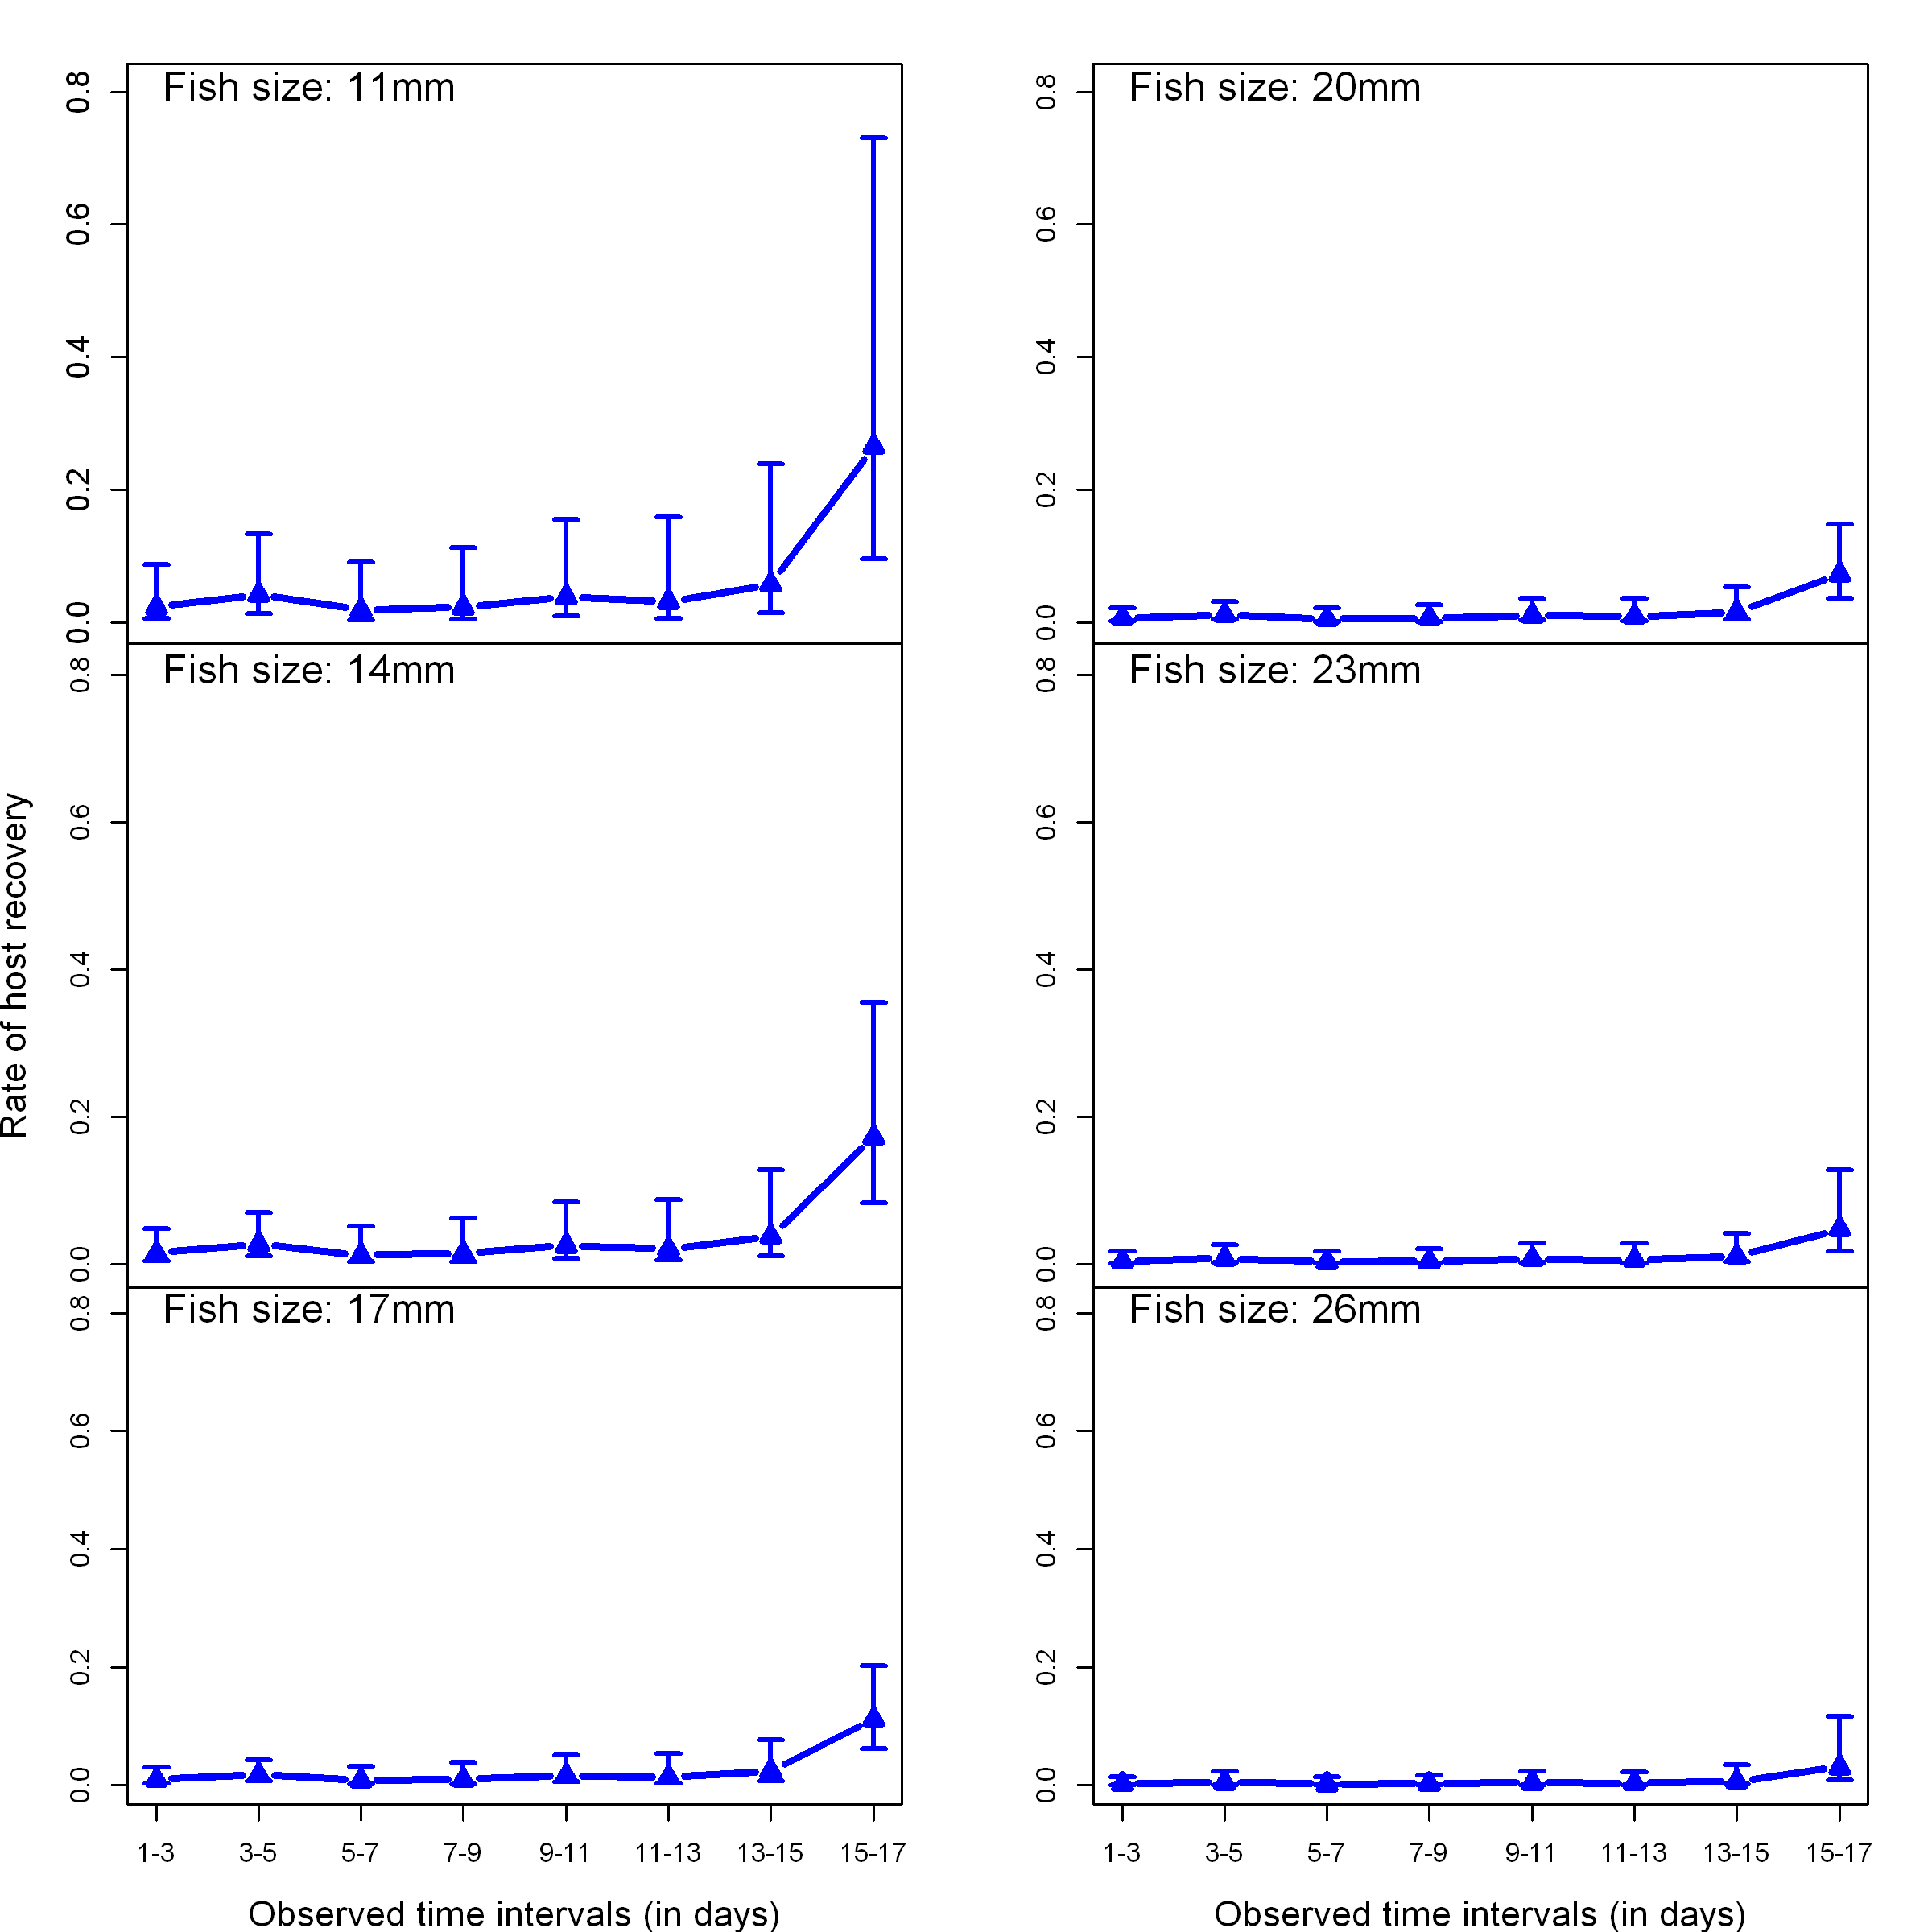

In [64]:
o<-par(mar=c(0,4,2,2))#Run this before the code below

nf<-layout(matrix(1:6, nrow=3,ncol=2))

par(o)#
o<-par(mar=c(0,4,2,2))

#first half of plot
plot(Recoveryrate_fishsize[1, ,][,1],type="b",col="blue",lwd=3,xaxt = "n",ylab="",xlab="",
     ylim=c(0,.81),pch=24,cex.lab=1.4, cex.axis=1.2)
arrows(x0=1:8, y0=Recoveryrate_fishsize[1, ,][,2], x1=1:8, y1=Recoveryrate_fishsize[1, ,][,3], code=3, 
      angle=90, length=0.05,col ="blue",lwd=2)
text(2.5,.81,"Fish size: 11mm",cex=1.5,lwd=3)

o<-par(mar=c(0,4,0,2))
plot(Recoveryrate_fishsize[2, ,][,1],type="b",col="blue",lwd=3,pch=24,xaxt = "n",ylab="",xlab="",ylim=c(0,.81))
arrows(x0=1:8, y0=Recoveryrate_fishsize[2, ,][,2], x1=1:8, y1=Recoveryrate_fishsize[2, ,][,3], code=3, 
      angle=90, length=0.05,col ="blue",lwd=2)
text(2.5,.81,"Fish size: 14mm",cex=1.5,lwd=3)

mtext(text = "Rate of host recovery",
      side = 2,#side left
      line = 3,cex=.9)

par(mar=c(4,4,0,2))
plot(Recoveryrate_fishsize[3, ,][,1],type="b",col="blue",lwd=3,pch=24,xaxt = "n",ylab="",
     xlab="",ylim=c(0,.81))
arrows(x0=1:8, y0=Recoveryrate_fishsize[3, ,][,2], x1=1:8, y1=Recoveryrate_fishsize[3, ,][,3], code=3, 
      angle=90, length=0.05,col ="blue",lwd=2)
axis(1, at=1:8, labels=c("1-3","3-5","5-7","7-9","9-11","11-13","13-15","15-17"))

text(2.5,.81,"Fish size: 17mm",cex=1.5,lwd=3)
mtext(text = "Observed time intervals (in days)",
      side = 1,#side 1 = bottom
      line = 3,cex=.9)

#second half of plot
o<-par(mar=c(0,4,2,2))
plot(Recoveryrate_fishsize[4, ,][,1],type="b",col="blue",lwd=3,pch=24,xaxt = "n",ylab="",xlab="",ylim=c(0,.81))
arrows(x0=1:8, y0=Recoveryrate_fishsize[4, ,][,2], x1=1:8, y1=Recoveryrate_fishsize[4, ,][,3], code=3, 
      angle=90, length=0.05,col ="blue",lwd=2)
text(2.5,.81,"Fish size: 20mm",cex=1.5,lwd=3)

o<-par(mar=c(0,4,0,2))
plot(Recoveryrate_fishsize[5, ,][,1],type="b",col="blue",lwd=3,pch=24,xaxt = "n",ylab="",xlab="",ylim=c(0,.81))
arrows(x0=1:8, y0=Recoveryrate_fishsize[5, ,][,2], x1=1:8, y1=Recoveryrate_fishsize[5, ,][,3], code=3, 
      angle=90, length=0.05,col ="blue",lwd=2)
text(2.5,.81,"Fish size: 23mm",cex=1.5,lwd=3)

par(mar=c(4,4,0,2))
plot(Recoveryrate_fishsize[6, ,][,1],type="b",col="blue",lwd=3,pch=24,xaxt = "n",ylab="",
     xlab="",ylim=c(0,.81))
arrows(x0=1:8, y0=Recoveryrate_fishsize[6, ,][,2], x1=1:8, y1=Recoveryrate_fishsize[6, ,][,3], code=3, 
      angle=90, length=0.05,col ="blue",lwd=2)
axis(1, at=1:8, labels=c("1-3","3-5","5-7","7-9","9-11","11-13","13-15","15-17"))

text(2.5,.81,"Fish size: 26mm",cex=1.5,lwd=3)
mtext(text = "Observed time intervals (in days)",
      side = 1,#side 1 = bottom
      line = 3,cex=.9)



par(o)

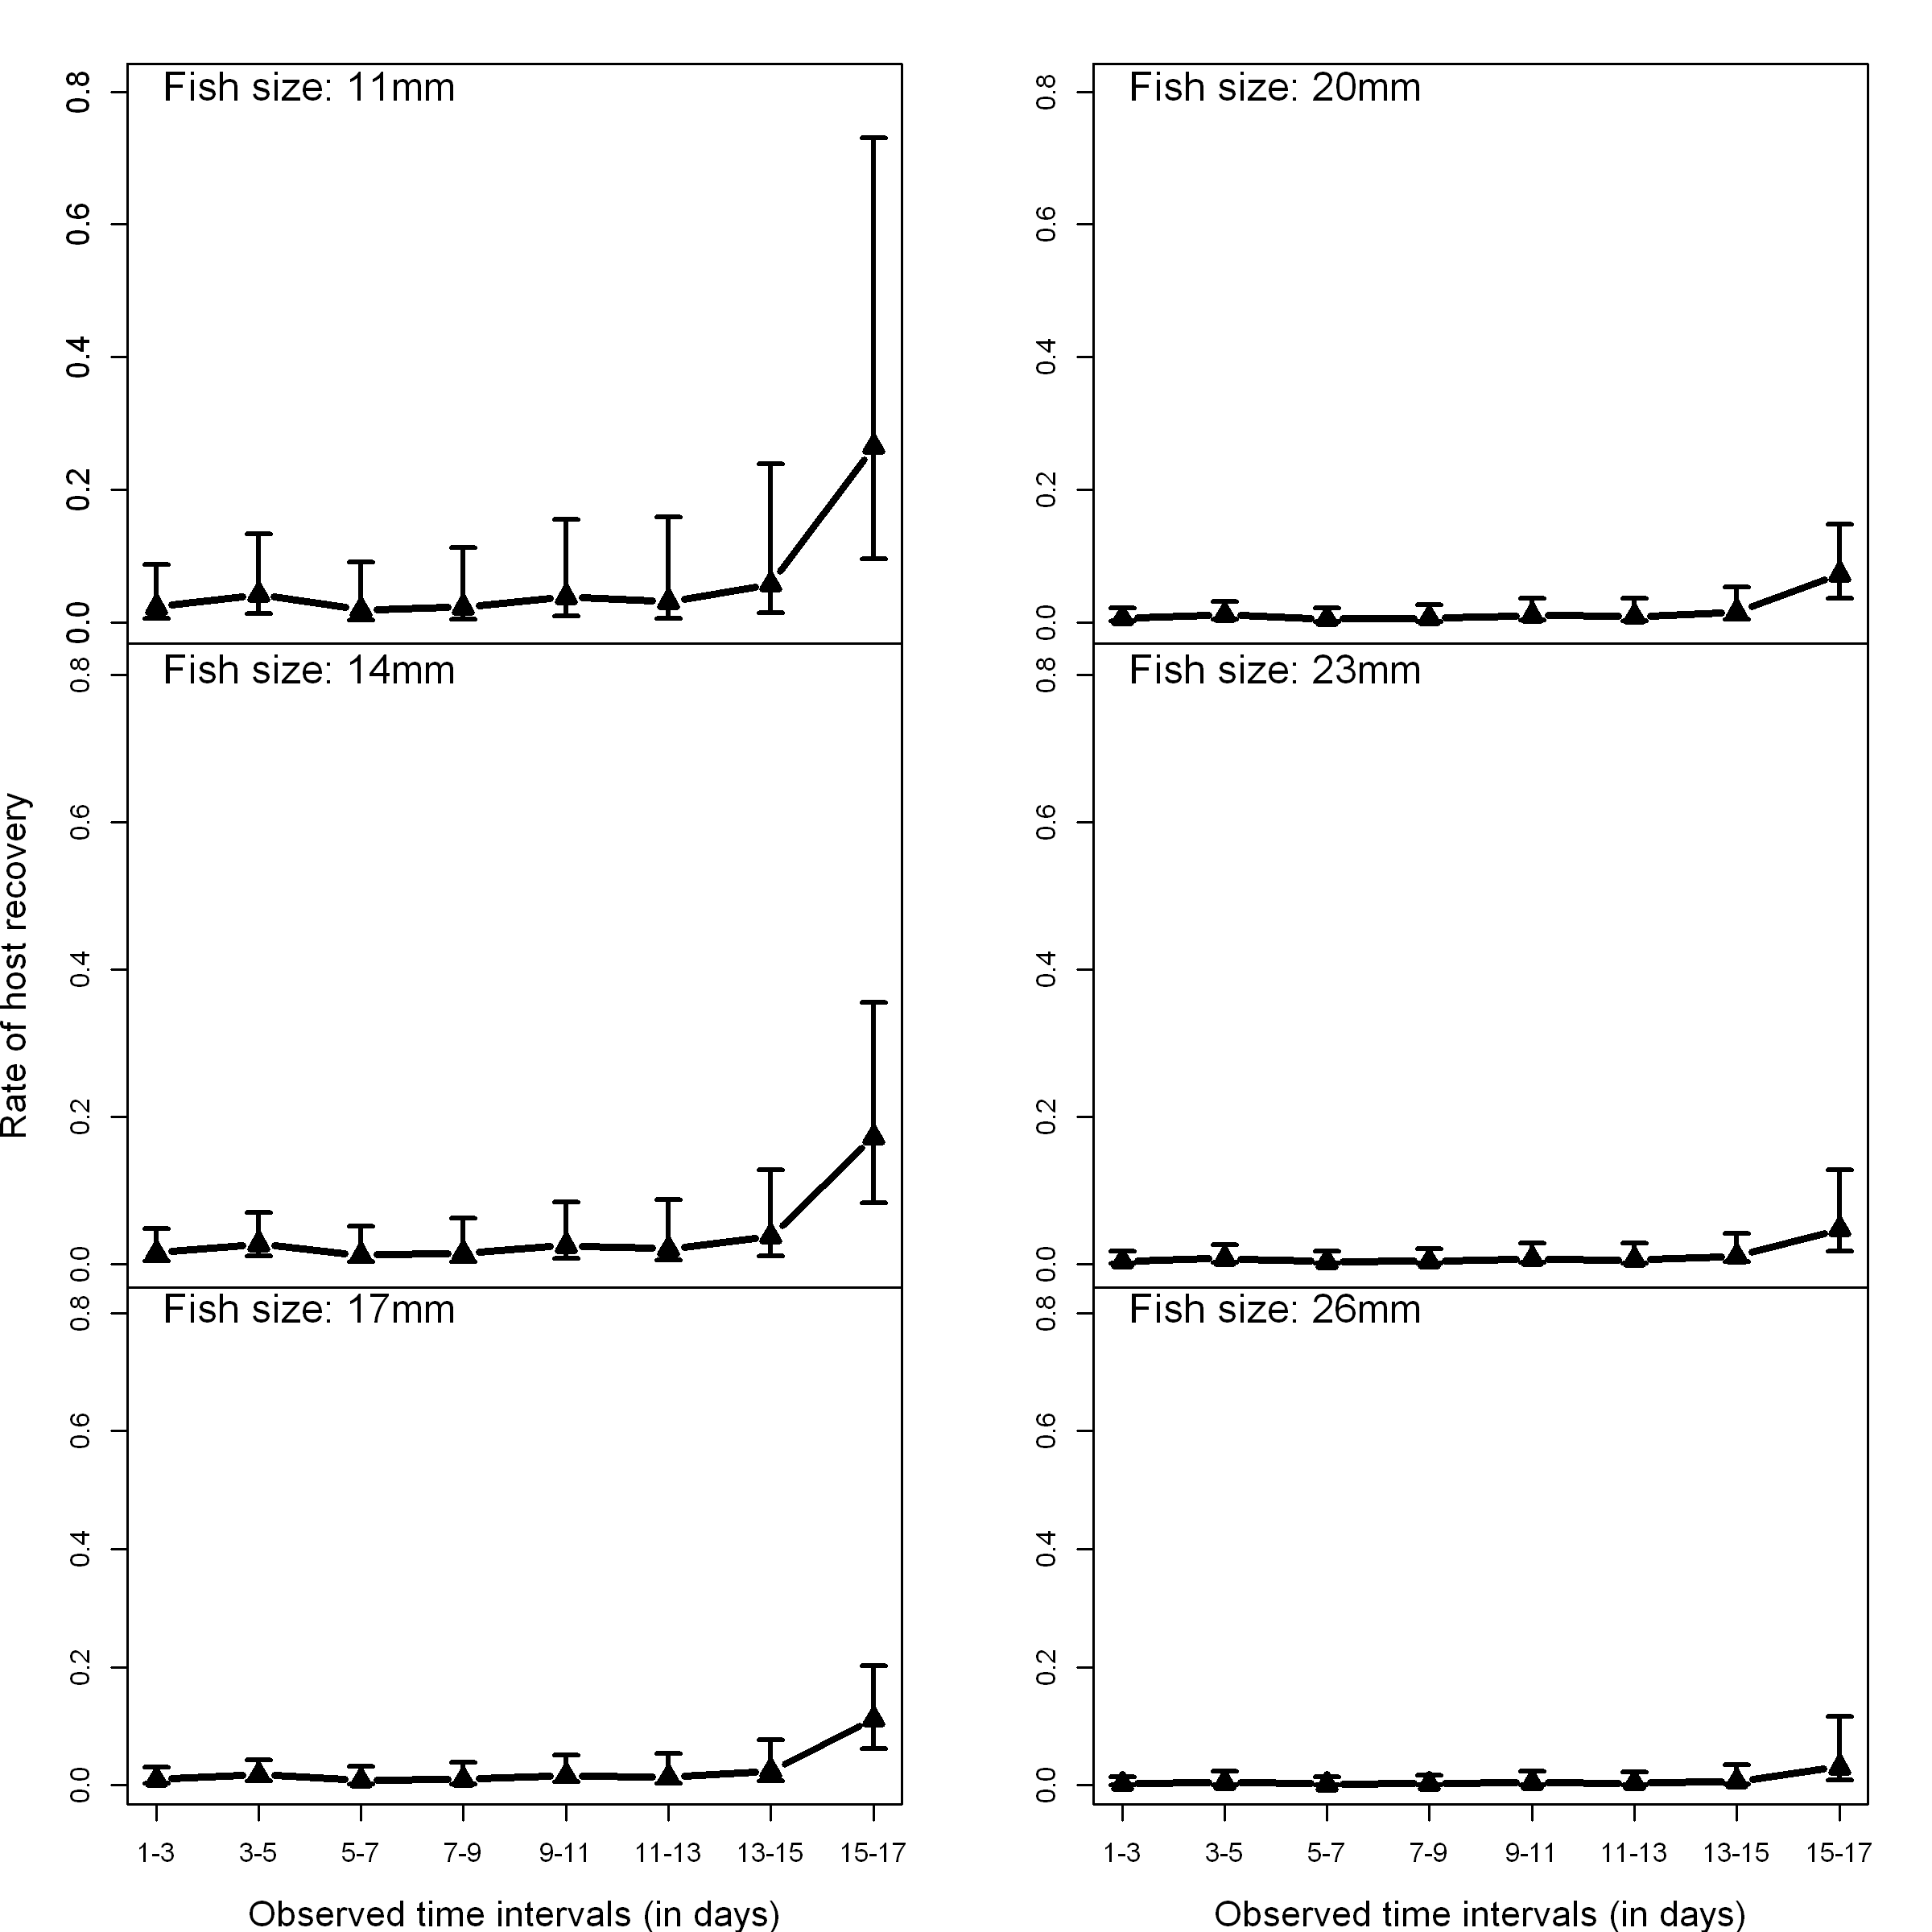

In [71]:
o<-par(mar=c(0,4,2,2))#Run this before the code below

nf<-layout(matrix(1:6, nrow=3,ncol=2))

par(o)#
o<-par(mar=c(0,4,2,2))

#first half of plot
plot(Recoveryrate_fishsize[1, ,][,1],type="b",col="black",lwd=3,xaxt = "n",ylab="",xlab="",
     ylim=c(0,.81),pch=24,cex.lab=1.4, cex.axis=1.2)
arrows(x0=1:8, y0=Recoveryrate_fishsize[1, ,][,2], x1=1:8, y1=Recoveryrate_fishsize[1, ,][,3], code=3, 
      angle=90, length=0.05,col ="black",lwd=2)
text(2.5,.81,"Fish size: 11mm",cex=1.5,lwd=3)

o<-par(mar=c(0,4,0,2))
plot(Recoveryrate_fishsize[2, ,][,1],type="b",col="black",lwd=3,pch=24,xaxt = "n",ylab="",xlab="",ylim=c(0,.81))
arrows(x0=1:8, y0=Recoveryrate_fishsize[2, ,][,2], x1=1:8, y1=Recoveryrate_fishsize[2, ,][,3], code=3, 
      angle=90, length=0.05,col ="black",lwd=2)
text(2.5,.81,"Fish size: 14mm",cex=1.5,lwd=3)

mtext(text = "Rate of host recovery",
      side = 2,#side left
      line = 3,cex=.9)

par(mar=c(4,4,0,2))
plot(Recoveryrate_fishsize[3, ,][,1],type="b",col="black",lwd=3,pch=24,xaxt = "n",ylab="",
     xlab="",ylim=c(0,.81))
arrows(x0=1:8, y0=Recoveryrate_fishsize[3, ,][,2], x1=1:8, y1=Recoveryrate_fishsize[3, ,][,3], code=3, 
      angle=90, length=0.05,col ="black",lwd=2)
axis(1, at=1:8, labels=c("1-3","3-5","5-7","7-9","9-11","11-13","13-15","15-17"))

text(2.5,.81,"Fish size: 17mm",cex=1.5,lwd=3)
mtext(text = "Observed time intervals (in days)",
      side = 1,#side 1 = bottom
      line = 3,cex=.9)

#second half of plot
o<-par(mar=c(0,4,2,2))
plot(Recoveryrate_fishsize[4, ,][,1],type="b",col="black",lwd=3,pch=24,xaxt = "n",ylab="",xlab="",ylim=c(0,.81))
arrows(x0=1:8, y0=Recoveryrate_fishsize[4, ,][,2], x1=1:8, y1=Recoveryrate_fishsize[4, ,][,3], code=3, 
      angle=90, length=0.05,col ="black",lwd=2)
text(2.5,.81,"Fish size: 20mm",cex=1.5,lwd=3)

o<-par(mar=c(0,4,0,2))
plot(Recoveryrate_fishsize[5, ,][,1],type="b",col="black",lwd=3,pch=24,xaxt = "n",ylab="",xlab="",ylim=c(0,.81))
arrows(x0=1:8, y0=Recoveryrate_fishsize[5, ,][,2], x1=1:8, y1=Recoveryrate_fishsize[5, ,][,3], code=3, 
      angle=90, length=0.05,col ="black",lwd=2)
text(2.5,.81,"Fish size: 23mm",cex=1.5,lwd=3)

par(mar=c(4,4,0,2))
plot(Recoveryrate_fishsize[6, ,][,1],type="b",col="black",lwd=3,pch=24,xaxt = "n",ylab="",
     xlab="",ylim=c(0,.81))
arrows(x0=1:8, y0=Recoveryrate_fishsize[6, ,][,2], x1=1:8, y1=Recoveryrate_fishsize[6, ,][,3], code=3, 
      angle=90, length=0.05,col ="black",lwd=2)
axis(1, at=1:8, labels=c("1-3","3-5","5-7","7-9","9-11","11-13","13-15","15-17"))

text(2.5,.81,"Fish size: 26mm",cex=1.5,lwd=3)
mtext(text = "Observed time intervals (in days)",
      side = 1,#side 1 = bottom
      line = 3,cex=.9)



par(o)

# **Estimating the mean sojourn time (the average period a process/fish remains infected or the transient state) given the time-inhomogeneous multi-state Markov model**

Let $T_1$ be the time spent in state 1, given that the fish or the process is in state 1 at time 0. Then, the mean sojourn time in state 1 is given as

\begin{equation}
E(T_1)= \sum_{j=1}^{\infty} E(T_1|\text{leave in period j})
 \times \text{P(leave in period j)}
\end{equation}
where

\begin{equation}
E(T_1|\text{leave in period j})=t_{j-1}+E(S_j|S_j\leq t_j-t_{j-1}) 
\end{equation}

with
$$S_j \sim exp(q_{12}(j,z_i)+q_{13}(j,z_i))$$

and
\begin{multline}
E(S_j|S_j\leq t_j-t_{j-1})=\frac{E \left[S_j 1_{\{S_j \leq {t_j-t_{j-1}}\}} \right]}{P(S_j\leq {t_j-t_{j-1}} )}=
\frac  {E(S_j) - \left[t_j-t_{j-1}+E(S_j) \right]e^{-({{q_{12}(j,z_i)+q_{13}(j,z_i)})(t_j-t_{j-1})} } }    {1-e^{-({{q_{12}(j,z_i)+q_{13}(j,z_i)})(t_j-t_{j-1})} }}
\end{multline}
where
\begin{equation*}
E(S_j)=\frac{1}{{q_{12}(j,z_i)+q_{13}(j,z_i)}}
\end{equation*}

**NB:** $t_j-t_{j-1}=2$ for $j \geq 2$

 Eg 1.  $\text{P(leave in period 1)}=P(S_1 \leq 1)=1-e^{-( q_{121}+ q_{131}) }$
 
 $\text{P(leave in period 2)}=[1- \text{P(leave in period 1)}] \times P(S_2 \leq 2)= [1- \text{P(leave in period 1)}] \times \left(1-e^{-2( q_{122}+ q_{132}) } \right)$ 
 
 
  $\text{P(leave in period 3)}=[1- \text{P(leave in period 1)}-\text{P(leave in period 2)}] \times P(S_3 \leq 2)\\
  = [1- \text{P(leave in period 1)}-\text{P(leave in period 2)}] \times \left(1-e^{-2( q_{123}+ q_{133}) } \right)$ 

and 

$\text{P(leave in period 8 or later)}=1-\text{P(leave in period 1)}-\text{P(leave in period 2)}- \cdots -\text{P(leave in period 7)}$

Also, given the fish or process is in state 1, then the probability of moving to state 2 or 3 next is given as

\begin{multline}
P(\text{transition from state 1 to s}| \text{leave state 1})=
\sum_{j=1}^{\infty}P(\text{transition from state 1 to s}| \text{leave in period j}) 
\times \text{P(leave in period j)}
\end{multline}
where 

\begin{equation*}
P(\text{transition from state 1 to s}| \text{leave state 1 in period j})=\frac{q_{1s}(j,z_i)}{q_{12}(j,z_i)+q_{13}(j,z_i)}
\end{equation*}
for $s=2,3$. 
We assume that $q_{12}(t,z_i)=q_{12}(15,z_i)$ and $q_{13}(t,z_i)=q_{13}(15,z_i)$ for $t \geq 15$.


**NB: If $T_r$ is the time spent in state $r$ ($r=1$) for a homogeneous Markov chain, then it has an exponential distribution with**

$P(T_r \leq t) = 1 − e^{−ν_rt}, \quad t \geq 0$, where $v_r=-q_{rr}=\sum_{s=2}^{3}q_{rs}$ and $r=1$ and $s=2,3$.



# Estimating the transition rates and storing results as dataframe

In [47]:

q12_rates=data.frame(matrix(NA,nrow=8,ncol=3))#estimates and its 95% confidence intervals
q13_rates=data.frame(matrix(NA,nrow=8,ncol=3))

rownames(q12_rates)=rownames(q13_rates)=c("1-3","3-5","5-7","7-9","9-11","11-13","13-15","15-17")
colnames(q12_rates)=colnames(q13_rates)=c("estimate","lower_CI","upper_CI")

q12_rates[1,]<-as.vector(qmatrix.msm(Multistate_model_best)[1,2])[c(1,3,4)]
q12_rates[2,]<-as.vector(qmatrix.msm(Multistate_model_best,covariates = list (`timeperiod[3,5)`=1))[1,2])[c(1,3,4)]
q12_rates[3,]<-as.vector(qmatrix.msm(Multistate_model_best,covariates = list (`timeperiod[5,7)`=1))[1,2])[c(1,3,4)]
q12_rates[4,]<-as.vector(qmatrix.msm(Multistate_model_best,covariates = list (`timeperiod[7,9)`=1))[1,2])[c(1,3,4)]
q12_rates[5,]<-as.vector(qmatrix.msm(Multistate_model_best,covariates = list (`timeperiod[9,11)`=1))[1,2])[c(1,3,4)]
q12_rates[6,]<-as.vector(qmatrix.msm(Multistate_model_best,covariates = list (`timeperiod[11,13)`=1))[1,2])[c(1,3,4)]
q12_rates[7,]<-as.vector(qmatrix.msm(Multistate_model_best,covariates = list (`timeperiod[13,15)`=1))[1,2])[c(1,3,4)]
q12_rates[8,]<-as.vector(qmatrix.msm(Multistate_model_best,covariates = list (`timeperiod[15,Inf)`=1))[1,2])[c(1,3,4)]


q13_rates[1,]<-as.vector(qmatrix.msm(Multistate_model_best)[1,3])[c(1,3,4)]
q13_rates[2,]<-as.vector(qmatrix.msm(Multistate_model_best,covariates = list (`timeperiod[3,5)`=1))[1,3])[c(1,3,4)]
q13_rates[3,]<-as.vector(qmatrix.msm(Multistate_model_best,covariates = list (`timeperiod[5,7)`=1))[1,3])[c(1,3,4)]
q13_rates[4,]<-as.vector(qmatrix.msm(Multistate_model_best,covariates = list (`timeperiod[7,9)`=1))[1,3])[c(1,3,4)]
q13_rates[5,]<-as.vector(qmatrix.msm(Multistate_model_best,covariates = list (`timeperiod[9,11)`=1))[1,3])[c(1,3,4)]
q13_rates[6,]<-as.vector(qmatrix.msm(Multistate_model_best,covariates = list (`timeperiod[11,13)`=1))[1,3])[c(1,3,4)]
q13_rates[7,]<-as.vector(qmatrix.msm(Multistate_model_best,covariates = list (`timeperiod[13,15)`=1))[1,3])[c(1,3,4)]
q13_rates[8,]<-as.vector(qmatrix.msm(Multistate_model_best,covariates = list (`timeperiod[15,Inf)`=1))[1,3])[c(1,3,4)]


In [ ]:
write.csv(q12_rates[,1],"q12_rates_estimates.csv")
write.csv(q13_rates[,1],"q13_rates_estimates.csv")

# Function to compute the mean sojourn time in state 1

In [48]:
Mean_sojourn_time=function(q12,q13,fish_size,Parasite_strain,Fish_sex,Fish_type){
    
    Expected_time_given_leave_period<-c() #storing E(time in state 1|leave in period i)
    Uncond_mean<-c() #storing unconditional mean E(S_j)
    #P(leave state 1 in period j of interval length t_j-t_{j-1}=2)
    Prob_leave_period1<- 1-exp(-2*(q12[1] +q13[1]))
    Prob_leave_period2<- (1-Prob_leave_period1)* (1-exp(-2*(q12[2] +q13[2])))
    Prob_leave_period3<- (1-Prob_leave_period1-Prob_leave_period2)*(1-exp(-2*(q12[3] +q13[3])))
    Prob_leave_period4<- (1-Prob_leave_period1-Prob_leave_period2-Prob_leave_period3)*(1-exp(-2*(q12[4] +q13[4])))
    Prob_leave_period5<- (1-Prob_leave_period1-Prob_leave_period2-Prob_leave_period3-Prob_leave_period4)*
                         (1-exp(-2*(q12[5] +q13[5])))
    
    Prob_leave_period6<- (1-Prob_leave_period1-Prob_leave_period2-Prob_leave_period3-Prob_leave_period4-Prob_leave_period5)*
                         (1-exp(-2*(q12[6] +q13[6])))
    
    Prob_leave_period7<- (1-Prob_leave_period1-Prob_leave_period2-Prob_leave_period3-Prob_leave_period4-Prob_leave_period5-
                         Prob_leave_period6)*(1-exp(-2*(q12[7] +q13[7])))
    
    Prob_leave_period8_or_later<- 1-(Prob_leave_period1+Prob_leave_period2+Prob_leave_period3+Prob_leave_period4
                                    +Prob_leave_period5+Prob_leave_period6+Prob_leave_period7)
    
    #Uncondition mean E(T1^(j))
        Uncond_mean[[1]]<-(1/(q12[1] +q13[1]))
        Uncond_mean[[2]]<-(1/(q12[2] +q13[2]))
        Uncond_mean[[3]]<-(1/(q12[3] +q13[3]))
        Uncond_mean[[4]]<-(1/(q12[4] +q13[4]))
        Uncond_mean[[5]]<-(1/(q12[5] +q13[5]))
        Uncond_mean[[6]]<-(1/(q12[6] +q13[6]))
        Uncond_mean[[7]]<-(1/(q12[7] +q13[7]))
        Uncond_mean[[8]]<-(1/(q12[8] +q13[8]))
    #tj-t_{j-1}=2
    
    
    
    #E(time in state 1|leave in period i of  interval length t) 
    Expected_time_given_leave_period[[1]]<- 1+ (Uncond_mean[[1]]-(2+Uncond_mean[[1]])*
                                                exp(-(q12[1] +q13[1])*2))/(1-exp(-(q12[1] +q13[1])*2))
    
    Expected_time_given_leave_period[[2]]<- 3+ (Uncond_mean[[2]]-(2+Uncond_mean[[2]])*
                                                exp(-(q12[2] +q13[2])*2))/(1-exp(-(q12[2] +q13[2])*2))
    
    Expected_time_given_leave_period[[3]]<- 5+ (Uncond_mean[[3]]-(2+Uncond_mean[[3]])*
                                                exp(-(q12[3] +q13[3])*2))/(1-exp(-(q12[3] +q13[3])*2))
    
    Expected_time_given_leave_period[[4]]<- 7+ (Uncond_mean[[4]]-(2+Uncond_mean[[4]])*
                                                exp(-(q12[4] +q13[4])*2))/(1-exp(-(q12[4] +q13[4])*2))
    
    Expected_time_given_leave_period[[5]]<- 9+ (Uncond_mean[[5]]-(2+Uncond_mean[[5]])*
                                                exp(-(q12[5] +q13[5])*2))/(1-exp(-(q12[5] +q13[5])*2))
    
     Expected_time_given_leave_period[[6]]<- 11+ (Uncond_mean[[6]]-(2+Uncond_mean[[6]])*
                                                exp(-(q12[6] +q13[6])*2))/(1-exp(-(q12[6] +q13[6])*2))
    
     Expected_time_given_leave_period[[7]]<- 13+ (Uncond_mean[[7]]-(2+Uncond_mean[[7]])*
                                                exp(-(q12[7] +q13[7])*2))/(1-exp(-(q12[7] +q13[7])*2))
    
     #For period 15 or later, we assume that q12(t,z)=q12(8,z) and q13(t,z)=q13(8,z)
     Expected_time_given_leave_period[[8]]<- 15+ (Uncond_mean[[8]]-(2+Uncond_mean[[8]])*
                                                exp(-(q12[8] +q13[8])*2))/(1-exp(-(q12[8] +q13[8])*2))
    
    
    #E(time in state 1|leave in period i of  interval length t)*P(leave in period j of interval length t=2)
    
    sojourn_time<-(Prob_leave_period1*Expected_time_given_leave_period[[1]])+
                  (Prob_leave_period2*Expected_time_given_leave_period[[2]])+
                  (Prob_leave_period3*Expected_time_given_leave_period[[3]])+
                  (Prob_leave_period4*Expected_time_given_leave_period[[4]])+
                  (Prob_leave_period5*Expected_time_given_leave_period[[5]])+
                  (Prob_leave_period6*Expected_time_given_leave_period[[6]])+
                  (Prob_leave_period7*Expected_time_given_leave_period[[7]])+
                  (Prob_leave_period8_or_later*Expected_time_given_leave_period[[8]])
    
   #return the mean sojourn time for the time-inhomogeneous Markov model
return(paste("Mean sojourn time=",sojourn_time,"days given the covariates:",Parasite_strain,"&",
             Fish_sex,"&",Fish_type,"&","fish size of",fish_size,"mm" ))
}

In [58]:
#Results for time homogeneous case (Not needed)
#sojourn.msm(Multistate_model_best)
#1/(q12_rate s[[1]][1]+q13_rates[[1]][1])

**Calculating the mean sojourn time in state 1 for the Gt3 strain on a male fish from all the fish stocks at different fish sizes (11,17,26)**

In [59]:
fish_sizes=c(11,17,26)

for (fish_size_index in 1:length(fish_sizes)){
#Mean sojourn time given covariates Gt3 strain & Male fish & UA stock & different fish sizes
q12_rates<-Recoveryrate_fishsize[fish_size_index, ,][,1];q13_rates<-Gt3_fishType_Deathrate_malefish[1,,][,1]
print(Mean_sojourn_time(q12=q12_rates,q13=q13_rates,fish_size=fish_sizes[fish_size_index],Parasite_strain="Gt3 strain",
                  Fish_sex="Male fish",Fish_type="UA stock"))

#Mean sojourn time given covariates Gt3 strain & Male fish & LA stock & different fish sizes
q12_rates<-Recoveryrate_fishsize[fish_size_index, ,][,1];q13_rates<-Gt3_fishType_Deathrate_malefish[2,,][,1]
print(Mean_sojourn_time(q12=q12_rates,q13=q13_rates,fish_size=fish_sizes[fish_size_index],Parasite_strain="Gt3 strain",
                  Fish_sex="Male fish",Fish_type="LA stock"))

#Mean sojourn time given covariates Gt3 strain & Male fish & OS stock & different fish sizes
q12_rates<-Recoveryrate_fishsize[fish_size_index, ,][,1];q13_rates<-Gt3_fishType_Deathrate_malefish[3,,][,1]
print(Mean_sojourn_time(q12=q12_rates,q13=q13_rates,fish_size=fish_sizes[fish_size_index],Parasite_strain="Gt3 strain",
                  Fish_sex="Male fish",Fish_type="OS stock"))
    
    }

[1] "Mean sojourn time= 6.77945355655016 days given the covariates: Gt3 strain & Male fish & UA stock & fish size of 11 mm"
[1] "Mean sojourn time= 9.51747375566332 days given the covariates: Gt3 strain & Male fish & LA stock & fish size of 11 mm"
[1] "Mean sojourn time= 10.6897618777759 days given the covariates: Gt3 strain & Male fish & OS stock & fish size of 11 mm"
[1] "Mean sojourn time= 7.03713495901816 days given the covariates: Gt3 strain & Male fish & UA stock & fish size of 17 mm"
[1] "Mean sojourn time= 10.0348070798749 days given the covariates: Gt3 strain & Male fish & LA stock & fish size of 17 mm"
[1] "Mean sojourn time= 11.3342129705619 days given the covariates: Gt3 strain & Male fish & OS stock & fish size of 17 mm"
[1] "Mean sojourn time= 7.2152194068747 days given the covariates: Gt3 strain & Male fish & UA stock & fish size of 26 mm"
[1] "Mean sojourn time= 10.3983312146543 days given the covariates: Gt3 strain & Male fish & LA stock & fish size of 26 mm"
[1] "Mean

**Calculating the mean sojourn time in state 1 for the Gt3 strain on a female fish from all the fish stocks at different fish sizes (11,14,17,20,23,26).**

In [60]:
fish_sizes=c(11,17,26)

for (fish_size_index in 1:length(fish_sizes)){
#Mean sojourn time given covariates Gt3 strain & female fish & UA stock & different fish sizes
q12_rates<-Recoveryrate_fishsize[fish_size_index, ,][,1];q13_rates<-Gt3_fishType_Deathrate_femalefish[1,,][,1]
print(Mean_sojourn_time(q12=q12_rates,q13=q13_rates,fish_size=fish_sizes[fish_size_index],Parasite_strain="Gt3 strain",
                  Fish_sex="Female fish",Fish_type="UA stock"))

#Mean sojourn time given covariates Gt3 strain & female fish & LA stock & different fish sizes
q12_rates<-Recoveryrate_fishsize[fish_size_index, ,][,1];q13_rates<-Gt3_fishType_Deathrate_femalefish[2,,][,1]
print(Mean_sojourn_time(q12=q12_rates,q13=q13_rates,fish_size=fish_sizes[fish_size_index],Parasite_strain="Gt3 strain",
                  Fish_sex="Female fish",Fish_type="LA stock"))

#Mean sojourn time given covariates Gt3 strain & female fish & OS stock & different fish sizes
q12_rates<-Recoveryrate_fishsize[fish_size_index, ,][,1];q13_rates<-Gt3_fishType_Deathrate_femalefish[3,,][,1]
print(Mean_sojourn_time(q12=q12_rates,q13=q13_rates,fish_size=fish_sizes[fish_size_index],Parasite_strain="Gt3 strain",
                  Fish_sex="Female fish",Fish_type="OS stock"))
    
    }

[1] "Mean sojourn time= 8.06069610306517 days given the covariates: Gt3 strain & Female fish & UA stock & fish size of 11 mm"
[1] "Mean sojourn time= 10.4936659814286 days given the covariates: Gt3 strain & Female fish & LA stock & fish size of 11 mm"
[1] "Mean sojourn time= 11.4018655329809 days given the covariates: Gt3 strain & Female fish & OS stock & fish size of 11 mm"
[1] "Mean sojourn time= 8.43226611528496 days given the covariates: Gt3 strain & Female fish & UA stock & fish size of 17 mm"
[1] "Mean sojourn time= 11.116330632652 days given the covariates: Gt3 strain & Female fish & LA stock & fish size of 17 mm"
[1] "Mean sojourn time= 12.1270094976527 days given the covariates: Gt3 strain & Female fish & OS stock & fish size of 17 mm"
[1] "Mean sojourn time= 8.69131478645559 days given the covariates: Gt3 strain & Female fish & UA stock & fish size of 26 mm"
[1] "Mean sojourn time= 11.5557367611479 days given the covariates: Gt3 strain & Female fish & LA stock & fish size of 

**Calculating the mean sojourn time in state 1 for the Gt strain on a male fish from all the fish stocks at different fish sizes (11,14,17,20,23,26).**

In [61]:
fish_sizes=c(11,17,26)

for (fish_size_index in 1:length(fish_sizes)){
#Mean sojourn time given covariates Gt strain & Male fish & UA stock & different fish sizes
q12_rates<-Recoveryrate_fishsize[fish_size_index, ,][,1];q13_rates<-Gt_fishType_Deathrate_malefish[1,,][,1]
print(Mean_sojourn_time(q12=q12_rates,q13=q13_rates,fish_size=fish_sizes[fish_size_index],Parasite_strain="Gt strain",
                  Fish_sex="Male fish",Fish_type="UA stock"))

#Mean sojourn time given covariates Gt strain & Male fish & LA stock & different fish sizes
q12_rates<-Recoveryrate_fishsize[fish_size_index, ,][,1];q13_rates<-Gt_fishType_Deathrate_malefish[2,,][,1]
print(Mean_sojourn_time(q12=q12_rates,q13=q13_rates,fish_size=fish_sizes[fish_size_index],Parasite_strain="Gt strain",
                  Fish_sex="Male fish",Fish_type="LA stock"))

#Mean sojourn time given covariates Gt strain & Male fish & OS stock & different fish sizes
q12_rates<-Recoveryrate_fishsize[fish_size_index, ,][,1];q13_rates<-Gt_fishType_Deathrate_malefish[3,,][,1]
print(Mean_sojourn_time(q12=q12_rates,q13=q13_rates,fish_size=fish_sizes[fish_size_index],Parasite_strain="Gt strain",
                  Fish_sex="Male fish",Fish_type="OS stock"))
    
    }

[1] "Mean sojourn time= 8.31662991273507 days given the covariates: Gt strain & Male fish & UA stock & fish size of 11 mm"
[1] "Mean sojourn time= 10.6666719441728 days given the covariates: Gt strain & Male fish & LA stock & fish size of 11 mm"
[1] "Mean sojourn time= 11.5228232392998 days given the covariates: Gt strain & Male fish & OS stock & fish size of 11 mm"
[1] "Mean sojourn time= 8.71267517391265 days given the covariates: Gt strain & Male fish & UA stock & fish size of 17 mm"
[1] "Mean sojourn time= 11.3085475556369 days given the covariates: Gt strain & Male fish & LA stock & fish size of 17 mm"
[1] "Mean sojourn time= 12.2619051975908 days given the covariates: Gt strain & Male fish & OS stock & fish size of 17 mm"
[1] "Mean sojourn time= 8.98921123594417 days given the covariates: Gt strain & Male fish & UA stock & fish size of 26 mm"
[1] "Mean sojourn time= 11.7618198503652 days given the covariates: Gt strain & Male fish & LA stock & fish size of 26 mm"
[1] "Mean sojour

**Calculating the mean sojourn time in state 1 for the Gt strain on a female fish from all the fish stocks at different fish sizes (11,14,17,20,23,26).**

In [62]:
fish_sizes=c(11,17,26)

for (fish_size_index in 1:length(fish_sizes)){
#Mean sojourn time given covariates Gt strain & female fish & UA stock & different fish sizes
q12_rates<-Recoveryrate_fishsize[fish_size_index, ,][,1];q13_rates<-Gt_fishType_Deathrate_femalefish[1,,][,1]
print(Mean_sojourn_time(q12=q12_rates,q13=q13_rates,fish_size=fish_sizes[fish_size_index],Parasite_strain="Gt strain",
                  Fish_sex="Female fish",Fish_type="UA stock"))

#Mean sojourn time given covariates Gt strain & female fish & LA stock & different fish sizes
q12_rates<-Recoveryrate_fishsize[fish_size_index, ,][,1];q13_rates<-Gt_fishType_Deathrate_femalefish[2,,][,1]
print(Mean_sojourn_time(q12=q12_rates,q13=q13_rates,fish_size=fish_sizes[fish_size_index],Parasite_strain="Gt strain",
                  Fish_sex="Female fish",Fish_type="LA stock"))

#Mean sojourn time given covariates Gt strain & female fish & OS stock & different fish sizes
q12_rates<-Recoveryrate_fishsize[fish_size_index, ,][,1];q13_rates<-Gt_fishType_Deathrate_femalefish[3,,][,1]
print(Mean_sojourn_time(q12=q12_rates,q13=q13_rates,fish_size=fish_sizes[fish_size_index],Parasite_strain="Gt strain",
                  Fish_sex="Female fish",Fish_type="OS stock"))
    
    }

[1] "Mean sojourn time= 9.4872298632397 days given the covariates: Gt strain & Female fish & UA stock & fish size of 11 mm"
[1] "Mean sojourn time= 11.3846016852385 days given the covariates: Gt strain & Female fish & LA stock & fish size of 11 mm"
[1] "Mean sojourn time= 12.0095994159768 days given the covariates: Gt strain & Female fish & OS stock & fish size of 11 mm"
[1] "Mean sojourn time= 10.0013892833073 days given the covariates: Gt strain & Female fish & UA stock & fish size of 17 mm"
[1] "Mean sojourn time= 12.1077615979057 days given the covariates: Gt strain & Female fish & LA stock & fish size of 17 mm"
[1] "Mean sojourn time= 12.8054032866558 days given the covariates: Gt strain & Female fish & OS stock & fish size of 17 mm"
[1] "Mean sojourn time= 10.3626311784977 days given the covariates: Gt strain & Female fish & UA stock & fish size of 26 mm"
[1] "Mean sojourn time= 12.6197785318938 days given the covariates: Gt strain & Female fish & LA stock & fish size of 26 mm"
[

**Calculating the mean sojourn time in state 1 for the Gb strain on a male fish from all the fish stocks at different fish sizes (11,14,17,20,23,26).**

In [63]:
fish_sizes=c(11,17,26)

for (fish_size_index in 1:length(fish_sizes)){
#Mean sojourn time given covariates Gb strain & Male fish & UA stock & different fish sizes
q12_rates<-Recoveryrate_fishsize[fish_size_index, ,][,1];q13_rates<-Gb_fishType_Deathrate_malefish[1,,][,1]
print(Mean_sojourn_time(q12=q12_rates,q13=q13_rates,fish_size=fish_sizes[fish_size_index],Parasite_strain="Gb strain",
                  Fish_sex="Male fish",Fish_type="UA stock"))

#Mean sojourn time given covariates Gb strain & Male fish & LA stock & different fish sizes
q12_rates<-Recoveryrate_fishsize[fish_size_index, ,][,1];q13_rates<-Gb_fishType_Deathrate_malefish[2,,][,1]
print(Mean_sojourn_time(q12=q12_rates,q13=q13_rates,fish_size=fish_sizes[fish_size_index],Parasite_strain="Gb strain",
                  Fish_sex="Male fish",Fish_type="LA stock"))

#Mean sojourn time given covariates Gb strain & Male fish & OS stock & different fish sizes
q12_rates<-Recoveryrate_fishsize[fish_size_index, ,][,1];q13_rates<-Gb_fishType_Deathrate_malefish[3,,][,1]
print(Mean_sojourn_time(q12=q12_rates,q13=q13_rates,fish_size=fish_sizes[fish_size_index],Parasite_strain="Gb strain",
                  Fish_sex="Male fish",Fish_type="OS stock"))
    
    }

[1] "Mean sojourn time= 6.80745883768376 days given the covariates: Gb strain & Male fish & UA stock & fish size of 11 mm"
[1] "Mean sojourn time= 9.54106047032491 days given the covariates: Gb strain & Male fish & LA stock & fish size of 11 mm"
[1] "Mean sojourn time= 10.7076005008202 days given the covariates: Gb strain & Male fish & OS stock & fish size of 11 mm"
[1] "Mean sojourn time= 7.06746064450864 days given the covariates: Gb strain & Male fish & UA stock & fish size of 17 mm"
[1] "Mean sojourn time= 10.0608730225345 days given the covariates: Gb strain & Male fish & LA stock & fish size of 17 mm"
[1] "Mean sojourn time= 11.3540431717707 days given the covariates: Gb strain & Male fish & OS stock & fish size of 17 mm"
[1] "Mean sojourn time= 7.24718656458383 days given the covariates: Gb strain & Male fish & UA stock & fish size of 26 mm"
[1] "Mean sojourn time= 10.4261800728092 days given the covariates: Gb strain & Male fish & LA stock & fish size of 26 mm"
[1] "Mean sojour

**Calculating the mean sojourn time in state 1 for the Gb strain on a female fish from all the fish stocks at different fish sizes (11,14,17,20,23,26).**

In [64]:
fish_sizes=c(11,17,26)

for (fish_size_index in 1:length(fish_sizes)){
#Mean sojourn time given covariates Gb strain & Female fish & UA stock & different fish sizes
q12_rates<-Recoveryrate_fishsize[fish_size_index, ,][,1];q13_rates<-Gb_fishType_Deathrate_femalefish[1,,][,1]
print(Mean_sojourn_time(q12=q12_rates,q13=q13_rates,fish_size=fish_sizes[fish_size_index],Parasite_strain="Gb strain",
                  Fish_sex="Female fish",Fish_type="UA stock"))

#Mean sojourn time given covariates Gb strain & Female fish & LA stock & different fish sizes
q12_rates<-Recoveryrate_fishsize[fish_size_index, ,][,1];q13_rates<-Gb_fishType_Deathrate_femalefish[2,,][,1]
print(Mean_sojourn_time(q12=q12_rates,q13=q13_rates,fish_size=fish_sizes[fish_size_index],Parasite_strain="Gb strain",
                  Fish_sex="Female fish",Fish_type="LA stock"))

#Mean sojourn time given covariates Gb strain & Female fish & OS stock & different fish sizes
q12_rates<-Recoveryrate_fishsize[fish_size_index, ,][,1];q13_rates<-Gb_fishType_Deathrate_femalefish[3,,][,1]
print(Mean_sojourn_time(q12=q12_rates,q13=q13_rates,fish_size=fish_sizes[fish_size_index],Parasite_strain="Gb strain",
                  Fish_sex="Female fish",Fish_type="OS stock"))
    
    }

[1] "Mean sojourn time= 8.0882682865277 days given the covariates: Gb strain & Female fish & UA stock & fish size of 11 mm"
[1] "Mean sojourn time= 10.5126157021017 days given the covariates: Gb strain & Female fish & LA stock & fish size of 11 mm"
[1] "Mean sojourn time= 11.4151869532605 days given the covariates: Gb strain & Female fish & OS stock & fish size of 11 mm"
[1] "Mean sojourn time= 8.46244967807801 days given the covariates: Gb strain & Female fish & UA stock & fish size of 17 mm"
[1] "Mean sojourn time= 11.1373770626817 days given the covariates: Gb strain & Female fish & LA stock & fish size of 17 mm"
[1] "Mean sojourn time= 12.1418627901899 days given the covariates: Gb strain & Female fish & OS stock & fish size of 17 mm"
[1] "Mean sojourn time= 8.72336290637546 days given the covariates: Gb strain & Female fish & UA stock & fish size of 26 mm"
[1] "Mean sojourn time= 11.5782962054052 days given the covariates: Gb strain & Female fish & LA stock & fish size of 26 mm"
[

**Estimating the probability of next transition from the infected state (r=1) for the time-inhomogeneous Markov model**


Now given the fish or process is in state 1, then the probability of moving to state 2 or 3 next is given as;

$$
\text{P(go from state 1 to 2| leave 1)}=\sum_{j}\text{P(go from state 1 to 2| leave state 1 in period j of length t)} \times
\text{P(leave state 1 in period j of length t)}
$$


where $\text{P(go from state 1 to 2| leave state 1 in period j)}=\frac{q_{12j}}{q_{12j}+q_{13j}}$

and $\text{P(leave state 1 in period j)}$ is defined previously above.

In [ ]:
#sojourn.msm(Multistate_model_best, covariates = list (`timeperiod[3,5)`=1), ci=c("delta","normal","bootstrap","none"),
#  cl=0.95, B=1000) #for period 3-5

In [65]:
Prob_go_from_state_1_to_2_or_3_next=function(q12,q13,fish_size,Parasite_strain,Fish_sex,Fish_type){
    
   Prob_state_1_2_leave_state1<-c() #P(go from state 1 to 2| leave state 1 in period j)
   Prob_state_1_3_leave_state1<-c() #P(go from state 1 to 3| leave state 1 in period j)
    
    #P(leave in period j of interval length t=2)
    Prob_leave_period1<- 1-exp(-2*(q12[1] +q13[1]))
    Prob_leave_period2<- (1-Prob_leave_period1)* (1-exp(-2*(q12[2] +q13[2])))
    Prob_leave_period3<- (1-Prob_leave_period1-Prob_leave_period2)*(1-exp(-2*(q12[3] +q13[3])))
    Prob_leave_period4<- (1-Prob_leave_period1-Prob_leave_period2-Prob_leave_period3)*(1-exp(-2*(q12[4] +q13[4])))
    Prob_leave_period5<- (1-Prob_leave_period1-Prob_leave_period2-Prob_leave_period3-Prob_leave_period4)*
                         (1-exp(-2*(q12[5] +q13[5])))
    
    Prob_leave_period6<- (1-Prob_leave_period1-Prob_leave_period2-Prob_leave_period3-Prob_leave_period4-Prob_leave_period5)*
                         (1-exp(-2*(q12[6] +q13[6])))
    
    Prob_leave_period7<- (1-Prob_leave_period1-Prob_leave_period2-Prob_leave_period3-Prob_leave_period4-Prob_leave_period5-
                         Prob_leave_period6)*(1-exp(-2*(q12[7] +q13[7])))
    
    Prob_leave_period8_or_later<- 1-(Prob_leave_period1+Prob_leave_period2+Prob_leave_period3+Prob_leave_period4
                                    +Prob_leave_period5+Prob_leave_period6+Prob_leave_period7)
    
    #P(go from state 1 to 2| leave state 1 in period j)
    Prob_state_1_2_leave_state1[[1]]<- q12[1]/(q12[1]+ q13[1])
    Prob_state_1_2_leave_state1[[2]]<- q12[2]/(q12[2]+ q13[2])
    Prob_state_1_2_leave_state1[[3]]<- q12[3]/(q12[3]+ q13[3])
    Prob_state_1_2_leave_state1[[4]]<- q12[4]/(q12[4]+ q13[4])
    Prob_state_1_2_leave_state1[[5]]<- q12[5]/(q12[5]+ q13[5])
    Prob_state_1_2_leave_state1[[6]]<- q12[6]/(q12[6]+ q13[6])
    Prob_state_1_2_leave_state1[[7]]<- q12[7]/(q12[7]+ q13[7])
    Prob_state_1_2_leave_state1[[8]]<- q12[8]/(q12[8]+ q13[8])
    
    #P(go from state 1 to 3| leave state 1 in period j)
    Prob_state_1_3_leave_state1[[1]]<- q13[1]/(q12[1]+ q13[1])
    Prob_state_1_3_leave_state1[[2]]<- q13[2]/(q12[2]+ q13[2])
    Prob_state_1_3_leave_state1[[3]]<- q13[3]/(q12[3]+ q13[3])
    Prob_state_1_3_leave_state1[[4]]<- q13[4]/(q12[4]+ q13[4])
    Prob_state_1_3_leave_state1[[5]]<- q13[5]/(q12[5]+ q13[5])
    Prob_state_1_3_leave_state1[[6]]<- q13[6]/(q12[6]+ q13[6])
    Prob_state_1_3_leave_state1[[7]]<- q13[7]/(q12[7]+ q13[7])
    Prob_state_1_3_leave_state1[[8]]<- q13[8]/(q12[8]+ q13[8]) #period 8 or later
    
    #P(go from state 1 to 2| leave state 1)
    Prob_go_from_state_1_to_2_given_leave_state1<- (Prob_state_1_2_leave_state1[[1]]*Prob_leave_period1)+
                                                   (Prob_state_1_2_leave_state1[[2]]*Prob_leave_period2)+      
                                                   (Prob_state_1_2_leave_state1[[3]]*Prob_leave_period3)+
                                                   (Prob_state_1_2_leave_state1[[4]]*Prob_leave_period4)+ 
                                                   (Prob_state_1_2_leave_state1[[5]]*Prob_leave_period5)+
                                                   (Prob_state_1_2_leave_state1[[6]]*Prob_leave_period6)+
                                                   (Prob_state_1_2_leave_state1[[7]]*Prob_leave_period7)+
                                                   (Prob_state_1_2_leave_state1[[8]]*Prob_leave_period8_or_later)
    #P(go from state 1 to 3| leave state 1)
    Prob_go_from_state_1_to_3_given_leave_state1<- (Prob_state_1_3_leave_state1[[1]]*Prob_leave_period1)+
                                                   (Prob_state_1_3_leave_state1[[2]]*Prob_leave_period2)+      
                                                   (Prob_state_1_3_leave_state1[[3]]*Prob_leave_period3)+
                                                   (Prob_state_1_3_leave_state1[[4]]*Prob_leave_period4)+ 
                                                   (Prob_state_1_3_leave_state1[[5]]*Prob_leave_period5)+
                                                   (Prob_state_1_3_leave_state1[[6]]*Prob_leave_period6)+
                                                   (Prob_state_1_3_leave_state1[[7]]*Prob_leave_period7)+
                                                   (Prob_state_1_3_leave_state1[[8]]*Prob_leave_period8_or_later) 
    
    return(paste("P(1->2)=",Prob_go_from_state_1_to_2_given_leave_state1, "&","P(1->3)=",
             Prob_go_from_state_1_to_3_given_leave_state1,"","given:",Parasite_strain,"&",
             Fish_sex,"&",Fish_type,"&","fish size of",fish_size,"mm" ))
    
    }
    

**Calculating the probability of next transition from for the Gt3 strain on a male fish from all the fish stocks at different fish sizes (11,14,17,20,23,26).**

In [66]:
fish_sizes=c(11,17,26)

for (fish_size_index in 1:length(fish_sizes)){
#probability of next transition given covariates Gt3 strain & Male fish & UA stock & different fish sizes
q12_rates<-Recoveryrate_fishsize[fish_size_index, ,][,1];q13_rates<-Gt3_fishType_Deathrate_malefish[1,,][,1]
print(Prob_go_from_state_1_to_2_or_3_next(q12=q12_rates,q13=q13_rates,fish_size=fish_sizes[fish_size_index],
                            Parasite_strain="Gt3 strain",Fish_sex="Male fish",Fish_type="UA stock"))

#probability of next transitiongiven covariates Gt3 strain & Male fish & LA stock & different fish sizes
q12_rates<-Recoveryrate_fishsize[fish_size_index, ,][,1];q13_rates<-Gt3_fishType_Deathrate_malefish[2,,][,1]
print(Prob_go_from_state_1_to_2_or_3_next(q12=q12_rates,q13=q13_rates,fish_size=fish_sizes[fish_size_index],
                    Parasite_strain="Gt3 strain", Fish_sex="Male fish",Fish_type="LA stock"))

#probability of next transition given covariates Gt3 strain & Male fish & OS stock & different fish sizes
q12_rates<-Recoveryrate_fishsize[fish_size_index, ,][,1];q13_rates<-Gt3_fishType_Deathrate_malefish[3,,][,1]
print(Prob_go_from_state_1_to_2_or_3_next(q12=q12_rates,q13=q13_rates,fish_size=fish_sizes[fish_size_index],
        Parasite_strain="Gt3 strain",Fish_sex="Male fish",Fish_type="OS stock"))
    
    }

[1] "P(1->2)= 0.177270406776856 & P(1->3)= 0.822729593223144  given: Gt3 strain & Male fish & UA stock & fish size of 11 mm"
[1] "P(1->2)= 0.337827928306002 & P(1->3)= 0.662172071693998  given: Gt3 strain & Male fish & LA stock & fish size of 11 mm"
[1] "P(1->2)= 0.459848317225418 & P(1->3)= 0.540151682774582  given: Gt3 strain & Male fish & OS stock & fish size of 11 mm"
[1] "P(1->2)= 0.121922770897852 & P(1->3)= 0.878077229102149  given: Gt3 strain & Male fish & UA stock & fish size of 17 mm"
[1] "P(1->2)= 0.24876910407399 & P(1->3)= 0.75123089592601  given: Gt3 strain & Male fish & LA stock & fish size of 17 mm"
[1] "P(1->2)= 0.357271069885593 & P(1->3)= 0.642728930114407  given: Gt3 strain & Male fish & OS stock & fish size of 17 mm"
[1] "P(1->2)= 0.0823829285234523 & P(1->3)= 0.917617071476548  given: Gt3 strain & Male fish & UA stock & fish size of 26 mm"
[1] "P(1->2)= 0.17719710684909 & P(1->3)= 0.82280289315091  given: Gt3 strain & Male fish & LA stock & fish size of 26 mm"
[1]

**Calculating the probability of next transition from for the Gt3 strain on a female fish from all the fish stocks at different fish sizes (11,14,17,20,23,26).**

In [67]:
fish_sizes=c(11,17,26)

for (fish_size_index in 1:length(fish_sizes)){
#probability of next transition given covariates Gt3 strain & female fish & UA stock & different fish sizes
q12_rates<-Recoveryrate_fishsize[fish_size_index, ,][,1];q13_rates<-Gt3_fishType_Deathrate_femalefish[1,,][,1]
print(Prob_go_from_state_1_to_2_or_3_next(q12=q12_rates,q13=q13_rates,fish_size=fish_sizes[fish_size_index],
                            Parasite_strain="Gt3 strain",Fish_sex="Female fish",Fish_type="UA stock"))

#probability of next transitiongiven covariates Gt3 strain & female fish & LA stock & different fish sizes
q12_rates<-Recoveryrate_fishsize[fish_size_index, ,][,1];q13_rates<-Gt3_fishType_Deathrate_femalefish[2,,][,1]
print(Prob_go_from_state_1_to_2_or_3_next(q12=q12_rates,q13=q13_rates,fish_size=fish_sizes[fish_size_index],
                    Parasite_strain="Gt3 strain", Fish_sex="Female fish",Fish_type="LA stock"))

#probability of next transition given covariates Gt3 strain & female fish & OS stock & different fish sizes
q12_rates<-Recoveryrate_fishsize[fish_size_index, ,][,1];q13_rates<-Gt3_fishType_Deathrate_femalefish[3,,][,1]
print(Prob_go_from_state_1_to_2_or_3_next(q12=q12_rates,q13=q13_rates,fish_size=fish_sizes[fish_size_index],
        Parasite_strain="Gt3 strain",Fish_sex="Female fish",Fish_type="OS stock"))
    
    }

[1] "P(1->2)= 0.238032351274817 & P(1->3)= 0.761967648725183  given: Gt3 strain & Female fish & UA stock & fish size of 11 mm"
[1] "P(1->2)= 0.435732366391996 & P(1->3)= 0.564267633608004  given: Gt3 strain & Female fish & LA stock & fish size of 11 mm"
[1] "P(1->2)= 0.564782653021838 & P(1->3)= 0.435217346978162  given: Gt3 strain & Female fish & OS stock & fish size of 11 mm"
[1] "P(1->2)= 0.167856639054542 & P(1->3)= 0.832143360945458  given: Gt3 strain & Female fish & UA stock & fish size of 17 mm"
[1] "P(1->2)= 0.334956316152559 & P(1->3)= 0.665043683847441  given: Gt3 strain & Female fish & LA stock & fish size of 17 mm"
[1] "P(1->2)= 0.45970466719277 & P(1->3)= 0.54029533280723  given: Gt3 strain & Female fish & OS stock & fish size of 17 mm"
[1] "P(1->2)= 0.115550689914742 & P(1->3)= 0.884449310085258  given: Gt3 strain & Female fish & UA stock & fish size of 26 mm"
[1] "P(1->2)= 0.24743143466051 & P(1->3)= 0.75256856533949  given: Gt3 strain & Female fish & LA stock & fish siz

**Calculating the probability of next transition from for the Gt strain on a male fish from all the fish stocks at different fish sizes (11,14,17,20,23,26).**

In [68]:
fish_sizes=c(11,17,26)

for (fish_size_index in 1:length(fish_sizes)){
#probability of next transition given covariates Gt strain & Male fish & UA stock & different fish sizes
q12_rates<-Recoveryrate_fishsize[fish_size_index, ,][,1];q13_rates<-Gt_fishType_Deathrate_malefish[1,,][,1]
print(Prob_go_from_state_1_to_2_or_3_next(q12=q12_rates,q13=q13_rates,fish_size=fish_sizes[fish_size_index],
                            Parasite_strain="Gt strain",Fish_sex="Male fish",Fish_type="UA stock"))

#probability of next transitiongiven covariates Gt strain & Male fish & LA stock & different fish sizes
q12_rates<-Recoveryrate_fishsize[fish_size_index, ,][,1];q13_rates<-Gt_fishType_Deathrate_malefish[2,,][,1]
print(Prob_go_from_state_1_to_2_or_3_next(q12=q12_rates,q13=q13_rates,fish_size=fish_sizes[fish_size_index],
                    Parasite_strain="Gt strain", Fish_sex="Male fish",Fish_type="LA stock"))

#probability of next transition given covariates Gt strain & Male fish & OS stock & different fish sizes
q12_rates<-Recoveryrate_fishsize[fish_size_index, ,][,1];q13_rates<-Gt_fishType_Deathrate_malefish[3,,][,1]
print(Prob_go_from_state_1_to_2_or_3_next(q12=q12_rates,q13=q13_rates,fish_size=fish_sizes[fish_size_index],
        Parasite_strain="Gt strain",Fish_sex="Male fish",Fish_type="OS stock"))
    
    }

[1] "P(1->2)= 0.252689498737183 & P(1->3)= 0.747310501262817  given: Gt strain & Male fish & UA stock & fish size of 11 mm"
[1] "P(1->2)= 0.456915489162775 & P(1->3)= 0.543084510837225  given: Gt strain & Male fish & LA stock & fish size of 11 mm"
[1] "P(1->2)= 0.585893133806882 & P(1->3)= 0.414106866193118  given: Gt strain & Male fish & OS stock & fish size of 11 mm"
[1] "P(1->2)= 0.179312768610017 & P(1->3)= 0.820687231389983  given: Gt strain & Male fish & UA stock & fish size of 17 mm"
[1] "P(1->2)= 0.354533633231763 & P(1->3)= 0.645466366768237  given: Gt strain & Male fish & LA stock & fish size of 17 mm"
[1] "P(1->2)= 0.48141437186424 & P(1->3)= 0.51858562813576  given: Gt strain & Male fish & OS stock & fish size of 17 mm"
[1] "P(1->2)= 0.124030171422588 & P(1->3)= 0.875969828577412  given: Gt strain & Male fish & UA stock & fish size of 26 mm"
[1] "P(1->2)= 0.264065722772868 & P(1->3)= 0.735934277227132  given: Gt strain & Male fish & LA stock & fish size of 26 mm"
[1] "P(1->

**Calculating the probability of next transition from for the Gt strain on a female fish from all the fish stocks at different fish sizes (11,14,17,20,23,26).**

In [69]:
fish_sizes=c(11,17,26)

for (fish_size_index in 1:length(fish_sizes)){
#probability of next transition given covariates Gt strain & Female fish & UA stock & different fish sizes
q12_rates<-Recoveryrate_fishsize[fish_size_index, ,][,1];q13_rates<-Gt_fishType_Deathrate_femalefish[1,,][,1]
print(Prob_go_from_state_1_to_2_or_3_next(q12=q12_rates,q13=q13_rates,fish_size=fish_sizes[fish_size_index],
                            Parasite_strain="Gt strain",Fish_sex="Female fish",Fish_type="UA stock"))

#probability of next transitiongiven covariates Gt strain & Female fish & LA stock & different fish sizes
q12_rates<-Recoveryrate_fishsize[fish_size_index, ,][,1];q13_rates<-Gt_fishType_Deathrate_femalefish[2,,][,1]
print(Prob_go_from_state_1_to_2_or_3_next(q12=q12_rates,q13=q13_rates,fish_size=fish_sizes[fish_size_index],
                    Parasite_strain="Gt strain", Fish_sex="Female fish",Fish_type="LA stock"))

#probability of next transition given covariates Gt strain & Female fish & OS stock & different fish sizes
q12_rates<-Recoveryrate_fishsize[fish_size_index, ,][,1];q13_rates<-Gt_fishType_Deathrate_femalefish[3,,][,1]
print(Prob_go_from_state_1_to_2_or_3_next(q12=q12_rates,q13=q13_rates,fish_size=fish_sizes[fish_size_index],
        Parasite_strain="Gt strain",Fish_sex="Female fish",Fish_type="OS stock"))
    
    }

[1] "P(1->2)= 0.335278487006568 & P(1->3)= 0.664721512993432  given: Gt strain & Female fish & UA stock & fish size of 11 mm"
[1] "P(1->2)= 0.561858414335985 & P(1->3)= 0.438141585664015  given: Gt strain & Female fish & LA stock & fish size of 11 mm"
[1] "P(1->2)= 0.683447297876195 & P(1->3)= 0.316552702123805  given: Gt strain & Female fish & OS stock & fish size of 11 mm"
[1] "P(1->2)= 0.246616382041473 & P(1->3)= 0.753383617958527  given: Gt strain & Female fish & UA stock & fish size of 17 mm"
[1] "P(1->2)= 0.45672758135367 & P(1->3)= 0.543272418646329  given: Gt strain & Female fish & LA stock & fish size of 17 mm"
[1] "P(1->2)= 0.586936387021271 & P(1->3)= 0.413063612978729  given: Gt strain & Female fish & OS stock & fish size of 17 mm"
[1] "P(1->2)= 0.175503832083771 & P(1->3)= 0.824496167916229  given: Gt strain & Female fish & UA stock & fish size of 26 mm"
[1] "P(1->2)= 0.355240816913965 & P(1->3)= 0.644759183086035  given: Gt strain & Female fish & LA stock & fish size of 

**Calculating the probability of next transition from for the Gb strain on a male fish from all the fish stocks at different fish sizes (11,14,17,20,23,26).**

In [70]:
fish_sizes=c(11,17,26)

for (fish_size_index in 1:length(fish_sizes)){
#probability of next transition given covariates Gb strain & Male fish & UA stock & different fish sizes
q12_rates<-Recoveryrate_fishsize[fish_size_index, ,][,1];q13_rates<-Gb_fishType_Deathrate_malefish[1,,][,1]
print(Prob_go_from_state_1_to_2_or_3_next(q12=q12_rates,q13=q13_rates,fish_size=fish_sizes[fish_size_index],
                            Parasite_strain="Gb strain",Fish_sex="Male fish",Fish_type="UA stock"))

#probability of next transitiongiven covariates Gb strain & Male fish & LA stock & different fish sizes
q12_rates<-Recoveryrate_fishsize[fish_size_index, ,][,1];q13_rates<-Gb_fishType_Deathrate_malefish[2,,][,1]
print(Prob_go_from_state_1_to_2_or_3_next(q12=q12_rates,q13=q13_rates,fish_size=fish_sizes[fish_size_index],
                    Parasite_strain="Gb strain", Fish_sex="Male fish",Fish_type="LA stock"))

#probability of next transition given covariates Gb strain & Male fish & OS stock & different fish sizes
q12_rates<-Recoveryrate_fishsize[fish_size_index, ,][,1];q13_rates<-Gb_fishType_Deathrate_malefish[3,,][,1]
print(Prob_go_from_state_1_to_2_or_3_next(q12=q12_rates,q13=q13_rates,fish_size=fish_sizes[fish_size_index],
        Parasite_strain="Gb strain",Fish_sex="Male fish",Fish_type="OS stock"))
    
    }

[1] "P(1->2)= 0.178416537832929 & P(1->3)= 0.821583462167071  given: Gb strain & Male fish & UA stock & fish size of 11 mm"
[1] "P(1->2)= 0.339833472758974 & P(1->3)= 0.660166527241026  given: Gb strain & Male fish & LA stock & fish size of 11 mm"
[1] "P(1->2)= 0.462131827965246 & P(1->3)= 0.537868172034754  given: Gb strain & Male fish & OS stock & fish size of 11 mm"
[1] "P(1->2)= 0.122766060021739 & P(1->3)= 0.877233939978261  given: Gb strain & Male fish & UA stock & fish size of 17 mm"
[1] "P(1->2)= 0.250465767099961 & P(1->3)= 0.749534232900039  given: Gb strain & Male fish & LA stock & fish size of 17 mm"
[1] "P(1->2)= 0.359407020056031 & P(1->3)= 0.640592979943969  given: Gb strain & Male fish & OS stock & fish size of 17 mm"
[1] "P(1->2)= 0.0829797888411406 & P(1->3)= 0.917020211158859  given: Gb strain & Male fish & UA stock & fish size of 26 mm"
[1] "P(1->2)= 0.178533719211855 & P(1->3)= 0.821466280788145  given: Gb strain & Male fish & LA stock & fish size of 26 mm"
[1] "P(

**Calculating the probability of next transition from for the Gb strain on a female fish from all the fish stocks at different fish sizes (11,14,17,20,23,26).**

In [71]:
fish_sizes=c(11,17,26)

for (fish_size_index in 1:length(fish_sizes)){
#probability of next transition given covariates Gb strain & female fish & UA stock & different fish sizes
q12_rates<-Recoveryrate_fishsize[fish_size_index, ,][,1];q13_rates<-Gb_fishType_Deathrate_femalefish[1,,][,1]
print(Prob_go_from_state_1_to_2_or_3_next(q12=q12_rates,q13=q13_rates,fish_size=fish_sizes[fish_size_index],
                            Parasite_strain="Gb strain",Fish_sex="Female fish",Fish_type="UA stock"))

#probability of next transitiongiven covariates Gb strain & female fish & LA stock & different fish sizes
q12_rates<-Recoveryrate_fishsize[fish_size_index, ,][,1];q13_rates<-Gb_fishType_Deathrate_femalefish[2,,][,1]
print(Prob_go_from_state_1_to_2_or_3_next(q12=q12_rates,q13=q13_rates,fish_size=fish_sizes[fish_size_index],
                    Parasite_strain="Gb strain", Fish_sex="Female fish",Fish_type="LA stock"))

#probability of next transition given covariates Gb strain & female fish & OS stock & different fish sizes
q12_rates<-Recoveryrate_fishsize[fish_size_index, ,][,1];q13_rates<-Gb_fishType_Deathrate_femalefish[3,,][,1]
print(Prob_go_from_state_1_to_2_or_3_next(q12=q12_rates,q13=q13_rates,fish_size=fish_sizes[fish_size_index],
        Parasite_strain="Gb strain",Fish_sex="Female fish",Fish_type="OS stock"))
    
    }

[1] "P(1->2)= 0.239563558498848 & P(1->3)= 0.760436441501152  given: Gb strain & Female fish & UA stock & fish size of 11 mm"
[1] "P(1->2)= 0.437986569332991 & P(1->3)= 0.562013430667009  given: Gb strain & Female fish & LA stock & fish size of 11 mm"
[1] "P(1->2)= 0.567053930217272 & P(1->3)= 0.432946069782728  given: Gb strain & Female fish & OS stock & fish size of 11 mm"
[1] "P(1->2)= 0.169046596462649 & P(1->3)= 0.830953403537351  given: Gb strain & Female fish & UA stock & fish size of 17 mm"
[1] "P(1->2)= 0.337023492058338 & P(1->3)= 0.662976507941662  given: Gb strain & Female fish & LA stock & fish size of 17 mm"
[1] "P(1->2)= 0.462022020265413 & P(1->3)= 0.537977979734587  given: Gb strain & Female fish & OS stock & fish size of 17 mm"
[1] "P(1->2)= 0.116427630210713 & P(1->3)= 0.883572369789287  given: Gb strain & Female fish & UA stock & fish size of 26 mm"
[1] "P(1->2)= 0.249175682512581 & P(1->3)= 0.750824317487419  given: Gb strain & Female fish & LA stock & fish size of

# Estimating the probability of death for each parasite strain across time and fish type from the multi-state model (old, please ignore)

To compare between virulence over the infection period

In [28]:
Gt3_fishType_death_prob=array(dim=c(3,8,1))#estimates death probability
Gt_fishType_death_prob=array(dim=c(3,8,1)) #estimates death probability
Gb_fishType_death_prob=array(dim=c(3,8,1)) #estimates death probability 

Gt3_fishType_death_prob1=array(dim=c(3,8,1))#estimates death probability
Gt_fishType_death_prob1=array(dim=c(3,8,1)) #estimates death probability
Gb_fishType_death_prob1=array(dim=c(3,8,1)) #estimates death probability 

In [29]:
time_intervals=rbind(seq(1,15,by=2),seq(1,15,by=2)+2)

time=c(3,5,7,9,11,13,15,17)
for (i in 1:length(time)){
  Gt3_fishType_death_prob[1,i,]=pmatrix.msm(Multistate_model_best,  t1=time_intervals[,i][1],t=time_intervals[,i][2],
            covariates = list (Parasite_type = "Gt3",Fish_population='Upper Aripo'))[1,3]
  Gt3_fishType_death_prob[2,i,]=pmatrix.msm(Multistate_model_best,  t1=time_intervals[,i][1],t=time_intervals[,i][2],
            covariates = list (Parasite_type = "Gt3",Fish_population='Lower Aripo'))[1,3]
  Gt3_fishType_death_prob[3,i,]=pmatrix.msm(Multistate_model_best,  t1=time_intervals[,i][1],t=time_intervals[,i][2],
            covariates = list (Parasite_type = "Gt3",Fish_population='Ornamental'))[1,3]
  Gt_fishType_death_prob[1,i,]=pmatrix.msm(Multistate_model_best,  t1=time_intervals[,i][1],t=time_intervals[,i][2],
            covariates = list (Parasite_type = "Gt",Fish_population='Upper Aripo'))[1,3]
  Gt_fishType_death_prob[2,i,]=pmatrix.msm(Multistate_model_best,  t1=time_intervals[,i][1],t=time_intervals[,i][2],
            covariates = list (Parasite_type = "Gt",Fish_population='Lower Aripo'))[1,3]
  Gt_fishType_death_prob[3,i,]=pmatrix.msm(Multistate_model_best,  t1=time_intervals[,i][1],t=time_intervals[,i][2],
            covariates = list (Parasite_type = "Gt",Fish_population='Ornamental'))[1,3]
  Gb_fishType_death_prob[1,i,]=pmatrix.msm(Multistate_model_best,  t1=time_intervals[,i][1],t=time_intervals[,i][2],
            covariates = list (Parasite_type = "Gbull",Fish_population='Upper Aripo'))[1,3]
  Gb_fishType_death_prob[2,i,]=pmatrix.msm(Multistate_model_best,  t1=time_intervals[,i][1],t=time_intervals[,i][2],
            covariates = list (Parasite_type = "Gbull",Fish_population='Lower Aripo'))[1,3]
  Gb_fishType_death_prob[3,i,]=pmatrix.msm(Multistate_model_best,  t1=time_intervals[,i][1],t=time_intervals[,i][2],
            covariates = list (Parasite_type = "Gbull",Fish_population='Ornamental'))[1,3]
}

In [30]:
time=c(3,5,7,9,11,13,15,17)
for (i in 1:length(time)){
   Gt3_fishType_death_prob1[1,i,]=pmatrix.msm(Multistate_model_best,  t1=1,t=time[i],
            covariates = list (Parasite_type = "Gt3",Fish_population='Upper Aripo'))[1,3]
Gt3_fishType_death_prob1[2,i,]=pmatrix.msm(Multistate_model_best,t1=1,t=time[i],
            covariates = list (Parasite_type = "Gt3",Fish_population='Lower Aripo'))[1,3]
Gt3_fishType_death_prob1[3,i,]=pmatrix.msm(Multistate_model_best,t1=1,t=time[i],
            covariates = list (Parasite_type = "Gt3",Fish_population='Ornamental'))[1,3]
Gt_fishType_death_prob1[1,i,]=pmatrix.msm(Multistate_model_best,t1=1,t=time[i],
            covariates = list (Parasite_type = "Gt",Fish_population='Upper Aripo'))[1,3]
Gt_fishType_death_prob1[2,i,]=pmatrix.msm(Multistate_model_best,t1=1,t=time[i],
            covariates = list (Parasite_type = "Gt",Fish_population='Lower Aripo'))[1,3]
Gt_fishType_death_prob1[3,i,]=pmatrix.msm(Multistate_model_best,t1=1,t=time[i],
            covariates = list (Parasite_type = "Gt",Fish_population='Ornamental'))[1,3]
Gb_fishType_death_prob1[1,i,]=pmatrix.msm(Multistate_model_best,t1=1,t=time[i],
            covariates = list (Parasite_type = "Gbull",Fish_population='Upper Aripo'))[1,3]
Gb_fishType_death_prob1[2,i,]=pmatrix.msm(Multistate_model_best,t1=1,t=time[i],
            covariates = list (Parasite_type = "Gbull",Fish_population='Lower Aripo'))[1,3]
Gb_fishType_death_prob1[3,i,]=pmatrix.msm(Multistate_model_best,t1=1,t=time[i],
            covariates = list (Parasite_type = "Gbull",Fish_population='Ornamental'))[1,3]

}

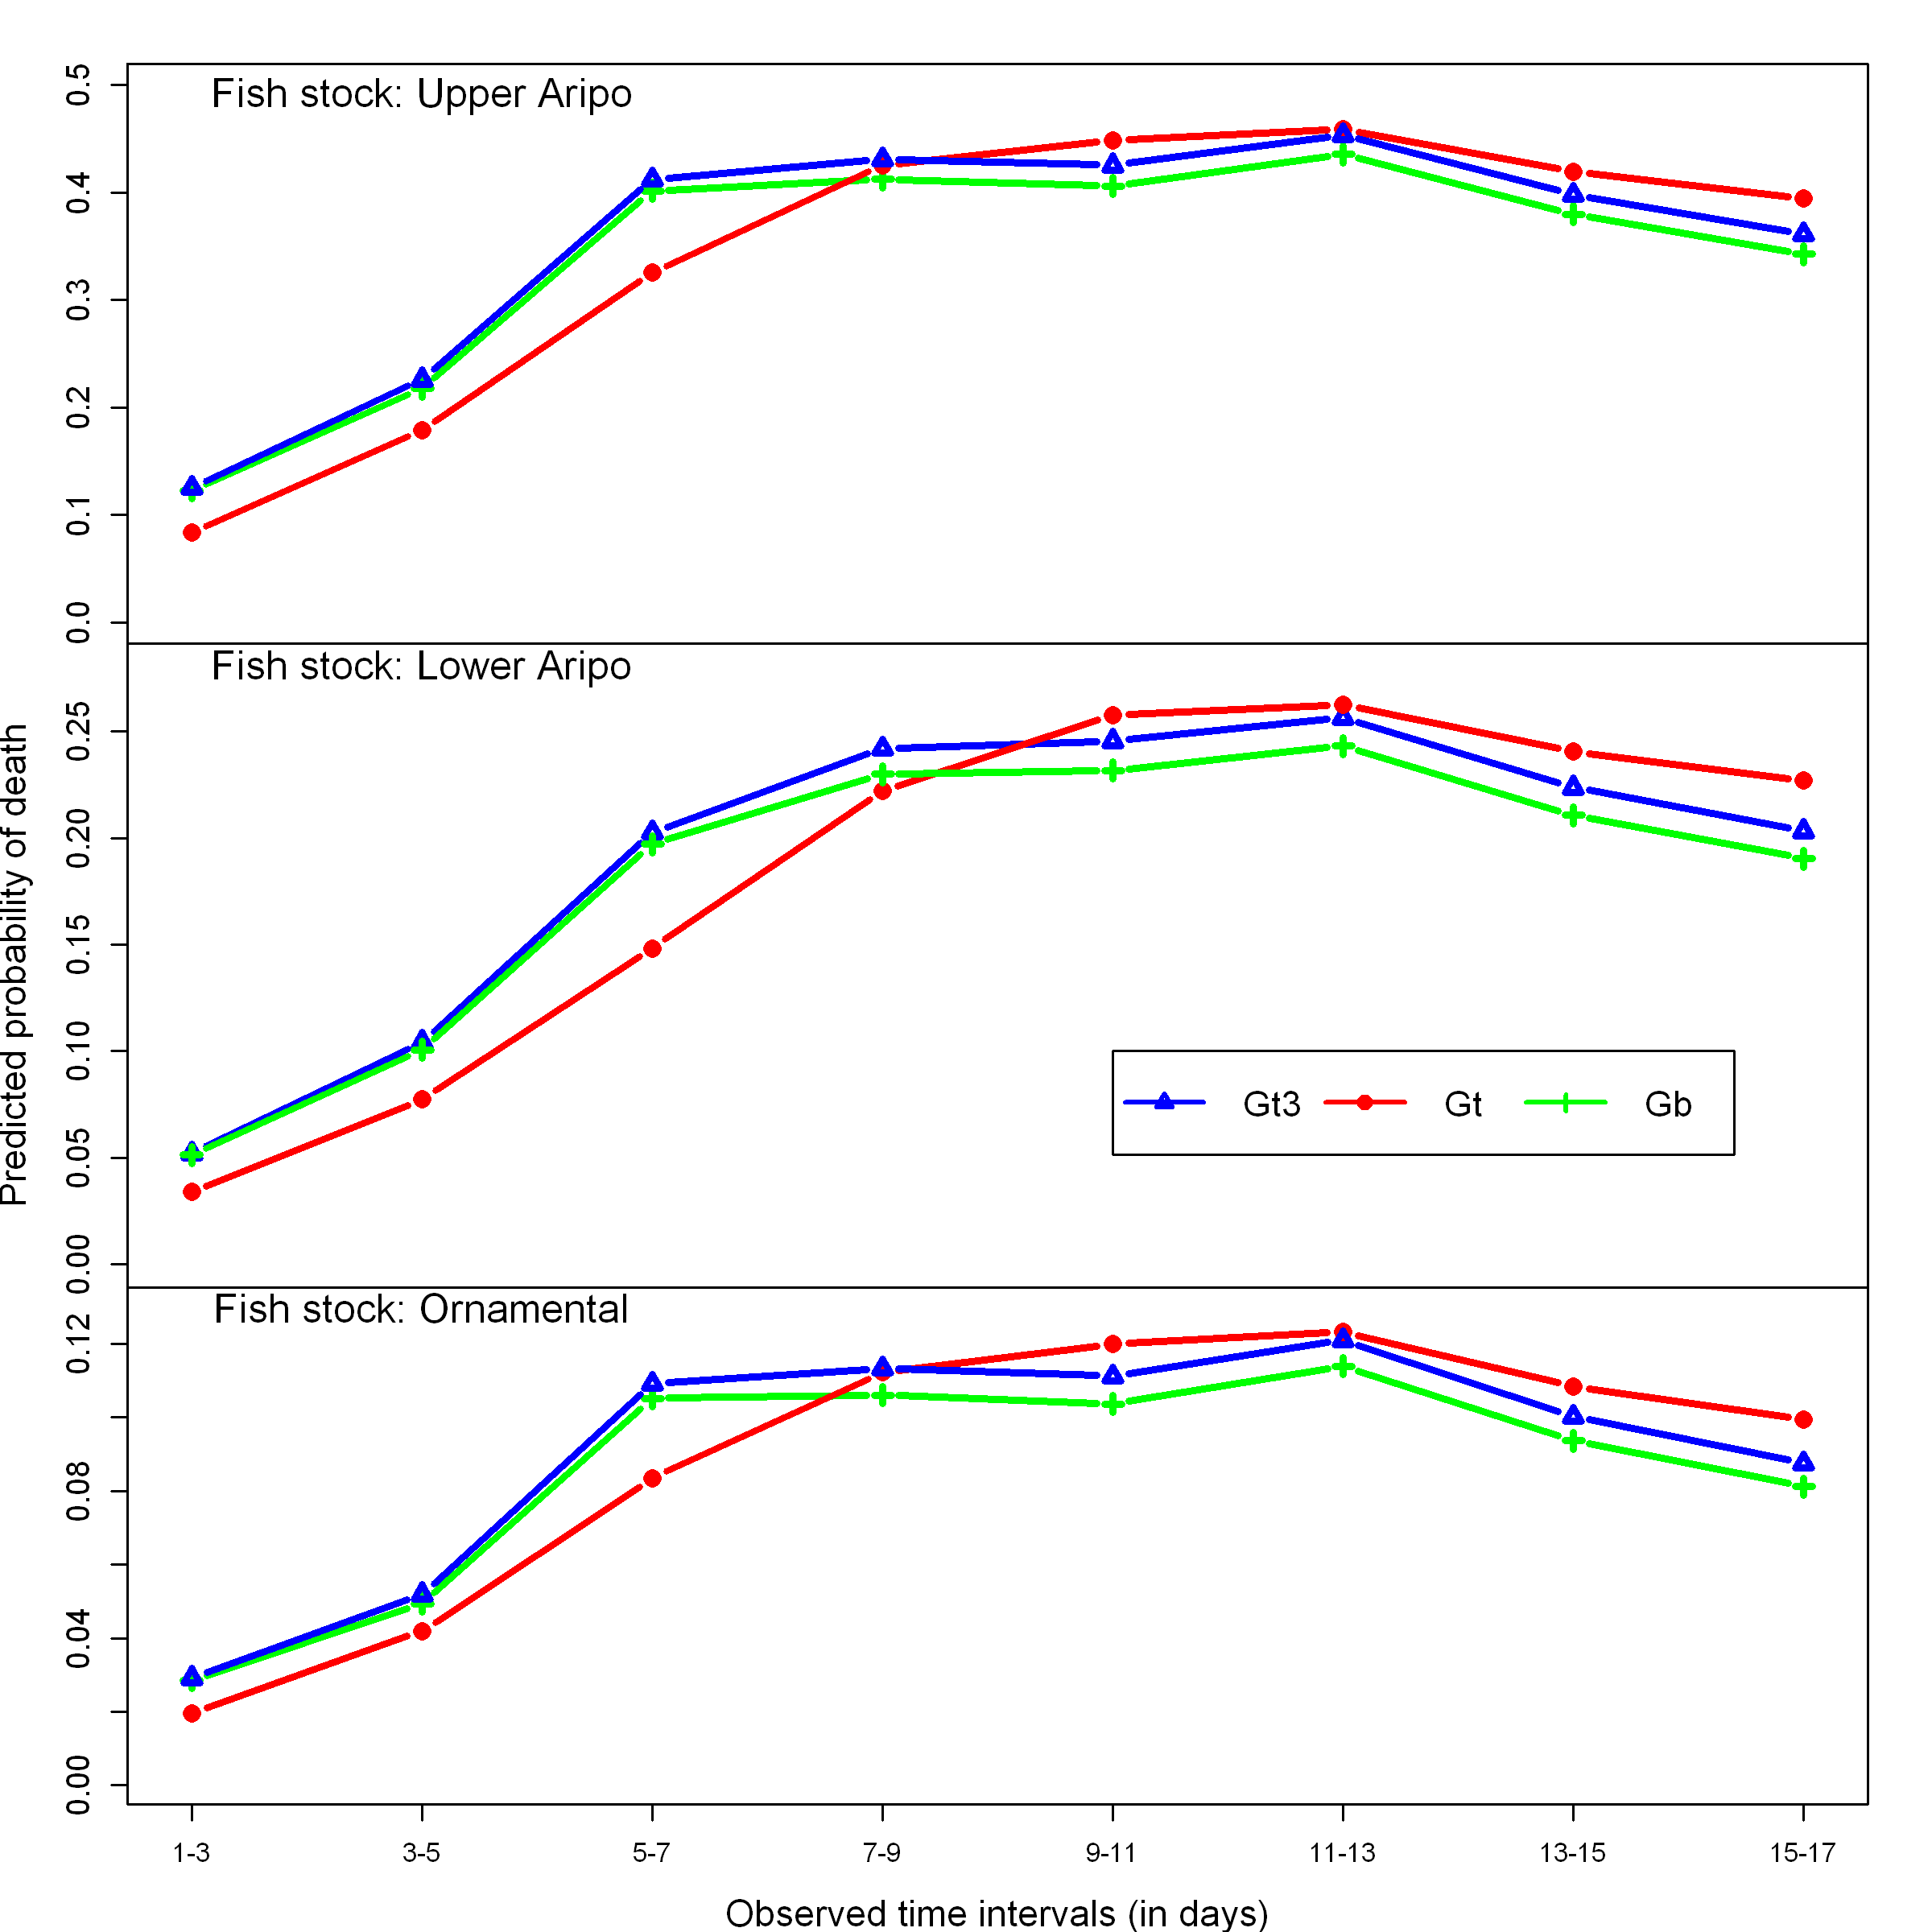

In [191]:
#Between "1-3","3-5","5-7","7-9","9-11","11-13","13-15","15-17"

o<-par(mar=c(0,4,2,2))#Run this before the code below

nf<-layout(matrix(1:3, nrow=3,ncol=1))

    
# rest parameters
par(o)#
o<-par(mar=c(0,4,2,2))

plot(Gb_fishType_death_prob[1, ,],type="b",col="green",lwd=3,xaxt = "n",ylab="",xlab="",pch=3,cex.axis=1.2,ylim=c(0,0.5))
lines(Gt_fishType_death_prob[1, ,],type="b",col="red",lwd=3,pch=19)
lines(Gt3_fishType_death_prob[1, ,],type="b",col="blue",lwd=3,pch=24)



text(2,0.49,"Fish stock: Upper Aripo",cex=1.5,lwd=3)


o<-par(mar=c(0,4,0,2))
plot(Gt3_fishType_death_prob[2, ,],type="b",col="blue",lwd=3,xaxt = "n",ylab="Predicted probability of death",xlab="",
     ylim=c(0,0.28),pch=24,cex.lab=1.4, cex.axis=1.2)
lines(Gt_fishType_death_prob[2, ,],type="b",col="red",lwd=3,pch=19)
lines(Gb_fishType_death_prob[2, ,],type="b",col="green",lwd=3,pch=3)

legend(x = 5,y=0.1,,inset = 0,
        legend = c("Gt3","Gt","Gb"), 
        col=c("blue","red","green"), lwd=2, cex=1.35, horiz = TRUE,pch=c(24,19,3),pt.cex = 1)

text(2,0.28,"Fish stock: Lower Aripo",cex=1.5,lwd=3)



par(mar=c(4,4,0,2))

plot(Gb_fishType_death_prob[3, ,],type="b",col="green",lwd=3,xaxt = "n",ylab="",xlab="Observed time intervals (in days)",
     pch=3,cex.lab=1.4, cex.axis=1.2, ylim=c(0,0.13))
lines(Gt_fishType_death_prob[3, ,],type="b",col="red",lwd=3,pch=19)
lines(Gt3_fishType_death_prob[3, ,],type="b",col="blue",lwd=3,pch=24)

axis(1, at=1:8, labels=c("1-3","3-5","5-7","7-9","9-11","11-13","13-15","15-17"))
text(2,0.13,"Fish stock: Ornamental",cex=1.5,lwd=3)


par(o)

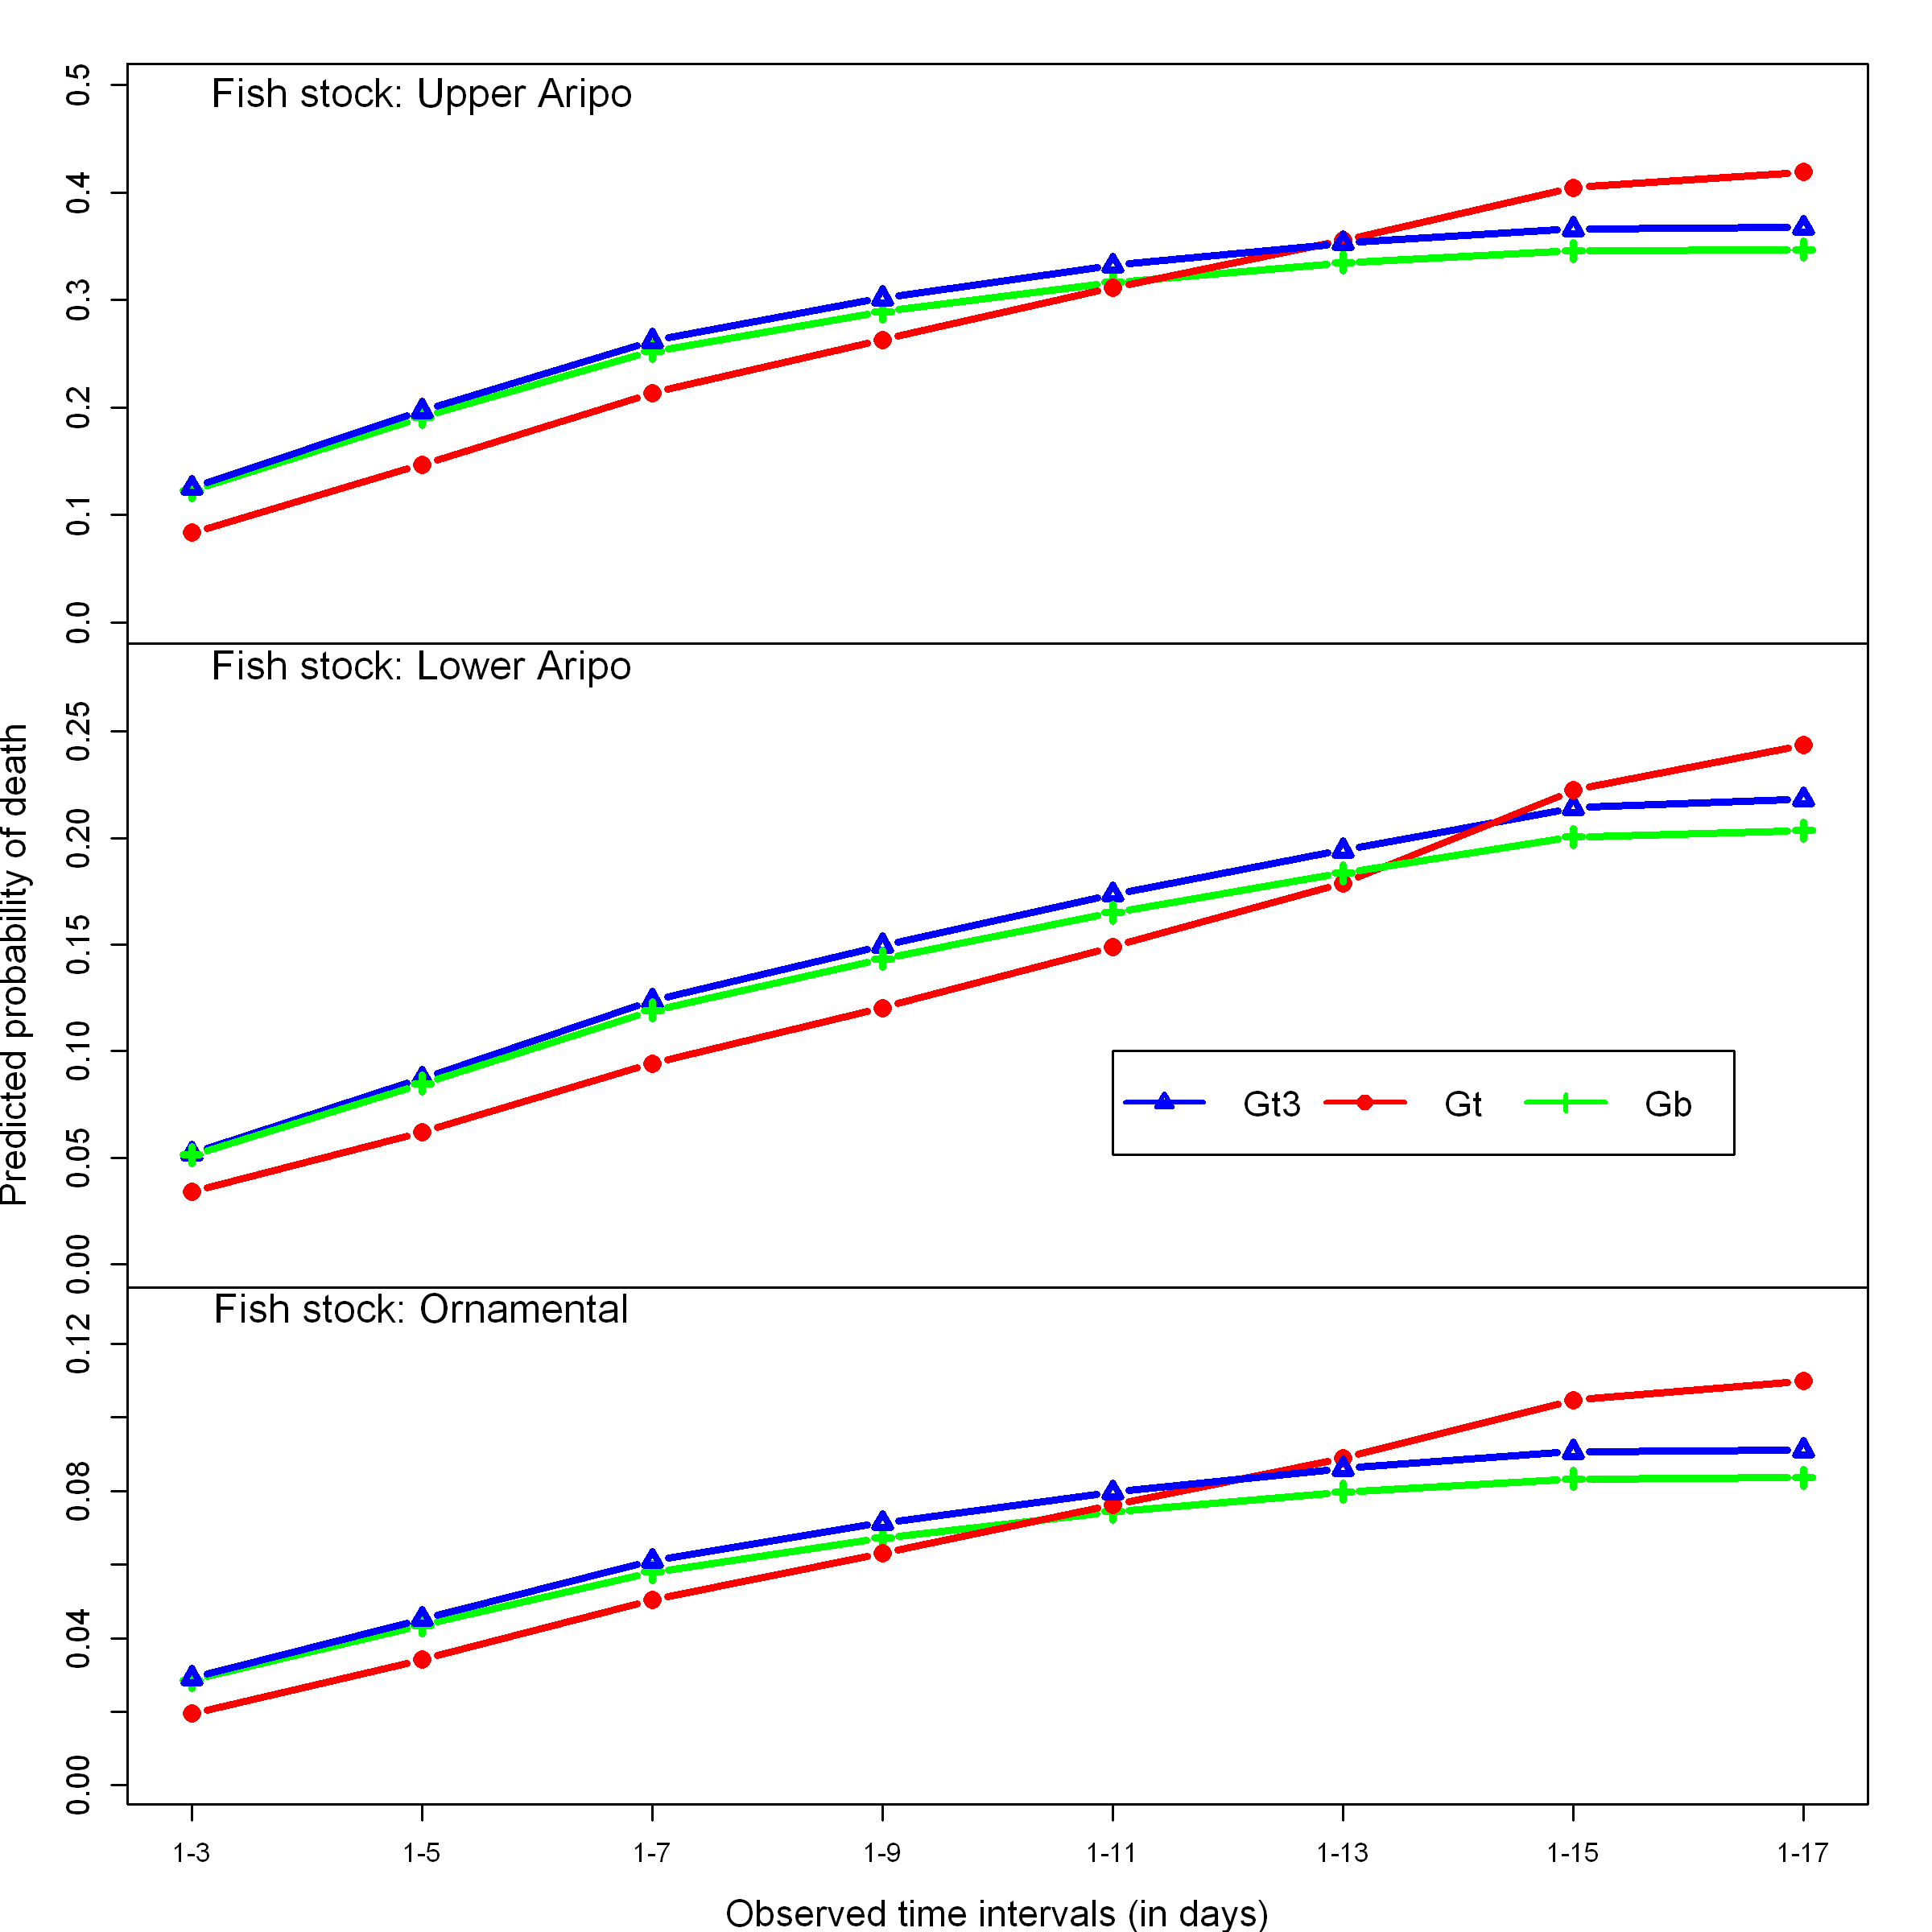

In [192]:
#From t=1 to t=3,5,7,9,11,13,15,17

o<-par(mar=c(0,4,2,2))#Run this before the code below

nf<-layout(matrix(1:3, nrow=3,ncol=1))

    
# rest parameters
par(o)#
o<-par(mar=c(0,4,2,2))

plot(Gb_fishType_death_prob1[1, ,],type="b",col="green",lwd=3,xaxt = "n",ylab="",xlab="",pch=3,cex.axis=1.2,ylim=c(0,0.5))
lines(Gt_fishType_death_prob1[1, ,],type="b",col="red",lwd=3,pch=19)
lines(Gt3_fishType_death_prob1[1, ,],type="b",col="blue",lwd=3,pch=24)



text(2,0.49,"Fish stock: Upper Aripo",cex=1.5,lwd=3)


o<-par(mar=c(0,4,0,2))
plot(Gt3_fishType_death_prob1[2, ,],type="b",col="blue",lwd=3,xaxt = "n",ylab="Predicted probability of death",xlab="",
     ylim=c(0,0.28),pch=24,cex.lab=1.4, cex.axis=1.2)
lines(Gt_fishType_death_prob1[2, ,],type="b",col="red",lwd=3,pch=19)
lines(Gb_fishType_death_prob1[2, ,],type="b",col="green",lwd=3,pch=3)

legend(x = 5,y=0.1,,inset = 0,
        legend = c("Gt3","Gt","Gb"), 
        col=c("blue","red","green"), lwd=2, cex=1.35, horiz = TRUE,pch=c(24,19,3),pt.cex = 1)

text(2,0.28,"Fish stock: Lower Aripo",cex=1.5,lwd=3)



par(mar=c(4,4,0,2))

plot(Gb_fishType_death_prob1[3, ,],type="b",col="green",lwd=3,xaxt = "n",ylab="",xlab="Observed time intervals (in days)",
     pch=3,cex.lab=1.4, cex.axis=1.2, ylim=c(0,0.13))
lines(Gt_fishType_death_prob1[3, ,],type="b",col="red",lwd=3,pch=19)
lines(Gt3_fishType_death_prob1[3, ,],type="b",col="blue",lwd=3,pch=24)

axis(1, at=1:8, labels=c("1-3","1-5","1-7","1-9","1-11","1-13","1-15","1-17"))
text(2,0.13,"Fish stock: Ornamental",cex=1.5,lwd=3)


par(o)

# Comparing statistical differences in predicted probability of death using GLMM

In [31]:
Prob1=c(c(Gt3_fishType_death_prob[1, ,]),c(Gt_fishType_death_prob[1, ,]),c(Gb_fishType_death_prob[1, ,]))
Group1=c(rep("Gt3-UA",8),rep("Gt-UA",8),rep("Gb-UA",8))
Time_interval1=c(c("1-3","3-5","5-7","7-9","9-11","11-13","13-15","15-17"),c("1-3","3-5","5-7","7-9","9-11","11-13","13-15","15-17"),
              c("1-3","3-5","5-7","7-9","9-11","11-13","13-15","15-17"))

Prob2=c(c(Gt3_fishType_death_prob[2, ,]),c(Gt_fishType_death_prob[2, ,]),c(Gb_fishType_death_prob[2, ,]))
Group2=c(rep("Gt3-LA",8),rep("Gt-LA",8),rep("Gb-LA",8))
Time_interval2=c(c("1-3","3-5","5-7","7-9","9-11","11-13","13-15","15-17"),c("1-3","3-5","5-7","7-9","9-11","11-13","13-15","15-17"),
               c("1-3","3-5","5-7","7-9","9-11","11-13","13-15","15-17"))

Prob3=c(c(Gt3_fishType_death_prob[3, ,]),c(Gt_fishType_death_prob[3, ,]),c(Gb_fishType_death_prob[3, ,]))
Group3=c(rep("Gt3-OS",8),rep("Gt-OS",8),rep("Gb-OS",8))
Time_interval3=c(c("1-3","3-5","5-7","7-9","9-11","11-13","13-15","15-17"),c("1-3","3-5","5-7","7-9","9-11","11-13","13-15","15-17"),
            c("1-3","3-5","5-7","7-9","9-11","11-13","13-15","15-17"))


Prob=c(Prob1,Prob2,Prob3)
Group=c(Group1,Group2,Group3)
Time_interval=c(Time_interval1,Time_interval2,Time_interval3)

Prob_data_UA=data.frame(Prob=Prob1,Group=Group1,Time_interval=Time_interval1)
Prob_data_LA=data.frame(Prob=Prob2,Group=Group2,Time_interval=Time_interval2)
Prob_data_OS=data.frame(Prob=Prob3,Group=Group3,Time_interval=Time_interval3)
Pred_prob_data=data.frame(Prob,Group,Time_interval)

head(Prob_data_UA)

,Prob,Group,Time_interval
,<dbl>,<fct>,<fct>
1,0.1252109,Gt3-UA,1-3
2,0.2261322,Gt3-UA,3-5
3,0.4124140,Gt3-UA,5-7
4,0.4309093,Gt3-UA,7-9
5,0.4254449,Gt3-UA,9-11
6,0.4537385,Gt3-UA,11-13


# Comparing statistical differences in predicted death rates using GLMM

In [32]:
Rates1=c(c(Gt3_fishType_Deathrate[1, ,][, 1]),c(Gt_fishType_Deathrate[1, ,][, 1]),c(Gb_fishType_Deathrate[1, ,][, 1]))
Group1=c(rep("Gt3-UA",8),rep("Gt-UA",8),rep("Gb-UA",8))
Time_interval1=c(c("1-3","3-5","5-7","7-9","9-11","11-13","13-15","15-17"),c("1-3","3-5","5-7","7-9","9-11","11-13","13-15","15-17"),
              c("1-3","3-5","5-7","7-9","9-11","11-13","13-15","15-17"))

Rates2=c(c(Gt3_fishType_Deathrate[2, ,][, 1]),c(Gt_fishType_Deathrate[2, ,][, 1]),c(Gb_fishType_Deathrate[2, ,][, 1]))
Group2=c(rep("Gt3-LA",8),rep("Gt-LA",8),rep("Gb-LA",8))
Time_interval2=c(c("1-3","3-5","5-7","7-9","9-11","11-13","13-15","15-17"),c("1-3","3-5","5-7","7-9","9-11","11-13","13-15","15-17"),
               c("1-3","3-5","5-7","7-9","9-11","11-13","13-15","15-17"))

Rates3=c(c(Gt3_fishType_Deathrate[3, ,][, 1]),c(Gt_fishType_Deathrate[3, ,][, 1]),c(Gb_fishType_Deathrate[3, ,][, 1]))
Group3=c(rep("Gt3-OS",8),rep("Gt-OS",8),rep("Gb-OS",8))
Time_interval3=c(c("1-3","3-5","5-7","7-9","9-11","11-13","13-15","15-17"),c("1-3","3-5","5-7","7-9","9-11","11-13","13-15","15-17"),
            c("1-3","3-5","5-7","7-9","9-11","11-13","13-15","15-17"))


Rates=c(Rates1,Rates2,Rates3)
Group=c(Group1,Group2,Group3)
Time_interval=c(Time_interval1,Time_interval2,Time_interval3)

Rate_data_UA=data.frame(Rate=Rates1,Group=Group1,Time_interval=Time_interval1)
Rate_data_LA=data.frame(Rate=Rates2,Group=Group2,Time_interval=Time_interval2)
Rate_data_OS=data.frame(Rate=Rates3,Group=Group3,Time_interval=Time_interval3)
Pred_Rate_data=data.frame(Rates,Group,Time_interval)

head(Rate_data_UA)

,Rate,Group,Time_interval
,<dbl>,<fct>,<fct>
1,0.05835434,Gt3-UA,1-3
2,0.04010630,Gt3-UA,3-5
3,0.12607560,Gt3-UA,5-7
4,0.08736609,Gt3-UA,7-9
5,0.11627243,Gt3-UA,9-11
6,0.15873677,Gt3-UA,11-13


In [35]:
write.csv(Pred_Rate_data,"Death_rates_MSM.csv")


In [38]:
dim(Pred_Rate_data)

[1] 72  3

# GLMM on the predicted probability of death for each fish population and combined data

In [46]:
Prob_UA <- lmer(Prob~ Group + (1|Time_interval), data=Prob_data_UA)
anova(Prob_UA)

results_UA<-estimate_means(Prob_UA)
print(results_UA)

estimate_contrasts(Prob_UA,standardize=F)

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
Group,0.0009605752,0.0004802876,2,14,0.7101325,0.508456


Group  | Mean |   SE |       95% CI
-----------------------------------
Gb-UA  | 0.34 | 0.04 | [0.24, 0.44]
Gt-UA  | 0.34 | 0.04 | [0.24, 0.44]
Gt3-UA | 0.35 | 0.04 | [0.25, 0.46]


,Level1,Level2,Difference,SE,CI_low,CI_high,t,df,p
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Gb-UA,Gt-UA,-0.002035218,0.01300322,-0.04201105,0.03794061,-0.1565164,7.435805,0.9152746
2,Gb-UA,Gt3-UA,-0.014321791,0.01300322,-0.05429762,0.02565404,-1.1014032,7.435805,0.9152746
3,Gt-UA,Gt3-UA,-0.012286573,0.01300322,-0.05226240,0.02768925,-0.9448868,7.435805,0.9152746


In [43]:
Prob_LA <- lmer(Prob~ Group + (1|Time_interval), data=Prob_data_LA)
anova(Prob_LA)

results_LA<-estimate_means(Prob_LA)
print(results_LA)

estimate_contrasts(Prob_LA,standardize=F)

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
Group,0.00040005,0.000200025,2,14,0.7157084,0.5058895


Group  | Mean |   SE |       95% CI
-----------------------------------
Gb-LA  | 0.18 | 0.03 | [0.12, 0.25]
Gt-LA  | 0.18 | 0.03 | [0.12, 0.25]
Gt3-LA | 0.19 | 0.03 | [0.13, 0.26]


,Level1,Level2,Difference,SE,CI_low,CI_high,t,df,p
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Gb-LA,Gt-LA,-0.001817554,0.008358803,-0.02749555,0.02386044,-0.2174419,7.456433,0.8833946
2,Gb-LA,Gt3-LA,-0.009425335,0.008358803,-0.03510333,0.01625266,-1.1275938,7.456433,0.8833946
3,Gt-LA,Gt3-LA,-0.007607781,0.008358803,-0.03328577,0.01807021,-0.9101519,7.456433,0.8833946


In [44]:
Prob_OS <- lmer(Prob~ Group + (1|Time_interval), data=Prob_data_OS)
anova(Prob_OS)

results_OS<-estimate_means(Prob_OS)
print(results_OS)

estimate_contrasts(Prob_OS,standardize=F)

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
Group,0.0001132582,5.662912e-05,2,14,0.9081027,0.425775


Group  | Mean |   SE |       95% CI
-----------------------------------
Gb-OS  | 0.09 | 0.01 | [0.06, 0.11]
Gt-OS  | 0.09 | 0.01 | [0.06, 0.12]
Gt3-OS | 0.09 | 0.01 | [0.06, 0.12]


,Level1,Level2,Difference,SE,CI_low,CI_high,t,df,p
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Gb-OS,Gt-OS,-0.003326005,0.003948412,-0.01542554,0.008773530,-0.8423653,7.524331,0.8510923
2,Gb-OS,Gt3-OS,-0.005260111,0.003948412,-0.01735965,0.006839424,-1.3322093,7.524331,0.6651764
3,Gt-OS,Gt3-OS,-0.001934106,0.003948412,-0.01403364,0.010165429,-0.4898440,7.524331,0.8510923


In [63]:
#GLMM on Combined probability data

Prob_fit <- lmer(Prob~ Group + (1|Time_interval), data=Pred_prob_data)
anova(Prob_fit)

results<-estimate_means(Prob_fit)
print(results)

estimate_contrasts(Prob_fit,standardize=F)

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
Group,0.81116,0.101395,8,56,58.84609,1.801157e-24


Group  | Mean |   SE |       95% CI
-----------------------------------
Gb-LA  | 0.18 | 0.03 | [0.12, 0.25]
Gb-OS  | 0.09 | 0.03 | [0.02, 0.15]
Gb-UA  | 0.34 | 0.03 | [0.27, 0.41]
Gt-LA  | 0.18 | 0.03 | [0.12, 0.25]
Gt-OS  | 0.09 | 0.03 | [0.02, 0.16]
Gt-UA  | 0.34 | 0.03 | [0.28, 0.41]
Gt3-LA | 0.19 | 0.03 | [0.12, 0.26]
Gt3-OS | 0.09 | 0.03 | [0.02, 0.16]
Gt3-UA | 0.35 | 0.03 | [0.29, 0.42]


,Level1,Level2,Difference,SE,CI_low,CI_high,t,df,p
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Gb-LA,Gb-OS,0.096703905,0.02075484,0.008827333,0.18458048,4.65934155,11.05022,9.605461e-03
2,Gb-LA,Gb-UA,-0.157977400,0.02075484,-0.245853972,-0.07010083,-7.61159191,11.05022,2.310198e-04
3,Gb-LA,Gt-LA,-0.001817554,0.02075484,-0.089694126,0.08605902,-0.08757252,11.05022,1.000000e+00
4,Gb-LA,Gt-OS,0.093377900,0.02075484,0.005501328,0.18125447,4.49908957,11.05022,1.070889e-02
5,Gb-LA,Gt-UA,-0.160012618,0.02075484,-0.247889190,-0.07213605,-7.70965182,11.05022,2.164394e-04
6,Gb-LA,Gt3-LA,-0.009425335,0.02075484,-0.097301907,0.07845124,-0.45412699,11.05022,1.000000e+00
7,Gb-LA,Gt3-OS,0.091443795,0.02075484,0.003567222,0.17932037,4.40590140,11.05022,1.070889e-02
8,Gb-LA,Gt3-UA,-0.172299191,0.02075484,-0.260175763,-0.08442262,-8.30163763,11.05022,1.201796e-04
9,Gb-OS,Gb-UA,-0.254681305,0.02075484,-0.342557877,-0.16680473,-12.27093346,11.05022,2.825067e-06


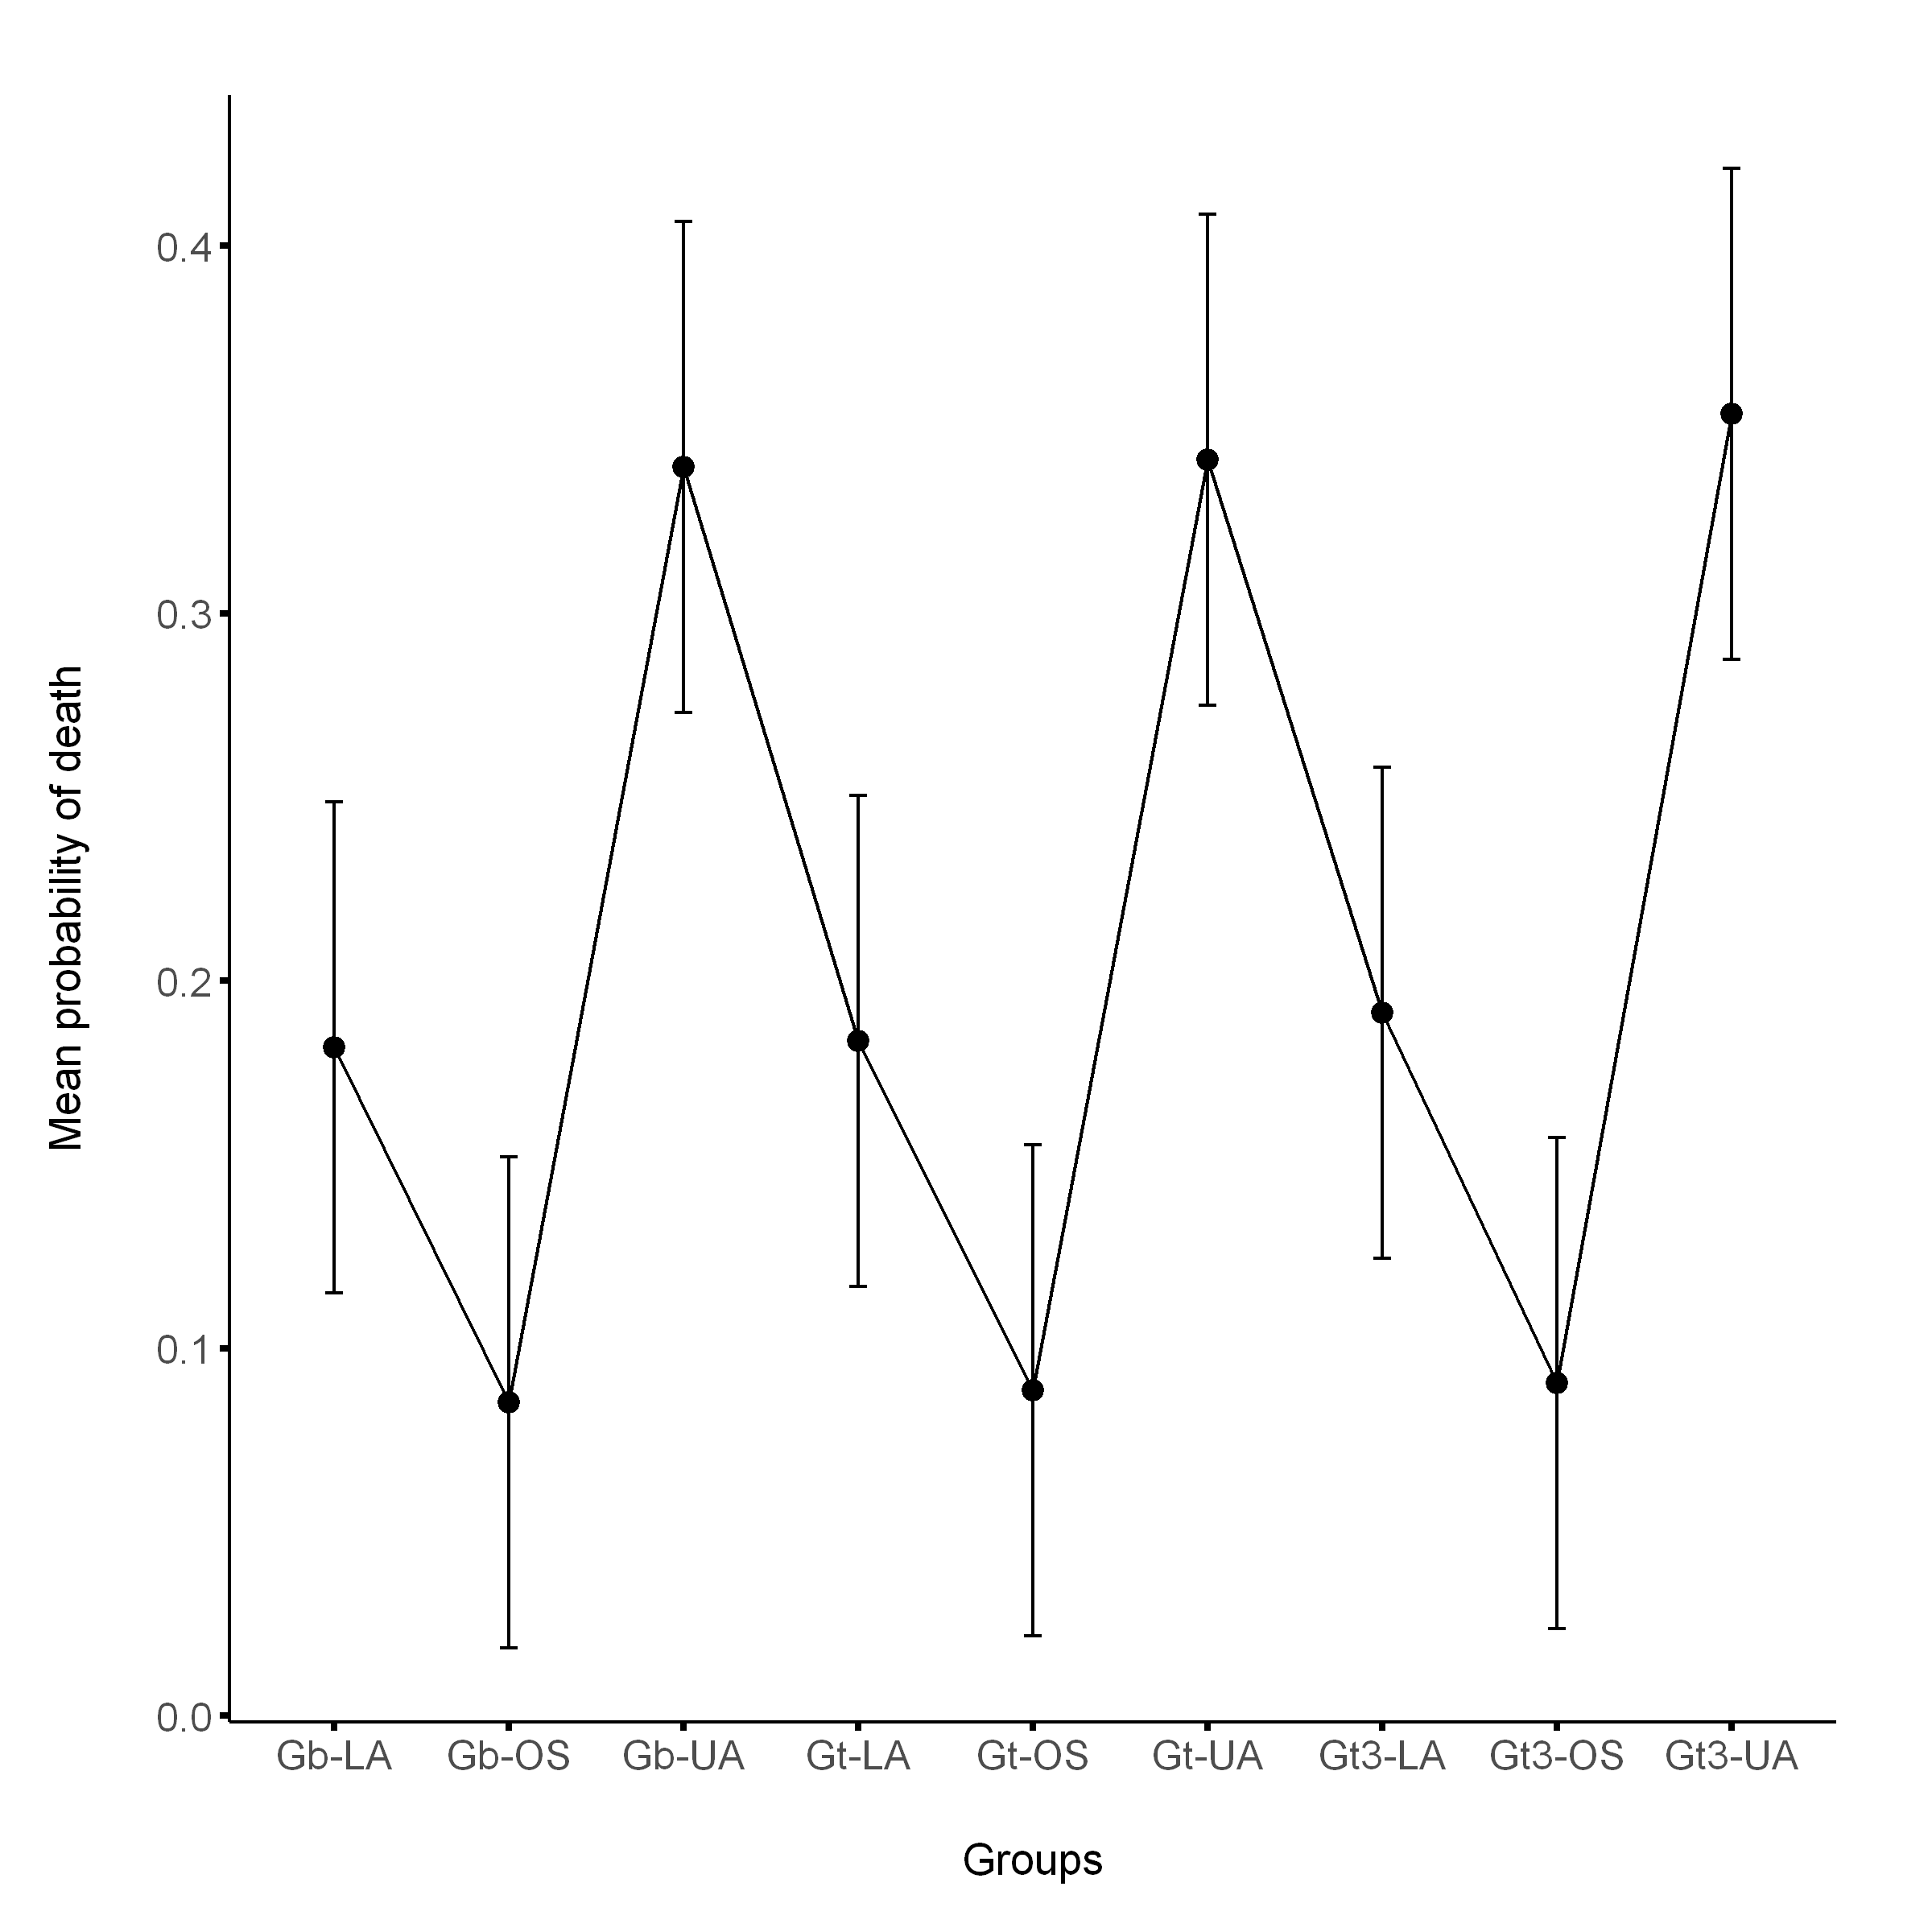

In [64]:
Mean_compare=ggplot(results, aes(x=results$Group, y=results$Mean, group=1)) +
  geom_line(position=position_dodge(0.1)) +
 geom_pointrange(aes(ymin=CI_low, ymax=CI_high))  + ylab("Mean probability of death") +xlab("Groups") +theme_modern() +
    theme(plot.margin = unit(c(1,1,0.5,0.5), "cm"))+
geom_errorbar(aes(ymin=results$CI_low, ymax=results$CI_high),width=.1,position=position_dodge(0.1))

Mean_compare+ theme(axis.ticks = element_line(size = 1))

# GLMM on the predicted death rate for each fish population and combined data

In [56]:
Rate_UA <- lmer(Rate~ Group + (1|Time_interval), data=Rate_data_UA)
anova(Rate_UA)

Rate_results_UA<-estimate_means(Rate_UA)
print(Rate_results_UA)

estimate_contrasts(Rate_UA,standardize=F)

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
Group,0.02895367,0.01447683,2,14,5.818587,0.01448122


Group  | Mean |   SE |        95% CI
------------------------------------
Gb-UA  | 0.19 | 0.07 | [ 0.03, 0.35]
Gt-UA  | 0.11 | 0.07 | [-0.05, 0.27]
Gt3-UA | 0.19 | 0.07 | [ 0.03, 0.35]


,Level1,Level2,Difference,SE,CI_low,CI_high,t,df,p
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Gb-UA,Gt-UA,0.072919343,0.02494009,-0.003184518,0.149023204,2.92378011,7.644054,0.05527607
2,Gb-UA,Gt3-UA,-0.001499382,0.02494009,-0.077603243,0.074604479,-0.06011935,7.644054,0.95360249
3,Gt-UA,Gt3-UA,-0.074418725,0.02494009,-0.150522586,0.001685136,-2.98389947,7.644054,0.05527607


In [58]:
Rate_LA <- lmer(Rate~ Group + (1|Time_interval), data=Rate_data_LA)
anova(Rate_LA)

Rate_results_LA<-estimate_means(Rate_LA)
print(Rate_results_LA)

estimate_contrasts(Rate_LA,standardize=F)

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
Group,0.004412069,0.002206035,2,14,5.818587,0.01448122


Group  | Mean |   SE |        95% CI
------------------------------------
Gb-LA  | 0.07 | 0.03 | [ 0.01, 0.14]
Gt-LA  | 0.04 | 0.03 | [-0.02, 0.11]
Gt3-LA | 0.07 | 0.03 | [ 0.01, 0.14]


,Level1,Level2,Difference,SE,CI_low,CI_high,t,df,p
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Gb-LA,Gt-LA,0.0284650600,0.009735705,-0.00124312,0.0581732401,2.92378011,7.644054,0.05527607
2,Gb-LA,Gt3-LA,-0.0005853043,0.009735705,-0.03029348,0.0291228759,-0.06011935,7.644054,0.95360249
3,Gt-LA,Gt3-LA,-0.0290503643,0.009735705,-0.05875854,0.0006578159,-2.98389947,7.644054,0.05527607


In [59]:
Rate_OS <- lmer(Rate~ Group + (1|Time_interval), data=Rate_data_OS)
anova(Rate_OS)

Rate_results_OS<-estimate_means(Rate_OS)
print(Rate_results_OS)

estimate_contrasts(Rate_OS,standardize=F)

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
Group,0.001570839,0.0007854197,2,14,5.818587,0.01448122


Group  | Mean |   SE |        95% CI
------------------------------------
Gb-OS  | 0.04 | 0.02 | [ 0.01, 0.08]
Gt-OS  | 0.03 | 0.02 | [-0.01, 0.06]
Gt3-OS | 0.04 | 0.02 | [ 0.01, 0.08]


,Level1,Level2,Difference,SE,CI_low,CI_high,t,df,p
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Gb-OS,Gt-OS,0.016984660,0.005809144,-0.0007417505,0.0347110700,2.92378011,7.644054,0.05527607
2,Gb-OS,Gt3-OS,-0.000349242,0.005809144,-0.0180756522,0.0173771683,-0.06011935,7.644054,0.95360249
3,Gt-OS,Gt3-OS,-0.017333902,0.005809144,-0.0350603120,0.0003925085,-2.98389947,7.644054,0.05527607


In [65]:
#GLMM on Combined probability data
Rate_fit <- lmer(Rates~ Group + (1|Time_interval), data=Pred_Rate_data)
anova(Rate_fit)

results<-estimate_means(Rate_fit)
print(results)

estimate_contrasts(Rate_fit,standardize=F)

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
Group,0.2436852,0.03046065,8,56,5.818587,2.098023e-05


Group  | Mean |   SE |        95% CI
------------------------------------
Gb-LA  | 0.07 | 0.04 | [-0.02, 0.17]
Gb-OS  | 0.04 | 0.04 | [-0.05, 0.14]
Gb-UA  | 0.19 | 0.04 | [ 0.09, 0.28]
Gt-LA  | 0.04 | 0.04 | [-0.05, 0.14]
Gt-OS  | 0.03 | 0.04 | [-0.07, 0.12]
Gt-UA  | 0.11 | 0.04 | [ 0.02, 0.21]
Gt3-LA | 0.07 | 0.04 | [-0.02, 0.17]
Gt3-OS | 0.04 | 0.04 | [-0.05, 0.14]
Gt3-UA | 0.19 | 0.04 | [ 0.09, 0.28]


,Level1,Level2,Difference,SE,CI_low,CI_high,t,df,p
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Gb-LA,Gb-OS,0.0293750163,0.03617685,-0.1140887102,0.1728387428,0.811983721,14.10506,1.00000000
2,Gb-LA,Gb-UA,-0.1137456236,0.03617685,-0.2572093501,0.0297181030,-3.144154668,14.10506,0.18509670
3,Gb-LA,Gt-LA,0.0284650600,0.03617685,-0.1149986665,0.1719287865,0.786830723,14.10506,1.00000000
4,Gb-LA,Gt-OS,0.0463596761,0.03617685,-0.0971040505,0.1898234026,1.281473408,14.10506,1.00000000
5,Gb-LA,Gt-UA,-0.0408262807,0.03617685,-0.1842900072,0.1026374459,-1.128519383,14.10506,1.00000000
6,Gb-LA,Gt3-LA,-0.0005853043,0.03617685,-0.1440490308,0.1428784222,-0.016178971,14.10506,1.00000000
7,Gb-LA,Gt3-OS,0.0290257743,0.03617685,-0.1144379522,0.1724895009,0.802329980,14.10506,1.00000000
8,Gb-LA,Gt3-UA,-0.1152450057,0.03617685,-0.2587087322,0.0282187208,-3.185600566,14.10506,0.18352081
9,Gb-OS,Gb-UA,-0.1431206399,0.03617685,-0.2865843664,0.0003430866,-3.956138389,14.10506,0.04434020


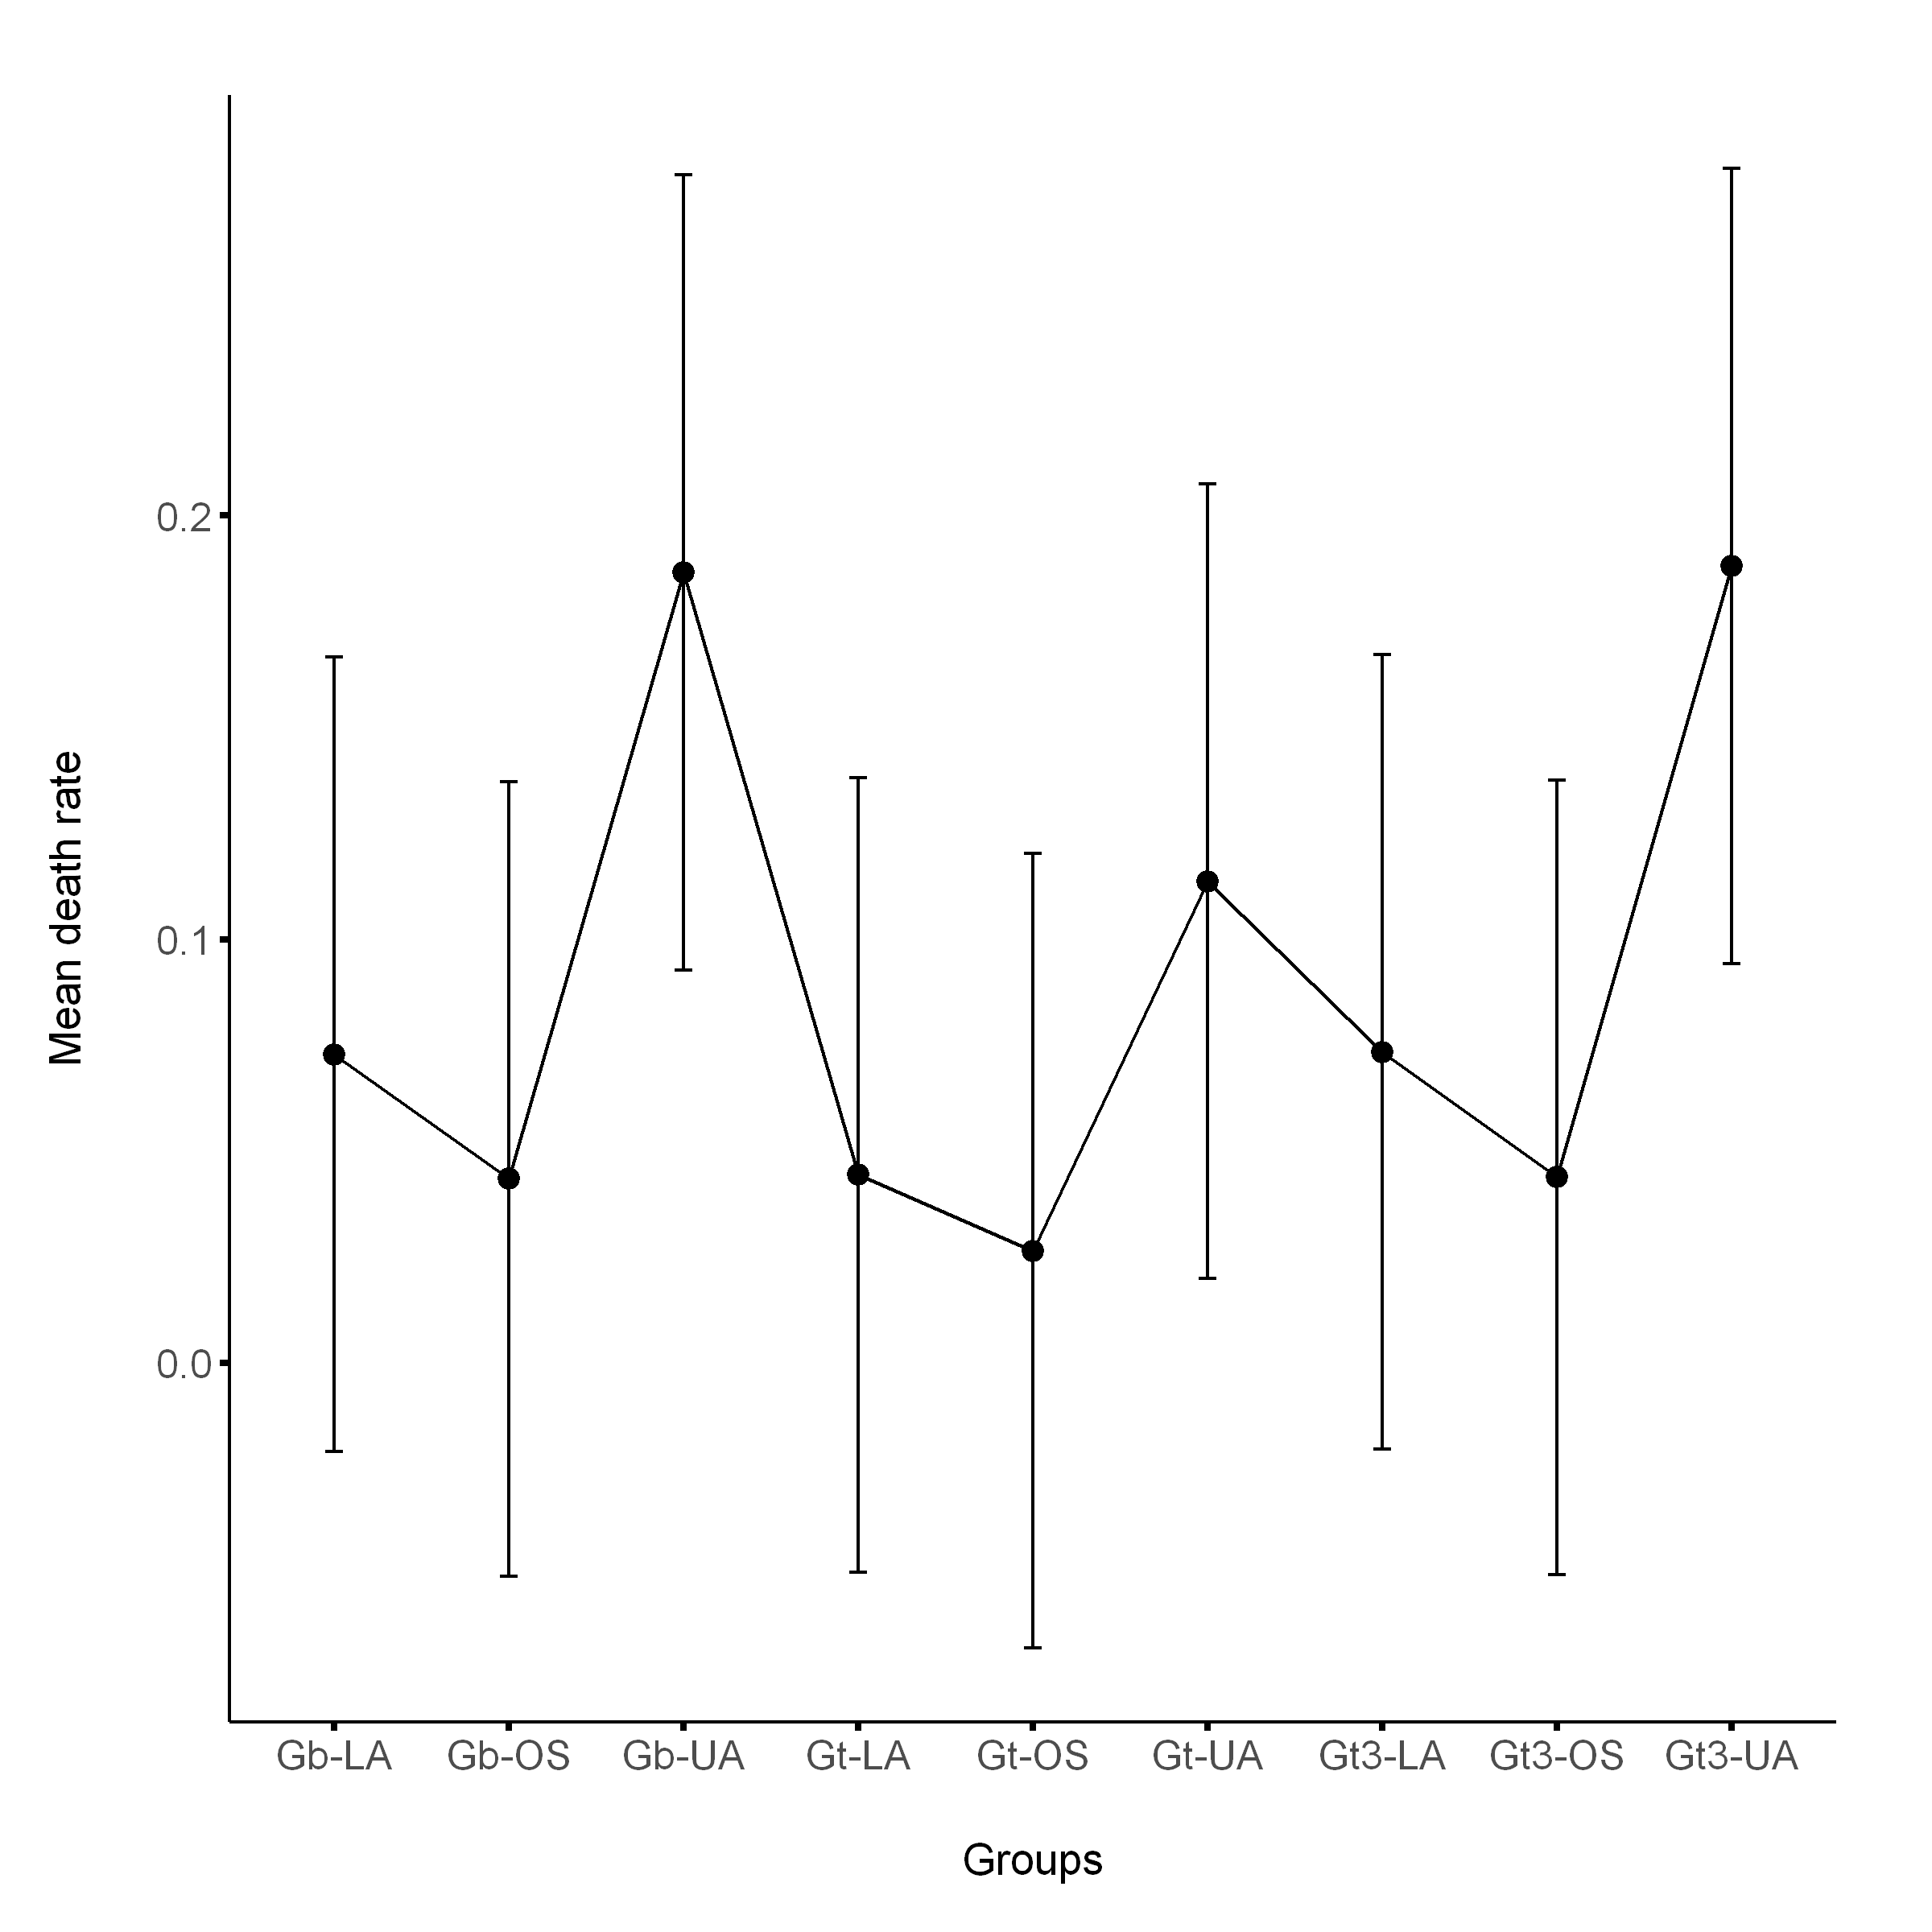

In [62]:
Mean_compare=ggplot(results, aes(x=results$Group, y=results$Mean, group=1)) +
  geom_line(position=position_dodge(0.1)) +
 geom_pointrange(aes(ymin=CI_low, ymax=CI_high))  + ylab("Mean death rate") +xlab("Groups") +theme_modern() +
    theme(plot.margin = unit(c(1,1,0.5,0.5), "cm"))+
geom_errorbar(aes(ymin=results$CI_low, ymax=results$CI_high),width=.1,position=position_dodge(0.1))

Mean_compare+ theme(axis.ticks = element_line(size = 1))

# Plotting transition probability matrix over time

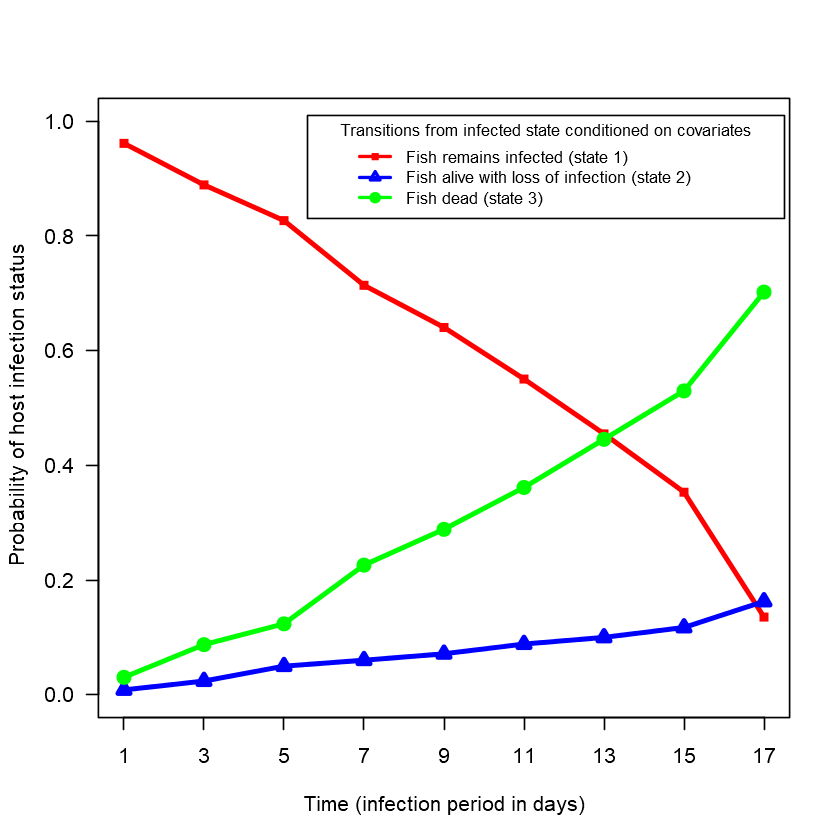

In [23]:

plot(Prob_state1,type="o",col="red",lwd=3
      ,ylab="Probability of host infection status",las=1,xaxt = "n",xlab="Time (infection period in days)",
    ylim=c(0,1),pch=15)
lines(Prob_state2,type="o",col="blue",lwd=3,pch=24)
lines(Prob_state3,type="o",col="green",lwd=3,pch=19)

axis(1, at=1:9, labels=c("1","3","5","7","9","11","13","15","17"))
text <- c("Fish remains infected (state 1)","Fish alive with loss of infection (state 2)",
          "Fish dead (state 3)")
legend_order <- matrix(1:3,ncol=1,byrow = T)
legend(x = 3.3,y=1.01,legend = text[legend_order],
       col=c("red","blue","green"),ncol=1, lwd=2, cex=.8,title="Transitions from infected state conditioned on covariates",
      lty = c(1,1,1)[legend_order],pch=c(15,24,19))



# Plotting transition rate matrix over time

In [51]:
#Multistate_model_best$Qmatrices
#qmatrix.msm(Multistate_model_best, covariates = 0)
#Multistate_model_best$Qmatrices
Multistate_model_best$Qmatrices$baseline
Multistate_model_best$Qmatrices

,state1,state2,state3
state1,-0.0820703,0.01496492,0.06710538
state2,0.0000000,0.00000000,0.00000000
state3,0.0000000,0.00000000,0.00000000


,state1,state2,state3
state1,0,-4.202047,-2.701491
state2,0,0.000000,0.000000
state3,0,0.000000,0.000000
,state1,state2,state3
state1,0,0.2333463,0.4271946
state2,0,0.0000000,0.0000000
state3,0,0.0000000,0.0000000
,state1,state2,state3
state1,0,-0.1436148,-0.9406766
state2,0,0.0000000,0.0000000


In [25]:
Multistate_model_best$Qmatrices$baseline[1,2]

abs(Multistate_model_best$Qmatrices$`timeperiod[3,5)`)[1,2]


abs(Multistate_model_best$Qmatrices$`timeperiod[1,3)`)[1,2]

[1] 0.01596266

[1] 0.605805

ERROR: Error in abs(Multistate_model_best$Qmatrices$`timeperiod[1,3)`): non-numeric argument to mathematical function


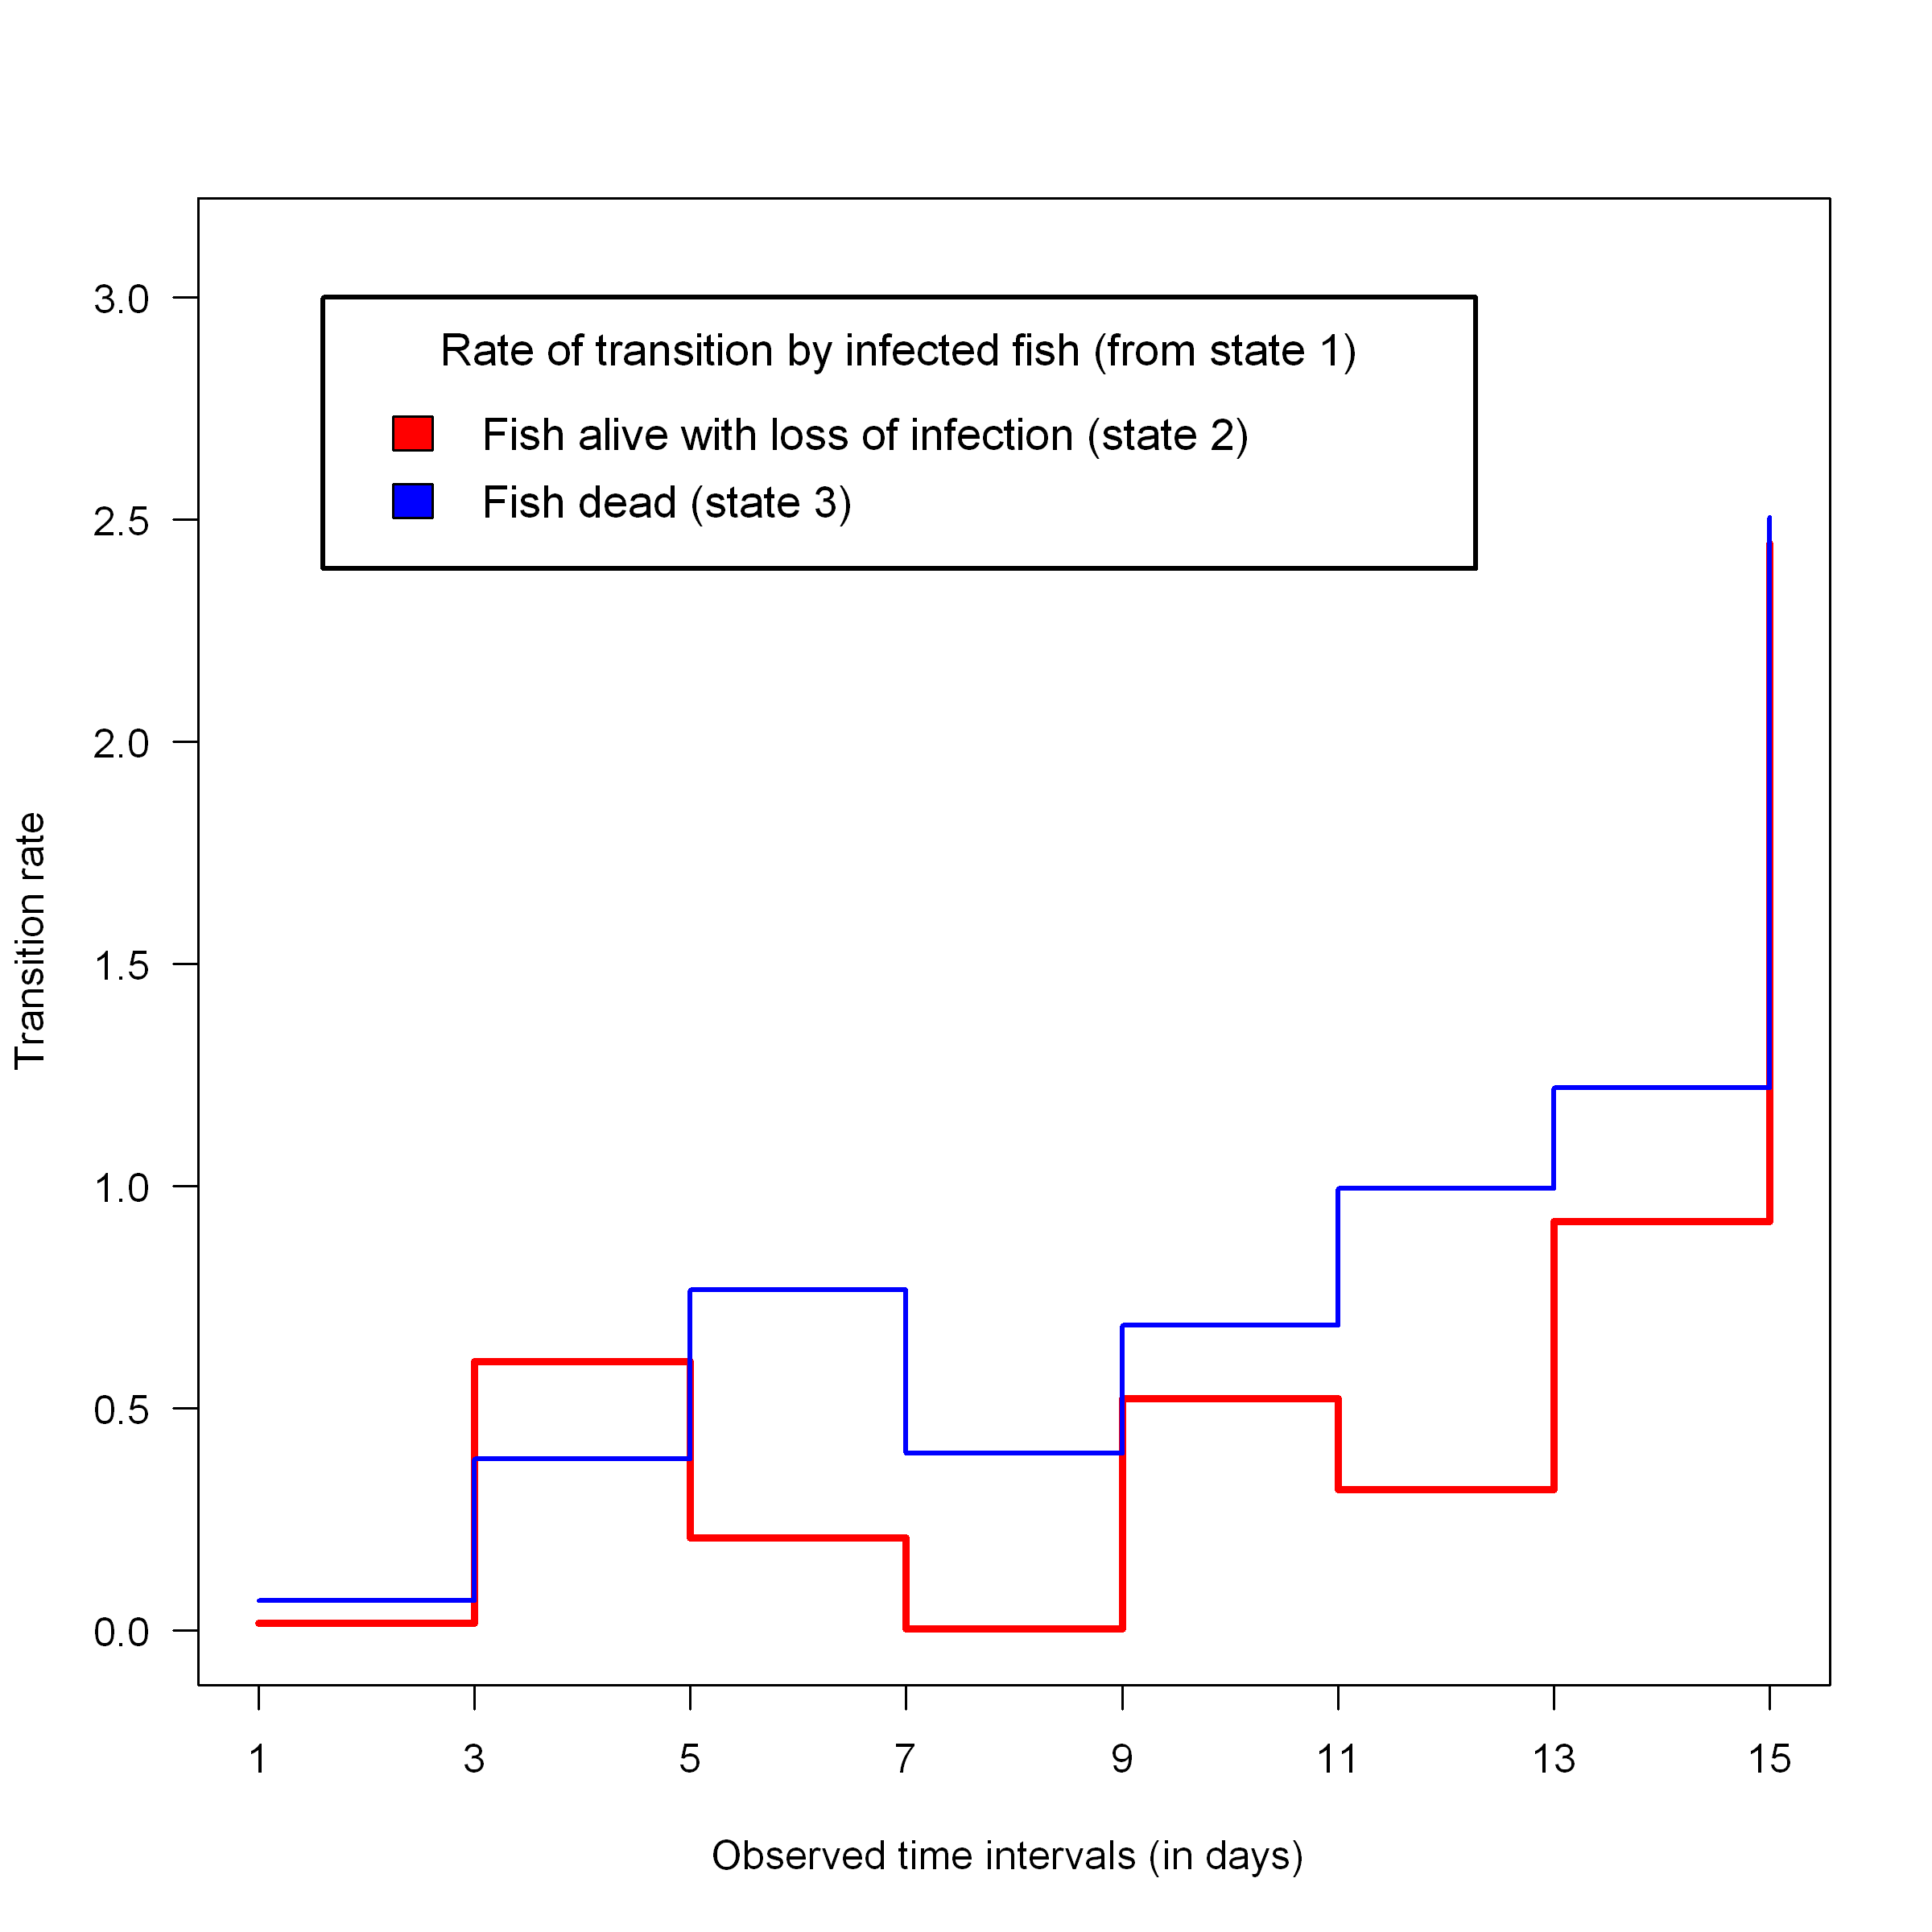

In [23]:
#Multistate_model_best$Qmatrices (How way to visualise it)

Qrate_State2=c(Multistate_model_best$Qmatrices$baseline[1,2],abs(Multistate_model_best$Qmatrices$`timeperiod[3,5)`)[1,2],
abs(Multistate_model_best$Qmatrices$`timeperiod[5,7)`)[1,2],abs(Multistate_model_best$Qmatrices$`timeperiod[7,9)`)[1,2],
abs(Multistate_model_best$Qmatrices$`timeperiod[9,11)`)[1,2],  abs(Multistate_model_best$Qmatrices$`timeperiod[11,13)`)[1,2],
abs(Multistate_model_best$Qmatrices$`timeperiod[13,15)`)[1,2],  abs(Multistate_model_best$Qmatrices$`timeperiod[15,Inf)`)[1,2])

Qrate_State3=c(Multistate_model_best$Qmatrices$baseline[1,3],abs(Multistate_model_best$Qmatrices$`timeperiod[3,5)`)[1,3],
abs(Multistate_model_best$Qmatrices$`timeperiod[5,7)`)[1,3],abs(Multistate_model_best$Qmatrices$`timeperiod[7,9)`)[1,3],
abs(Multistate_model_best$Qmatrices$`timeperiod[9,11)`)[1,3],  abs(Multistate_model_best$Qmatrices$`timeperiod[11,13)`)[1,3],
abs(Multistate_model_best$Qmatrices$`timeperiod[13,15)`)[1,3],  abs(Multistate_model_best$Qmatrices$`timeperiod[15,Inf)`)[1,3])


plot(Qrate_State2,type="s",col="red",lwd=3
      ,ylab="Transition rate",las=1,xaxt = "n",xlab="Observed time intervals (in days) ",
    ylim=c(0,3.1))
lines(Qrate_State3,type="s",col="blue",lwd=2)


axis(1, at=1:8, labels=c("1","3","5","7","9","11","13","15"))
text <- c("Fish alive with loss of infection (state 2)",
          "Fish dead (state 3)")
legend_order <- matrix(1:2,ncol=1,byrow = T)
legend(x = 1.3,y=3,legend = text[legend_order],
       col=c("red","blue"),ncol=1, cex=1.1,title="Rate of transition by infected fish (from state 1)",
     box.lwd = 2,fill=c("red","blue"))





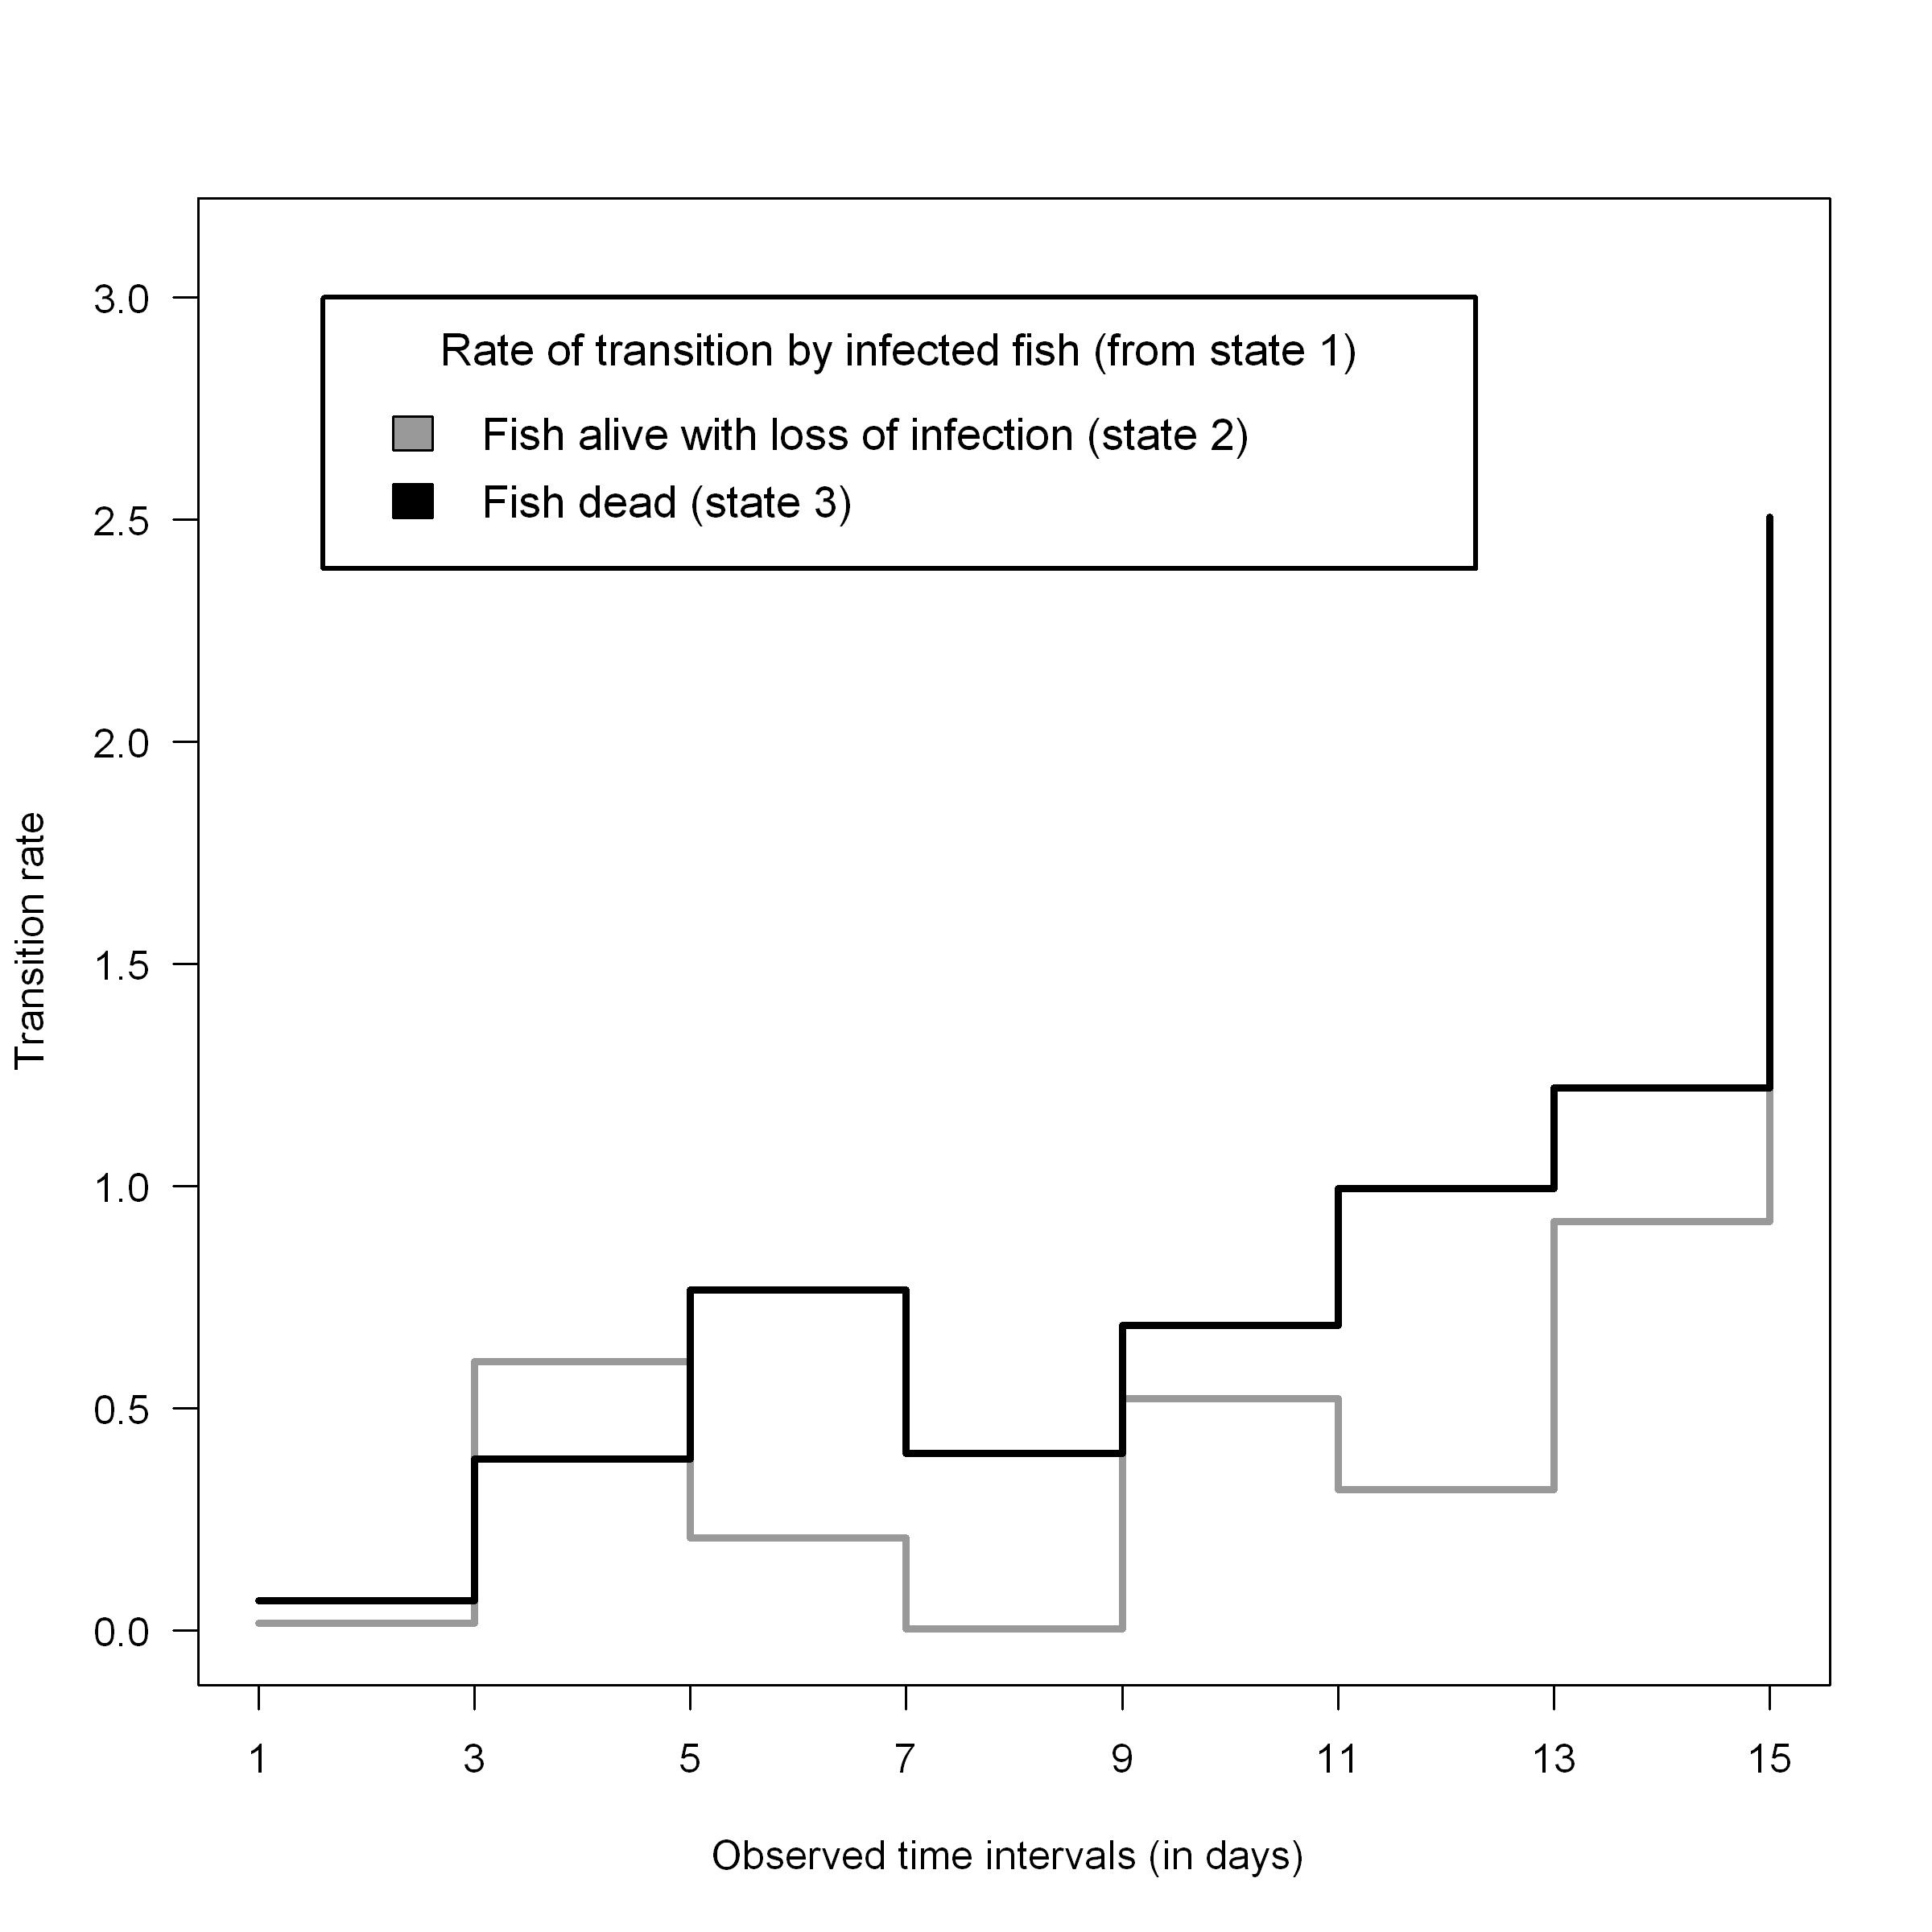

In [25]:
#Multistate_model_best$Qmatrices (How way to visualise it)

Qrate_State2=c(Multistate_model_best$Qmatrices$baseline[1,2],abs(Multistate_model_best$Qmatrices$`timeperiod[3,5)`)[1,2],
abs(Multistate_model_best$Qmatrices$`timeperiod[5,7)`)[1,2],abs(Multistate_model_best$Qmatrices$`timeperiod[7,9)`)[1,2],
abs(Multistate_model_best$Qmatrices$`timeperiod[9,11)`)[1,2],  abs(Multistate_model_best$Qmatrices$`timeperiod[11,13)`)[1,2],
abs(Multistate_model_best$Qmatrices$`timeperiod[13,15)`)[1,2],  abs(Multistate_model_best$Qmatrices$`timeperiod[15,Inf)`)[1,2])

Qrate_State3=c(Multistate_model_best$Qmatrices$baseline[1,3],abs(Multistate_model_best$Qmatrices$`timeperiod[3,5)`)[1,3],
abs(Multistate_model_best$Qmatrices$`timeperiod[5,7)`)[1,3],abs(Multistate_model_best$Qmatrices$`timeperiod[7,9)`)[1,3],
abs(Multistate_model_best$Qmatrices$`timeperiod[9,11)`)[1,3],  abs(Multistate_model_best$Qmatrices$`timeperiod[11,13)`)[1,3],
abs(Multistate_model_best$Qmatrices$`timeperiod[13,15)`)[1,3],  abs(Multistate_model_best$Qmatrices$`timeperiod[15,Inf)`)[1,3])


plot(Qrate_State2,type="s",col="grey60",lwd=3
      ,ylab="Transition rate",las=1,xaxt = "n",xlab="Observed time intervals (in days) ",
    ylim=c(0,3.1))
lines(Qrate_State3,type="s",col="grey0",lwd=3)


axis(1, at=1:8, labels=c("1","3","5","7","9","11","13","15"))
text <- c("Fish alive with loss of infection (state 2)",
          "Fish dead (state 3)")
legend_order <- matrix(1:2,ncol=1,byrow = T)
legend(x = 1.3,y=3,legend = text[legend_order],
       col=c("grey60","grey0"),ncol=1, cex=1.1,title="Rate of transition by infected fish (from state 1)",box.lwd = 2,
       fill=c("grey60","grey0"))


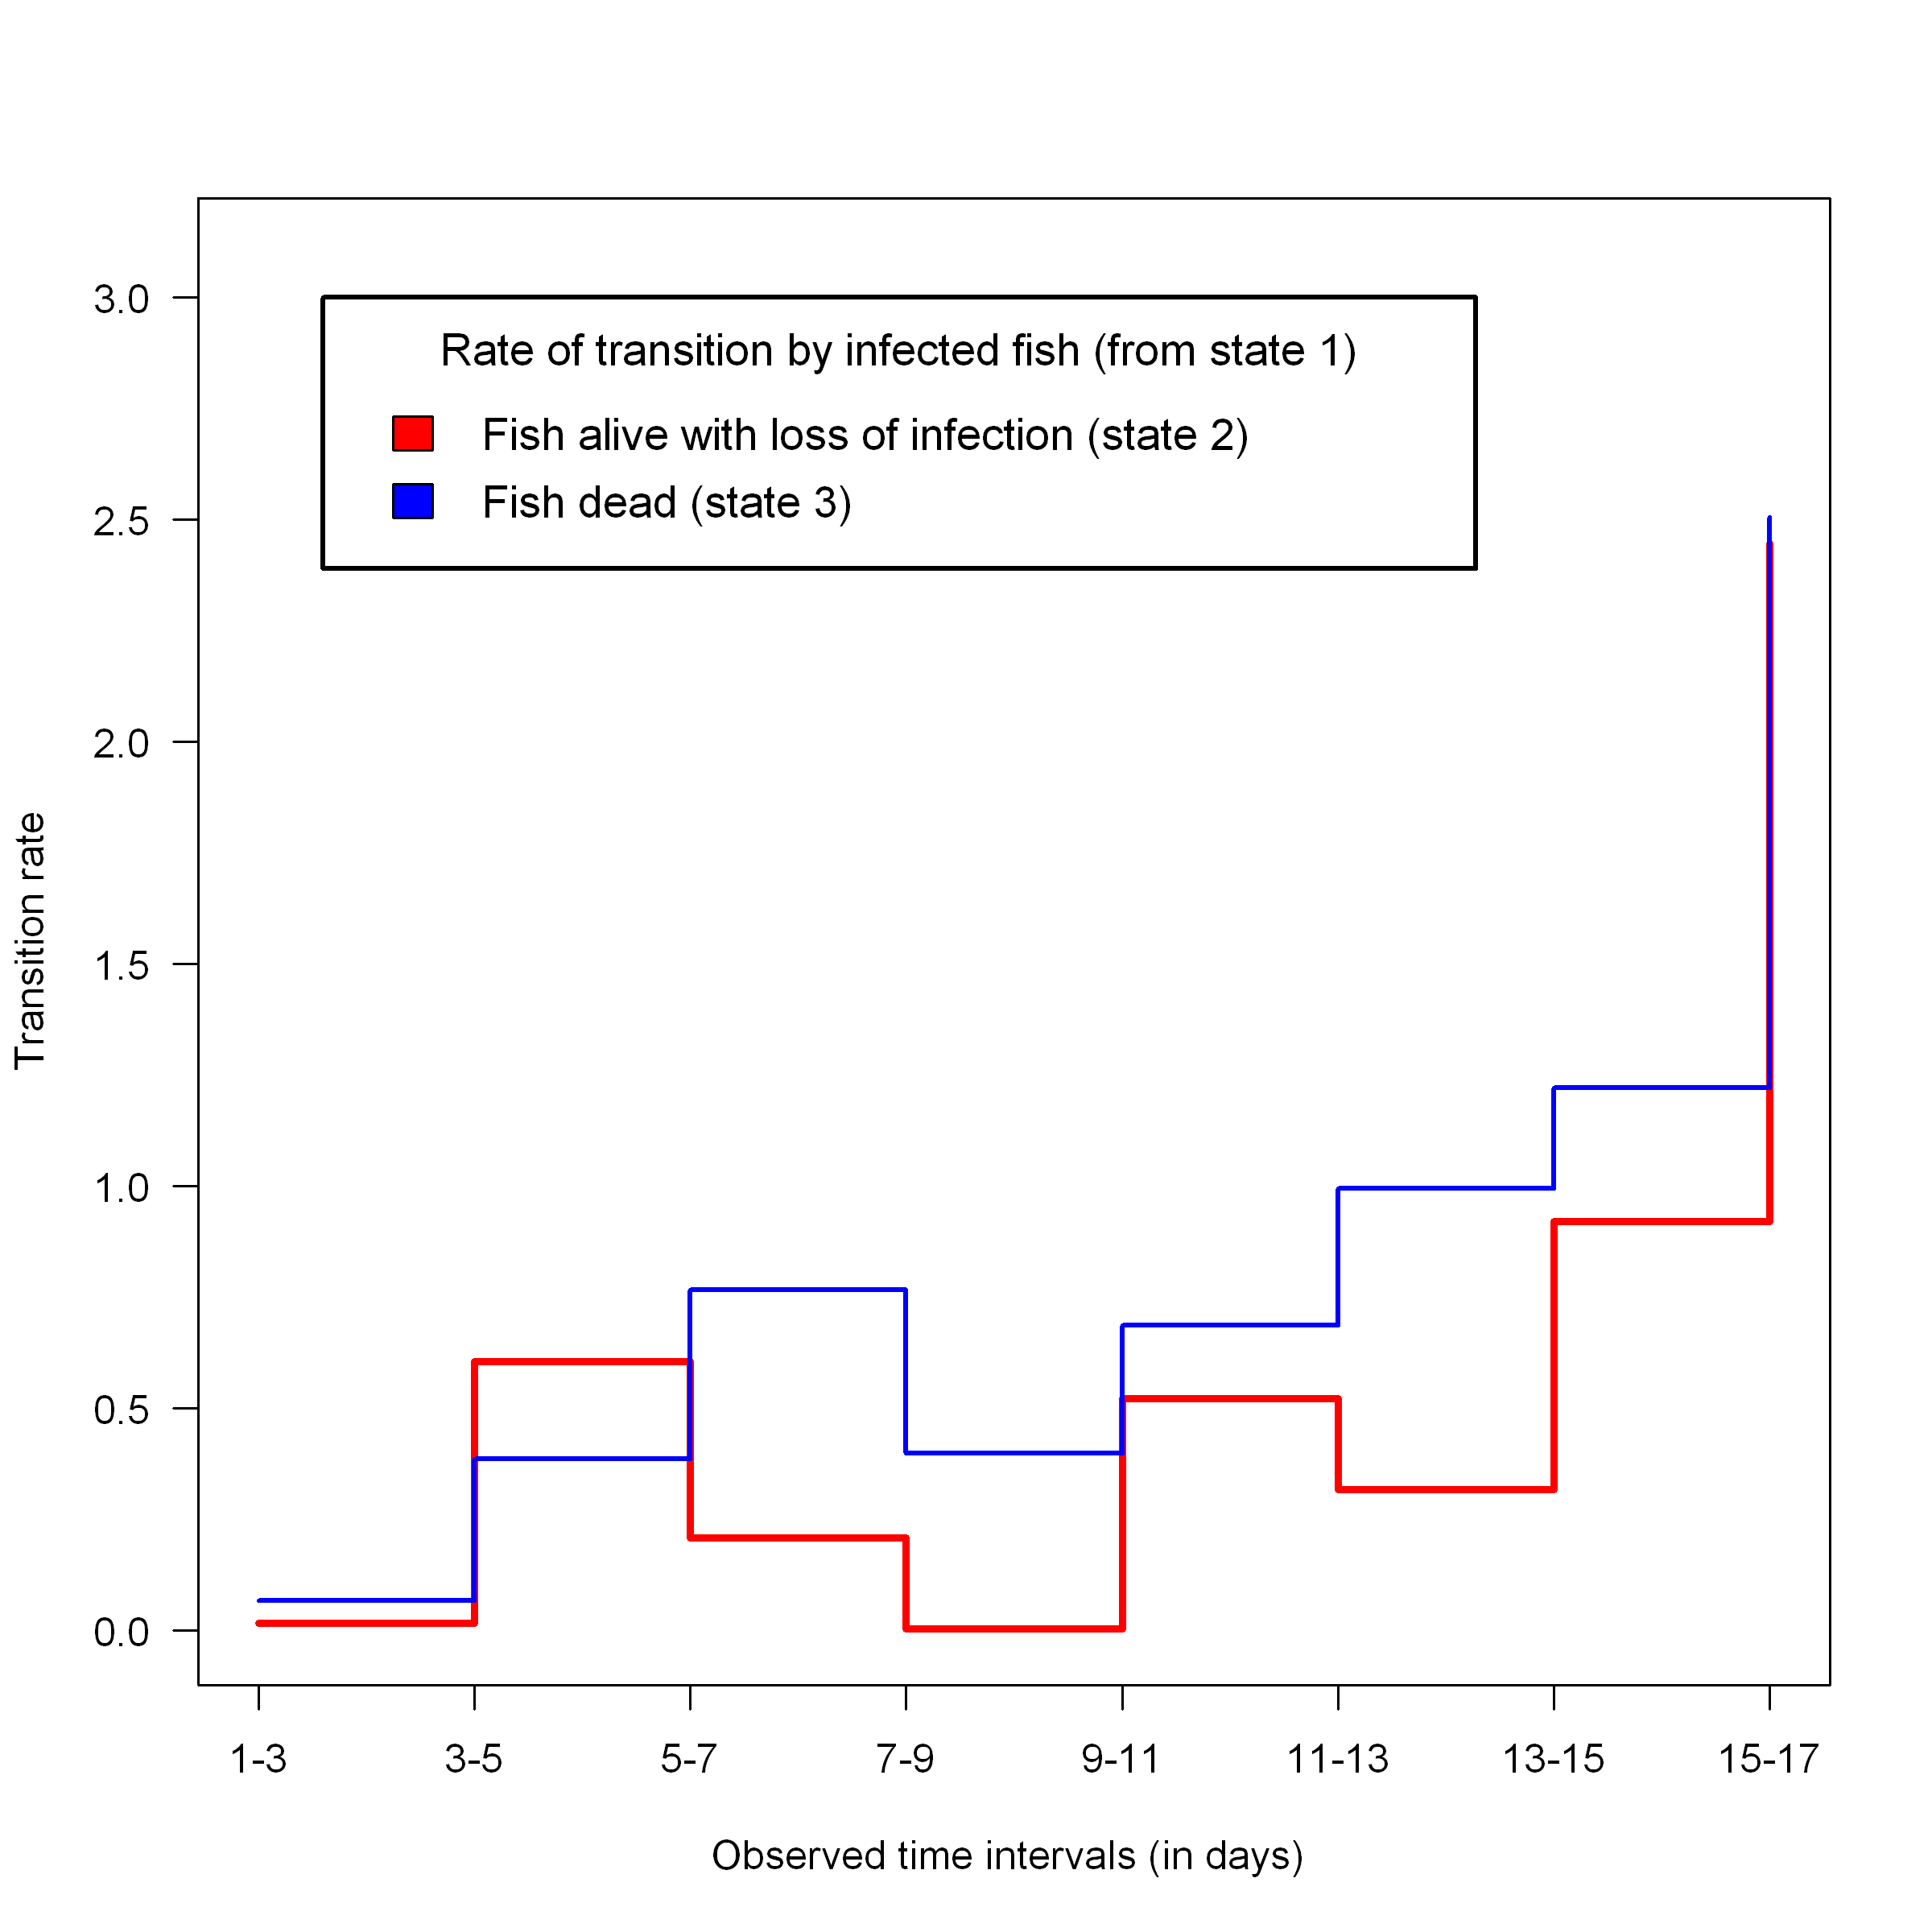

In [51]:
#Multistate_model_best$Qmatrices

Qrate_State2=c(Multistate_model_best$Qmatrices$baseline[1,2],abs(Multistate_model_best$Qmatrices$`timeperiod[3,5)`)[1,2],
abs(Multistate_model_best$Qmatrices$`timeperiod[5,7)`)[1,2],abs(Multistate_model_best$Qmatrices$`timeperiod[7,9)`)[1,2],
abs(Multistate_model_best$Qmatrices$`timeperiod[9,11)`)[1,2],  abs(Multistate_model_best$Qmatrices$`timeperiod[11,13)`)[1,2],
abs(Multistate_model_best$Qmatrices$`timeperiod[13,15)`)[1,2],  abs(Multistate_model_best$Qmatrices$`timeperiod[15,Inf)`)[1,2])

Qrate_State3=c(Multistate_model_best$Qmatrices$baseline[1,3],abs(Multistate_model_best$Qmatrices$`timeperiod[3,5)`)[1,3],
abs(Multistate_model_best$Qmatrices$`timeperiod[5,7)`)[1,3],abs(Multistate_model_best$Qmatrices$`timeperiod[7,9)`)[1,3],
abs(Multistate_model_best$Qmatrices$`timeperiod[9,11)`)[1,3],  abs(Multistate_model_best$Qmatrices$`timeperiod[11,13)`)[1,3],
abs(Multistate_model_best$Qmatrices$`timeperiod[13,15)`)[1,3],  abs(Multistate_model_best$Qmatrices$`timeperiod[15,Inf)`)[1,3])


plot(Qrate_State2,type="s",col="red",lwd=3
      ,ylab="Transition rate",las=1,xaxt = "n",xlab="Observed time intervals (in days) ",
    ylim=c(0,3.1))
lines(Qrate_State3,type="s",col="blue",lwd=2)


axis(1, at=1:8, labels=c("1-3","3-5","5-7","7-9","9-11","11-13","13-15","15-17"))
text <- c("Fish alive with loss of infection (state 2)",
          "Fish dead (state 3)")
legend_order <- matrix(1:2,ncol=1,byrow = T)
legend(x = 1.3,y=3,legend = text[legend_order],
       col=c("red","blue"),ncol=1, cex=1.1,title="Rate of transition by infected fish (from state 1)",
     box.lwd = 2,fill=c("red","blue"))





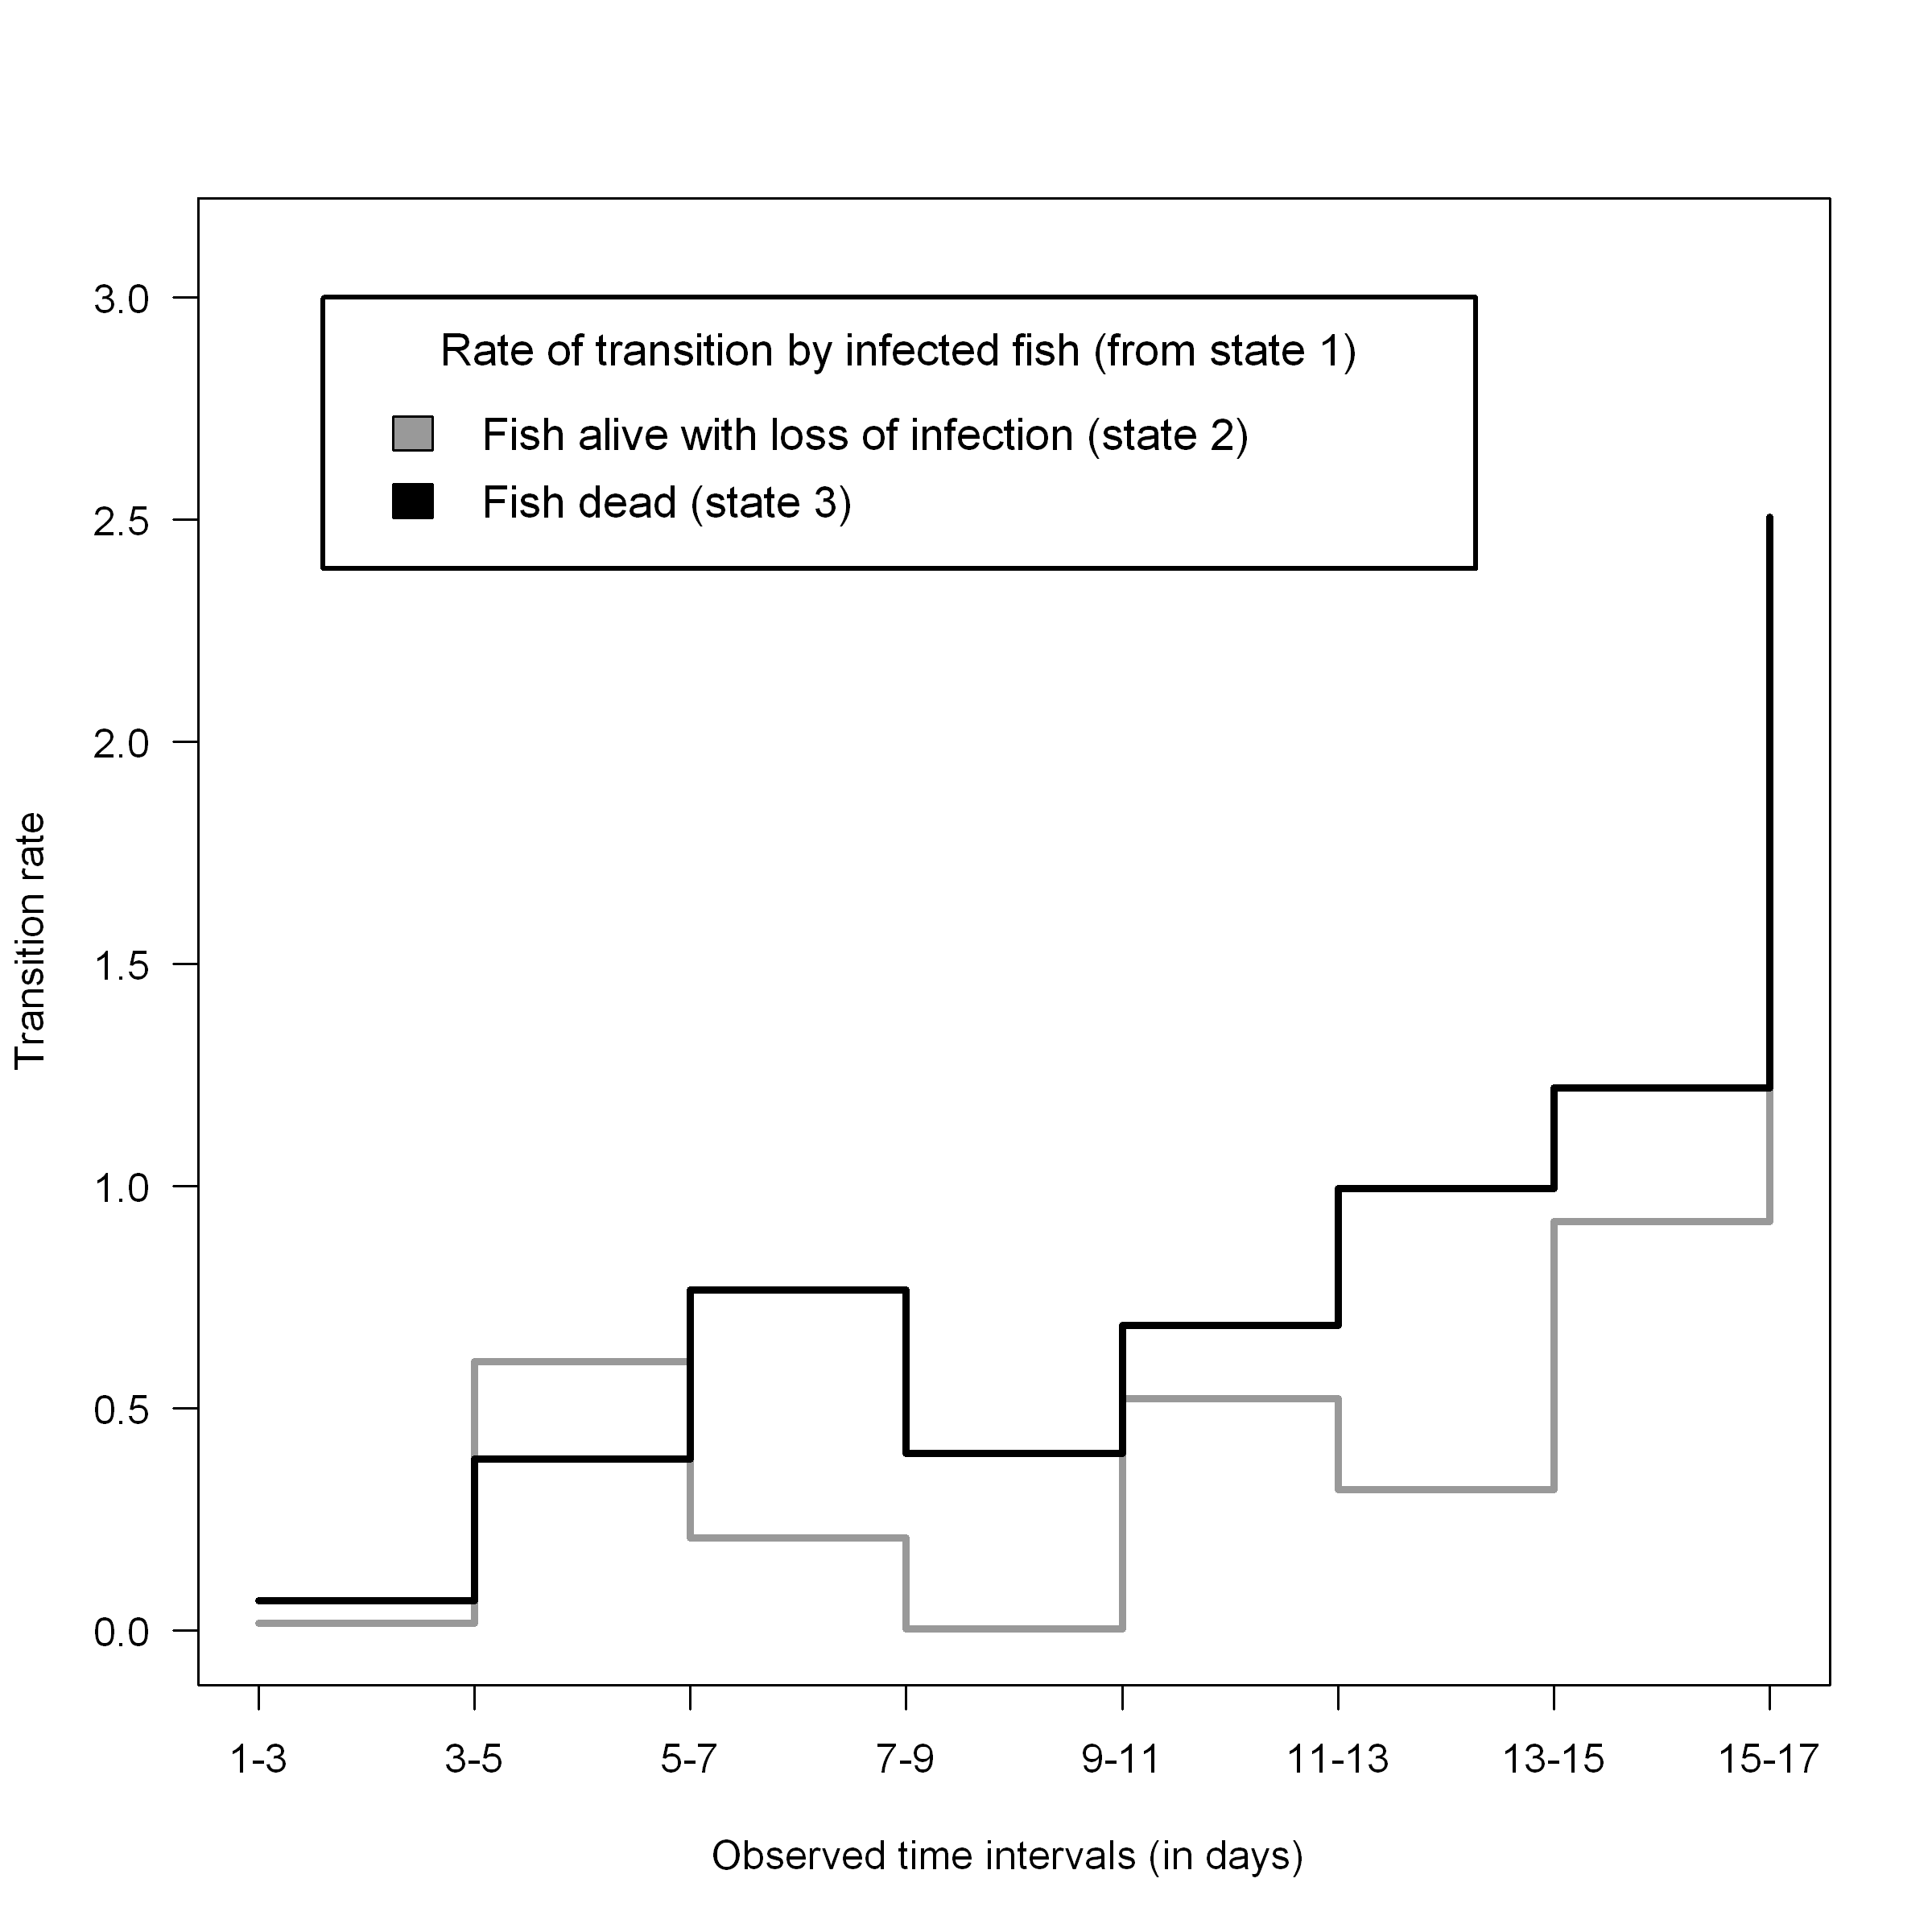

In [84]:
#Multistate_model_best$Qmatrices

Qrate_State2=c(Multistate_model_best$Qmatrices$baseline[1,2],abs(Multistate_model_best$Qmatrices$`timeperiod[3,5)`)[1,2],
abs(Multistate_model_best$Qmatrices$`timeperiod[5,7)`)[1,2],abs(Multistate_model_best$Qmatrices$`timeperiod[7,9)`)[1,2],
abs(Multistate_model_best$Qmatrices$`timeperiod[9,11)`)[1,2],  abs(Multistate_model_best$Qmatrices$`timeperiod[11,13)`)[1,2],
abs(Multistate_model_best$Qmatrices$`timeperiod[13,15)`)[1,2],  abs(Multistate_model_best$Qmatrices$`timeperiod[15,Inf)`)[1,2])

Qrate_State3=c(Multistate_model_best$Qmatrices$baseline[1,3],abs(Multistate_model_best$Qmatrices$`timeperiod[3,5)`)[1,3],
abs(Multistate_model_best$Qmatrices$`timeperiod[5,7)`)[1,3],abs(Multistate_model_best$Qmatrices$`timeperiod[7,9)`)[1,3],
abs(Multistate_model_best$Qmatrices$`timeperiod[9,11)`)[1,3],  abs(Multistate_model_best$Qmatrices$`timeperiod[11,13)`)[1,3],
abs(Multistate_model_best$Qmatrices$`timeperiod[13,15)`)[1,3],  abs(Multistate_model_best$Qmatrices$`timeperiod[15,Inf)`)[1,3])


plot(Qrate_State2,type="s",col="grey60",lwd=3
      ,ylab="Transition rate",las=1,xaxt = "n",xlab="Observed time intervals (in days) ",
    ylim=c(0,3.1))
lines(Qrate_State3,type="s",col="grey0",lwd=3)


axis(1, at=1:8, labels=c("1-3","3-5","5-7","7-9","9-11","11-13","13-15","15-17"))
text <- c("Fish alive with loss of infection (state 2)",
          "Fish dead (state 3)")
legend_order <- matrix(1:2,ncol=1,byrow = T)
legend(x = 1.3,y=3,legend = text[legend_order],
       col=c("grey60","grey0"),ncol=1, cex=1.1,title="Rate of transition by infected fish (from state 1)",box.lwd = 2,
       fill=c("grey60","grey0"))


**Mean sojourn times for the transient state 1**

The function sojourn.msm extracts the estimated mean sojourn times in
each transient state r, for a given set of covariate values. This is calculated as −1/qˆrr, where
qˆrr is the rth diagonal entry of the estimated transition intensity matrix.

In [26]:
#With parasite load as additional covariate
sojourn.msm(Multistate_model_best)

,estimates,SE,L,U
,<dbl>,<dbl>,<dbl>,<dbl>
state1,12.02893,1.134008,9.999574,14.47014


**Probability that each state is next**

In [30]:
pnext.msm(Multistate_model_best)

       state1 state2                state3               
state1 0      0.192 (0.1290,0.2791) 0.808 (0.7209,0.8710)
state2 0      0                     0                    
state3 0      0                     0                    

**Total length of stay**

Mean sojourn times describe the average period in a single stay in a state. For
processes with successive periods of recovery and relapse, we may want to forecast the total
time spent healthy or diseased, before death. The function totlos.msm estimates the forecasted total length of time spent in each transient state s between two future time points t1 and
t2, for a given set of covariate values. This defaults to the expected amount of time spent in
each state between the start of the process (time 0, the present time) and death or a specified
future time

In [23]:
totlos.msm(Multistate_model_best)

state1   state2   state3 
11.09444      Inf      Inf

**Hazard ratios across covariates with parasite load as additional variable**

The function hazard.msm gives the estimated hazard ratios corresponding to each covariate effect on the transition intensities. 95% conﬁdence limits are computed by assuming normality of the log-effect

**Sex of fish (Ref: Female)**

In [28]:
#male
Multistate_model_2=NULL
Multistate_model_2[[1]]=Multistate_model_best

i=1
hazard.msm(Multistate_model_2[[i]])$`Sex_fishMale fish`
Est1_2=log(hazard.msm(Multistate_model_2[[i]])$'Sex_fishMale fish'[1,1])
L1_limit_1_2=log(hazard.msm(Multistate_model_2[[i]])$'Sex_fishMale fish'[1,2])
U1_limit_1_2=log(hazard.msm(Multistate_model_2[[i]])$'Sex_fishMale fish'[1,3])
SE_1 =(U1_limit_1_2-L1_limit_1_2)/(2*1.96)
z_1=abs(Est1_2/SE_1)
P_value1=exp((−0.717*z_1)-(0.416*z_1^2))
print(paste("P-value: state 1-2=",P_value1))

Est1_3=log(hazard.msm(Multistate_model_2[[i]])$'Sex_fishMale fish'[2,1])
L2_limit_1_2=log(hazard.msm(Multistate_model_2[[i]])$'Sex_fishMale fish'[2,2])
U2_limit_1_2=log(hazard.msm(Multistate_model_2[[i]])$'Sex_fishMale fish'[2,3])
SE_2 =(U2_limit_1_2-L2_limit_1_2)/(2*1.96)
z_2=abs(Est1_3/SE_2)
P_value2=exp((−0.717*z_2)-(0.416*z_2^2))
print(paste("P-value: state 1-3=",P_value2))

,HR,L,U
state1 - state2,1.262819,0.6148229,2.593773
state1 - state3,1.532951,1.0291618,2.283352


[1] "P-value: state 1-2= 0.536028970182875"
[1] "P-value: state 1-3= 0.0353059815158519"


**Fish population (Reference: UA)**


In [29]:
#LA
i=1
hazard.msm(Multistate_model_2[[i]])$`Fish_populationLower Aripo`
Est1_2=log(hazard.msm(Multistate_model_2[[i]])$`Fish_populationLower Aripo`[1,1])
L1_limit_1_2=log(hazard.msm(Multistate_model_2[[i]])$`Fish_populationLower Aripo`[1,2])
U1_limit_1_2=log(hazard.msm(Multistate_model_2[[i]])$`Fish_populationLower Aripo`[1,3])
SE_1 =(U1_limit_1_2-L1_limit_1_2)/(2*1.96)
z_1=abs(Est1_2/SE_1)
P_value1=exp((−0.717*z_1)-(0.416*z_1^2))
print(paste("P-value: state 1-2=",P_value1))

Est1_3=log(hazard.msm(Multistate_model_2[[i]])$`Fish_populationLower Aripo`[2,1])
L2_limit_1_2=log(hazard.msm(Multistate_model_2[[i]])$`Fish_populationLower Aripo`[2,2])
U2_limit_1_2=log(hazard.msm(Multistate_model_2[[i]])$`Fish_populationLower Aripo`[2,3])
SE_2 =(U2_limit_1_2-L2_limit_1_2)/(2*1.96)
z_2=abs(Est1_3/SE_2)
P_value2=exp((−0.717*z_2)-(0.416*z_2^2))
print(paste("P-value: state 1-3=",P_value2))


,HR,L,U
state1 - state2,0.8662213,0.3061210,2.4511203
state1 - state3,0.3903636,0.2502171,0.6090062


[1] "P-value: state 1-2= 0.79891746587598"
[1] "P-value: state 1-3= 4.02056146073253e-05"


In [30]:
#Ornamental
i=1
hazard.msm(Multistate_model_2[[i]])$Fish_populationOrnamental
Est1_2=log(hazard.msm(Multistate_model_2[[i]])$Fish_populationOrnamental[1,1])
L1_limit_1_2=log(hazard.msm(Multistate_model_2[[i]])$Fish_populationOrnamental[1,2])
U1_limit_1_2=log(hazard.msm(Multistate_model_2[[i]])$Fish_populationOrnamental[1,3])
SE_1 =(U1_limit_1_2-L1_limit_1_2)/(2*1.96)
z_1=abs(Est1_2/SE_1)
P_value1=exp((−0.717*z_1)-(0.416*z_1^2))
print(paste("P-value: state 1-2=",P_value1))

Est1_3=log(hazard.msm(Multistate_model_2[[i]])$Fish_populationOrnamental[2,1])
L2_limit_1_2=log(hazard.msm(Multistate_model_2[[i]])$Fish_populationOrnamental[2,2])
U2_limit_1_2=log(hazard.msm(Multistate_model_2[[i]])$Fish_populationOrnamental[2,3])
SE_2 =(U2_limit_1_2-L2_limit_1_2)/(2*1.96)
z_2=abs(Est1_3/SE_2)
P_value2=exp((−0.717*z_2)-(0.416*z_2^2))
print(paste("P-value: state 1-3=",P_value2))


,HR,L,U
state1 - state2,1.3750642,0.5084273,3.7189220
state1 - state3,0.2329239,0.1368379,0.3964804


[1] "P-value: state 1-2= 0.541373644951504"
[1] "P-value: state 1-3= 1.31953657007412e-07"


**Parasite strain (Ref: Gt3)**

In [31]:
#Gt
i=1
hazard.msm(Multistate_model_2[[i]])$Parasite_typeGt
Est1_2=log(hazard.msm(Multistate_model_2[[i]])$Parasite_typeGt[1,1])
L1_limit_1_2=log(hazard.msm(Multistate_model_2[[i]])$Parasite_typeGt[1,2])
U1_limit_1_2=log(hazard.msm(Multistate_model_2[[i]])$Parasite_typeGt[1,3])
SE_1 =(U1_limit_1_2-L1_limit_1_2)/(2*1.96)
z_1=abs(Est1_2/SE_1)
P_value1=exp((−0.717*z_1)-(0.416*z_1^2))
print(paste("P-value: state 1-2=",P_value1))

Est1_3=log(hazard.msm(Multistate_model_2[[i]])$Parasite_typeGt[2,1])
L2_limit_1_2=log(hazard.msm(Multistate_model_2[[i]])$Parasite_typeGt[2,2])
U2_limit_1_2=log(hazard.msm(Multistate_model_2[[i]])$Parasite_typeGt[2,3])
SE_2 =(U2_limit_1_2-L2_limit_1_2)/(2*1.96)
z_2=abs(Est1_3/SE_2)
P_value2=exp((−0.717*z_2)-(0.416*z_2^2))
print(paste("P-value: state 1-3=",P_value2))



,HR,L,U
state1 - state2,0.5254648,0.2024620,1.3637785
state1 - state3,0.6043217,0.3764983,0.9700036


[1] "P-value: state 1-2= 0.187192019845147"
[1] "P-value: state 1-3= 0.036654899104584"


In [32]:
#Gb
i=1
hazard.msm(Multistate_model_2[[i]])$Parasite_typeGbull
Est1_2=log(hazard.msm(Multistate_model_2[[i]])$Parasite_typeGbull[1,1])
L1_limit_1_2=log(hazard.msm(Multistate_model_2[[i]])$Parasite_typeGbull[1,2])
U1_limit_1_2=log(hazard.msm(Multistate_model_2[[i]])$Parasite_typeGbull[1,3])
SE_1 =(U1_limit_1_2-L1_limit_1_2)/(2*1.96)
z_1=abs(Est1_2/SE_1)
P_value1=exp((−0.717*z_1)-(0.416*z_1^2))
print(paste("P-value: state 1-2=",P_value1))

Est1_3=log(hazard.msm(Multistate_model_2[[i]])$Parasite_typeGbull[2,1])
L2_limit_1_2=log(hazard.msm(Multistate_model_2[[i]])$Parasite_typeGbull[2,2])
U2_limit_1_2=log(hazard.msm(Multistate_model_2[[i]])$Parasite_typeGbull[2,3])
SE_2 =(U2_limit_1_2-L2_limit_1_2)/(2*1.96)
z_2=abs(Est1_3/SE_2)
P_value2=exp((−0.717*z_2)-(0.416*z_2^2))
print(paste("P-value: state 1-3=",P_value2))

,HR,L,U
state1 - state2,1.0765096,0.4770358,2.429321
state1 - state3,0.9920279,0.6331406,1.554346


[1] "P-value: state 1-2= 0.86900179942926"
[1] "P-value: state 1-3= 0.974767604351982"


**Fish size**

In [55]:
i=1
hazard.msm(Multistate_model_2[[i]])$Fish_size
Est1_2=log(hazard.msm(Multistate_model_2[[i]])$Fish_size[1,1])
L1_limit_1_2=log(hazard.msm(Multistate_model_2[[i]])$Fish_size[1,2])
U1_limit_1_2=log(hazard.msm(Multistate_model_2[[i]])$Fish_size[1,3])
SE_1 =(U1_limit_1_2-L1_limit_1_2)/(2*1.96)
z_1=abs(Est1_2/SE_1)
P_value1=exp((−0.717*z_1)-(0.416*z_1^2))
print(paste("P-value: state 1-2=",P_value1))

Est1_3=log(hazard.msm(Multistate_model_2[[i]])$Fish_size[2,1])
L2_limit_1_2=log(hazard.msm(Multistate_model_2[[i]])$Fish_size[2,2])
U2_limit_1_2=log(hazard.msm(Multistate_model_2[[i]])$Fish_size[2,3])
SE_2 =(U2_limit_1_2-L2_limit_1_2)/(2*1.96)
z_2=abs(Est1_3/SE_2)
P_value2=exp((−0.717*z_2)-(0.416*z_2^2))
print(paste("P-value: state 1-3=",P_value2))

,HR,L,U
state1 - state2,0.867,0.757,0.993
state1 - state3,1.005,0.937,1.079


[1] "P-value: state 1-2= 0.0386464421036058"
[1] "P-value: state 1-3= 0.892764676412523"


# **Observed timepoints (Ref: 1-3)**

**Days 3-5**

In [56]:
i=1
hazard.msm(Multistate_model_2[[i]])$`timeperiod[3,5)`
Est1_2=log(hazard.msm(Multistate_model_2[[i]])$`timeperiod[3,5)`[1,1])
L1_limit_1_2=log(hazard.msm(Multistate_model_2[[i]])$`timeperiod[3,5)`[1,2])
U1_limit_1_2=log(hazard.msm(Multistate_model_2[[i]])$`timeperiod[3,5)`[1,3])
SE_1 =(U1_limit_1_2-L1_limit_1_2)/(2*1.96)
z_1=abs(Est1_2/SE_1)
P_value1=exp((−0.717*z_1)-(0.416*z_1^2))
print(paste("P-value: state 1-2=",P_value1))

Est1_3=log(hazard.msm(Multistate_model_2[[i]])$`timeperiod[3,5)`[2,1])
L2_limit_1_2=log(hazard.msm(Multistate_model_2[[i]])$`timeperiod[3,5)`[2,2])
U2_limit_1_2=log(hazard.msm(Multistate_model_2[[i]])$`timeperiod[3,5)`[2,3])
SE_2 =(U2_limit_1_2-L2_limit_1_2)/(2*1.96)
z_2=abs(Est1_3/SE_2)
P_value2=exp((−0.717*z_2)-(0.416*z_2^2))
print(paste("P-value: state 1-3=",P_value2))

,HR,L,U
state1 - state2,1.809,0.436,7.50
state1 - state3,0.687,0.271,1.75


[1] "P-value: state 1-2= 0.4217890137725"
[1] "P-value: state 1-3= 0.438532507216222"


**Days 5-7**

In [37]:
i=1
hazard.msm(Multistate_model_2[[i]])$`timeperiod[5,7)`
Est1_2=log(hazard.msm(Multistate_model_2[[i]])$`timeperiod[5,7)`[1,1])
L1_limit_1_2=log(hazard.msm(Multistate_model_2[[i]])$`timeperiod[5,7)`[1,2])
U1_limit_1_2=log(hazard.msm(Multistate_model_2[[i]])$`timeperiod[5,7)`[1,3])
SE_1 =(U1_limit_1_2-L1_limit_1_2)/(2*1.96)
z_1=abs(Est1_2/SE_1)
P_value1=exp((−0.717*z_1)-(0.416*z_1^2))
print(paste("P-value: state 1-2=",P_value1))

Est1_3=log(hazard.msm(Multistate_model_2[[i]])$`timeperiod[5,7)`[2,1])
L2_limit_1_2=log(hazard.msm(Multistate_model_2[[i]])$`timeperiod[5,7)`[2,2])
U2_limit_1_2=log(hazard.msm(Multistate_model_2[[i]])$`timeperiod[5,7)`[2,3])
SE_2 =(U2_limit_1_2-L2_limit_1_2)/(2*1.96)
z_2=abs(Est1_3/SE_2)
P_value2=exp((−0.717*z_2)-(0.416*z_2^2))
print(paste("P-value: state 1-3=",P_value2))

,HR,L,U
state1 - state2,0.8059341,0.1355104,4.793209
state1 - state3,2.1605178,1.0454502,4.464906


[1] "P-value: state 1-2= 0.824104726318803"
[1] "P-value: state 1-3= 0.0372101609885374"


**Days 7-9**

In [38]:
i=1
hazard.msm(Multistate_model_2[[i]])$`timeperiod[7,9)`
Est1_2=log(hazard.msm(Multistate_model_2[[i]])$`timeperiod[7,9)`[1,1])
L1_limit_1_2=log(hazard.msm(Multistate_model_2[[i]])$`timeperiod[7,9)`[1,2])
U1_limit_1_2=log(hazard.msm(Multistate_model_2[[i]])$`timeperiod[7,9)`[1,3])
SE_1 =(U1_limit_1_2-L1_limit_1_2)/(2*1.96)
z_1=abs(Est1_2/SE_1)
P_value1=exp((−0.717*z_1)-(0.416*z_1^2))
print(paste("P-value: state 1-2=",P_value1))

Est1_3=log(hazard.msm(Multistate_model_2[[i]])$`timeperiod[7,9)`[2,1])
L2_limit_1_2=log(hazard.msm(Multistate_model_2[[i]])$`timeperiod[7,9)`[2,2])
U2_limit_1_2=log(hazard.msm(Multistate_model_2[[i]])$`timeperiod[7,9)`[2,3])
SE_2 =(U2_limit_1_2-L2_limit_1_2)/(2*1.96)
z_2=abs(Est1_3/SE_2)
P_value2=exp((−0.717*z_2)-(0.416*z_2^2))
print(paste("P-value: state 1-3=",P_value2))

,HR,L,U
state1 - state2,0.9863228,0.1651816,5.889475
state1 - state3,1.4971651,0.6433302,3.484219


[1] "P-value: state 1-2= 0.989133990122666"
[1] "P-value: state 1-3= 0.35477820975446"


**Days 9-11**

In [39]:
i=1
hazard.msm(Multistate_model_2[[i]])$`timeperiod[9,11)`
Est1_2=log(hazard.msm(Multistate_model_2[[i]])$`timeperiod[9,11)`[1,1])
L1_limit_1_2=log(hazard.msm(Multistate_model_2[[i]])$`timeperiod[9,11)`[1,2])
U1_limit_1_2=log(hazard.msm(Multistate_model_2[[i]])$`timeperiod[9,11)`[1,3])
SE_1 =(U1_limit_1_2-L1_limit_1_2)/(2*1.96)
z_1=abs(Est1_2/SE_1)
P_value1=exp((−0.717*z_1)-(0.416*z_1^2))
print(paste("P-value: state 1-2=",P_value1))

Est1_3=log(hazard.msm(Multistate_model_2[[i]])$`timeperiod[9,11)`[2,1])
L2_limit_1_2=log(hazard.msm(Multistate_model_2[[i]])$`timeperiod[9,11)`[2,2])
U2_limit_1_2=log(hazard.msm(Multistate_model_2[[i]])$`timeperiod[9,11)`[2,3])
SE_2 =(U2_limit_1_2-L2_limit_1_2)/(2*1.96)
z_2=abs(Est1_3/SE_2)
P_value2=exp((−0.717*z_2)-(0.416*z_2^2))
print(paste("P-value: state 1-3=",P_value2))

,HR,L,U
state1 - state2,1.708553,0.3437417,8.492285
state1 - state3,1.992524,0.8716414,4.554800


[1] "P-value: state 1-2= 0.523211683547176"
[1] "P-value: state 1-3= 0.101981929443478"


**Days 11-13**

In [40]:
i=1
hazard.msm(Multistate_model_2[[i]])$`timeperiod[11,13)`
Est1_2=log(hazard.msm(Multistate_model_2[[i]])$`timeperiod[11,13)`[1,1])
L1_limit_1_2=log(hazard.msm(Multistate_model_2[[i]])$`timeperiod[11,13)`[1,2])
U1_limit_1_2=log(hazard.msm(Multistate_model_2[[i]])$`timeperiod[11,13)`[1,3])
SE_1 =(U1_limit_1_2-L1_limit_1_2)/(2*1.96)
z_1=abs(Est1_2/SE_1)
P_value1=exp((−0.717*z_1)-(0.416*z_1^2))
print(paste("P-value: state 1-2=",P_value1))

Est1_3=log(hazard.msm(Multistate_model_2[[i]])$`timeperiod[11,13)`[2,1])
L2_limit_1_2=log(hazard.msm(Multistate_model_2[[i]])$`timeperiod[11,13)`[2,2])
U2_limit_1_2=log(hazard.msm(Multistate_model_2[[i]])$`timeperiod[11,13)`[2,3])
SE_2 =(U2_limit_1_2-L2_limit_1_2)/(2*1.96)
z_2=abs(Est1_3/SE_2)
P_value2=exp((−0.717*z_2)-(0.416*z_2^2))
print(paste("P-value: state 1-3=",P_value2))

,HR,L,U
state1 - state2,1.382325,0.2292577,8.334821
state1 - state3,2.720222,1.2076027,6.127518


[1] "P-value: state 1-2= 0.737020949440154"
[1] "P-value: state 1-3= 0.0156302615515477"


**Days 13-15**

In [41]:
i=1
hazard.msm(Multistate_model_2[[i]])$`timeperiod[13,15)`
Est1_2=log(hazard.msm(Multistate_model_2[[i]])$`timeperiod[13,15)`[1,1])
L1_limit_1_2=log(hazard.msm(Multistate_model_2[[i]])$`timeperiod[13,15)`[1,2])
U1_limit_1_2=log(hazard.msm(Multistate_model_2[[i]])$`timeperiod[13,15)`[1,3])
SE_1 =(U1_limit_1_2-L1_limit_1_2)/(2*1.96)
z_1=abs(Est1_2/SE_1)
P_value1=exp((−0.717*z_1)-(0.416*z_1^2))
print(paste("P-value: state 1-2=",P_value1))

Est1_3=log(hazard.msm(Multistate_model_2[[i]])$`timeperiod[13,15)`[2,1])
L2_limit_1_2=log(hazard.msm(Multistate_model_2[[i]])$`timeperiod[13,15)`[2,2])
U2_limit_1_2=log(hazard.msm(Multistate_model_2[[i]])$`timeperiod[13,15)`[2,3])
SE_2 =(U2_limit_1_2-L2_limit_1_2)/(2*1.96)
z_2=abs(Est1_3/SE_2)
P_value2=exp((−0.717*z_2)-(0.416*z_2^2))
print(paste("P-value: state 1-3=",P_value2))

,HR,L,U
state1 - state2,2.572549,0.5115608,12.93689
state1 - state3,3.409865,1.5104022,7.69807


[1] "P-value: state 1-2= 0.254348219445682"
[1] "P-value: state 1-3= 0.00320326896974139"


**Days 15-17**

In [42]:
i=1
hazard.msm(Multistate_model_2[[i]])$`timeperiod[15,Inf)`
Est1_2=log(hazard.msm(Multistate_model_2[[i]])$`timeperiod[15,Inf)`[1,1])
L1_limit_1_2=log(hazard.msm(Multistate_model_2[[i]])$`timeperiod[15,Inf)`[1,2])
U1_limit_1_2=log(hazard.msm(Multistate_model_2[[i]])$`timeperiod[15,Inf)`[1,3])
SE_1 =(U1_limit_1_2-L1_limit_1_2)/(2*1.96)
z_1=abs(Est1_2/SE_1)
P_value1=exp((−0.717*z_1)-(0.416*z_1^2))
print(paste("P-value: state 1-2=",P_value1))

Est1_3=log(hazard.msm(Multistate_model_2[[i]])$`timeperiod[15,Inf)`[2,1])
L2_limit_1_2=log(hazard.msm(Multistate_model_2[[i]])$`timeperiod[15,Inf)`[2,2])
U2_limit_1_2=log(hazard.msm(Multistate_model_2[[i]])$`timeperiod[15,Inf)`[2,3])
SE_2 =(U2_limit_1_2-L2_limit_1_2)/(2*1.96)
z_2=abs(Est1_3/SE_2)
P_value2=exp((−0.717*z_2)-(0.416*z_2^2))
print(paste("P-value: state 1-3=",P_value2))

,HR,L,U
state1 - state2,11.95409,3.274065,43.64616
state1 - state3,12.31680,6.192604,24.49754


[1] "P-value: state 1-2= 0.000191999852245662"
[1] "P-value: state 1-3= 3.28100272169884e-12"


In [218]:
#Extracting transition intensity given any covariate (eg. fish sex)
qmatrix.msm(Multistate_model_best,covariates=list(Sex_fish="Male fish"))

       state1                        state2                       
state1 -0.11781 (-0.218540,-0.06351)  0.01314 ( 0.003052, 0.05657)
state2 0                             0                            
state3 0                             0                            
       state3                       
state1  0.10467 ( 0.053518, 0.20473)
state2 0                            
state3 0                            

# Survival plots

Important use of Multi-state models is in predicting the probability
of survival for patients in increasingly severe states of disease, for some time t in the future. This can
be obtained directly from the transition probability matrix P(t).

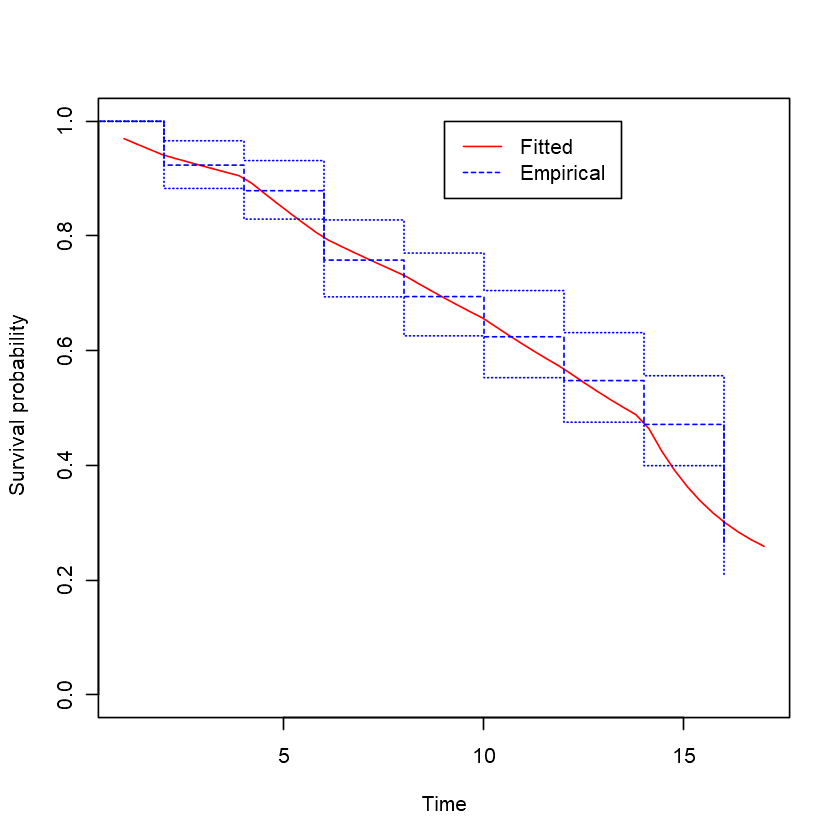

In [43]:
plot.survfit.msm(Multistate_model_best,mark.time=F)

# Model assessment

	
If "normal", then calculate a confidence interval for the expected prevalences by simulating B random vectors from the asymptotic multivariate normal distribution implied by the maximum likelihood estimates (and covariance matrix) of the log transition intensities and covariate effects, then calculating the expected prevalences for each replicate.

In [52]:
#Without parasite load as additional covariate
options(digits=3)
Comparison_output=prevalence.msm(Multistate_model_best, times=seq(1,17,2),censtime=17
               ,ci=c("normal"),B=500,cores=4,interp="start")

#Comparison_output

In [107]:
#plot.prevalence.msm(Multistate_model_2[[1]],mintime=1,maxtime=17)

In [53]:
Lower_limit=as.data.frame(Comparison_output$`Expected percentages`$ci[, ,1])
names(Lower_limit)=c("LL:State1","LL: State2","LL: State3")
rownames(Lower_limit)=c(1,3,5,7,9,11,13,15,17)

Upper_limit=as.data.frame(Comparison_output$`Expected percentages`$ci[, ,2])
names(Upper_limit)=c("UL: State1","UL: State2","UL: State3")
rownames(Upper_limit)=c(1,3,5,7,9,11,13,15,17)
CI_intervals=cbind(Lower_limit,Upper_limit,as.data.frame(Comparison_output$`Expected percentages`$estimates))/100

# **Chi-square goodness-of-fit test**

Conclusion: There is no significant difference between the observed and the predicted values

In [55]:
Observed_percentages=as.data.frame(Comparison_output$"Observed percentages")/100
Expected_percentages=as.data.frame(Comparison_output$"Expected percentages")/100

#ignoring the initial probability of states 1, 2 and 3 respectively (ie: 1,0,0)
observed=c(as.vector(Observed_percentages[,1]),as.vector(Observed_percentages[,2]),as.vector(Observed_percentages[,3]))[-c(1,10,19)]
predicted=c(as.vector(Expected_percentages[,1]),as.vector(Expected_percentages[,2]),as.vector(Expected_percentages[,3]))[-c(1,10,19)]

chi2 = sum((observed- predicted)^2/ predicted)
paste("Chi-square=",chi2,";","p-value=", pchisq(chi2,df=1,lower.tail=FALSE)) 

[1] "Chi-square= 0.0671935877594099 ; p-value= 0.795467614760402"

# Estimating the prediction accuracy



In [56]:
na.zero <- function (x) {
    x[is.na(x)] <- 0
    return(x)
}


MAPE=function(x,y){(sum(na.zero(abs(as.vector(x)-as.vector(y))/as.vector(x)))*100)/length(as.vector(x))}


observed=c(as.vector(Observed_percentages[,1]),as.vector(Observed_percentages[,2]),as.vector(Observed_percentages[,3]))
predicted=c(as.vector(Expected_percentages[,1]),as.vector(Expected_percentages[,2]),as.vector(Expected_percentages[,3]))


MAPE(x=observed,y=predicted)
print(paste("The prediction accuracy=","",100-MAPE(x=observed,y=predicted),"%"))

[1] 7.85

[1] "The prediction accuracy=  92.1451984956748 %"


# The fitted transition probability matrix is used to forecast expected prevalences from the state occupancy at the initial time.

In [57]:
Observed_data=Comparison_output$`Observed percentages`/100
Observed_data
Expected_data=Comparison_output$`Expected percentages`$estimates/100
Expected_data

,State 1,State 2,State 3
1,1.0000,0.0000,0.0000
3,0.9045,0.0191,0.0764
5,0.8280,0.0510,0.1210
7,0.6943,0.0637,0.2420
9,0.6178,0.0764,0.3057
11,0.5287,0.0955,0.3758
13,0.4395,0.1083,0.4522
15,0.3439,0.1274,0.5287
17,0.0701,0.1975,0.7325


,state1,state2,state3
1,1.000,0.0000,0.0000
3,0.910,0.0186,0.0717
5,0.836,0.0495,0.1149
7,0.708,0.0615,0.2302
9,0.630,0.0741,0.2958
11,0.539,0.0927,0.3682
13,0.449,0.1053,0.4461
15,0.356,0.1238,0.5200
17,0.163,0.1741,0.6630


In [58]:
o<-par(mar=c(0,4,2,2))#Run this before the code below

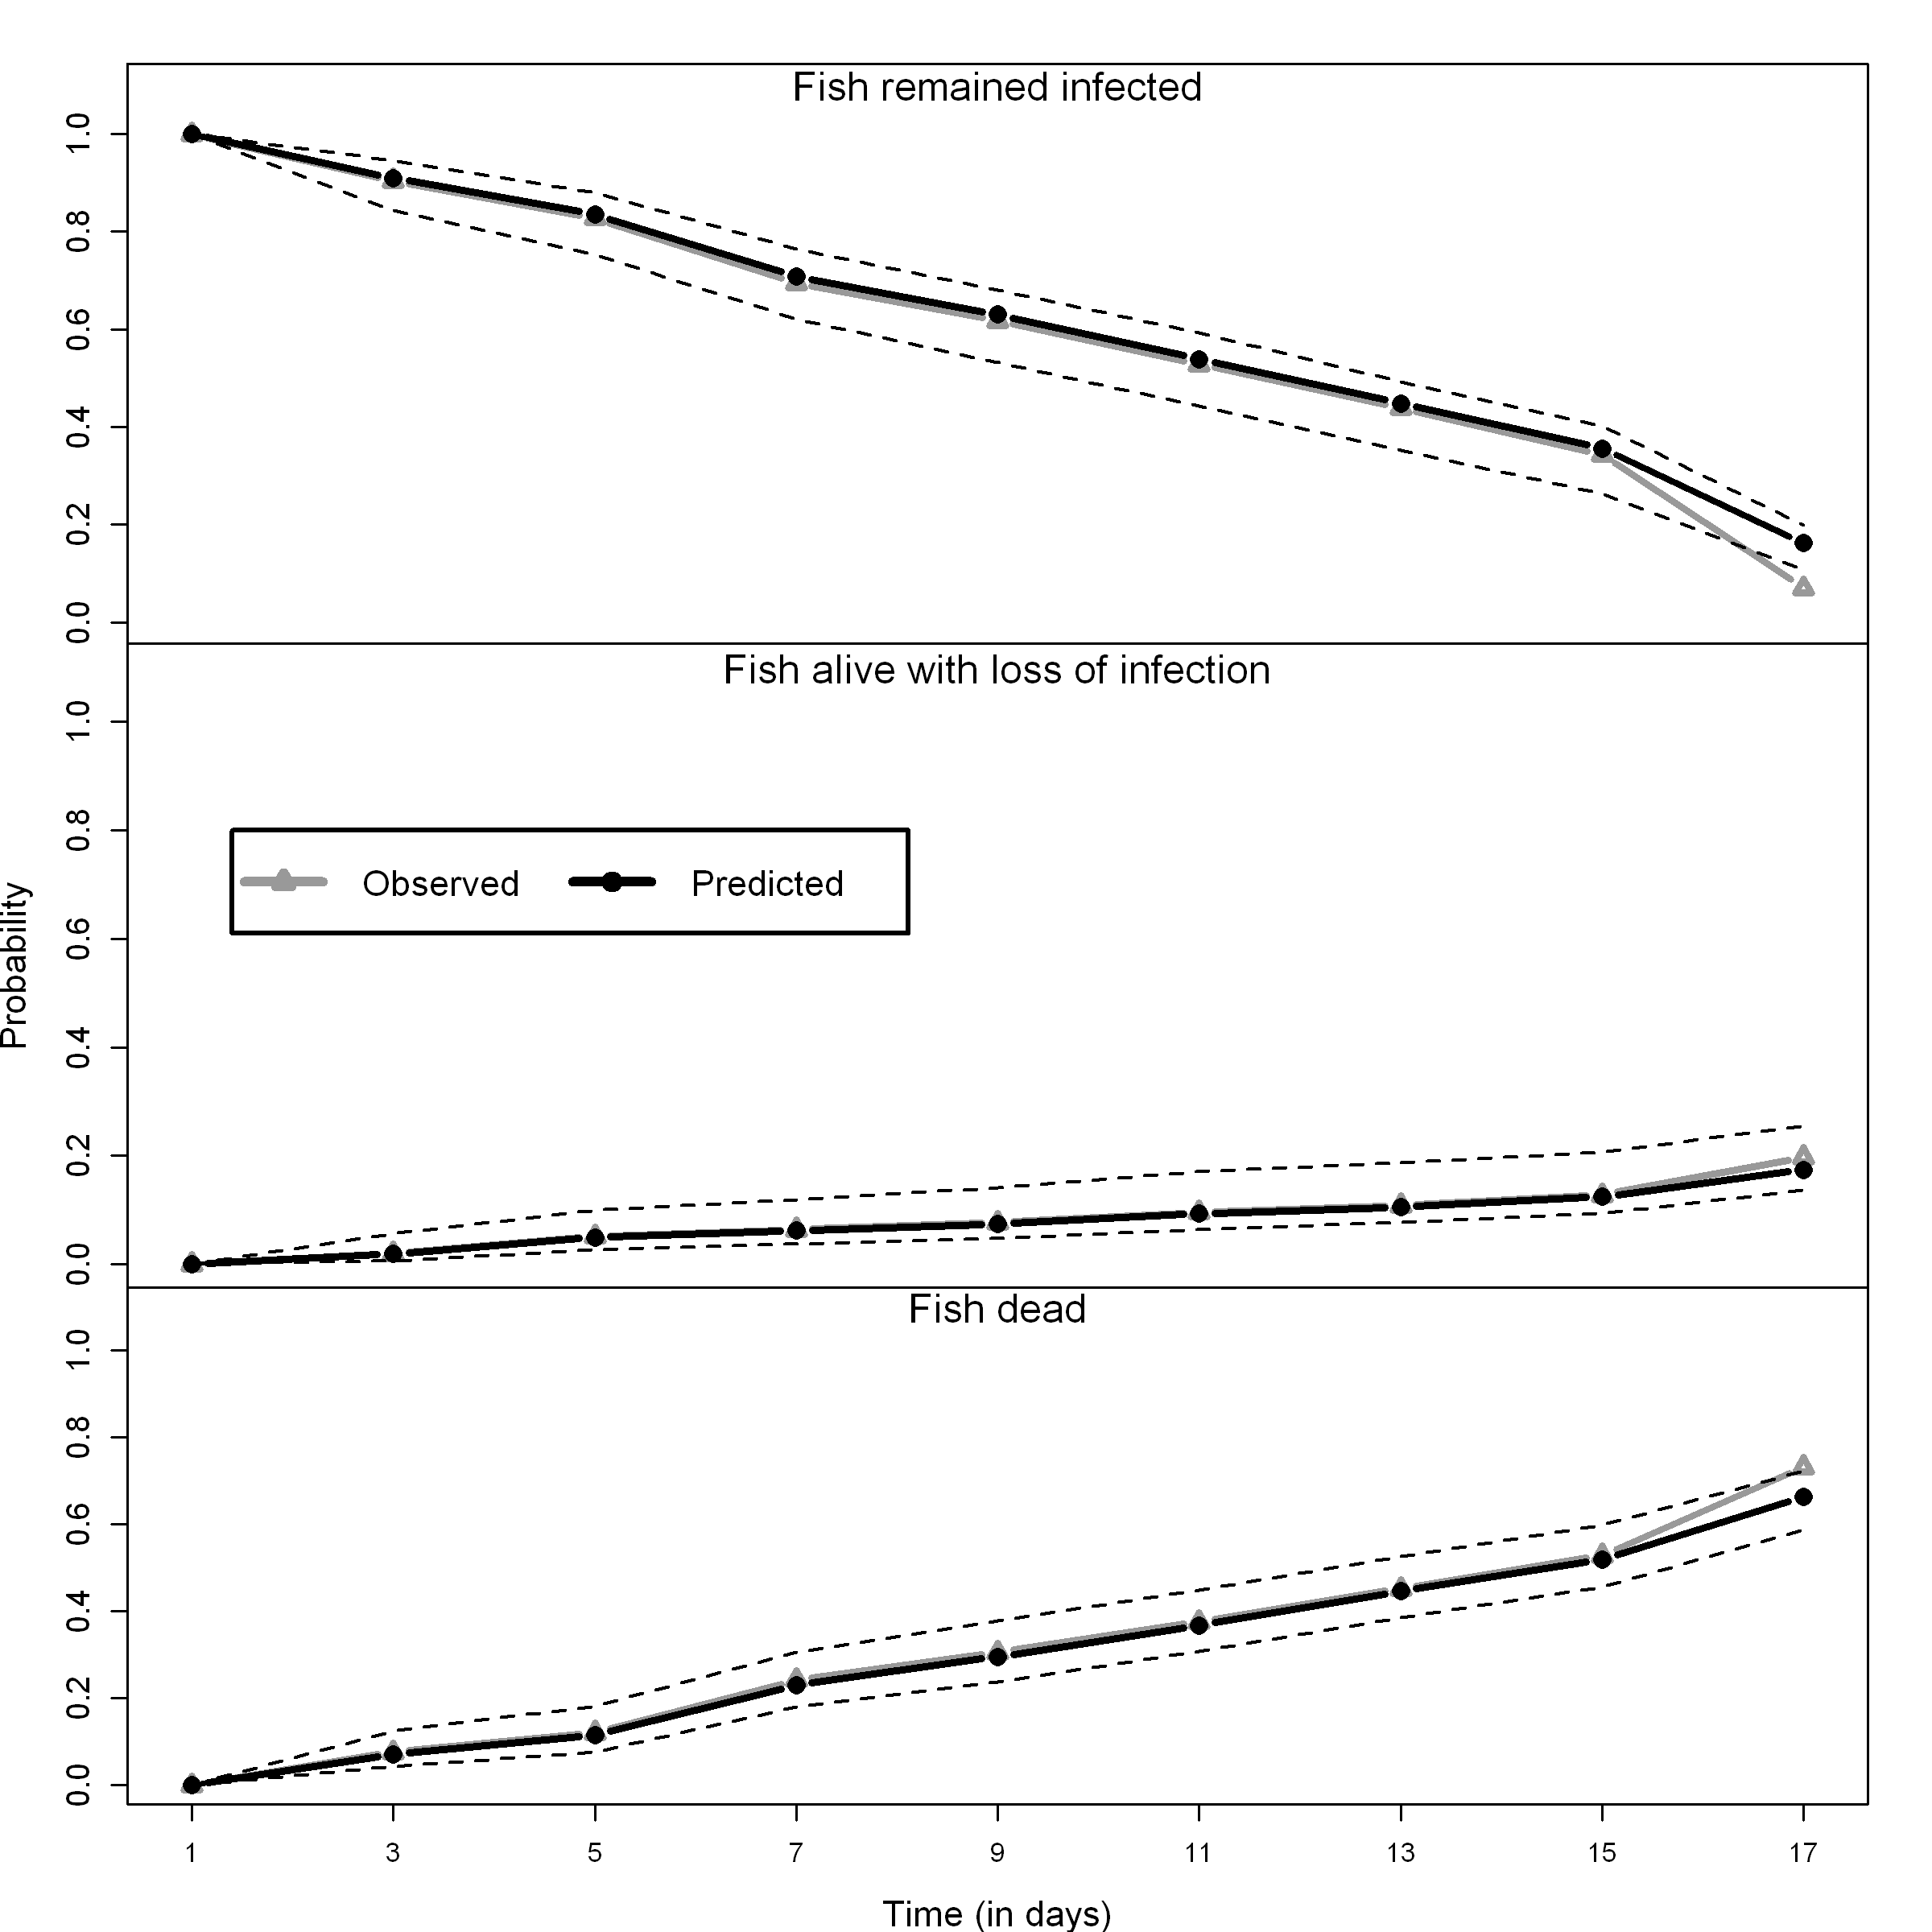

In [86]:

nf<-layout(matrix(1:3, nrow=3,ncol=1))
#layout.show(nf)
    

# rest parameters
par(o)#
o<-par(mar=c(0,4,2,2))
#o<-par(mar=c(0,4,2,2))
plot(Observed_data[,1],type="b",col="grey60",lwd=3,xaxt = "n",ylab="",xlab="",pch=24,cex.axis=1.2,ylim=c(0,1.1))
lines(Expected_data[,1],type="b",col="grey0",lwd=3,pch=19)
lines(CI_intervals[,1],type="l",col="grey0",lty=2,lwd=1.5)
lines(CI_intervals[,4],type="l",col="grey0",lty=2,lwd=1.5)
#axis(1, at=1:9, labels=c("1","3","5","7","9","11","13","15","17"))
text(5,1.1,"Fish remained infected",cex=1.5)





o<-par(mar=c(0,4,0,2))
plot(Observed_data[,2],type="b",col="grey60",lwd=3,xaxt = "n",ylab="Probability",xlab="",ylim=c(0,1.1),pch=24,cex.lab=1.35, cex.axis=1.2)
lines(Expected_data[,2],type="b",col="grey0",lwd=3,pch=19)
lines(CI_intervals[,2],type="l",col="grey0",lty=2,lwd=1.5)
lines(CI_intervals[,5],type="l",col="grey0",lty=2,lwd=1.5)
#axis(1, at=1:9, labels=c("1","3","5","7","9","11","13","15","17"))
text(5,1.1,"Fish alive with loss of infection",cex=1.5)

legend(x = 1.2,y=0.8,inset=0,
        legend = c("Observed","Predicted"), 
        col=c("grey60","grey0"), lwd=4, cex=1.35, horiz = TRUE,pch=c(24,19),pt.cex = 1,box.lwd = 2)


par(mar=c(4,4,0,2))

plot(Observed_data[,3],type="b",col="grey60",lwd=3,xaxt = "n",ylab="",xlab="Time (in days)",pch=24,cex.lab=1.35, cex.axis=1.2
    ,ylim=c(0,1.1))
lines(Expected_data[,3],type="b",col="grey0",lwd=3,pch=19)
lines(CI_intervals[,3],type="l",col="grey0",lty=2,lwd=1.5)
lines(CI_intervals[,6],type="l",col="grey0",lty=2,lwd=1.5)
axis(1, at=1:9, labels=c("1","3","5","7","9","11","13","15","17"))
text(5,1.1,"Fish dead",cex=1.5)

#mtext("Time (in days)", side =1,line = 0, outer=TRUE)
#mtext("Probability", side =2,line = 0, outer=TRUE, las=0)

par(o)





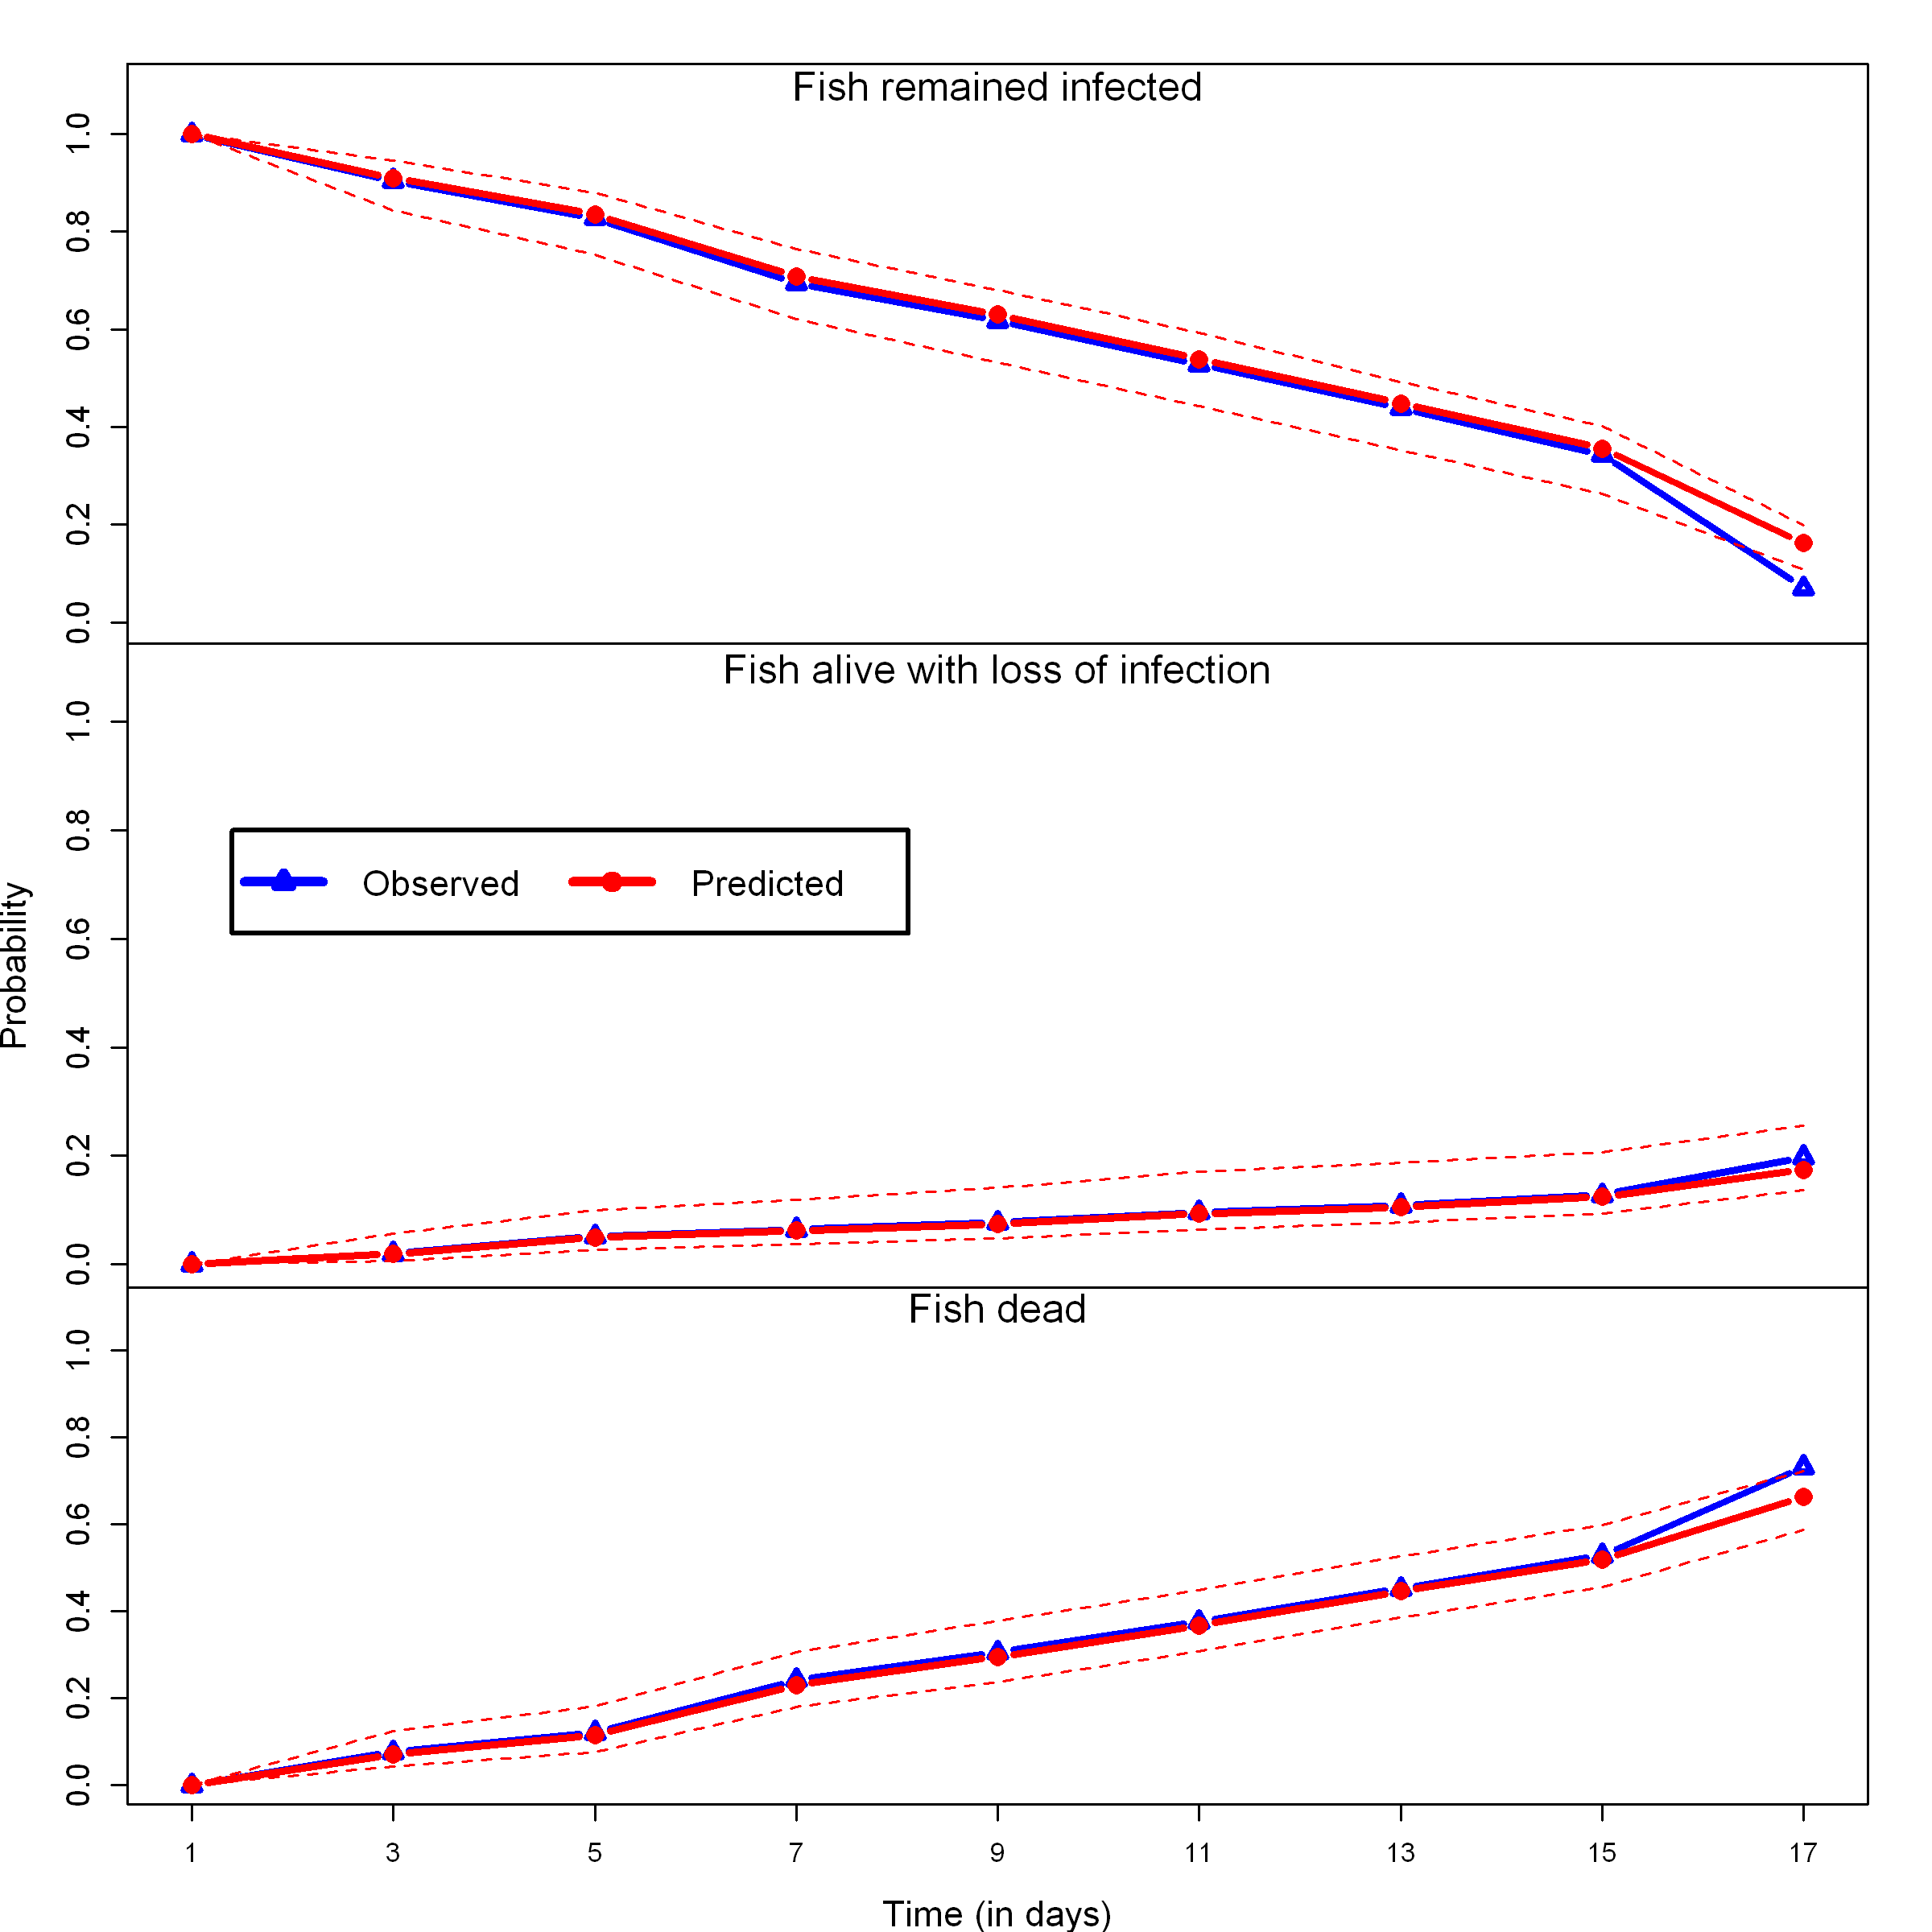

In [62]:

nf<-layout(matrix(1:3, nrow=3,ncol=1))
#layout.show(nf)
    

# rest parameters
par(o)#
o<-par(mar=c(0,4,2,2))
#o<-par(mar=c(0,4,2,2))
plot(Observed_data[,1],type="b",col="blue",lwd=3,xaxt = "n",ylab="",xlab="",pch=24,cex.axis=1.2,ylim=c(0,1.1))
lines(Expected_data[,1],type="b",col="red",lwd=3,pch=19)
lines(CI_intervals[,1],type="l",col="red",lty=2)
lines(CI_intervals[,4],type="l",col="red",lty=2)
#axis(1, at=1:9, labels=c("1","3","5","7","9","11","13","15","17"))
text(5,1.1,"Fish remained infected",cex=1.5)





o<-par(mar=c(0,4,0,2))
plot(Observed_data[,2],type="b",col="blue",lwd=3,xaxt = "n",ylab="Probability",xlab="",ylim=c(0,1.1),pch=24,cex.lab=1.35, cex.axis=1.2)
lines(Expected_data[,2],type="b",col="red",lwd=3,pch=19)
lines(CI_intervals[,2],type="l",col="red",lty=2)
lines(CI_intervals[,5],type="l",col="red",lty=2)
#axis(1, at=1:9, labels=c("1","3","5","7","9","11","13","15","17"))
text(5,1.1,"Fish alive with loss of infection",cex=1.5)

legend(x = 1.2,y=0.8,,inset = 0,
        legend = c("Observed","Predicted"), 
        col=c("blue","red"), lwd=4, cex=1.35, horiz = TRUE,pch=c(24,19),pt.cex = 1,box.lwd = 2)


par(mar=c(4,4,0,2))

plot(Observed_data[,3],type="b",col="blue",lwd=3,xaxt = "n",ylab="",xlab="Time (in days)",pch=24,cex.lab=1.35, cex.axis=1.2
    ,ylim=c(0,1.1))
lines(Expected_data[,3],type="b",col="red",lwd=3,pch=19)
lines(CI_intervals[,3],type="l",col="red",lty=2)
lines(CI_intervals[,6],type="l",col="red",lty=2)
axis(1, at=1:9, labels=c("1","3","5","7","9","11","13","15","17"))
text(5,1.1,"Fish dead",cex=1.5)

#mtext("Time (in days)", side =1,line = 0, outer=TRUE)
#mtext("Probability", side =2,line = 0, outer=TRUE, las=0)

par(o)





In [52]:

graph=function(){

nf<-layout(matrix(1:3, nrow=3,ncol=1))
#layout.show(nf)
    

# rest parameters
par(o)#
o<-par(mar=c(0,4,2,2))
#o<-par(mar=c(0,4,2,2))
plot(Observed_data[,1],type="b",col="blue",lwd=3,xaxt = "n",ylab="",xlab="",pch=24,cex.axis=1.2)
lines(Expected_data[,1],type="b",col="red",lwd=3,pch=19)
lines(CI_intervals[,1],type="l",col="red",lty=2)
lines(CI_intervals[,4],type="l",col="red",lty=2)
#axis(1, at=1:9, labels=c("1","3","5","7","9","11","13","15","17"))
text(5,0.9,"Fish remained infected",cex=1.5)


o<-par(mar=c(0,4,0,2))
plot(Observed_data[,2],type="b",col="blue",lwd=3,xaxt = "n",ylab="Probability",xlab="",ylim=c(0,.3),pch=24,cex.lab=1.35, cex.axis=1.2)
lines(Expected_data[,2],type="b",col="red",lwd=3,pch=19)
lines(CI_intervals[,2],type="l",col="red",lty=2)
lines(CI_intervals[,5],type="l",col="red",lty=2)
#axis(1, at=1:9, labels=c("1","3","5","7","9","11","13","15","17"))
text(5,.28,"Fish alive with loss of infection",cex=1.5)

par(mar=c(4,4,0,2))

plot(Observed_data[,3],type="b",col="blue",lwd=3,xaxt = "n",ylab="",xlab="Time (in days)",pch=24,cex.lab=1.35, cex.axis=1.2)
lines(Expected_data[,3],type="b",col="red",lwd=3,pch=19)
lines(CI_intervals[,3],type="l",col="red",lty=2)
lines(CI_intervals[,6],type="l",col="red",lty=2)
axis(1, at=1:9, labels=c("1","3","5","7","9","11","13","15","17"))
text(5,.69,"Fish dead",cex=1.5)

#mtext("Time (in days)", side =1,line = 0, outer=TRUE)
#mtext("Probability", side =2,line = 0, outer=TRUE, las=0)

par(o)

legend(x = 5.5,y=0.2,,inset = 0,
        legend = c("Observed","Predicted"), 
        col=c("blue","red"), lwd=2, cex=1.35, horiz = TRUE,pch=c(24,19),pt.cex = 1)

}


doc <- read_pptx()


doc <- add_slide(doc, 'Title and Content', 'Office Theme')
doc <- ph_with_vg(doc, code = graph(),type = "body")
#doc <- add_slide(doc, "Title and Content", "Office Theme")


# Write the document to a file
print(doc, target = 'Multistate_comparison.pptx')

[1] "C:/Users/user/Multistate_comparison.pptx"

In [1]:


#graph()